# AML drug response predictions

TODO: try some different models to predict AML drug responses.

Try some binary classification on the IC50 data with different thresholds, maybe as well as regression on the AUC values.

Focus on regression - we already have classification results.

Feature sets:

- Feature set 1 - binary - whether or not certain genes are mutated in a given patient
- Feature set 2 - continuous - allele frequencies of mutations
- Feature set 3 - continuous - all gene expression measurements (RPKM)
- Feature set 3A/3B - continuous, same as above but for subsets of genes shown to have an effect
- Feature set 4 - binary - relative gene expressions based on the regulatory graph and on housekeeping genes

Models:
- linear regression
- Lasso/LassoCV regression
- ElasticNet/ElasticNetCV regression
- SGD
- Random Forest Regression

yz, 2023-08-17

## 1. Load data

In [1]:
import numpy as np
import pandas as pd

In [2]:
rpkm = pd.read_csv('data/RPKM.csv', index_col=0)
drug_data = pd.read_csv('data/Drug_Response.csv', index_col=0)
mutations = pd.read_csv('data/Mutation.csv', index_col=0)

In [3]:
rpkm.index = rpkm.Gene
gene_names = rpkm.Symbol

In [4]:
# transposing the RPKM matrix so that the shape is samples x genes
rpkm_t = rpkm.transpose()

In [5]:
# selected housekeeping genes - Note: these are NOT USED YET!!!
housekeeping_genes = ['RPS10','FNTA','COX6A1','BECN1', 'SF3B2','PSMB2','AUP1','SRP14','HNRNPK', 'CCNI', 'RHOA', 'PABPC1','RPS11','TPT1','FTL']

In [6]:
rpkm.shape

(22843, 453)

In [7]:
drug_data.shape

(47650, 4)

In [8]:
rpkm.mean(1)

/tmp/ipykernel_601078/1028747558.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  rpkm.mean(1)


Gene
ENSG00000000003   -1.305964
ENSG00000000419    6.920826
ENSG00000000457    3.781071
ENSG00000000460    2.971630
ENSG00000000938    8.084141
                     ...   
ENSG00000273477    0.910838
ENSG00000273483   -0.645964
ENSG00000273486    2.886707
ENSG00000273487   -1.120620
ENSG00000273488    1.639306
Length: 22843, dtype: float64

In [9]:
rpkm.std(1)

/tmp/ipykernel_601078/1958355029.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  rpkm.std(1)


Gene
ENSG00000000003    1.807134
ENSG00000000419    0.311342
ENSG00000000457    0.542104
ENSG00000000460    0.668757
ENSG00000000938    1.792015
                     ...   
ENSG00000273477    1.325975
ENSG00000273483    1.288118
ENSG00000273486    0.871925
ENSG00000273487    1.467271
ENSG00000273488    1.017138
Length: 22843, dtype: float64

## 2. Generating mutation features

1. Highly mutated genes: TET2, STAG2, RUNX1, EZH2, JAK2, FLT3, SF3B1, GATA2, WT1, CEBPA, NPM1, KRAS, IDH1, BCOR, TP53, ASXL1, DNMT3A, U2AF1, PTPN11, SRSF2, NRAS, and IDH2
This is a binary matrix with 1 for mutated and 0 for wild-type.
2. Variant allele frequency of highly frequently altered variants (>1%)
'FLT3p.A680V', 'FLT3p.I836del', 'FLT3p.D835Y', 'FLT3p.D835H', 'NRASp.G13D', 'NRASp.Q61H', 'NRASp.Q61K', 'NRASp.G13R', 'NRASp.G12D', 'KRASp.G12D', 'U2AF1p.S34F',  'U2AF1p.Q157P', 'DNMT3Ap.R882H', 'DNMT3Ap.R882C',  'IDH2p.R172K', 'IDH2p.R140Q',
'IDH1p.R132H', 'IDH1p.R132C', 'ASXL1p.G646Wfs*12', 'ASXL1p.G645Vfs*58', 'SF3B1p.K666N', 'SF3B1p.K700E', 'NPM1p.W288Cfs*12', 
'JAK2p.V617F', 'SRSF2p.P95H', 'SRSF2p.P95L''SRSF2p.P95R', 'SRSF2p.P95_R102del',


In [10]:
mutations

chrom  pos_start   pos_end ref alt     labId  tumor_only genotyper  \
0        1     914477    914477   C   T  14-00141           0    mutect   
1        1     914477    914477   C   T  14-00141           0   varscan   
2        1     914941    914941   G   A  15-00492           0    mutect   
3        1     914941    914941   G   A  15-00492           0   varscan   
4        1     982281    982281   G   T  14-00676           0   varscan   
...    ...        ...       ...  ..  ..       ...         ...       ...   
9905     Y   13524677  13524677   T   C  13-00557           0   varscan   
9906     Y   13524677  13524677   T   C  13-00557           0    mutect   
9907     Y   13524713  13524713   A   G  16-01185           0    mutect   
9908     Y   21897362  21897362   G   A  14-00499           0   varscan   
9909     Y   21897362  21897362   G   A  14-00499           0    mutect   

      total_reads  allele_reads  ...  amino_acids   codons  \
0              33            17  ...          A/T  Gcc/Acc   
1              31            17  ...          A/T  Gcc/Acc   
2              74            12  ...          A/V  gCa/gTa   
3              85            19  ...          A/V  gCa/gTa   
4             139            13  ...          G/V  gGc/gTc   
...           ...           ...  ...          ...      ...   
9905          235            24  ...          Y/C  tAc/tGc   
9906          235            24  ...          Y/C  tAc/tGc   
9907           41             5  ...          V/A  gTt/gCt   
9908           60            26  ...          T/M  aCg/aTg   
9909           60            26  ...          T/M  aCg/aTg   

      existing_variation  variant_class               sift  \
0                    NaN            SNV    tolerated(0.12)   
1                    NaN            SNV    tolerated(0.12)   
2                    NaN            SNV    tolerated(0.11)   
3                    NaN            SNV    tolerated(0.11)   
4                    NaN            SNV     deleterious(0)   
...                  ...            ...                ...   
9905         rs768476671            SNV  deleterious(0.02)   
9906         rs768476671            SNV  deleterious(0.02)   
9907         rs757454454            SNV  deleterious(0.02)   
9908         rs746730690            SNV    tolerated(0.16)   
9909         rs746730690            SNV    tolerated(0.16)   

                      polyphen   exac_af short_aa_change   validation  \
0                benign(0.002)       NaN         p.A551T  not_covered   
1                benign(0.002)       NaN         p.A551T  not_covered   
2                benign(0.003)       NaN         p.A396V     not_done   
3                benign(0.003)       NaN         p.A396V     not_done   
4     probably_damaging(0.972)       NaN        p.G1111V     not_done   
...                        ...       ...             ...          ...   
9905             benign(0.003)  0.000008          p.Y14C     not_done   
9906             benign(0.003)  0.000008          p.Y14C     not_done   
9907  probably_damaging(0.988)  0.000042           p.V2A     not_done   
9908             benign(0.007)  0.000072         p.T270M     not_done   
9909             benign(0.007)  0.000072         p.T270M     not_done   

       rna_status  
0     not_covered  
1     not_covered  
2        not_done  
3        not_done  
4       not_found  
...           ...  
9905  not_covered  
9906  not_covered  
9907  not_covered  
9908     not_done  
9909     not_done  

[9910 rows x 38 columns]

### Mutation Feature Set 1

In [11]:
# mutation dataset 1: binary features
highly_mutated_genes = 'TET2, STAG2, RUNX1, EZH2, JAK2, FLT3, SF3B1, GATA2, WT1, CEBPA, NPM1, KRAS, IDH1, BCOR, TP53, ASXL1, DNMT3A, U2AF1, PTPN11, SRSF2, NRAS, IDH2'
highly_mutated_genes = highly_mutated_genes.split(', ')

In [12]:
# dict of patient ID to a binary array of mutated genes
mutations_to_indices = {x: i for i, x in enumerate(highly_mutated_genes)}
label_mutations = {}
for i, row in mutations.iterrows():
    if row.symbol in mutations_to_indices:
        patient_id = row['labId']
        if patient_id in label_mutations:
            patient_mutations = label_mutations[patient_id]
            patient_mutations[mutations_to_indices[row.symbol]] = 1
        else:
            label_mutations[patient_id] = np.zeros(len(mutations_to_indices))
            label_mutations[patient_id][mutations_to_indices[row.symbol]] = 1
            

In [13]:
# convert this to a numpy array indexed by patient
data_rows = []
sample_ids = rpkm_t.index[2:]
for sample in sample_ids:
    if sample not in label_mutations:
        row = np.zeros(len(mutations_to_indices))
    else:
        row = label_mutations[sample]
    data_rows.append(row)
data_rows = np.array(data_rows)
feature_set_1_table = pd.DataFrame(data_rows)
feature_set_1_table.index = sample_ids
feature_set_1_table.columns = highly_mutated_genes

Text(0, 0.5, 'Number of patients')

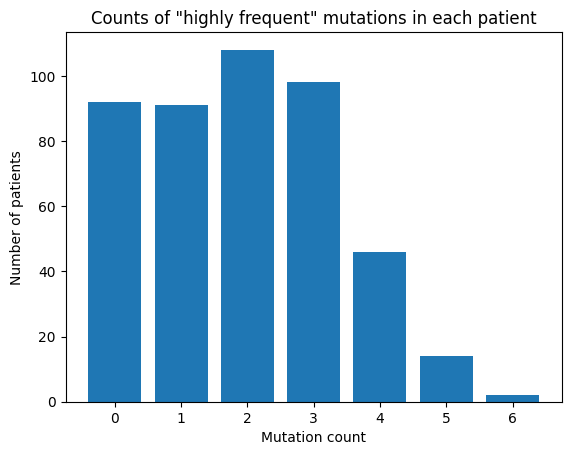

In [14]:
import matplotlib.pyplot as plt
from collections import Counter
mutation_counter = Counter(feature_set_1_table.sum(1))
mutation_counts_sorted = list(sorted(mutation_counter.keys()))
mutation_counts_heights = list(mutation_counter[x] for x in mutation_counts_sorted)
plt.bar(mutation_counts_sorted, mutation_counts_heights)
plt.title('Counts of "highly frequent" mutations in each patient')
plt.xlabel('Mutation count')
plt.ylabel('Number of patients')

In [15]:
feature_set_1_table.sum(0)

TET2       50.0
STAG2      22.0
RUNX1      48.0
EZH2       16.0
JAK2       14.0
FLT3      122.0
SF3B1      21.0
GATA2      15.0
WT1        34.0
CEBPA      28.0
NPM1       82.0
KRAS       19.0
IDH1       34.0
BCOR       25.0
TP53       35.0
ASXL1      31.0
DNMT3A     85.0
U2AF1      18.0
PTPN11     22.0
SRSF2      43.0
NRAS       60.0
IDH2       43.0
dtype: float64

### Mutation Feature Set 2

In [16]:
# mutation features 2: allele frequencies of specific mutations
variant_alleles = ['FLT3p.A680V', 'FLT3p.I836del', 'FLT3p.D835Y', 'FLT3p.D835H', 'NRASp.G13D', 'NRASp.Q61H', 'NRASp.Q61K', 'NRASp.G13R', 'NRASp.G12D', 'KRASp.G12D', 'U2AF1p.S34F', 'U2AF1p.Q157P', 'DNMT3Ap.R882H', 'DNMT3Ap.R882C', 'IDH2p.R172K', 'IDH2p.R140Q', 'IDH1p.R132H', 'IDH1p.R132C', 'ASXL1p.G646Wfs*12', 'ASXL1p.G645Vfs*58', 'SF3B1p.K666N', 'SF3B1p.K700E', 'NPM1p.W288Cfs*12', 'JAK2p.V617F', 'SRSF2p.P95H', 'SRSF2p.P95L', 'SRSF2p.P95R', 'SRSF2p.P95_R102del']

In [17]:
alleles_to_indices = {x: i for i, x in enumerate(variant_alleles)}
label_alleles = {}
for i, row in mutations.iterrows():
    allele_name = row.symbol + str(row.short_aa_change)
    if allele_name in alleles_to_indices:
        patient_id = row['labId']
        if patient_id in label_alleles:
            patient_alleles = label_alleles[patient_id]
            patient_alleles[alleles_to_indices[allele_name]] = row['t_vaf']
        else:
            label_alleles[patient_id] = np.zeros(len(alleles_to_indices))
            label_alleles[patient_id][alleles_to_indices[allele_name]] = 1

In [18]:
# convert this to a numpy array indexed by patient
data_rows_alleles = []
sample_ids = rpkm_t.index[2:]
for sample in sample_ids:
    if sample not in label_alleles:
        row = np.zeros(len(alleles_to_indices))
    else:
        row = label_alleles[sample]
    data_rows_alleles.append(row)
data_rows_alleles = np.array(data_rows_alleles)
feature_set_2_table = pd.DataFrame(data_rows_alleles)
feature_set_2_table.index = sample_ids
feature_set_2_table.columns = variant_alleles

In [19]:
feature_set_2_table.sum(0)

FLT3p.A680V            0.340244
FLT3p.I836del          5.000000
FLT3p.D835Y            6.532272
FLT3p.D835H            3.694239
NRASp.G13D             6.952980
NRASp.Q61H             3.309897
NRASp.Q61K             4.972622
NRASp.G13R             1.028823
NRASp.G12D             8.032205
KRASp.G12D             1.766528
U2AF1p.S34F            5.550447
U2AF1p.Q157P           1.720118
DNMT3Ap.R882H         16.445213
DNMT3Ap.R882C         10.845864
IDH2p.R172K            2.528017
IDH2p.R140Q           17.876668
IDH1p.R132H            3.996335
IDH1p.R132C            6.512551
ASXL1p.G646Wfs*12      6.736439
ASXL1p.G645Vfs*58      5.225000
SF3B1p.K666N           5.710010
SF3B1p.K700E           3.179560
NPM1p.W288Cfs*12      41.167174
JAK2p.V617F            7.443407
SRSF2p.P95H           11.614796
SRSF2p.P95L            4.183417
SRSF2p.P95R            2.770658
SRSF2p.P95_R102del     4.399510
dtype: float64

In [20]:
feature_set_2_table.sum(1)

12-00023    0.000000
12-00051    0.000000
12-00066    0.000000
12-00150    0.000000
12-00211    0.000000
              ...   
16-01237    1.000000
16-01254    1.141107
16-01262    0.000000
16-01270    0.000000
16-01272    0.000000
Length: 451, dtype: float64

## 3. Filtering the RPKM matrix

We want to include only the genes with positive RPKM values on at least half the samples.

In [21]:
sample_ids = rpkm_t.index[2:]
rpkm_filtered = rpkm_t.iloc[2:, :]

In [22]:
rpkm_to_include = (rpkm_filtered > 0).sum(0) > rpkm_filtered.shape[0]*0.5

In [23]:
rpkm_filtered = rpkm_filtered.loc[:, rpkm_to_include]
included_genes = gene_names[rpkm_to_include]

In [24]:
included_genes

Gene
ENSG00000000419             DPM1
ENSG00000000457            SCYL3
ENSG00000000460         C1orf112
ENSG00000000938              FGR
ENSG00000000971              CFH
                       ...      
ENSG00000273464    RP11-313P22.1
ENSG00000273466     RP11-548H3.1
ENSG00000273477    RP11-196O16.1
ENSG00000273486    RP11-731C17.2
ENSG00000273488     RP11-114I8.4
Name: Symbol, Length: 17691, dtype: object

In [25]:
rpkm_filtered

Gene     ENSG00000000419 ENSG00000000457 ENSG00000000460 ENSG00000000938  \
12-00023        6.886609        3.817626        2.437114       10.131911   
12-00051        6.438417        3.987133        1.862662        5.014124   
12-00066        6.554495        3.207921         3.36836       10.139119   
12-00150        6.852558         3.87823        3.332284        5.941063   
12-00211        6.613863        4.528385        2.984168        7.274613   
...                  ...             ...             ...             ...   
16-01237        7.545959        3.148649        2.645294        6.857559   
16-01254        6.882087        4.077574        3.115359       10.782979   
16-01262        7.331555         3.73462         2.98067        6.045946   
16-01270        6.254707        3.811903        2.670554        6.383498   
16-01272        6.641892        3.235035        3.341608        9.366073   

Gene     ENSG00000000971 ENSG00000001036 ENSG00000001084 ENSG00000001167  \
12-00023        1.808987        6.629013        4.506795        6.311961   
12-00051        0.979265        5.681544        4.660312        4.850069   
12-00066        2.148488        6.223989        4.912694         6.29028   
12-00150        2.953542        6.995513        4.746799        5.320093   
12-00211        0.786802        6.506518        5.154787        6.552361   
...                  ...             ...             ...             ...   
16-01237        -0.81369        5.150915        4.283219        6.223989   
16-01254        0.041994        6.072984        4.413523        6.468756   
16-01262        4.284379        6.271382        3.452191        6.456985   
16-01270       -1.710826        6.434858        4.699056         6.06159   
16-01272        1.288293        6.661766        4.885147        5.930867   

Gene     ENSG00000001460 ENSG00000001461  ... ENSG00000273437 ENSG00000273447  \
12-00023        1.305681        4.512906  ...        0.590811        1.239903   
12-00051        0.873389        3.896187  ...        0.227771       -1.533375   
12-00066        1.475002         4.03124  ...        0.419728        1.120049   
12-00150        2.825116        3.876903  ...       -0.880786       -2.213748   
12-00211        2.044008        5.092842  ...        1.115146       -0.783358   
...                  ...             ...  ...             ...             ...   
16-01237       -0.824904        3.019656  ...        -2.08276       -1.644746   
16-01254        1.922086        4.354655  ...        1.667458       -1.096109   
16-01262        3.265618        5.611339  ...        0.774498        2.389366   
16-01270        0.528877        2.976729  ...        0.834133       -2.143176   
16-01272        2.033784        4.093178  ...       -1.901382        1.066797   

Gene     ENSG00000273448 ENSG00000273449 ENSG00000273456 ENSG00000273464  \
12-00023        2.015624         1.75039        1.924608        0.064702   
12-00051        1.644835        0.274336       -1.344744       -1.374691   
12-00066        0.525473        1.954098       -0.537617        0.477504   
12-00150       -0.369948        0.405597        1.748546        0.010213   
12-00211        3.189498        2.809881        1.015917        0.566154   
...                  ...             ...             ...             ...   
16-01237        0.605558       -1.033936        2.971669       -0.374975   
16-01254        1.771565        2.552042        1.538641       -2.726305   
16-01262        1.761583        3.292994        3.307611        0.145147   
16-01270        4.008076        3.678939        2.676831       -1.033936   
16-01272       -0.507241       -2.209391         1.90937       -1.581195   

Gene     ENSG00000273466 ENSG00000273477 ENSG00000273486 ENSG00000273488  
12-00023        3.240346       -0.219722        2.230568        0.279923  
12-00051        4.051967        0.676291        1.029501        2.397719  
12-00066        3.030349        0.518714        2.683986       

### Normal-scaling the RPKM matrix

In [26]:
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error, r2_score

scaler = StandardScaler()
X_scaled = scaler.fit_transform(rpkm_filtered.values)

import pickle
with open('models/rpkm_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [27]:
X_scaled.shape

(451, 17691)

In [28]:
rpkm_scaled_filtered = rpkm_filtered
rpkm_scaled_filtered.loc[:] = X_scaled
rpkm_scaled_filtered.is_copy = False

In [126]:
rpkm_scaled_filtered.mean(0)

Gene
ENSG00000000419   -4.352025e-15
ENSG00000000457   -5.514190e-17
ENSG00000000460    2.351408e-15
ENSG00000000938    2.220692e-15
ENSG00000000971   -5.940062e-16
                       ...     
ENSG00000273464    1.723184e-17
ENSG00000273466   -3.910213e-15
ENSG00000273477    3.543605e-16
ENSG00000273486   -2.215523e-16
ENSG00000273488    6.117304e-16
Length: 17691, dtype: float64

In [127]:
rpkm_scaled_filtered.std(0)

Gene
ENSG00000000419    1.00111
ENSG00000000457    1.00111
ENSG00000000460    1.00111
ENSG00000000938    1.00111
ENSG00000000971    1.00111
                    ...   
ENSG00000273464    1.00111
ENSG00000273466    1.00111
ENSG00000273477    1.00111
ENSG00000273486    1.00111
ENSG00000273488    1.00111
Length: 17691, dtype: float64

## Feature set 4 - graph features

TODO: look in Step6 code, download knowledge graphs

TODO: try to use the features selected in the previous models (features selected from the classification models)

In [30]:
KG_reg = pd.read_csv("data/KG_regulatory_graph_Mar1_2023.csv", index_col=0)

In [31]:
KG_reg.index = KG_reg.Target_gene

In [32]:
drug_coefficients = pd.read_csv('data/Supplemental_2_KG_Expr_drug_lasso_Coef_features_over0_gt50p.csv', index_col=0)

In [33]:
drugs = drug_data.inhibitor.unique()

In [34]:
drug_coefficients

Drug                Gene              Symbol        coef Method  \
0       CYT387     ENSG00000038382                TRIO   -0.006071  Lasso   
1       CYT387     ENSG00000042980              ADAM28   -0.008872  Lasso   
2       CYT387     ENSG00000100139             MICALL1    0.037869  Lasso   
3       CYT387     ENSG00000102805                CLN5    0.066814  Lasso   
4       CYT387     ENSG00000106799              TGFBR1    0.003103  Lasso   
...        ...                 ...                 ...         ...    ...   
6796  KU-55933     ENSG00000268895            A1BG-AS1    0.012543  Lasso   
6797  KU-55933     ENSG00000269337          AL591479.1    0.008351  Lasso   
6798  KU-55933     ENSG00000273142        RP11-458F8.4   -0.124586  Lasso   
6799  KU-55933        KU-55933_RSS        KU-55933_RSS  165.998444  Lasso   
6800  KU-55933  KU-55933_intercept  KU-55933_intercept    0.001958  Lasso   

      Dataset  
0     BeatAML  
1     BeatAML  
2     BeatAML  
3     BeatAML  
4     BeatAML  
...       ...  
6796  BeatAML  
6797  BeatAML  
6798  BeatAML  
6799  BeatAML  
6800  BeatAML  

[6801 rows x 6 columns]

In [35]:
from kgfe import gene_names
def generate_drug_graph_features(drugs, expression, KG_reg, drug_coefficients, housekeeping_genes):
    """
    Args:
        drugs - a list of drug names
        expression - a gene expression table, with genes on axis 0 and samples on axis 1
        KG_reg: regulatory knowledge graph
        drug_coefficients:
        housekeeping_genes: a list of housekeeping gene names
    
    Returns:
        drug_data_outputs: a dict of drug name to pandas dataframe
    """
    drug_data_outputs = {}
    housekeeping_genes_ensembl = gene_names.convert('symbol', 'ensembl', housekeeping_genes)
    temp_expression = expression.iloc[:, 2:]
    housekeeping_gene_expression = temp_expression.loc[housekeeping_genes_ensembl]
    for drug in drugs:
        coefficients = drug_coefficients[drug_coefficients['Drug'] == drug]
        output_features = []
        print(drug, len(coefficients), 'gene coefficients')
        feature_names = []
        for _, row in coefficients.iterrows():
            gene = row['Gene']
            symbol = row['Symbol']
            if gene in temp_expression.index:
                expression_data = temp_expression.loc[gene]
                # generate features for regulatory genes
                if gene in KG_reg.index:
                    regulators = KG_reg.loc[gene]
                    # only include negative regulators?
                    regulators = regulators[regulators.Coef < 0]
                    for reg_gene in regulators.Regulator:
                        try:
                            reg_gene_ensembl = gene_names.convert('symbol', 'ensembl', [reg_gene])[0]
                            reg_expr = temp_expression.loc[reg_gene_ensembl]
                            ratios = expression_data/reg_expr
                            ratios[ratios >= 1] = 1
                            ratios[ratios < 1] = 0
                            feature_names.append(symbol + '_' + reg_gene)
                            output_features.append(ratios)
                        except:
                            pass
                # generate features for housekeeping genes
                for h_gene_symbol, h_gene in zip(housekeeping_genes, housekeeping_genes_ensembl):
                    h_gene_expr = housekeeping_gene_expression.loc[h_gene]
                    ratios = expression_data/h_gene_expr
                    ratios[ratios >= 1] = 1
                    ratios[ratios < 1] = 0
                    feature_names.append(symbol + '_' + h_gene_symbol)
                    output_features.append(ratios)
        print('features:', len(feature_names))
        drug_data_outputs[drug] = pd.concat(output_features, axis=1)
        drug_data_outputs[drug].columns = feature_names
    return drug_data_outputs

In [36]:
%time drugs_feature4 = generate_drug_graph_features(drugs, rpkm, KG_reg, drug_coefficients, housekeeping_genes)

17-AAG (Tanespimycin) 62 gene coefficients
features: 1186
A-674563 60 gene coefficients
features: 1093
ABT-737 55 gene coefficients
features: 996
AT7519 57 gene coefficients
features: 1008
AZD1480 57 gene coefficients
features: 1009
Afatinib (BIBW-2992) 51 gene coefficients
features: 925
Alisertib (MLN8237) 44 gene coefficients
features: 781
Axitinib (AG-013736) 60 gene coefficients
features: 1111
BEZ235 50 gene coefficients
features: 869
BI-2536 58 gene coefficients
features: 1029
BMS-345541 52 gene coefficients
features: 907
Barasertib (AZD1152-HQPA) 49 gene coefficients
features: 907
Bay 11-7085 58 gene coefficients
features: 1039
Bortezomib (Velcade) 64 gene coefficients
features: 1143
Bosutinib (SKI-606) 55 gene coefficients
features: 978
CHIR-99021 52 gene coefficients
features: 941
CI-1040 (PD184352) 59 gene coefficients
features: 1063
CYT387 64 gene coefficients
features: 1130
Cabozantinib 57 gene coefficients
features: 1082
Canertinib (CI-1033) 59 gene coefficients
features: 1

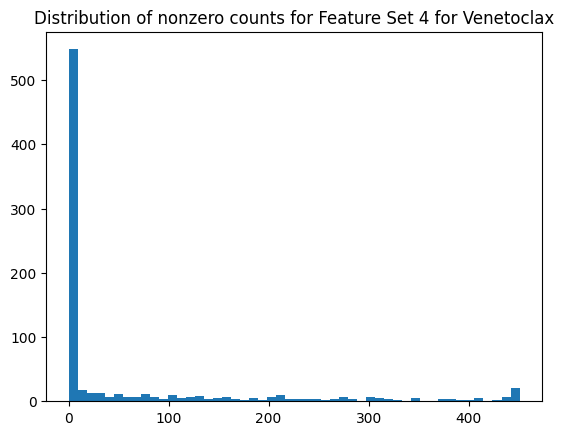

In [37]:
import matplotlib.pyplot as plt
plt.hist(drugs_feature4['Venetoclax'].sum(0), bins=50)
plt.title('Distribution of nonzero counts for Feature Set 4 for Venetoclax')
plt.savefig('nonzero_counts.png')

Is it a problem that most of the features are zero for every sample? Well, maybe, maybe not. It means that most of the features aren't very useful. But hopefully there are enough features that *are* useful?

## 4. Run machine learning

### Analysis functions

In [38]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score
import pickle # for saving models
import os

def run_analyses(X, analyses, dependent_vars, 
                 model, return_params=False, labels=None,
                 use_random_search=False,
                 save_models=False,
                 save_model_prefix=''):
    """
    Args:
        X - input data
        analyses - list of string (names of the analyses) - drugs in this case
        dependent_var - list of arrays (things to test)
        model - a scikit-learn model
        
        return_params - whether or not to return the model parameters for each CV run. only for linear models.
        labels - list or array of labels for each of the covariates (required when saving the model parameters)
        use_random_search - whether or not to use random parameter search
    
        save_models - whether or not to save all of the models.
        save_model_prefix - filename prefix for the models (could include a path).
        
    Returns: all_cv_scores (list of validation r^2 scores), df (table of parameters
    """
    all_cv_scores = []
    all_train_cv_scores = []
    cv = KFold(5, shuffle=True, random_state=0)
    weights_results = []
    predicted_values = []
    predicted_r2_values = []
    for analysis, var in zip(analyses, dependent_vars):
        cv_score = []
        train_cv_score = []
        included_subset = (~np.isnan(var))
        X_new = X[included_subset]
        var = var[included_subset]
        predicted_values_analysis = np.zeros(var.shape)
        if return_params:
            cv_score = []
            cv_round = 0
            for train_index, test_index in cv.split(X_new, var):
                filename = save_model_prefix + '_' + analysis + '_fold' + str(cv_round) + '.pkl'
                model_exists = os.path.exists(filename)
                if model_exists:
                    with open(filename, 'rb') as f:
                        model = pickle.load(f)
                else:
                    if use_random_search:
                        cv_model = rf_grid_search(model, X_new[train_index], var[train_index])
                        model = cv_model.best_estimator_
                    else:
                        model.fit(X_new[train_index], var[train_index])
                if hasattr(model, 'coef_'):
                    weights = list(model.coef_)
                elif hasattr(model, 'feature_importances_'):
                    weights = list(model.feature_importances_)
                if hasattr(model, 'intercept_'):
                    weights.append(model.intercept_)
                if hasattr(model, 'alpha'):
                    weights.append(model.alpha)
                elif hasattr(model, 'alpha_'):
                    weights.append(model.alpha_)
                if use_random_search:
                    for k in sorted(param_distributions.keys()):
                        weights.append(model.__dict__[k])
                weights.append(analysis)
                predictions = model.predict(X_new[test_index])
                predicted_values_analysis[test_index] = predictions
                score = r2_score(var[test_index], predictions)
                train_pred = model.predict(X_new[train_index])
                score_train = r2_score(var[train_index], train_pred)
                train_cv_score.append(score_train)
                weights.append(score_train)
                weights.append(score)
                cv_score.append(score)
                weights_results.append(weights)
                if save_models and not model_exists:
                    with open(filename, 'wb') as f:
                        pickle.dump(model, f)
                cv_round += 1
            all_cv_scores.append(cv_score)
            all_train_cv_scores.append(train_cv_score)
            predicted_r2_values.append(r2_score(var, predicted_values_analysis))
            predicted_values.append(predicted_values_analysis)
            print(analysis)
            print('train r^2 scores:', train_cv_score, np.mean(train_cv_score))
            print('test r^2 scores:', cv_score, np.mean(cv_score))
            print('total r^2: ', predicted_r2_values[-1])
        else:
            cv_score = cross_val_score(model, X_new, var, cv=cv, scoring='r2')
            all_cv_scores.append(cv_score)
            print(analysis, cv_score, np.mean(cv_score))
    if return_params:
        columns = list(labels)
        if hasattr(model, 'intercept_'):
            columns.append('intercept')
        if hasattr(model, 'alpha') or hasattr(model, 'alpha_'):
            columns.append('alpha')
        if use_random_search:
            for k in sorted(param_distributions.keys()):
                columns.append(k)
        df = pd.DataFrame(weights_results, columns=columns + ['target', 'r2_score_train', 'r2_score_test'])
        return all_cv_scores, df
    else:
        return all_cv_scores

In [39]:
def run_analyses_feature4(X_analyses, analyses, dependent_vars, 
                 model, return_params=False, labels=None,
                 use_random_search=False,
                 save_models=False,
                 save_model_prefix=''):
    """
    Same as above, but there's a different data matrix for each drug.
    
    Args:
        X_analyses - input data; dict of drug name to data matrix, or a function that takes in the analysis name and returns a np array
        analyses - list of string (names of the analyses) - drugs in this case
        dependent_var - list of arrays (things to test)
        model - a scikit-learn model
        
        return_params - whether or not to return the model parameters for each CV run. only for linear models.
        labels - list or array of labels for each of the covariates
            (required when saving the model parameters - only necessary if X_analyses does not return a dataframe)
        use_random_search - whether or not to use random parameter search
    
        save_models - whether or not to save all of the models.
        save_model_prefix - filename prefix for the models (could include a path).
    """
    all_cv_scores = []
    all_train_cv_scores = []
    cv = KFold(5, shuffle=True, random_state=0)
    predicted_values = []
    predicted_r2_values = []
    dfs = {}
    for analysis, var in zip(analyses, dependent_vars):
        weights_results = []
        cv_score = []
        train_cv_score = []
        included_subset = (~np.isnan(var))
        if callable(X_analyses):
            X_new = X_analyses(analysis)
        else:
            X_new = X_analyses[analysis]
        # if X_new is a pd dataframe, convert it to an NP array
        if isinstance(X_new, pd.DataFrame):
            column_names = X_new.columns
            X_new = X_new.to_numpy()
        else:
            column_names = labels
        X_new = X_new[included_subset]
        var = var[included_subset]
        predicted_values_analysis = np.zeros(var.shape)
        if return_params:
            cv_score = []
            cv_round = 0
            for train_index, test_index in cv.split(X_new, var):
                filename = save_model_prefix + '_' + analysis + '_fold' + str(cv_round) + '.pkl'
                model_exists = os.path.exists(filename)
                if model_exists:
                    with open(filename, 'rb') as f:
                        model = pickle.load(f)
                else:
                    if use_random_search:
                        cv_model = rf_grid_search(model, X_new[train_index], var[train_index])
                        model = cv_model.best_estimator_
                    else:
                        model.fit(X_new[train_index], var[train_index])
                if hasattr(model, 'coef_'):
                    weights = list(model.coef_)
                elif hasattr(model, 'feature_importances_'):
                    weights = list(model.feature_importances_)
                if hasattr(model, 'intercept_'):
                    weights.append(model.intercept_)
                if hasattr(model, 'alpha'):
                    weights.append(model.alpha)
                elif hasattr(model, 'alpha_'):
                    weights.append(model.alpha_)
                if use_random_search:
                    for k in sorted(param_distributions.keys()):
                        weights.append(model.__dict__[k])
                weights.append(analysis)
                predictions = model.predict(X_new[test_index])
                predicted_values_analysis[test_index] = predictions
                score = r2_score(var[test_index], predictions)
                train_pred = model.predict(X_new[train_index])
                score_train = r2_score(var[train_index], train_pred)
                train_cv_score.append(score_train)
                weights.append(score_train)
                weights.append(score)
                cv_score.append(score)
                weights_results.append(weights)
                if save_models and not model_exists:
                    with open(filename, 'wb') as f:
                        pickle.dump(model, f)
                cv_round += 1
            all_cv_scores.append(cv_score)
            all_train_cv_scores.append(train_cv_score)
            predicted_r2_values.append(r2_score(var, predicted_values_analysis))
            predicted_values.append(predicted_values_analysis)
            print(analysis)
            print('train r^2 scores:', train_cv_score, np.mean(train_cv_score))
            print('test r^2 scores:', cv_score, np.mean(cv_score))
            print('total r^2: ', predicted_r2_values[-1])
            # return dataframes
            columns = list(column_names)
            if hasattr(model, 'intercept_'):
                columns.append('intercept')
            if hasattr(model, 'alpha') or hasattr(model, 'alpha_'):
                columns.append('alpha')
            if use_random_search:
                for k in sorted(param_distributions.keys()):
                    columns.append(k)
            df = pd.DataFrame(weights_results, columns=columns + ['target', 'r2_score_train', 'r2_score_test'])
            dfs[analysis] = df
        else:
            cv_score = cross_val_score(model, X_new, var, cv=cv, scoring='r2')
            all_cv_scores.append(cv_score)
            print(analysis, cv_score, np.mean(cv_score))
    if return_params:
        return all_cv_scores, dfs
    else:
        return all_cv_scores

### Building the test set

In [40]:
drugs = drug_data.inhibitor.unique()

In [41]:
dependent_vars = []
for drug in drugs:
    drug_subset = drug_data[drug_data.inhibitor==drug]
    drug_subset.index = drug_subset.lab_id
    drug_auc_vals = []
    for s in sample_ids:
        try:
            d = drug_subset.loc[s]
            drug_auc_vals.append(d.auc)
        except:
            drug_auc_vals.append(np.nan)
    dependent_vars.append(np.array(drug_auc_vals))

### Feature set 1

In [42]:
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor

import xgboost


In [43]:
X = feature_set_1_table.to_numpy()

In [44]:
model1 = LassoCV(tol=0.1, selection='random', precompute=True, verbose=False)
f1_r2, f1_coef = run_analyses(X, drugs, dependent_vars,
                              model1,
                              return_params=True,
                              labels=feature_set_1_table.columns,
                              save_models=True,
                              save_model_prefix='models/feature1/f1_lassocv')

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

17-AAG (Tanespimycin)
train r^2 scores: [0.1937693998169262, 0.1542257364001779, 0.17842317024638776, 0.1785380687414876, 0.20643208757734022] 0.18227769255646392
test r^2 scores: [0.12338458796907326, 0.11691296143680008, 0.19155957227524045, 0.14391272273445133, 0.11718412808072654] 0.13859079449925832
total r^2:  0.14422257650874715
A-674563
train r^2 scores: [0.17592962477314067, 0.08970186142351977, 0.1453253208429447, 0.09497919408803568, 0.11857170278553408] 0.12490154078263498
test r^2 scores: [0.04711734869062745, 0.11735045178249814, 0.07452680267234124, 0.09830401956171797, 0.03872582327707297] 0.07520488919685156
total r^2:  0.0824613387331643
ABT-737
train r^2 scores: [0.0, 0.0, 0.0, 0.007958390630473544, 0.03422128110431044] 0.008435934346956797
test r^2 scores: [-0.03694513776470809, -0.01460826850225505, -0.0008302196847116416, -0.04130382181018066, -0.09378231447367003] -0.03749395244710509
total r^2:  -0.014579093242443886
AT7519
train r^2 scores: [0.01376495581807313

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Afatinib (BIBW-2992)
train r^2 scores: [0.12307831485469667, 0.0, 0.0, 0.12506320677734006, 0.0] 0.049628304326407344
test r^2 scores: [-0.16885334912228944, -0.08002383275301828, -0.0005632214869910612, -0.25874025602883144, -0.002667942974081461] -0.10216972047304233
total r^2:  -0.0611777741058559
Alisertib (MLN8237)
train r^2 scores: [0.0, 0.02803211544352835, 0.04599250799569443, 0.0, 0.0742422872987385] 0.029653382147592257
test r^2 scores: [-0.010452746864752172, -0.014040988310915603, -0.037315594054265544, -0.013638108042789199, -0.0827214893007735] -0.0316337853146992
total r^2:  -0.0204927598392739
Axitinib (AG-013736)
train r^2 scores: [0.03944400245648838, 0.08038217416308535, 0.06798227872738927, 0.0734441738106626, 0.04123088750232162] 0.06049670333198944
test r^2 scores: [0.05649484240923164, 0.0065225109651433355, 0.014074774631776754, 0.0036130341050130133, -0.005123216018886545] 0.01511638921845564
total r^2:  0.026744118417488694
BEZ235
train r^2 scores: [0.08836133

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

CYT387
train r^2 scores: [0.1157099598356609, 0.08971928436439958, 0.0417184501093224, 0.0, 0.033765834372334824] 0.05618270573634354
test r^2 scores: [-0.057730215100638915, -0.06488483095535713, 0.021212696381104235, -0.1401361809372499, 0.03611341797237999] -0.04108502252795234
total r^2:  -0.022651244410715865
Cabozantinib
train r^2 scores: [0.2987786561366962, 0.29354855330496665, 0.3492525132359773, 0.32668302882583156, 0.24172354865421086] 0.3019972600315365
test r^2 scores: [0.2685010423359807, 0.3330955291549471, 0.0432966409270068, 0.11719572653126265, 0.28303449306548023] 0.20902468640293553
total r^2:  0.2246163091631328
Canertinib (CI-1033)
train r^2 scores: [0.041251946493307656, 0.039090918429736665, 0.05339577945511753, 0.04513310825076422, 0.024382106715336027] 0.04065077186885242
test r^2 scores: [0.0012492474908061268, 0.026284532364794777, 0.018409176657460113, 0.05076582220444714, 0.039051778781053814] 0.027152111499712396
total r^2:  0.030014338404226626
Cediranib

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Doramapimod (BIRB 796)
train r^2 scores: [0.08177682618863613, 0.08197953697067362, 0.0476758496464702, 0.07567866266117074, 0.0] 0.057422175093390135
test r^2 scores: [-0.11000046234844585, -0.025149183566470112, -0.029704070740232957, -0.1566313147835927, -0.00025625169725307373] -0.06434825662719894
total r^2:  -0.03591517614536599
Dovitinib (CHIR-258)
train r^2 scores: [0.27355973776420595, 0.26022330987808073, 0.2585015873934404, 0.20787420314236038, 0.23898735322060227] 0.24782923827973793
test r^2 scores: [0.1634955949468614, 0.13494879490781508, 0.23394716433621265, 0.09679677678455523, 0.23736220952051756] 0.1733101080991924
total r^2:  0.17837471301976593
Elesclomol
train r^2 scores: [0.097487115925041, 0.0, 0.15292036637725748, 0.0, 0.051654974478953175] 0.060412491356250334
test r^2 scores: [-0.15516828895173873, -0.03213151344468357, -0.09218764295202186, -0.009242314550039543, 0.03689128059726621] -0.0503676958602435
total r^2:  -0.02228537287938126
Entospletinib (GS-9973

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

KU-55933
train r^2 scores: [0.11690756284914416, 0.1349968282842794, 0.10016220739096737, 0.10284470597973905, 0.08899093551803994] 0.10878044800443398
test r^2 scores: [0.009678557793300624, 0.013830721037883409, 0.06456307574981124, -0.007604840356419285, 0.04953610082418192] 0.02600072300975158
total r^2:  0.029032222868600743
KW-2449
train r^2 scores: [0.3051080933259769, 0.30703694851305674, 0.32031093430785584, 0.2746164200660153, 0.28524279738166347] 0.29846303871891366
test r^2 scores: [0.25203811242903373, 0.26946148519694324, 0.23294999819974627, 0.07675095900491691, 0.3163776061585749] 0.22951563219784302
total r^2:  0.2212107857997212
LY-333531
train r^2 scores: [0.13496385881919937, 0.23351632584401005, 0.20943406055489222, 0.24300163759371174, 0.2642924130210018] 0.21704165916656307
test r^2 scores: [0.2319336901887512, 0.09165558260793327, 0.11805558534214478, 0.10325852190717599, -0.13804457293781258] 0.08137176142163853
total r^2:  0.11294941366266709
Lapatinib
train r

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Palbociclib
train r^2 scores: [0.31988487962348877, 0.2073190454563717, 0.197730851662144, 0.23581955424610357, 0.26107292047523745] 0.2443654502926691
test r^2 scores: [-0.2102756943044919, 0.1534736595517413, 0.01650223594561906, 0.17916250162192182, 0.19598591235767837] 0.06696972303449374
total r^2:  0.07260001488957057
Panobinostat
train r^2 scores: [0.05663940771236986, 0.02415695439473886, 0.0, 0.06875418121763799, 0.1806139435668217] 0.06603289737831368
test r^2 scores: [0.007887184625063659, 0.016815916562922917, -0.0015942759805973594, 0.038830010590434005, -0.062475661490115186] -0.0001073651384583929
total r^2:  0.004883059466887274
Pazopanib (GW786034)
train r^2 scores: [0.12460500782462614, 0.18550871311642625, 0.18465046368548987, 0.1602619179496706, 0.1837306374422697] 0.1677513480036965
test r^2 scores: [0.16615262752060544, -0.06598814532816077, 0.07158509011606173, 0.15320227930064423, 0.14624435454103157] 0.09423924123003644
total r^2:  0.12708939300575606
Pelitinib

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vargetef
train r^2 scores: [0.2114495282205454, 0.19084459052900493, 0.24830180844301097, 0.1934974114752418, 0.18265418351391316] 0.20534950443634328
test r^2 scores: [0.1838335724536979, 0.029034039387197175, 0.030658374444013425, 0.10672488873745878, 0.05966051964192243] 0.08198227893285795
total r^2:  0.0949015252293417
Vatalanib (PTK787)
train r^2 scores: [0.0819907756922027, 0.101451696211734, 0.14010969525410266, 0.09056037120342464, 0.07932149153272505] 0.0986868059788378
test r^2 scores: [0.02712481203596273, -0.030605623904446988, -0.015756258333411433, 0.04246414882456495, 0.09741316809821288] 0.02412804934417643
total r^2:  0.02872514314264385
Vemurafenib (PLX-4032)
train r^2 scores: [0.12875921376563326, 0.1223946511984263, 0.19825862118066706, 0.08702746783094506, 0.19552719683239905] 0.14639343016161416
test r^2 scores: [0.04776171833574483, 0.2481729510240619, 0.018398473828826645, 0.0793597587178061, 0.04335794975940399] 0.0874101703331687
total r^2:  0.070268386630204

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

In [45]:
f1_coef['model'] = 'lassocv'
f1_coef.to_csv('results/feature1_lassocv_coefs.csv', index=None)

### Feature set 2

In [46]:
X = feature_set_2_table.to_numpy()
model1 = LassoCV(tol=0.1, selection='random', precompute=True, verbose=False)
f2_r2, f2_coef = run_analyses(X, drugs, dependent_vars,
                              model1,
                              return_params=True,
                              labels=feature_set_2_table.columns,
                              save_models=True,
                              save_model_prefix='models/feature2/f2_lassocv')

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

17-AAG (Tanespimycin)
train r^2 scores: [0.1779323459405413, 0.0, 0.0, 0.1284606836944776, 0.0] 0.06127860592700378
test r^2 scores: [-0.12056222131154004, -0.04158750883764606, -0.008283429828967348, -0.07446345708992896, -0.0024995435444843395] -0.04947923212251335
total r^2:  -0.047227284221098564
A-674563
train r^2 scores: [0.03132075144242352, 0.026851241871599596, 0.07723678687158364, 0.058873839829520325, 0.0647042056897007] 0.05179736514096556
test r^2 scores: [0.06233100805319036, 0.04492788328493702, 5.265491214356821e-05, -0.048466178770824486, -0.06826989899935798] -0.0018849063039823033
total r^2:  0.009578906119612873


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

ABT-737
train r^2 scores: [0.0, 0.0, 0.0, 0.0, 0.0] 0.0
test r^2 scores: [-0.03694513776470809, -0.01460826850225505, -0.0008302196847116416, -0.04033820666681831, -0.0731076170708751] -0.03316588993787364
total r^2:  -0.010933765136582174
AT7519
train r^2 scores: [0.0, 0.0, 0.0, 0.0, 0.025710960973848507] 0.0051421921947697015
test r^2 scores: [-0.01728544232392415, -0.00019806758018603432, -0.029708740871988493, -2.633602161905557e-06, -0.08136696049918868] -0.02571236897548985
total r^2:  -0.012505368065105937
AZD1480
train r^2 scores: [0.11281871528450105, 0.0, 0.08999966370813273, 0.0, 0.0] 0.04056367579852675
test r^2 scores: [-0.07908037756657715, -0.011806889988414282, -0.02359441113982541, -0.005593642234877461, -0.027500927370479378] -0.029515249660034736
total r^2:  -0.025567028098085975
Afatinib (BIBW-2992)
train r^2 scores: [0.0, 0.0179828131158698, 0.0170786159638735, 0.024233014211544, 0.012585483811379472] 0.014375985420533356
test r^2 scores: [-0.0001106256244507442, -

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Entospletinib (GS-9973)
train r^2 scores: [0.22204572602128503, 0.0903217475772824, 0.15843617583630842, 0.17179913647146516, 0.20484700863135308] 0.16948995890753882
test r^2 scores: [0.0637209786868036, 0.00037940194104857383, 0.10369282160610516, 0.019471904967074183, -0.04999815501158311] 0.02745339043788968
total r^2:  0.03916055273551655
Entrectinib
train r^2 scores: [0.0, 0.0, 0.0, 0.0, 0.0] 0.0
test r^2 scores: [-0.11468338788295718, -0.049601498596214766, -0.10667200298776702, -0.002286272150549662, -0.003544853841048301] -0.05535760309170738
total r^2:  -0.01670970440950903
Erlotinib
train r^2 scores: [0.1540034202656, 0.09536825652823178, 0.16345112377480397, 0.1583472792794105, 0.13961130506497288] 0.14215627698260383
test r^2 scores: [0.06938982375865077, 0.10274213055053039, -0.10054325975703549, 0.09891590402407846, 0.007755797691214372] 0.0356520792534877
total r^2:  0.04760171682164138
Flavopiridol
train r^2 scores: [0.026677107457368066, 0.0, 0.0, 0.0, 0.0] 0.00533542

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

MK-2206
train r^2 scores: [0.0, 0.011001645148998151, 0.014065849337807967, 0.0, 0.0] 0.0050134988973612234
test r^2 scores: [-0.09202512017586995, -0.012473282285833776, -0.004267469442286176, -0.018159623982237028, -0.030735702721988778] -0.03153223972164314
total r^2:  -0.013978626689759688
MLN120B
train r^2 scores: [0.026783919109875653, 0.0047351110535212015, 0.008844385216386974, 0.00986884444444025, 0.02036546087146407] 0.01411954413913763
test r^2 scores: [0.00029167513242800425, 0.0010373222034202323, 0.001365338514787262, -0.01336864669242499, -0.03197375870017094] -0.008529613908392086
total r^2:  -0.0006128675232428549
MLN8054
train r^2 scores: [0.0, 0.0, 0.0022752158612487916, 0.0, 0.0] 0.0004550431722497583
test r^2 scores: [-0.05378348868558125, -0.008995935958310053, -0.013677739816149392, -0.01405878135270111, -0.009632793936449113] -0.020029747949838184
total r^2:  -0.007349955181979784
Masitinib (AB-1010)
train r^2 scores: [0.0, 0.0, 0.0, 0.09172095460639262, 0.07376

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

STO609
train r^2 scores: [0.16288651561302636, 0.008909092441770405, 0.021031189192849742, 0.10774182303316493, 0.1484980568071559] 0.08981333541759347
test r^2 scores: [-0.1332714719944741, -0.003888474409529108, -0.02353135714501442, 0.04157107931232862, -0.038147658321664224] -0.03145357651167065
total r^2:  -0.022185262985220833
SU11274
train r^2 scores: [0.11926480865399924, 0.11105320036673882, 0.0095768207683955, 0.005155489027998339, 0.11311955740391622] 0.07163397524420963
test r^2 scores: [-0.19287372120977775, -0.04277477975602384, -0.003361695132960918, -0.010507365125881796, -0.09239985261950556] -0.06838348276882997
total r^2:  -0.038452270921196074
Saracatinib (AZD0530)
train r^2 scores: [0.09308298350407118, 0.07286346252248854, 0.04133962712158534, 0.0, 0.0] 0.041457214629629015
test r^2 scores: [-0.1797436396901162, 0.028497439119275825, -0.060566299308677074, -0.055108355027940314, -0.0026584804424609754] -0.05391586706998375
total r^2:  -0.03696104273656298
Selinexo

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

In [47]:
f2_coef['model'] = 'lassocv'
f2_coef.to_csv('results/feature2_lassocv_coefs.csv', index=None)

### Feature set 1/2

In [48]:
X1 = feature_set_1_table.to_numpy()
X2 = feature_set_2_table.to_numpy()
X = np.hstack([X1, X2])
model1 = LassoCV(tol=0.1, selection='random', precompute=True, verbose=False)
f12_r2, f12_coef = run_analyses(X, drugs, dependent_vars,
                              model1,
                              return_params=True,
                              labels=np.hstack([feature_set_1_table.columns, feature_set_2_table.columns]),
                              save_models=True,
                              save_model_prefix='models/feature1_2/f1_2_lassocv')

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

17-AAG (Tanespimycin)
train r^2 scores: [0.17466776098778825, 0.16471769013986348, 0.18241704415159776, 0.17413078619349287, 0.19830212367659106] 0.17884708102986668
test r^2 scores: [0.13199682439285243, 0.13399566229924997, 0.19255685787962606, 0.1437631529373683, 0.12131674913085755] 0.14472584932799087
total r^2:  0.1503554000252565
A-674563
train r^2 scores: [0.17153088035675235, 0.10009428989559876, 0.18274155045558949, 0.10891035942421323, 0.12205659170027194] 0.13706673436648514
test r^2 scores: [0.062392804554378456, 0.08994506849277595, 0.04418381114499237, 0.08821264717196797, 0.03684536230396285] 0.06431593873361552
total r^2:  0.0712171132121715
ABT-737
train r^2 scores: [0.0, 0.0, 0.0025785686773411864, 0.0, 0.03766897068230646] 0.00804950787192953
test r^2 scores: [-0.03694513776470809, -0.01460826850225505, 0.0013961436594038812, -0.04033820666681831, -0.09707878751540644] -0.037514851357956805
total r^2:  -0.014418098269243007


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

AT7519
train r^2 scores: [0.0, 0.024481609481918576, 0.01679392223411813, 0.013823975175526804, 0.05880870108824654] 0.02278164159596201
test r^2 scores: [-0.01728544232392415, 0.011263811551422642, -0.00456122165290207, 0.01150229793969093, -0.09207595658677104] -0.018231302214496738
total r^2:  -0.00647540238429678
AZD1480
train r^2 scores: [0.26882777702387595, 0.11311683535017314, 0.040998985586562564, 0.0678566767621499, 0.1692626997218396] 0.13201259488892023
test r^2 scores: [-0.08596378815173877, 0.0258053598781538, 0.07992213722572628, 0.1664015733398737, -0.07611761875094647] 0.022009532708213708
total r^2:  0.029199553283756563
Afatinib (BIBW-2992)
train r^2 scores: [0.12501047022148948, 0.0, 0.0, 0.11294371649049406, 0.0] 0.047590837342396705
test r^2 scores: [-0.15387699284649647, -0.08002383275301828, -0.0005632214869910612, -0.21326375356834038, -0.002667942974081461] -0.09007914872578553
total r^2:  -0.051281819467082324
Alisertib (MLN8237)
train r^2 scores: [0.0, 0.029

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Entospletinib (GS-9973)
train r^2 scores: [0.1720165149597923, 0.2829675733407897, 0.15704959828916698, 0.17711279030266713, 0.11453792890174219] 0.18073688115883166
test r^2 scores: [0.09353573523295322, 0.012146995876040845, 0.07317863515506051, 0.06290035152204354, 0.13386464198571646] 0.07512527195436292
total r^2:  0.07932522595591851
Entrectinib
train r^2 scores: [0.0, 0.30146794253047426, 0.1564140643000812, 0.0, 0.36211331593367957] 0.16399906455284702
test r^2 scores: [-0.11468338788295718, -0.5014513524782027, 0.01564951537407433, -0.002286272150549662, 0.11023304595802685] -0.09850769023592168
total r^2:  -0.015206168054578306
Erlotinib
train r^2 scores: [0.30572762640483364, 0.32861300167267216, 0.28679953010409265, 0.26729934133350397, 0.331865578988354] 0.3040610157006913
test r^2 scores: [0.26571599988797456, 0.18008753532162192, 0.100516853216008, 0.22090857882193093, 0.12230793241679117] 0.17790737993286532
total r^2:  0.1821883838581978
Flavopiridol
train r^2 scores: 

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

LY-333531
train r^2 scores: [0.11044606742974106, 0.24954816664487123, 0.21059288988739178, 0.2353338533821402, 0.3034526111620667] 0.2218747177012422
test r^2 scores: [0.20415722841643769, 0.09176593887863782, 0.12168822357631948, 0.13060464635484048, -0.14846427766928594] 0.07995035191138991
total r^2:  0.11049093266097532
Lapatinib
train r^2 scores: [0.10078567954459705, 0.11592512359832008, 0.15275956148001868, 0.1123843084786309, 0.19413542032698583] 0.13519801868571052
test r^2 scores: [0.10558110861276093, -0.018882353782982975, 0.027379898101920874, 0.0698794155361171, -0.2216792814226516] -0.007544242590967132
total r^2:  0.045185517680428444
Lenalidomide
train r^2 scores: [0.0882536685526436, 0.12938854496847674, 0.10579408028453574, 0.09595406062461709, 0.19334172147636075] 0.12254641518132678
test r^2 scores: [0.07551727498186211, 0.021125690254017226, -0.17174711120027775, -0.013488626903988887, -0.12286382848479915] -0.04229132027063729
total r^2:  0.028277581817365838
Le

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Motesanib (AMG-706)
train r^2 scores: [0.09026194924033426, 0.02916097348014901, 0.0, 0.0045182914797075036, 0.04326274070068814] 0.033440790980175786
test r^2 scores: [-0.030672867902573175, 0.0010875128054208538, -0.003139610188262587, -0.015521618726481501, -0.012374580225047227] -0.012124232847388727
total r^2:  -0.00791464769955974


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

NF-kB Activation Inhibitor
train r^2 scores: [0.22117778185911074, 0.16802541243353208, 0.12697308883419178, 0.16593854664362762, 0.23534412714173314] 0.18349179138243907
test r^2 scores: [0.04497508183589849, 0.09827152097844705, 0.10061896254695069, 0.14662134985250241, -0.03192673437418647] 0.07171203616792243
total r^2:  0.08276550384639236
NVP-ADW742
train r^2 scores: [0.1742293180487453, 0.17091767091792665, 0.13765856647255204, 0.1118226693817781, 0.12334865347892976] 0.14359537565998637
test r^2 scores: [0.07122399411525315, 0.1291809825481971, 0.08360068699690848, -0.025850296312226684, 0.1362809692535566] 0.07888726732033773
total r^2:  0.07517215539532007
NVP-TAE684
train r^2 scores: [0.2873523675871781, 0.2734390970441878, 0.3251257288074617, 0.30463044143911133, 0.3046846985662228] 0.29904646668883234
test r^2 scores: [0.014688425007695294, 0.22137599041899647, 0.15408578149077334, 0.17003909447575727, 0.13274798734136406] 0.13858745574691728
total r^2:  0.1767100285331382

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PI-103
train r^2 scores: [0.007747774608742319, 0.021218010338308613, 0.0407983875099025, 0.09378620083916556, 0.12022787832893678] 0.056755650325011155
test r^2 scores: [0.010235618944189229, 0.018648716965698364, -0.026660199745658808, 0.012207404880670736, -0.054639479236807675] -0.008041587638381632
total r^2:  -0.003129626996803525
PLX-4720
train r^2 scores: [0.004745573308059581, 0.03169470381681605, 0.09557878020607302, 0.0, 0.04838187234093372] 0.03608018593437647
test r^2 scores: [0.01669293981132569, -0.009192142368247058, -0.18008665479871344, -0.01383187492921012, -4.4804786257790497e-05] -0.03729250741422054
total r^2:  -0.03143214013691775


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PP242
train r^2 scores: [0.06717849673957399, 0.25237269685318986, 0.11084500159443367, 0.10619730074745093, 0.03603003222644863] 0.11452470563221942
test r^2 scores: [-0.017672451048063476, -0.10547158272683133, -0.16429158380931108, -0.20358999347881723, 0.002976198632523519] -0.09760988248609992
total r^2:  -0.053835733685222875
PRT062607
train r^2 scores: [0.089547494381777, 0.05913167135571018, 0.06886025172709043, 0.048984523888187415, 0.06292539161119326] 0.06588986659279165
test r^2 scores: [-0.11482226001230633, 0.041826660917856584, -0.011777683534625716, 0.07057747515895363, 0.030066089911062188] 0.0031740564881880705
total r^2:  0.03807786353403941
Palbociclib
train r^2 scores: [0.18986390092861827, 0.12748883461087113, 0.18943099645316963, 0.15188513476002885, 0.12809517934201198] 0.15735280921893996
test r^2 scores: [-0.07021139098385731, 0.08195441190542774, 0.013591207086781631, 0.11116105526913311, 0.18128423613590605] 0.06355590388267825
total r^2:  0.0693361460253725

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

RAF265 (CHIR-265)
train r^2 scores: [0.28994856772753863, 0.18729046412907657, 0.17247051783391432, 0.1798091408961413, 0.2366810845259426] 0.21323995502252266
test r^2 scores: [0.014551750236917016, 0.10491506917883808, 0.07682290159014316, 0.07552905182424885, 0.06639845131547473] 0.06764344482912436
total r^2:  0.06686956832695634
Rapamycin
train r^2 scores: [0.026486504726925264, 0.0, 0.03160616429589025, 0.0, 0.0] 0.011618533804563102
test r^2 scores: [-0.020515454397334043, -0.008238026327105796, -0.07905817182243102, -0.01118457703758513, -0.001182417045637374] -0.024035729326018673
total r^2:  -0.015893297040455723
Regorafenib (BAY 73-4506)
train r^2 scores: [0.2258318742855604, 0.14865339108269204, 0.20291123823997725, 0.15969591633826952, 0.17704559876585635] 0.18282760374247112
test r^2 scores: [-0.048291619504700734, 0.16577172107996152, 0.07844494370896804, 0.18680226169752212, 0.2211710621615821] 0.12077967382866661
total r^2:  0.13039234827819224
Roscovitine (CYC-202)
tr

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

STO609
train r^2 scores: [0.18342424538285051, 0.11735443438776172, 0.15477306042730965, 0.15739315046130298, 0.15557547762543755] 0.15370407365693248
test r^2 scores: [-0.021505090817598438, 0.008348567347031266, -0.09854336509995743, -0.016861757329177163, 0.02211113837811418] -0.021290101504317517
total r^2:  -0.005945984626535283
SU11274
train r^2 scores: [0.21347736823687358, 0.1583714919138235, 0.20137267369507306, 0.22369515921640126, 0.10833661363500513] 0.18105066133943531
test r^2 scores: [-0.2677435220766611, 0.06918253275230946, 0.041045777865008515, 0.07956285954343933, 0.06262929616226964] -0.003064611150726826
total r^2:  0.03651276298071615
Saracatinib (AZD0530)
train r^2 scores: [0.10801546752102353, 0.11925030481084276, 0.1600278883976357, 0.1441544379709787, 0.11774050209529252] 0.12983772015915465
test r^2 scores: [0.018009220375655888, 0.09204216747533445, -0.020092397363757453, 0.02465531162032697, 0.06312768142828684] 0.03554839670716934
total r^2:  0.04807219791

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

In [49]:
f12_coef['model'] = 'lassocv'
f12_coef.to_csv('results/feature1_2_lassocv_coefs.csv', index=None)

### Feature set 3

In [50]:
X = rpkm_scaled_filtered.to_numpy()
model1 = LassoCV(tol=0.1, selection='random', precompute=True)
f3_r2, f3_coef = run_analyses(X, drugs, dependent_vars,
                              model1, return_params=True,
                              labels=rpkm_scaled_filtered.columns,
                              save_models=True,
                              save_model_prefix='models/feature3/f3_lassocv')

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

17-AAG (Tanespimycin)
train r^2 scores: [0.613957818774109, 0.6363310661114091, 0.7014465210119063, 0.7651924502232985, 0.6383881163239549] 0.6710631944889356
test r^2 scores: [0.3743644056408938, 0.335367336543288, 0.25923891884351724, 0.19447285024792715, 0.3121510075746329] 0.29511890377005184
total r^2:  0.30729208157776233


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

A-674563
train r^2 scores: [0.5424865862337138, 0.616481423726588, 0.4062713673108823, 0.8802776071973744, 0.6032182010151514] 0.6097470370967419
test r^2 scores: [0.22867628102802184, 0.2401973599837658, 0.16263387945754715, 0.05332966199161515, 0.20508894940726252] 0.1779852263736425
total r^2:  0.18456572446191677


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

ABT-737
train r^2 scores: [0.07275878587025919, 0.3401572351122959, 0.5092332531911046, 0.15473844311016127, 0.38189570685839136] 0.29175668482844247
test r^2 scores: [-0.025114346797045384, 0.02967234927254425, 0.04927632467555232, -0.014930139276222665, -0.10031299636130941] -0.012281761697296178
total r^2:  0.011688194435030996


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

AT7519
train r^2 scores: [0.24955453493862279, 0.7194988123508435, 0.19129746368779876, 0.19370759107504854, 0.03562320695967924] 0.2779363218023986
test r^2 scores: [0.12970412268379572, -0.20003098584111734, 0.15966150494235265, 0.1517600238512823, -0.03476738362174325] 0.041265456402914014
total r^2:  0.02092249366543164


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

AZD1480
train r^2 scores: [0.24756401974654352, 0.23391208210432557, 0.14257854131663283, 0.04020032938421514, 0.29766350646947737] 0.1923836958042389
test r^2 scores: [0.009089433312240436, 0.044041465485092024, 0.011813843985434835, 0.02713047514882938, 0.009412934610259382] 0.02029763050837121
total r^2:  0.024596116211218266


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Afatinib (BIBW-2992)
train r^2 scores: [0.0, 0.11183263626971995, 0.0, 0.28746515623609625, 0.0] 0.07985955850116325
test r^2 scores: [-0.0001106256244507442, -0.11867153153827048, -0.0005632214869910612, -0.26915361460728016, -0.002667942974081461] -0.07823338724621479
total r^2:  -0.04581205282598777


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Alisertib (MLN8237)
train r^2 scores: [0.3915743064594783, 0.3632933593247505, 0.2128119861725215, 0.2363449166452869, 0.25587134174096493] 0.29197918206860046
test r^2 scores: [0.06477551297220563, 0.03107068355184328, 0.029473266171654133, 0.10329967840265952, 0.03124349553643846] 0.051972527326960206
total r^2:  0.060942705979915024


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Axitinib (AG-013736)
train r^2 scores: [0.44774635080798453, 0.2874661810600747, 0.48076005180341874, 0.599168293094138, 0.3747219781810116] 0.43797257098932557
test r^2 scores: [-0.0676259177839047, 0.10356924914249055, 0.07250969598343426, 0.0858629326684196, 0.17934089920065388] 0.07473137184221872
total r^2:  0.08632569571956994


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

BEZ235
train r^2 scores: [0.28328766974014075, 0.2898603974517868, 0.6661105626480319, 0.3826029808884758, 0.24585320773890584] 0.3735429636934683
test r^2 scores: [0.05419302641440882, 0.1227425210566202, -0.058541741508615575, 0.17361140781828666, 0.03581149204453571] 0.06556334116504717
total r^2:  0.07023990916626621


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

BI-2536
train r^2 scores: [0.0, 0.17135004658237296, 0.0, 0.0, 0.1341320210233644] 0.061096413521147475
test r^2 scores: [-0.08679295490631156, -0.006982949763285173, -0.06135183289003354, -0.0012715202096234002, -0.049743355533178324] -0.0412285226604864
total r^2:  -0.018807855020606112


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

BMS-345541
train r^2 scores: [0.007834240854420527, 0.06786365355681845, 0.09102435570993528, 0.009544753701627107, 0.0] 0.03525340076456027
test r^2 scores: [-0.031326942712563755, 0.0042993383962666165, -0.07285450327319576, -0.07652871784582826, -0.01058291646077758] -0.03739874837921975
total r^2:  -0.006932275409490263


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Barasertib (AZD1152-HQPA)
train r^2 scores: [0.5946371315392075, 0.5904611254663918, 0.49564994678581287, 0.6073091010994007, 0.5748358815477954] 0.5725786372877217
test r^2 scores: [0.16544602347272142, 0.27724556790952815, 0.248620316383785, 0.22570572376092957, -0.1086756774190396] 0.1616683908215849
total r^2:  0.19996942307585885


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Bay 11-7085
train r^2 scores: [0.31218659464415754, 0.4471491599356082, 0.4700475711421389, 0.5256599456541204, 0.4776108880977079] 0.4465308318947466
test r^2 scores: [0.07721862256579204, 0.2316718616753679, 0.023426790102754502, 0.3097058360663135, -0.00757495801367325] 0.12688963047931096
total r^2:  0.1680623210566775


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Bortezomib (Velcade)
train r^2 scores: [0.2823285279006156, 0.1445934037502924, 0.29205330010250197, 0.22011635223674564, 0.6395034903440682] 0.3157190148668447
test r^2 scores: [0.003768165049740757, 0.03452310199300723, 0.10203261557814414, 0.1464918490972198, 0.22090526440797653] 0.1015441992252177
total r^2:  0.10900364431193488


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Bosutinib (SKI-606)
train r^2 scores: [0.44257253677255626, 0.19262465411954777, 0.4672178625724852, 0.19178959759855363, 0.15852081267539442] 0.29054509274770746
test r^2 scores: [-0.010288531709002235, 0.06665918421342587, -0.03425085573299613, 0.10655050766881358, 0.17996507071083023] 0.06172707503021426
total r^2:  0.08202241915980146


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

CHIR-99021
train r^2 scores: [0.1689247911288192, 0.14026452278463675, 0.0, 0.0, 0.0] 0.06183786278269119
test r^2 scores: [-0.013702840070922484, -0.050516706917468124, -0.0259674386430937, -0.1424097596296796, -8.342255916948815e-06] -0.046521017503416175
total r^2:  -0.016667249965553577


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

CI-1040 (PD184352)
train r^2 scores: [0.29674864941688583, 0.3298284388164009, 0.3914783427330577, 0.03975639777646667, 0.3335843838725052] 0.27827924252306324
test r^2 scores: [0.03420907810689955, 0.06669917439028195, 0.11797494956400378, 0.03279835618012028, -0.002908201944601174] 0.049754671259340875
total r^2:  0.065792657553159


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

CYT387
train r^2 scores: [0.46450399658917396, 0.3090931496376128, 0.6198097030843621, 0.48264982928547107, 0.44696880074308565] 0.46460509586794113
test r^2 scores: [0.0179853332944504, 0.12703343657158406, 0.11509181654797862, -0.08912841655917814, 0.0868198263200245] 0.05156039923497189
total r^2:  0.06975362251786277


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Cabozantinib
train r^2 scores: [0.6839311449125676, 0.6699926694132489, 0.7790097541663047, 0.4619250748988153, 0.5969890227882844] 0.6383695332358441
test r^2 scores: [0.3828768310690519, 0.30657753737967885, -0.06026215547795344, 0.22448754557482142, 0.11304135826195905] 0.19334422336151155
total r^2:  0.21692339993895882


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Canertinib (CI-1033)
train r^2 scores: [0.727074524289427, 0.3222175457999712, 0.33826058435746464, 0.2683636896382601, 0.2527226578373494] 0.3817278003844945
test r^2 scores: [-0.5433029811521264, 0.14873316296738814, 0.1403686216073292, 0.0492508857578462, 0.20275955510044075] -0.0004381511438244168
total r^2:  0.03653400656508887


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Cediranib (AZD2171)
train r^2 scores: [0.5293792654029745, 0.28825971097927094, 0.20717649193846455, 0.2601417583913115, 0.3608670675634047] 0.32916485885508523
test r^2 scores: [-0.028217954730330064, 0.07137736920616022, 0.2003725230227883, 0.10903981424440956, 0.029266138614177373] 0.07636757807144108
total r^2:  0.07825561257808555


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Crenolanib
train r^2 scores: [0.40984029533673794, 0.5176577054685336, 0.5508605305672818, 0.6107051627820361, 0.468272478791139] 0.5114672345891457
test r^2 scores: [0.3208347650064477, 0.20457825417276587, 0.10189345810538131, 0.2721388717936979, 0.30518046400505716] 0.24092516261667002
total r^2:  0.24723692803360842


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Crizotinib (PF-2341066)
train r^2 scores: [0.2925934144932947, 0.3642299403672694, 0.3050217102265149, 0.39548593301644996, 0.3088033001394995] 0.3332268596486057
test r^2 scores: [0.10816762250333434, -0.1214386552468667, 0.1039943171742862, 0.021777630276185733, 0.25122482633736387] 0.07274514820886069
total r^2:  0.06490425383438736


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

DBZ
train r^2 scores: [0.14148255105182916, 0.17805091683798413, 0.0719806794652813, 0.24486746350427913, 0.36359467289928826] 0.1999952567517324
test r^2 scores: [-0.0021633756831500595, 0.06470635633767563, 0.012416555702905785, 0.030162430588321576, 0.037450890968093176] 0.02851457158276922
total r^2:  0.031234822839960374


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Dasatinib
train r^2 scores: [0.7150698035167687, 0.4899410325883534, 0.3558281527181383, 0.35782595366527825, 0.42591517652394995] 0.46891602380249775
test r^2 scores: [0.19451480967989254, 0.19956716725403356, 0.2863459918591229, 0.09397603365774077, 0.25709414144291487] 0.20629962877874092
total r^2:  0.22749467962704284


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Doramapimod (BIRB 796)
train r^2 scores: [0.1976401468566713, 0.1838815108653763, 0.07809178974388986, 0.3956583388973698, 0.9930331310597628] 0.369660983484614
test r^2 scores: [0.02895988782831782, 0.06808185982233594, 0.0998079132145141, -0.07833730641735492, -0.11260315908638407] 0.001181839072285773
total r^2:  0.01933020922082007


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Dovitinib (CHIR-258)
train r^2 scores: [0.6452085369099991, 0.6903937138539262, 0.5938519497321513, 0.4924110457239107, 0.6585572737526622] 0.6160845039945299
test r^2 scores: [0.2784979113886735, 0.35971818281219947, 0.26949081677853315, 0.2130893449186938, 0.22129147570561658] 0.2684175463207433
total r^2:  0.2789611872829586


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Elesclomol
train r^2 scores: [0.6568406138188216, 0.6854492429868789, 0.48522627277271946, 0.27321319226251495, 0.42057362315013924] 0.5042605889982148
test r^2 scores: [0.12716327690691354, 0.23626516214640259, 0.12943132838759874, 0.20966970752689218, 0.23429495668191236] 0.18736488632994389
total r^2:  0.21247897596734044


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Entospletinib (GS-9973)
train r^2 scores: [0.9999728839705939, 0.853949272664321, 0.602259131745408, 0.41428694296612023, 0.9999678476058158] 0.7740872157904517
test r^2 scores: [-0.9275474972245974, 0.27734310637495596, 0.2902041628752129, 0.019228035474227134, -0.08764826787780478] -0.08568409207560124
total r^2:  -0.028628972664560326


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Entrectinib
train r^2 scores: [0.09345699266725271, 0.15898046740584515, 0.0, 0.0, 0.1577169071468184] 0.08203087344398326
test r^2 scores: [-0.11398616322574173, -0.02280056711533973, -0.10667200298776702, -0.002286272150549662, 0.04471867824910336] -0.04020526544605896
total r^2:  -0.00013597914459229088


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Erlotinib
train r^2 scores: [0.49567383506968365, 0.391843508411423, 0.3812779864293069, 0.4883544253398343, 0.4372344399934165] 0.43887683904873287
test r^2 scores: [0.2056508547743271, 0.2958160018675502, 0.2864534426236309, 0.19096864903541733, 0.13671762285496225] 0.22312131423117756
total r^2:  0.2197020863788165


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Flavopiridol
train r^2 scores: [0.24701074551411228, 0.4346021150023587, 0.17389930876260917, 0.6068410566231761, 0.42016633823517335] 0.3765039128274859
test r^2 scores: [0.17276538609368097, 0.09824304677791484, 0.08616395539079669, 0.0947474290719319, -0.12340967793384894] 0.06570202788009509
total r^2:  0.09205959612077563


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Foretinib (XL880)
train r^2 scores: [0.520435399293288, 0.8349176905724414, 0.6420133890250106, 0.7676422196478787, 0.5960129074132792] 0.6722043211903797
test r^2 scores: [0.23684858714607304, 0.21656952586958134, 0.025591248410878897, 0.3105377951910534, 0.11418793275001149] 0.18074701787351963
total r^2:  0.20570426736136393


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GDC-0879
train r^2 scores: [0.0, 0.10722775289768527, 0.0, 0.0, 0.0] 0.021445550579537054
test r^2 scores: [-0.026936294267209115, -0.008463633898017964, -0.04218860595977336, -0.001626333540906133, -5.68658243405018e-06] -0.015844110849668126
total r^2:  -0.005392419718605712


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GDC-0941
train r^2 scores: [0.4285234452791148, 0.6828498706045057, 0.49247149585890515, 0.4142063087309441, 0.5284035461835033] 0.5092909333313946
test r^2 scores: [0.10580206581336027, 0.12565471154176833, 0.008131853073002682, 0.15312297984605294, 0.27246852544335753] 0.13303602714350835
total r^2:  0.14105902452362384


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GSK-1838705A
train r^2 scores: [0.5765597775514189, 0.41252118047521447, 0.26528542988371406, 0.16892230037744715, 0.44939388123927604] 0.3745365139054141
test r^2 scores: [0.1670808215540256, -0.05109062417183852, 0.10049937307140766, 0.1047375501151332, 0.10375438476884413] 0.08499630106751441
total r^2:  0.1007839085784955


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GSK-1904529A
train r^2 scores: [0.27964629376030836, 0.0, 0.0, 0.0, 0.19724067594318706] 0.09537739394069908
test r^2 scores: [0.052907396518277805, -0.012315499318885648, -0.01438277790193987, -0.026988962745060574, 0.03922686644828777] 0.007689404600135896
total r^2:  0.015659474712438448


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GSK690693
train r^2 scores: [0.12919698292908244, 0.24381033230124816, 0.1197540908881255, 0.3129557364974497, 0.11054899329383472] 0.1832532271819481
test r^2 scores: [0.040953635034183145, -0.06677664265541217, 0.03277451889018923, -0.022513369554237883, -0.27321274754599645] -0.05775492116625482
total r^2:  0.00340811223746873


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GW-2580
train r^2 scores: [0.4783855150139411, 0.5933900512588305, 0.759722058448221, 0.8921199250440983, 0.30652136051830015] 0.6060277820566782
test r^2 scores: [0.1409212396939482, -0.047191943525142666, 0.04231833697908016, 0.21811237814122075, 0.12982079503939103] 0.0967961612656995
total r^2:  0.10803660201583232


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Gefitinib
train r^2 scores: [0.639362444686829, 0.7706144445989109, 0.623604045928891, 0.6047689624634708, 0.5559017477157709] 0.6388503290787745
test r^2 scores: [0.11076998643488778, 0.07114862847247483, 0.14449694655414613, 0.23470255002941354, 0.13030164074926687] 0.13828395044803782
total r^2:  0.13964075045693025


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Gilteritinib (ASP-2215)
train r^2 scores: [0.14324723092506453, 0.19637203913028844, 0.2737417370012991, 0.41241630624119485, 0.9926784613286566] 0.4036911549253007
test r^2 scores: [0.049640516325975215, 0.21452178985112624, 0.08835708459669989, -0.23280780140499835, -0.5413399056902768] -0.08432566326429476
total r^2:  -0.012978792884703383


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Go6976
train r^2 scores: [0.11467010946356371, 0.8240972229153276, 0.6619429724146036, 0.6257542283116213, 0.9451364241341099] 0.6343201914478452
test r^2 scores: [-0.09873430573068731, -0.18005692277139662, -0.11588410270673588, -0.015063304555610335, 0.234247308133275] -0.035098265526231034
total r^2:  0.056700858882589356


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

INK-128
train r^2 scores: [0.15825392905819136, 0.26093378376963217, 0.22539361003431213, 0.30705497313401164, 0.48475492114850505] 0.2872782434289305
test r^2 scores: [0.06225694470330434, -0.023352974894632395, 0.05238929079344823, 0.07577748282536134, -0.05285760670197548] 0.02284262734510121
total r^2:  0.03517802032754358


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Ibrutinib (PCI-32765)
train r^2 scores: [0.6046199277743489, 0.6138272101070685, 0.3061792840503825, 0.4227674930363119, 0.4173505572918237] 0.4729488944519871
test r^2 scores: [0.1017371556776615, 0.15917917606776688, 0.08346702890081581, 0.12963843310014445, 0.12829739607308166] 0.12046383796389407
total r^2:  0.12568579939476765


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Idelalisib
train r^2 scores: [0.12656944347759236, 0.2818410925396474, 0.16254584423602036, 0.06426453122638842, 0.28720574424804235] 0.18448533114553817
test r^2 scores: [-0.017595271170182336, -0.003591228196662355, -0.0015381835493506468, 0.013724040970616969, 0.06263507773180987] 0.0107268871572463
total r^2:  0.02036678562697236


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Imatinib
train r^2 scores: [0.0, 0.21118574648499733, 0.0, 0.0, 0.025546499561597047] 0.047346449209318874
test r^2 scores: [-0.03458028525529788, -0.006573740182081567, -0.002546059669545908, -0.00017622696338204236, -0.08324689541703001] -0.02542464149746748
total r^2:  -0.008074661355494506


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JAK Inhibitor I
train r^2 scores: [0.0, 0.0, 0.0, 0.4798339726646831, 0.09226551441435948] 0.11441989741580852
test r^2 scores: [-0.013737836402487158, -0.055897818040333114, -0.029015397775226104, -0.04431790673629288, -0.0051763489604153] -0.02962906158295091
total r^2:  -0.009278153073806639


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JNJ-28312141
train r^2 scores: [0.297489858263864, 0.682470054909141, 0.7655262620051322, 0.9505847083727411, 0.3229256877372735] 0.6037993142576303
test r^2 scores: [0.09423648603534485, 0.2700762340238556, 0.13622846761000162, 0.005901372571894714, 0.1413536151649244] 0.12955923508120423
total r^2:  0.1299635705170068


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JNJ-38877605
train r^2 scores: [0.10494208262500415, 0.09631717231364667, 0.2082412659671944, 0.11070692450542652, 0.08840514212096251] 0.12172251750644685
test r^2 scores: [-0.015398365821673199, 0.057138147617042945, -0.0302421788561551, 0.0181436789967806, -0.10747266128215394] -0.015566275869231738
total r^2:  0.011078334288233127


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JNJ-7706621
train r^2 scores: [0.20041802606680936, 0.5201832374743189, 0.3179745708471753, 0.06268731077257161, 0.08775015051642443] 0.23780265913545992
test r^2 scores: [0.11460445515500861, -0.13262043592111628, -0.02088689913606223, 0.01201510239497694, 0.01857452403846349] -0.0016626506937458929
total r^2:  0.002702647607212172


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JQ1
train r^2 scores: [0.4083274373006893, 0.9049174348628867, 0.6636088743005986, 0.44645872152290955, 0.989950192847996] 0.682652532167016
test r^2 scores: [0.21497987100540072, 0.12439671727565405, -0.08715511604792381, 0.2850000994516162, -0.31553283700915347] 0.04433774693511874
total r^2:  0.07957654279167559


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

KI20227
train r^2 scores: [0.3733989618666953, 0.18574600251900852, 0.35730257330218973, 0.29530057586730785, 0.8493650444936887] 0.412222631609778
test r^2 scores: [0.02248099736661957, 0.1462599645859185, 0.06822896663635603, 0.005182632377324636, 0.018052003824470475] 0.05204091295813784
total r^2:  0.06017929683540335


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

KU-55933
train r^2 scores: [0.408004840206708, 0.07994148258269951, 0.4730805632777575, 0.25007508402407674, 0.3797352055391382] 0.31816743512607604
test r^2 scores: [0.011290614047412939, 0.0070447259971070375, 0.08458400028993307, 0.01754950529921695, 0.08260047535851334] 0.04061386419843667
total r^2:  0.04382820112120833


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

KW-2449
train r^2 scores: [0.29310544271072414, 0.6945676243974712, 0.5207684775973862, 0.43092348627028443, 0.5368394446317288] 0.4952408951215189
test r^2 scores: [0.28117560906371075, 0.0007266756489872073, 0.2216986666857259, 0.28064106454338833, 0.1683659114724605] 0.19052158548285453
total r^2:  0.20341091040909265


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

LY-333531
train r^2 scores: [0.4801437080664511, 0.48643013804627466, 0.5745280163260409, 0.38694101690547933, 0.5267366161547837] 0.4909558990998059
test r^2 scores: [0.38629903239434416, 0.1918839704429005, 0.1113204027071667, 0.28800879902384324, 0.2889785685545021] 0.2532981546245513
total r^2:  0.2685661476264253


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Lapatinib
train r^2 scores: [0.16184719737917375, 0.5639613792564997, 0.6316551707500766, 0.6070503365934894, 0.26243442326425703] 0.44538970144869927
test r^2 scores: [0.05998986248562199, -0.06847875799587011, -0.02719200430533375, 0.15586241866325512, -0.05963804443984366] 0.012108694881565917
total r^2:  0.04562741849921925


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Lenalidomide
train r^2 scores: [0.8633925346177258, 0.41744375723029903, 0.4934446459181101, 0.36263798477672005, 0.6140694595406613] 0.5501976764167033
test r^2 scores: [0.14967213057144313, 0.22121845440383514, 0.12403025224939712, 0.3042548657972962, -0.16755313838375097] 0.12632451292764413
total r^2:  0.12417642804731699


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Lenvatinib
train r^2 scores: [0.7555600614875658, 0.5981306584975086, 0.6560346797370035, 0.3499864718234036, 0.5715892733921711] 0.5862602289875306
test r^2 scores: [-0.12403875861071323, 0.26826688985324865, 0.06428526159231485, 0.2613877377892073, 0.34281023050215453] 0.16254227222524242
total r^2:  0.20116557439725946


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Lestaurtinib (CEP-701)
train r^2 scores: [0.6874759142689046, 0.9999870178760096, 0.26503293998738875, 0.5922831672726531, 0.5142017745981164] 0.6117961628006144
test r^2 scores: [0.19719649815603157, -0.726307677463474, 0.07505680576547358, -0.05517564966502975, 0.2019783880139846] -0.0614503270386028
total r^2:  -0.02968159966285322


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Linifanib (ABT-869)
train r^2 scores: [0.7095338135394393, 0.6064993146813532, 0.3312189483341744, 0.3236132807298364, 0.3946721607585846] 0.4731075036086777
test r^2 scores: [0.13994719771014408, 0.028382119993708543, 0.15656123918394182, 0.14199639335305614, 0.24213054296974446] 0.141803498642119
total r^2:  0.1435121106627224


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Lovastatin
train r^2 scores: [0.021610710355085105, 0.0, 0.0, 0.0, 0.0655352663080161] 0.01742919533262024
test r^2 scores: [-0.08949816088550544, -0.023154397126907478, -0.07573153377233055, -0.2395509958142239, -0.10861276501517336] -0.10730957052282815
total r^2:  -0.05055320507922101


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

MGCD-265
train r^2 scores: [0.3835114691002113, 0.42333040334017, 0.4712842448555957, 0.4337315858511166, 0.3654629412760274] 0.4154641288846242
test r^2 scores: [0.13400571750668622, 0.16428598037932474, 0.1316319778841578, 0.2058638213904883, 0.11934514458926826] 0.15102652834998506
total r^2:  0.15591506764564278


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

MK-2206
train r^2 scores: [0.11493715204184152, 0.12354099392154605, 0.3401631285874298, 0.1094998901178853, 0.11358443665914697] 0.16034512026556993
test r^2 scores: [-0.02274836773365685, 0.0671422307521331, 0.01026328419843714, 0.05579212815175161, 0.05332957319439502] 0.032755769712612
total r^2:  0.0499827916479878


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

MLN120B
train r^2 scores: [0.2267551555481072, 0.08014722319853773, 0.10541314017866854, 0.055687570470249304, 0.0] 0.09360061787911256
test r^2 scores: [0.045661893774253115, 0.0019084780449651895, 0.014049310934328818, -0.026203759230637447, -0.0022327863676818716] 0.006636627431045561
total r^2:  0.013133381845215064


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

MLN8054
train r^2 scores: [0.03832016272812089, 0.192213179104765, 0.16904120700164516, 0.1383958760031918, 0.012972997151856736] 0.11018868439791592
test r^2 scores: [-0.02404650394889929, -0.041191564292282656, 0.024482308584293122, 0.03964980634952975, 0.0013350499700913732] 4.5819332546459536e-05
total r^2:  0.01736172245585965


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Masitinib (AB-1010)
train r^2 scores: [0.012225286055750684, 0.1003339948845503, 0.015490217473990708, 0.04767961332946036, 0.3826121788354847] 0.11166825811584735
test r^2 scores: [-0.022563590902410224, 0.002560486344706292, 0.009645089421286057, 0.011243583710764504, 0.08024277787844702] 0.01622566929055873
total r^2:  0.022815104824384647


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Midostaurin
train r^2 scores: [0.5576644256754174, 0.3794164272407943, 0.35099853874052, 0.42819166623226645, 0.5457129716908254] 0.4523968059159647
test r^2 scores: [0.20594805555033635, 0.08724974688614784, 0.22503935038188572, 0.17670044761033465, -0.09961662941044502] 0.11906419420365191
total r^2:  0.12968143837949364


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Motesanib (AMG-706)
train r^2 scores: [0.3194012285851656, 0.4425972052596162, 0.5661915721556161, 0.41500107187734947, 0.8255410361570072] 0.5137464228069509
test r^2 scores: [0.15705633939087993, 0.21555468863246097, 0.07219404348289293, 0.28042944404917647, 0.09033126835355787] 0.16311315678179364
total r^2:  0.15183719451813005


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

NF-kB Activation Inhibitor
train r^2 scores: [0.3812584768045205, 0.3166608786595747, 0.33040901175118587, 0.5349173557435767, 0.660614760429568] 0.4447720966776851
test r^2 scores: [0.14743446891752543, 0.09930883649061317, 0.17117628333612755, 0.19656076173430848, 0.1324170535253798] 0.1493794808007909
total r^2:  0.15996247902575067


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

NVP-ADW742
train r^2 scores: [0.4913405330393057, 0.4900384420473012, 0.22847378804258622, 0.2449362657765577, 0.12181891466326544] 0.3153215887138033
test r^2 scores: [0.07753040595119709, 0.03360121703385166, 0.012954207954555153, 0.08154192416611483, 0.0576661000254165] 0.05265877102622705
total r^2:  0.061177202044464085


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

NVP-TAE684
train r^2 scores: [0.3080927542965811, 0.47346401222272994, 0.3898168400864651, 0.4489677340485969, 0.540164487232218] 0.4321011655773182
test r^2 scores: [0.11058554587185809, 0.12601200885646013, 0.050831029799501826, 0.2867006170209745, 0.1643548709659306] 0.14769681450294503
total r^2:  0.16721977743737038


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Neratinib (HKI-272)
train r^2 scores: [0.2204964545520426, 0.18529714285803367, 0.09907891922083523, 0.11846940718092247, 0.1656095355753744] 0.15779029187744167
test r^2 scores: [-0.04253101294207773, 0.057285673277276294, 0.03420904953285453, 0.056974547393609964, 0.05518850113198226] 0.032225351678729065
total r^2:  0.03799148299336785


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Nilotinib
train r^2 scores: [0.19883431865362755, 0.1645054231377303, 0.4669449558950862, 0.24880856355057024, 0.3086347831267603] 0.2775456088727549
test r^2 scores: [0.14551265766450994, 0.21271163352251665, -0.043543080491344366, 0.17049362148866365, 0.17235551454875786] 0.13150606934662074
total r^2:  0.14202627556249403


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Nutlin 3a
train r^2 scores: [0.6631408656741901, 0.7270336367108505, 0.46470016474086684, 0.6672368413324069, 0.7583323583962425] 0.6560887733709114
test r^2 scores: [0.2429981333098391, -0.014837575101350753, 0.040064537791700605, 0.0014715744863837976, -0.19699061403999707] 0.014541211289315136
total r^2:  0.045372925734117775


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PD173955
train r^2 scores: [0.050156688300356134, 0.178356208465972, 0.5696076067886519, 0.5014372938819631, 0.7520060791842068] 0.41031277532423005
test r^2 scores: [-0.015100466220704156, 0.06805014233551276, 0.10473373517391005, 0.09899502659015613, 0.2971026532078548] 0.11075621821734591
total r^2:  0.11129642276966079


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PHA-665752
train r^2 scores: [0.2910581220123183, 0.27364990785561527, 0.29131651688515114, 0.36473857779202534, 0.20822320148605633] 0.2857972652062333
test r^2 scores: [0.044647479647150434, -0.019078279927349895, 0.09188393757024538, 0.0964986460044539, 0.11519247540494648] 0.06582885173988925
total r^2:  0.07570270920963207


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PHT-427
train r^2 scores: [0.0, 0.06194443800907046, 0.29923976990309387, 0.22323767774063685, 0.0] 0.11688437713056024
test r^2 scores: [-0.00035914927418945197, -0.06999793141084831, -2.0192537742192527, -0.1027983819561109, -0.137153691094815] -0.4659125855910432
total r^2:  -0.07699173474445486


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PI-103
train r^2 scores: [0.28830665897236085, 0.41250418126672006, 0.161575250400398, 0.35727387108582787, 0.25634032377425986] 0.2952000570999133
test r^2 scores: [0.11108193139054956, 0.00842737581922337, 0.01562606708482195, 0.07276471526377437, 0.03291976671253605] 0.04816397125418106
total r^2:  0.055060669561363906


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PLX-4720
train r^2 scores: [0.28677682305954477, 0.28953438583473257, 0.0, 0.9999843451359957, 0.40513439673182283] 0.39628599015241917
test r^2 scores: [-0.07869062371322366, 0.050897033446259954, -0.008979593246616568, -0.470392256942159, 0.039190713591832904] -0.09359494537278128
total r^2:  -0.11048310269233608


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PP242
train r^2 scores: [0.15086042159113733, 0.3356366476486018, 0.0, 0.0951052746792852, 0.2441970891822427] 0.1651598866202534
test r^2 scores: [-0.024930851453526026, 0.014170219678309226, -0.15007494058098692, -0.16103801015801622, -0.003482495193654067] -0.0650712155415748
total r^2:  -0.017567870275344566


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PRT062607
train r^2 scores: [0.2802669945102092, 0.22026804500367925, 0.3977569930444591, 0.1689754215734719, 0.8415709886734437] 0.38176768856105264
test r^2 scores: [-0.04695039735197737, 0.068729357155206, 0.007392873763281793, 0.11280271307033618, -0.16156184918428296] -0.003917460509487269
total r^2:  0.029451012922407815


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Palbociclib
train r^2 scores: [0.5754960386698593, 0.8760633073068895, 0.3473553757664978, 0.583388372315988, 0.9154055809288979] 0.6595417349976265
test r^2 scores: [0.2588705924817666, 0.18245024216434158, 0.23193840529238108, 0.05813867510636539, 0.4733975973932242] 0.2409591024876158
total r^2:  0.2489468916235994


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Panobinostat
train r^2 scores: [0.7527709460866848, 0.7723891123955733, 0.43110187166094815, 0.8396351889160529, 0.7012816052934863] 0.6994357448705492
test r^2 scores: [0.21682959816212888, 0.21140802912613943, 0.24857745526277486, 0.5247273065567402, 0.2665006308253862] 0.2936086039866339
total r^2:  0.29475910625794033


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Pazopanib (GW786034)
train r^2 scores: [0.377394025172448, 0.4692319546705094, 0.5880422952040053, 0.3738293981504024, 0.4866123242338053] 0.4590219994862341
test r^2 scores: [0.1014981114340765, -0.09280893024716752, 0.06603183531119483, 0.17856585009125414, 0.27888401872925617] 0.10643417706372282
total r^2:  0.14409973509699547


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Pelitinib (EKB-569)
train r^2 scores: [0.42282788582586384, 0.3330353678735455, 0.38412692364912093, 0.3064142811318049, 0.3607722067901923] 0.36143533305410547
test r^2 scores: [0.09276482645563999, 0.14677901469530907, 0.13146099919133414, 0.05457010854251754, 0.08354731177595487] 0.10182445213215112
total r^2:  0.1119208417013382


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Ponatinib (AP24534)
train r^2 scores: [0.7146601313514349, 0.7960809204978179, 0.8867674707943706, 0.9461138552317402, 0.7782660856776904] 0.8243776927106108
test r^2 scores: [0.00519248532992167, 0.31644902610763836, 0.2607474452296832, 0.2622793861600681, 0.35733906802357107] 0.24040148217017646
total r^2:  0.25239454626443303


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Quizartinib (AC220)
train r^2 scores: [0.4979157014607848, 0.5188609255597709, 0.651511023956403, 0.5123049075567411, 0.5559681874686626] 0.5473121492004724
test r^2 scores: [0.3878511408981764, 0.23589691082100672, 0.15006117237831162, 0.3091008679814833, 0.17420905992587432] 0.2514238304009705
total r^2:  0.2678861424718513


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

RAF265 (CHIR-265)
train r^2 scores: [0.6533235034362894, 0.41630399297230736, 0.27392211784376475, 0.29844627557962145, 0.29715793595258244] 0.38783076515691306
test r^2 scores: [-0.03188259585192288, 0.09752169901513341, 0.16578129544176679, 0.08492819913210614, 0.06496278710162351] 0.07626227696774139
total r^2:  0.07153427046773453


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Rapamycin
train r^2 scores: [0.4242997355200905, 0.5137509810463123, 0.8202750502805862, 0.5737620511805236, 0.7260812002830168] 0.6116338036621058
test r^2 scores: [0.3003822678751834, 0.20478559381208095, 0.41212059972065784, 0.23452612660499728, 0.4244106624445212] 0.3152450500914882
total r^2:  0.31113095827791404


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Regorafenib (BAY 73-4506)
train r^2 scores: [0.5009953806961778, 0.568516173493862, 0.6769184648743147, 0.5652689158402214, 0.4904775756635973] 0.5604353021136346
test r^2 scores: [0.11155188688824447, 0.3914053474933952, 0.10954398405188215, 0.12244027178094341, 0.26210003756799405] 0.19940830555649186
total r^2:  0.20793247584515206


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Roscovitine (CYC-202)
train r^2 scores: [0.0, 0.33349134475424014, 0.08283462361733152, 0.01644544681136617, 0.0] 0.08655428303658756
test r^2 scores: [-0.015637109257845783, -0.10536278720238057, -0.0062904967303498704, -0.09332364017572359, -0.01708275655774627] -0.04753935798480922
total r^2:  -0.029979448768150174


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Ruxolitinib (INCB018424)
train r^2 scores: [0.0, 0.0, 0.06556395122315417, 0.0, 0.03516977539041899] 0.020146745322714633
test r^2 scores: [-0.0004133954015343999, -0.014605976163667433, -0.16981723392007342, -0.011677094123997644, -0.018180771272063634] -0.042938894176267305
total r^2:  -0.005385541361147883


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

S31-201
train r^2 scores: [0.490679136983041, 0.0, 0.009785394832182326, 0.0, 0.6686737729788117] 0.23382766095880703
test r^2 scores: [-0.05587529125554891, -0.015088276019465274, -0.0009718748226419383, -0.007227806944189119, -0.17392602879144703] -0.05061785556665845
total r^2:  -0.03831472947659287


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

SB-431542
train r^2 scores: [0.0, 0.0, 0.0, 0.19218348974139543, 0.2194649306173182] 0.08232968407174272
test r^2 scores: [-0.008021928200460104, -0.0066565263550308895, -0.046241753134665275, -0.05079566675191427, -0.10062916278865086] -0.04246900744614428
total r^2:  -0.03068754099497717


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

SGX-523
train r^2 scores: [0.11240134106293709, 0.02174341575972527, 0.0678183061000992, 0.0, 0.1091228970703686] 0.062217191998626034
test r^2 scores: [-0.051974233631117306, -0.014884358636295447, -0.04610424366580235, -0.008595058019551294, -0.007784374955385198] -0.02586845378163032
total r^2:  -0.010411041881425609


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

SNS-032 (BMS-387032)
train r^2 scores: [0.6383859588034309, 0.35825382975885445, 0.5318855798057229, 0.5196451448372644, 0.4027681466833054] 0.49018773197771565
test r^2 scores: [0.005041773895588131, 0.12133934690295878, 0.16482371759130532, 0.087880681115861, 0.2531548016985482] 0.12644806424085228
total r^2:  0.13628870569209073


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

SR9011
train r^2 scores: [2.220446049250313e-16, 0.4374170827193562, 0.32914056996453034, 0.2982054985031528, 0.18004803453977003] 0.24896223714536186
test r^2 scores: [-0.031540367917563206, 0.05339182089654482, 0.025349952894027195, -0.09793325039518752, 0.12998800015132772] 0.015851231125829802
total r^2:  0.0270072790099386


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

STO609
train r^2 scores: [0.10121894395112341, 0.17840115891349728, 0.023604225191601325, 0.07429486766207383, 0.021104210801015988] 0.07972468130386237
test r^2 scores: [0.005017555473240343, -0.04471867787583306, 0.012014893618140565, 0.04804369844656975, 0.022271115311599532] 0.008525716994743426
total r^2:  0.017696797585526558


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

SU11274
train r^2 scores: [0.1549685818238451, 0.16661783547552678, 0.17509479469535638, 0.0, 0.16904113418208433] 0.13314446923536252
test r^2 scores: [-0.05082804795380591, 0.0046332807952231825, 0.07057261609174514, -0.015150960702758898, -0.01567731485085333] -0.0012900853240899624
total r^2:  0.02163517765887668


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Saracatinib (AZD0530)
train r^2 scores: [0.5461365043487927, 0.8268236105926933, 0.23298536589819152, 0.49135519437969677, 0.8287601953130259] 0.5852121741064801
test r^2 scores: [0.09682416356482204, 0.07797620317598108, 0.07654848754764532, 0.2366332497830379, 0.027456595754620894] 0.10308773996522144
total r^2:  0.12328693594011031


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Selinexor
train r^2 scores: [0.3911552655499808, 0.25339809876050834, 0.0, 0.0, 0.0] 0.12891067286209784
test r^2 scores: [-0.030192264659396395, -0.15479620574746566, -0.004512990634725211, -0.004288877757441023, -0.2199781459237109] -0.08275369694454784
total r^2:  -0.04440506002855926


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Selumetinib (AZD6244)
train r^2 scores: [0.46376771919005044, 0.5677678134967944, 0.42217918864048476, 0.383977195089647, 0.3816273374289536] 0.443863850769186
test r^2 scores: [0.2908685320204554, 0.2663110196163244, 0.16767682803000705, 0.2845414781054252, 0.20477925433011457] 0.24283542242046532
total r^2:  0.24831247027055725


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Sorafenib
train r^2 scores: [0.7346313766583825, 0.5530521604890652, 0.6722352922265709, 0.6688816102815047, 0.5981612514420012] 0.6453923382195049
test r^2 scores: [0.3377902355008908, 0.3809571977477838, 0.4137622719074535, 0.4411249045367569, 0.45909424174429525] 0.4065457702874361
total r^2:  0.4075198382845836


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Staurosporine
train r^2 scores: [0.31540916132727437, 0.3257147533891851, 0.2799613728551039, 0.1762733043347291, 0.14365383891451378] 0.24820248616416124
test r^2 scores: [-0.0029321733837108788, -0.16143624123260958, 0.06676750200473636, 0.10440050688868052, -0.006968956838567575] -3.3872512294230715e-05
total r^2:  0.024004120884520197


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Sunitinib
train r^2 scores: [0.6731918778660291, 0.6400578785715842, 0.724916226157, 0.7666073073865665, 0.6467579684708988] 0.6903062516904157
test r^2 scores: [0.3262476691506, 0.4034504501156695, 0.2470560843315902, 0.3794050459772398, 0.3454773801490181] 0.3403273259448235
total r^2:  0.3545676343298533


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

TG100-115
train r^2 scores: [0.013854167218393942, 0.11032503417891337, 0.0, 0.08473080933018873, 0.05945161639547658] 0.053672325424594526
test r^2 scores: [-0.009777139837568338, 0.016397865749934293, -0.03135135183921922, -0.028986600048994893, 0.03680278212881771] -0.0033828887694060893
total r^2:  0.004496773676111565


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

TG101348
train r^2 scores: [0.2839034103728071, 0.40629907286582134, 0.12128992191528154, 0.03058912526426294, 0.02277818873624582] 0.17297194383088374
test r^2 scores: [-0.16534225527024127, -0.12402517685428127, 0.030576972880662745, 0.0025202391229875998, -0.4756818427682674] -0.14639041257782792
total r^2:  -0.05481851615821598


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Tandutinib (MLN518)
train r^2 scores: [0.37181371858120327, 0.44361781961780433, 0.07012451679478804, 0.3034496584240597, 0.0] 0.23780114268357105
test r^2 scores: [-0.046453470368672534, -0.23475633566892573, 0.006301036246146197, 0.0016120861041379886, -0.012193598682223472] -0.05709805647390751
total r^2:  -0.022487246803289063


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Tivozanib (AV-951)
train r^2 scores: [0.6029096278934303, 0.66892373052944, 0.5861950651689096, 0.4291444834997421, 0.6156142070010748] 0.5805574228185193
test r^2 scores: [0.2963500351848741, 0.11238028291602087, 0.24504366323909954, 0.07857847104846372, 0.030876865374496743] 0.152645863552591
total r^2:  0.17989027469714014


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Tofacitinib (CP-690550)
train r^2 scores: [0.8630390133665021, 0.1183065934467511, 0.07045341788688031, 0.06189635859823861, 0.5003427749122598] 0.32280763164212634
test r^2 scores: [-0.31695668741576344, -0.03878620207453398, 0.02675730327329484, 0.0004514346317059381, -0.3712310089519344] -0.1399530321074462
total r^2:  -0.060059811537499064


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Tozasertib (VX-680)
train r^2 scores: [0.24067936653184208, 0.2789169754640709, 0.4063461035309721, 0.3570799151326437, 0.5714459807656325] 0.37089366828503223
test r^2 scores: [0.10086735663264901, 0.055433107148187166, 0.09591616177953999, 0.03492015944144311, -0.32045781734697076] -0.006664206469030298
total r^2:  0.041071071420113237


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Trametinib (GSK1120212)
train r^2 scores: [0.9599948537100131, 0.5685212829378948, 0.4970261279923659, 0.48111082232689195, 0.5738902398328575] 0.6161086653600047
test r^2 scores: [0.12809442715549868, 0.07546352219451402, 0.3930600033633972, 0.36444002066710857, 0.22963178365854875] 0.23813795140781346
total r^2:  0.2525543201262406


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

VX-745
train r^2 scores: [0.2976736944553845, 0.25048182573033506, 0.13812683395495406, 0.16427585093278352, 0.0] 0.17011164101469142
test r^2 scores: [0.1085288799171461, 0.1114870648103401, 0.046907933076346664, 0.04829568195443712, -0.012724609177396928] 0.060498990116174614
total r^2:  0.0634972662449953


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vandetanib (ZD6474)
train r^2 scores: [0.4724464663165563, 0.4981623926654134, 0.2228509670341423, 0.3990865135164525, 0.4332016058749739] 0.40514958908150767
test r^2 scores: [0.09114188088574449, 0.013373816487375123, 0.1548639835531842, 0.06741874285664473, 0.02385560990072888] 0.07013080673673548
total r^2:  0.09139496202473463


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vargetef
train r^2 scores: [0.21299879974035785, 0.27557954109393645, 0.18409967886780154, 0.3648803254703903, 0.2942644265374701] 0.26636455434199124
test r^2 scores: [0.09388871088774287, -0.0010939497489399486, 0.07078150373342806, 0.08715882948613307, 0.08807922379971445] 0.0677628636316157
total r^2:  0.078014229979393


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vatalanib (PTK787)
train r^2 scores: [0.08438898276766038, 0.0, 0.24891333545224437, 0.0, 0.09073975919103283] 0.08480841548218751
test r^2 scores: [-0.015061745318188269, -0.004722774022075216, -0.09952598884071473, -0.00029883923072238083, 0.015868028616371044] -0.02074826375906591
total r^2:  -0.01895754011283035


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vemurafenib (PLX-4032)
train r^2 scores: [0.0, 0.5095380847348364, 0.5141886650501066, 0.04897861989744967, 0.0] 0.21454107393647853
test r^2 scores: [-0.015137276223684326, -0.28155506374770356, -0.06297369710268663, 0.0045133969808787144, -0.0010434614644931894] -0.0712392203115378
total r^2:  -0.03696782233342244


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Venetoclax
train r^2 scores: [0.7184976126096224, 0.728076028923096, 0.6767947505722147, 0.7197689924466721, 0.8091560641890878] 0.7304586897481385
test r^2 scores: [0.28367406059921274, 0.5957532479988565, 0.5515860306702132, 0.38627731472178894, 0.39980682475331253] 0.4434194957486768
total r^2:  0.4590042386217036


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vismodegib (GDC-0449)
train r^2 scores: [0.0, 0.0, 0.0, 0.0, 0.0] 0.0
test r^2 scores: [-0.00011605930969826872, -0.7150812678710017, -0.005126800989624591, -0.0063091429274899635, -0.02420210350838392] -0.15016707492123968
total r^2:  -0.009050640427823886


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Volasertib (BI-6727)
train r^2 scores: [0.0, 1.1102230246251565e-16, 0.0, 0.0, 0.0] 2.2204460492503132e-17
test r^2 scores: [-0.00032215342061592267, -0.007968994614408809, -0.0010622860352269559, -0.04287668955184576, -0.005472529589491737] -0.011540530642317836
total r^2:  -0.004223636680275478


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

XAV-939
train r^2 scores: [0.0308624952713773, 0.11001299679944909, 0.14633872573212836, 0.0, 0.2839634613001516] 0.11423553582062126
test r^2 scores: [-0.01796269411198259, 0.017215925466545157, -0.26973560973898913, -0.013260028642346322, 0.0190740206634592] -0.05293367727266274
total r^2:  -0.009403251235991172


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

YM-155
train r^2 scores: [0.6815280394625611, 0.3844585543306208, 0.6613965434696597, 0.2978395742169857, 0.7442534822736375] 0.553895238750693
test r^2 scores: [0.14140847451971894, 0.009628889816940767, 0.08008740854040342, 0.10940255284089195, 0.051519363003720176] 0.07840933774433505
total r^2:  0.07690987390037496


In [51]:
f3_coef['model'] = 'lassocv'
f3_coef.to_csv('results/feature3_lassocv_coefs.csv', index=None)

### Feature set 3a (important genes only, genes with at least one nonzero coefficient from LASSO for the given drug)

In [52]:
def get_f3_subset(drug):
    """
    Returns the set of "important" genes for the given drug.
    """
    subset = f3_coef[f3_coef.target == drug]
    # get nonzero genes
    subset_genes = subset.iloc[:, :-6]
    included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
    data_subset = rpkm_scaled_filtered.loc[:, included_genes]
    if len(included_genes) == 0:
        return rpkm_scaled_filtered
    return data_subset

In [53]:
model1 = LassoCV(tol=0.1, selection='random', precompute=True)
f3a_r2, f3a_coef = run_analyses_feature4(get_f3_subset, drugs, dependent_vars,
                              model1, return_params=True,
                              save_models=True,
                              save_model_prefix='models/feature3a/f3a_lassocv')

/tmp/ipykernel_601078/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-m

17-AAG (Tanespimycin)
train r^2 scores: [0.9026086872050485, 0.9046077746167658, 0.9039702198556331, 0.9427621249581265, 0.9115817704840169] 0.9131061154239182
test r^2 scores: [0.675054631842946, 0.5767683548164926, 0.5001793914373506, 0.09590458113965983, 0.5902233411613952] 0.4876260600795688
total r^2:  0.5111259200752566
A-674563
train r^2 scores: [0.9512750887462339, 0.952139109946113, 0.9488944555796773, 0.974184244649036, 0.9564764489115856] 0.9565938695665291
test r^2 scores: [0.6764656518630215, 0.5329975444655783, 0.6742813716561997, -0.18444573550681542, 0.51796259025635] 0.44345228454686686
total r^2:  0.4629893461858201
ABT-737
train r^2 scores: [0.6906974949979714, 0.6754076967950364, 0.7700982158027061, 0.636846669559282, 0.749860179098166] 0.7045820512506323
test r^2 scores: [0.4750971711067118, 0.2021870143351414, 0.06126138832656558, 0.4676930597050202, 0.01728764941966998] 0.2447052565786218
total r^2:  0.26213883123383164


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

AT7519
train r^2 scores: [0.6318591574982978, 0.881513495968937, 0.6695985012441366, 0.6305241398595975, 0.6585558768267159] 0.694410234279537
test r^2 scores: [0.4314120985966906, -0.2723808063495059, 0.3757452898375596, 0.5061463799366717, 0.5701501948108287] 0.32221463136644896
total r^2:  0.2818165853801834
AZD1480
train r^2 scores: [0.5505949406143325, 0.49455276417367544, 0.42432937230173307, 0.4597965664842514, 0.4784323924082243] 0.4815412071964434
test r^2 scores: [-0.05136449200633053, 0.137893852480099, 0.3648911286492189, 0.3747097201219751, -0.0629640038644601] 0.1526332410761005
total r^2:  0.17060844655054985
Afatinib (BIBW-2992)
train r^2 scores: [0.38822291358495276, 0.41483619793667437, 0.3320796094557551, 0.5896047242798577, 0.3974395392780645] 0.42443659690706087
test r^2 scores: [0.2023689495828458, -0.03302659391741547, 0.3971968653487765, -0.7985787068336647, 0.3439439651661761] 0.022380895869343644
total r^2:  0.06991599054168463
Alisertib (MLN8237)
train r^2 sc

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_601078/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subse

BMS-345541
train r^2 scores: [0.23004114483605054, 0.23849378821798828, 0.3101558112740078, 0.2435134306136445, 0.23870026631638042] 0.25218088825161433
test r^2 scores: [0.22275363305346574, 0.10829559660812105, -0.10044806483737734, 0.05890558278151414, 0.09165911139779914] 0.07623317180070455
total r^2:  0.07846814581749195
Barasertib (AZD1152-HQPA)
train r^2 scores: [0.849073847050508, 0.8314389977103503, 0.8559743279887413, 0.8877526718024048, 0.8512078718413133] 0.8550895432786636
test r^2 scores: [0.24098495889754235, 0.3688981117969313, 0.5908025632951772, 0.2754568925660985, 0.277893147114309] 0.3508071347340117
total r^2:  0.3773961362793127
Bay 11-7085
train r^2 scores: [0.7117437952943471, 0.7454467780795034, 0.7828520972823818, 0.7850650822122822, 0.7952423957053836] 0.7640700297147796
test r^2 scores: [0.5395285100053655, 0.48698675276926584, 0.22177969626619642, 0.20972576060140524, -0.19478204019999956] 0.25264773588844663
total r^2:  0.34633770142644305
Bortezomib (Vel

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_601078/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subse

CYT387
train r^2 scores: [0.8166949801339313, 0.7931439534695848, 0.848447573982158, 0.872660882728503, 0.8094760010346806] 0.8280846782697715
test r^2 scores: [0.31809665464206505, 0.5746827330575074, 0.010463157846704596, 0.11328808078971031, 0.41649588383619207] 0.2866053020344359
total r^2:  0.30789653791511074
Cabozantinib
train r^2 scores: [0.8717497296344301, 0.9090857566590599, 0.9281530976364174, 0.8632252439068381, 0.8884165428522358] 0.8921260741377963
test r^2 scores: [0.4403316240746913, 0.3425960188110613, -0.0812696614322499, 0.6487081030782338, 0.4345274554236336] 0.356978707991074
total r^2:  0.366183597033762
Canertinib (CI-1033)
train r^2 scores: [0.922500634771201, 0.7313935700707321, 0.801231605585046, 0.7343611669238221, 0.7394984964912795] 0.7857970947684161
test r^2 scores: [-1.1414680892176707, 0.5124502001852167, 0.36077858923312955, 0.5683068788175942, 0.5963890402441427] 0.1792913238524825
total r^2:  0.25708788454187015
Cediranib (AZD2171)
train r^2 scores:

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Crenolanib
train r^2 scores: [0.7539768310747654, 0.7800160126924318, 0.7903441665045753, 0.8394432611557876, 0.7760762324074963] 0.7879713007670114
test r^2 scores: [0.6705749123086239, 0.48057809698415876, 0.3740103583945761, 0.19142179682477722, 0.5646893270515678] 0.45625489831274085
total r^2:  0.4680126024733551
Crizotinib (PF-2341066)
train r^2 scores: [0.6098724200564696, 0.6285830559802281, 0.6328017358953244, 0.6790466394263011, 0.686368431341192] 0.647334456539903
test r^2 scores: [0.33694882781029645, 0.07462009797474967, 0.23135773615566269, 0.11499271805094735, 0.07734750237590127] 0.16705337647351148
total r^2:  0.1766005322252452
DBZ
train r^2 scores: [0.5715108034591896, 0.5891903541197019, 0.5037356790868257, 0.6056311220669621, 0.5959176197178199] 0.5731971156900998
test r^2 scores: [0.292081586178884, 0.10801314053223199, 0.3997788132618044, 0.11181305425029497, -0.03629488454897878] 0.17507834193484734
total r^2:  0.20975949560829288
Dasatinib
train r^2 scores: [0.

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Doramapimod (BIRB 796)
train r^2 scores: [0.3704867996299369, 0.825453817427381, 0.14410974852431813, 0.7107622525372174, 0.9993318720562769] 0.610028898035026
test r^2 scores: [0.07667868394242261, 0.218503987869627, 0.18957618166977086, -0.11384015528157865, 0.07000836224548279] 0.08818541208914492
total r^2:  0.11225850342562804
Dovitinib (CHIR-258)
train r^2 scores: [0.8815921932598995, 0.9010469417144013, 0.8376290764707619, 0.8407943158129051, 0.9025149913186408] 0.8727155037153217
test r^2 scores: [0.3440775800982613, 0.28137645947383827, 0.513423144990397, 0.6071059952860658, 0.2589242386428272] 0.40098148369827785
total r^2:  0.41605387504862723
Elesclomol
train r^2 scores: [0.8606914908407832, 0.8656001186635263, 0.779969153850989, 0.8063293898626236, 0.8053824893789401] 0.8235945285193724
test r^2 scores: [0.03462141496687787, 0.28220559776480936, 0.4658861250142643, 0.7071032012424567, 0.6747134600771079] 0.4329059598131032
total r^2:  0.4460272496786548


/tmp/ipykernel_601078/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-m

Entospletinib (GS-9973)
train r^2 scores: [0.9999460117426261, 0.9999693182234911, 0.7621763996589065, 0.5832197540431803, 0.9999671110174011] 0.8690557189371211
test r^2 scores: [-0.4416064068883294, -0.06813167436264789, 0.3492808312423561, 0.158604292848597, -0.006329637557957124] -0.0016365189435962658
total r^2:  0.03124712474192126
Entrectinib
train r^2 scores: [0.5393499747065772, 0.6312188589151055, 0.640661411484856, 0.6464689794221476, 0.582977496545737] 0.6081353442148847
test r^2 scores: [0.33419644206303223, 0.2640889812713132, 0.0032063389839612766, 0.3809578384212039, 0.5049793775125944] 0.297485795650421
total r^2:  0.37173917483482544
Erlotinib
train r^2 scores: [0.730640197722264, 0.6745464339711784, 0.7302223208088909, 0.7096124746684033, 0.7267805941231615] 0.7143604042587797
test r^2 scores: [0.2872985959088783, 0.5263130424844219, 0.412601860750041, 0.24719645273988222, 0.3356623381472015] 0.361814458006085
total r^2:  0.3610713856042089
Flavopiridol
train r^2 sco

/tmp/ipykernel_601078/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-m

Foretinib (XL880)
train r^2 scores: [0.9413337466128491, 0.9605752939378284, 0.9344858094203314, 0.9567733701821859, 0.9230202077906272] 0.9432376855887643
test r^2 scores: [0.7131792629115797, 0.36294668826250376, 0.5142018093192355, 0.3382141740450405, 0.6481058510033391] 0.5153295571083397
total r^2:  0.5385218682786158
GDC-0879
train r^2 scores: [0.22053084269869838, 0.30491760795204004, 0.1808118542338123, 0.2339327799745261, 0.2374615220322207] 0.23553092137825954
test r^2 scores: [0.15619197404383944, -0.11680897602970108, 0.2504913454894657, 0.15733961939345753, 0.1782095439491309] 0.1250847013692385
total r^2:  0.14080729505386025
GDC-0941
train r^2 scores: [0.7753965681807278, 0.9172583079936711, 0.8617130557946702, 0.8374188239664289, 0.8047213941733813] 0.8393016300217759
test r^2 scores: [0.5122827274332686, -0.06562113744964515, 0.24123074020200275, 0.4723507925404945, 0.6009179564892747] 0.3522322158430791
total r^2:  0.350838229880469
GSK-1838705A
train r^2 scores: [0.8

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_601078/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subse

GW-2580
train r^2 scores: [0.9679115503138588, 0.9652781571736688, 0.9649530785373006, 0.9796595636153942, 0.9772008159241565] 0.9710006331128758
test r^2 scores: [0.5990275610221527, 0.42077620654206027, 0.4968948607860013, 0.2552556010814798, 0.6555895615447374] 0.48550875819528627
total r^2:  0.48893536231033574
Gefitinib
train r^2 scores: [0.902736659891395, 0.9453330889160315, 0.9349592294371757, 0.9017251334941915, 0.8919403733829869] 0.9153388970243561
test r^2 scores: [0.4436489478483254, 0.009923029447056808, 0.44535362457060523, 0.49599107298675893, 0.5634252727958686] 0.391668389529723
total r^2:  0.40363590212678135
Gilteritinib (ASP-2215)
train r^2 scores: [0.9988249136630056, 0.9970963822598996, 0.9954645894479818, 0.6488084211031576, 0.9995473791419817] 0.9279483371232052
test r^2 scores: [0.39431193190852987, 0.4935867230590064, 0.6009798280685736, -0.230425139411496, -0.5886754495589039] 0.133955578813142
total r^2:  0.20796723905285353
Go6976
train r^2 scores: [0.9897

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

INK-128
train r^2 scores: [0.6047271142489117, 0.6582642989125054, 0.6322370739796075, 0.65006961881705, 0.7581616751777487] 0.6606919562271647
test r^2 scores: [0.5411973920824023, 0.3233610746799762, 0.40768575930351036, 0.3338076115249494, -0.3255969876688798] 0.25609096998439174
total r^2:  0.28357288905248434
Ibrutinib (PCI-32765)
train r^2 scores: [0.8759496877588061, 0.8904825487078215, 0.7896287480694097, 0.8055888849558127, 0.8187485138738798] 0.836079676673146
test r^2 scores: [0.18785019276754145, 0.16951093490966695, 0.6107567411521726, 0.5697998509199733, 0.5023738847992592] 0.4080583209097227
total r^2:  0.4115549562719253
Idelalisib
train r^2 scores: [0.5180995072937006, 0.5991820283911418, 0.575728861534988, 0.5183862176585523, 0.567215645605003] 0.5557224520966771
test r^2 scores: [0.2937577118453738, 0.10226610598180508, 0.22804203115049404, 0.4585489737063192, 0.027555923863745946] 0.2220341493095476
total r^2:  0.22210793148442853
Imatinib
train r^2 scores: [0.31639

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JNJ-28312141
train r^2 scores: [0.9760687221597318, 0.9724281881389026, 0.9679429616003514, 0.9871264981358339, 0.9712645993254199] 0.9749661938720479
test r^2 scores: [0.762871623486102, 0.6764600368540432, 0.19443444534228527, -0.1406480393556786, 0.6570719560039685] 0.43003800446614415
total r^2:  0.41152685887972507
JNJ-38877605
train r^2 scores: [0.36583484396472854, 0.3229205671621195, 0.44437832219477813, 0.3580947527843039, 0.3375041535619555] 0.3657465279335771
test r^2 scores: [0.13107989705009804, 0.287949159271531, -0.5641394694324933, 0.10700868561061683, 0.07199423897437374] 0.006778502294825262
total r^2:  0.06853577096539121
JNJ-7706621
train r^2 scores: [0.6305522775510961, 0.8069391548817219, 0.6356039295995168, 0.6109840754780447, 0.6194324628722618] 0.6607023800765284
test r^2 scores: [0.3745054634934697, -0.5179347694136747, 0.06932251433884917, 0.47849724004228555, 0.431305222508792] 0.16713913419394436
total r^2:  0.11183084167220991
JQ1
train r^2 scores: [0.9986

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

KI20227
train r^2 scores: [0.8358935645042758, 0.8458764120991908, 0.811127988381886, 0.7615634835242511, 0.9686682948440012] 0.8446259486707209
test r^2 scores: [0.46859363940290044, 0.6529294313576005, 0.3984008063200053, 0.4497847845062398, -0.33568366332104627] 0.32680499965313997
total r^2:  0.30346490349119504
KU-55933
train r^2 scores: [0.7160517791357982, 0.7054421674317037, 0.7532495673250365, 0.6643232816585749, 0.706091205437563] 0.7090316001977353
test r^2 scores: [0.233205096559847, 0.2624139504443179, 0.07421781845809983, 0.45508914525265165, 0.3306349096147926] 0.2711121840659418
total r^2:  0.2784052295870152
KW-2449
train r^2 scores: [0.7217370550375306, 0.8536088378049991, 0.728964785851003, 0.6920344074966057, 0.7635983839108768] 0.7519886940202031
test r^2 scores: [0.6657792448943974, -0.30084364042067024, 0.4190451968571155, 0.5926518912027601, 0.28650929602070363] 0.3326283977108613
total r^2:  0.3587346273342772
LY-333531
train r^2 scores: [0.7634090926281915, 0.

/tmp/ipykernel_601078/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-m

Lapatinib
train r^2 scores: [0.8099031897025841, 0.8803161790713052, 0.8951362681952739, 0.8951941088712728, 0.8659466844881686] 0.8692992860657209
test r^2 scores: [0.718434657706515, 0.2653156815151312, 0.04735427636435452, 0.222011311878198, 0.33350309999777017] 0.3173238054923938
total r^2:  0.3777237531176385
Lenalidomide
train r^2 scores: [0.988171672860943, 0.9490873418158777, 0.90378381882895, 0.9237595959523729, 0.9103144665189027] 0.9350233791954092
test r^2 scores: [-0.2546019046282355, 0.5420300275657575, 0.49599289729090057, 0.5794031725685527, 0.33511229495190453] 0.3395872975497759
total r^2:  0.34505447447437054
Lenvatinib
train r^2 scores: [0.9316711967702702, 0.8703182677979759, 0.8727305443013175, 0.8392345161398915, 0.8610800767432079] 0.8750069203505326
test r^2 scores: [-0.8374439402746479, 0.4090734261358073, 0.29629331646964063, 0.7835474902791766, 0.6312113317695212] 0.25653632487589956
total r^2:  0.4311912169438703


/tmp/ipykernel_601078/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-m

Lestaurtinib (CEP-701)
train r^2 scores: [0.9285135430680538, 0.9461987181385675, 0.9425382334275909, 0.7057331337932186, 0.7562971890686857] 0.8558561634992234
test r^2 scores: [0.3037467389710855, 0.04573647465819397, 0.24801795055184872, -0.059701509425340804, 0.37133106333762345] 0.18182614361868216
total r^2:  0.23250053705122087
Linifanib (ABT-869)
train r^2 scores: [0.9304092160937603, 0.8659346376394961, 0.8220352870394683, 0.8089471671708044, 0.8380123046898743] 0.8530677225266807
test r^2 scores: [0.02836435525597225, 0.28593012631971915, 0.6436241282082249, 0.5887924151258451, 0.5768941313813174] 0.4247210312582158
total r^2:  0.4242424591010273
Lovastatin
train r^2 scores: [0.3207157773903696, 0.26105544990677, 0.18511764380678197, 0.17597109117907161, 0.29707296820970786] 0.24798658609854024
test r^2 scores: [-0.21911846145406266, 0.11795139310957459, 0.24711869065527925, -0.043439660719226, -0.11167880514502282] -0.0018333687106915296
total r^2:  0.04778040653329618
MGCD-

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_601078/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subse

MLN120B
train r^2 scores: [0.4546896743144515, 0.35547300304735596, 0.3677252262197386, 0.3520227255555741, 0.41767365902347386] 0.3895168576321188
test r^2 scores: [0.04754042673125869, 0.17836714029269884, 0.2491825216347755, 0.1964432211806515, -0.09019342681295006] 0.1162679766052869
total r^2:  0.14557360351382642
MLN8054
train r^2 scores: [0.3224071722768381, 0.3563025042880099, 0.3698826507296318, 0.33298797344099007, 0.2661164421589929] 0.32953934857889255
test r^2 scores: [0.09895016131778223, -0.1516227476032439, -0.09935106007891559, 0.11767524723781198, 0.2757520004783003] 0.048280720270347
total r^2:  0.11096279874449333
Masitinib (AB-1010)
train r^2 scores: [0.4674861980556517, 0.4916806679582134, 0.4672087887706443, 0.4843486176079731, 0.599492395662049] 0.5020433336109063
test r^2 scores: [0.44389953115089054, 0.3751455562017155, 0.47165833836999793, 0.4282382593141981, 0.04390179147015816] 0.35256869530139207
total r^2:  0.3533023507539983
Midostaurin
train r^2 scores:

/tmp/ipykernel_601078/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-m

NVP-ADW742
train r^2 scores: [0.766069622950333, 0.7802561460516488, 0.7394688464091531, 0.6648200760230285, 0.708584036818324] 0.7318397456504975
test r^2 scores: [0.305014408726736, -0.1072876213135523, 0.3592169916273392, 0.5809399953084808, 0.47453512699647127] 0.322483780269095
total r^2:  0.3593520058044226
NVP-TAE684
train r^2 scores: [0.7426981532796054, 0.7479882350131735, 0.7207106426112624, 0.7340437276465122, 0.7969583630421322] 0.7484798243185372
test r^2 scores: [0.3899291082640485, 0.3729728807252446, 0.35404796905740044, 0.423087629945042, 0.06917245204831035] 0.3218420080080092
total r^2:  0.3527129771964298
Neratinib (HKI-272)
train r^2 scores: [0.41507436287652155, 0.360855606530321, 0.2652906260508122, 0.3096670480758035, 0.3320108978662163] 0.33657970827993494
test r^2 scores: [-0.06389428987668366, 0.035529395345195613, 0.21977736761789501, 0.20426964989901808, 0.11311638616018371] 0.10175970182912175
total r^2:  0.11465860811667983
Nilotinib
train r^2 scores: [0.

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PHA-665752
train r^2 scores: [0.5418039768575555, 0.5251918089345753, 0.523830125110808, 0.591975905705733, 0.5637590153728689] 0.5493121663963081
test r^2 scores: [0.1904706858024754, 0.3073255516720902, 0.21329304024133378, 0.1107297910314764, 0.37267776946329645] 0.23889936764213443
total r^2:  0.24039447364774125
PHT-427
train r^2 scores: [0.487628164180428, 0.47758461177275957, 0.5924859097762549, 0.5879777694038333, 0.20023101572739532] 0.4691814941721343
test r^2 scores: [0.22352002545101723, 0.2682354766542062, -4.699483612614095, -0.35009554836930024, 0.04296002242024943] -0.9029727272915846
total r^2:  -0.03884804719768864
PI-103
train r^2 scores: [0.6265335658613835, 0.7224352240488437, 0.6869302439571499, 0.6777593046267069, 0.6824706374056486] 0.6792257951799465
test r^2 scores: [0.45040503998033643, 0.014263141827815518, 0.2245685084522484, 0.31131767365210483, 0.29182292851765057] 0.25847545848603115
total r^2:  0.2703566959290922
PLX-4720
train r^2 scores: [0.7307450854

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PP242
train r^2 scores: [0.5366190282752743, 0.6761710063099989, 0.5169225738232663, 0.5223181300381496, 0.5813447077299947] 0.5666750892353367
test r^2 scores: [0.3139961618517726, -0.1607749113940904, 0.42759448010210943, 0.284718856852451, -0.03200042090755484] 0.16670683330093755
total r^2:  0.20655262170906719
PRT062607
train r^2 scores: [0.8188892370973322, 0.8247068599473738, 0.7794590506871242, 0.8485017847783967, 0.9711533050907483] 0.848542047520195
test r^2 scores: [0.6319708306370643, 0.5960728785976221, 0.4344982157733447, 0.6362942250203996, -0.5506878603253702] 0.34962965794061207
total r^2:  0.3624922819223251
Palbociclib
train r^2 scores: [0.9606414914501483, 0.9857676502314441, 0.9530013746268516, 0.9648838764149997, 0.9883328624686463] 0.9705254510384179
test r^2 scores: [0.6698962706690841, -0.25013234480661106, 0.8706925578730522, 0.8416226719559962, 0.17215286335015845] 0.460846403808336
total r^2:  0.5041464719638092
Panobinostat
train r^2 scores: [0.976546370344

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Pelitinib (EKB-569)
train r^2 scores: [0.6980172306486909, 0.6837002453021536, 0.6724567251170053, 0.6457272281546813, 0.6913241327920479] 0.6782451124029159
test r^2 scores: [0.2847033515695043, 0.3494214421404017, 0.3495012954424611, 0.44817247174262187, 0.31908429194817456] 0.3501765705686327
total r^2:  0.3583919098149808
Ponatinib (AP24534)
train r^2 scores: [0.9836134378672773, 0.9938364859011827, 0.9894021168510765, 0.9908645913429215, 0.9898888648700426] 0.9895210993665001
test r^2 scores: [0.43577923429777266, 0.3493304411398229, 0.39984846114477024, 0.28936451293962895, 0.5692446626074181] 0.4087134624258826
total r^2:  0.4073469017102096


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Quizartinib (AC220)
train r^2 scores: [0.762804592321157, 0.7850018960567684, 0.8531616283779296, 0.7636655249506961, 0.778578932153902] 0.7886425147720907
test r^2 scores: [0.5711866721323433, 0.39428476612515584, 0.05935770989267042, 0.5159712682206428, 0.3926795780707406] 0.3866959988883106
total r^2:  0.397518149461617
RAF265 (CHIR-265)
train r^2 scores: [0.887319224742058, 0.7462829049039352, 0.7219838095661242, 0.7239803504077451, 0.7424932499770911] 0.7644119079193907
test r^2 scores: [-0.1846081322461708, 0.2773173120146639, 0.5533393897620533, 0.4555687963720181, 0.37688539903425167] 0.29570055298736325
total r^2:  0.2644325199512526
Rapamycin
train r^2 scores: [0.9099882676028417, 0.938440143413779, 0.9526597393043549, 0.9079187878398455, 0.9112182436564588] 0.924045036363456
test r^2 scores: [0.6699763882457479, 0.5864938798555505, 0.21238170282401447, 0.6493635688404413, 0.44967273188784207] 0.5135776543307192
total r^2:  0.5316841871842142


/tmp/ipykernel_601078/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-m

Regorafenib (BAY 73-4506)
train r^2 scores: [0.8480743267461242, 0.8362033550824552, 0.8598492508260145, 0.8359535349343041, 0.8201168420077587] 0.8400394619193314
test r^2 scores: [0.3786723059305285, 0.4893968945914713, 0.3149772719608428, 0.24571562764849764, 0.5466865251346025] 0.39508972505318857
total r^2:  0.40681568836272164
Roscovitine (CYC-202)
train r^2 scores: [0.24025847833156266, 0.5887819536817316, 0.4351373759592163, 0.38016209677348756, 0.4050403335090256] 0.40987604765100477
test r^2 scores: [0.2277575936475862, -0.295199553415864, 0.038444396265435055, 0.3154838294050295, 0.17596453091414987] 0.09249015936326732
total r^2:  0.04950284172567887
Ruxolitinib (INCB018424)
train r^2 scores: [0.2096332774763039, 0.22362918452671932, 0.24143954152725566, 0.21401718416213678, 0.2719029223006775] 0.23212442199861863
test r^2 scores: [0.2115347235981485, 0.160940565411809, -0.16261128190053098, 0.19258390262632785, 0.011978121366136074] 0.0828852062203781
total r^2:  0.1285626

/tmp/ipykernel_601078/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-m

SNS-032 (BMS-387032)
train r^2 scores: [0.8536992365319797, 0.7428180917677432, 0.8296545161604201, 0.7911567420103153, 0.7763274198631829] 0.7987312012667281
test r^2 scores: [-0.14448962692728928, 0.5628222629997395, 0.35447253847979376, 0.3099842805947086, 0.6034900376900079] 0.3372558985673921
total r^2:  0.3719104701154933
SR9011
train r^2 scores: [0.6943743397985558, 0.7838275938168853, 0.7981497932122867, 0.745303370211962, 0.6774307933259375] 0.7398171780731255
test r^2 scores: [0.5014689234456311, 0.03555644435942129, 0.14336173428366994, 0.09926086321914707, 0.5978637684210066] 0.27550234674577523
total r^2:  0.25291589660271907
STO609
train r^2 scores: [0.2644612295009806, 0.31218491784726576, 0.20795643048296242, 0.2207887211616787, 0.19817619919309337] 0.24071349963719618
test r^2 scores: [0.004848831555946176, -0.164249297705805, 0.2233008432136092, 0.1201368935123528, 0.2827083926739612] 0.09334913265001288
total r^2:  0.08961947848263063
SU11274
train r^2 scores: [0.366

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_601078/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subse

Selumetinib (AZD6244)
train r^2 scores: [0.6737592497351064, 0.7748815506656375, 0.7067211719406716, 0.6641715573245066, 0.680356060564133] 0.6999779180460111
test r^2 scores: [0.3725214981592072, 0.0002905635890639857, 0.3831618795649552, 0.49799316672051674, 0.41454008715116786] 0.3337014390369822
total r^2:  0.32544303026037047
Sorafenib
train r^2 scores: [0.9256135183456712, 0.8439993990054158, 0.8536982668553253, 0.8855165463305777, 0.8576037526109419] 0.8732862966295863
test r^2 scores: [0.1869963763541319, 0.6673632723477371, 0.5314996451509375, 0.5352053649843485, 0.6286651785820208] 0.5099459674838351
total r^2:  0.5102368366244717
Staurosporine
train r^2 scores: [0.6079377588720322, 0.6232722920368965, 0.681492001225926, 0.6140953440937844, 0.6150555774364799] 0.6283705947330238
test r^2 scores: [0.22117326228344913, -0.2047270137574344, 0.24698603717879752, 0.4417618876195596, 0.3286045771423657] 0.20675975009334752
total r^2:  0.20314895158379298


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Sunitinib
train r^2 scores: [0.9250421968951419, 0.910476599838909, 0.9143668328340812, 0.9361002654629448, 0.9241797126678132] 0.9220331215397779
test r^2 scores: [0.4398852997885683, 0.6893942695500646, 0.4231769687963135, 0.3477187322046612, 0.4553921361567185] 0.4711134812992652
total r^2:  0.4858059136031201
TG100-115
train r^2 scores: [0.1989342085516631, 0.22163081049848077, 0.16360106229315619, 0.22653245268080946, 0.18789068877886828] 0.19971784456059555
test r^2 scores: [0.04565031679317055, 0.022724606557912197, 0.24073913280939463, -0.08758221823322843, 0.10782304484783867] 0.06587097655501753
total r^2:  0.057209344072826185
TG101348
train r^2 scores: [0.6082049768281308, 0.7536233345019615, 0.5898741426851328, 0.5918486743508609, 0.5451718432252246] 0.6177445943182621
test r^2 scores: [-0.15823343203173756, -0.3601027949478881, 0.43162937323660644, 0.11578405024408411, 0.5411927670777691] 0.1140539927157668
total r^2:  0.1063189215082202
Tandutinib (MLN518)
train r^2 scor

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_601078/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subse

Tofacitinib (CP-690550)
train r^2 scores: [0.9783121251516623, 0.9276473760441408, 0.9204276771592776, 0.9440803703344123, 0.9462728292846898] 0.9433480755948367
test r^2 scores: [-1.0722814779848107, 0.7446184461565839, 0.7325259682942579, 0.6680752221507562, -0.04321065603854546] 0.2059455005156484
total r^2:  0.3978183137030089
Tozasertib (VX-680)
train r^2 scores: [0.678678844114753, 0.6852074360245346, 0.6983347335365537, 0.6891015120126069, 0.7739566215160864] 0.705055829440907
test r^2 scores: [0.398951787282115, 0.363873916750281, 0.2077817990559071, 0.332430017462659, -0.7667034030350184] 0.10726682350318875
total r^2:  0.18960088313537415
Trametinib (GSK1120212)
train r^2 scores: [0.9867986918101688, 0.9302920293265791, 0.9559879987379518, 0.9509451751101133, 0.9655309353245829] 0.9579109660618792
test r^2 scores: [0.09819961124639642, 0.5825028659718763, 0.7358161282856157, 0.7098864580798812, 0.5340519296025992] 0.5320913986372737
total r^2:  0.5473380580923337
VX-745
train

/tmp/ipykernel_601078/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-m

Vandetanib (ZD6474)
train r^2 scores: [0.7716547019610874, 0.735230352387237, 0.6668269033051478, 0.655387734825259, 0.7587645677989677] 0.7175728520555398
test r^2 scores: [0.11914640886590866, 0.0799269476630774, 0.6287395333248609, 0.25914661612617373, 0.014682992663010208] 0.2203284997286062
total r^2:  0.2690387922986751
Vargetef
train r^2 scores: [0.5561244351072256, 0.5540077962695902, 0.5649025391694584, 0.6393005840086361, 0.583352368761705] 0.5795375446633232
test r^2 scores: [0.3923450763862255, 0.29629601363127533, 0.4104472433958718, -0.05574284459442813, 0.338579460395798] 0.2763849898429485
total r^2:  0.2965980323854911
Vatalanib (PTK787)
train r^2 scores: [0.3138757118069907, 0.3433439263560404, 0.4407088104925665, 0.22881041951878967, 0.30298521036182813] 0.32594481570724304
test r^2 scores: [0.15192345455702116, 0.08393464166726206, -0.3790092672303269, 0.46429198814261263, 0.1977772444971858] 0.10378361232675096
total r^2:  0.11844225835892797
Vemurafenib (PLX-4032)

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vismodegib (GDC-0449)
train r^2 scores: [0.0, 0.0, 0.0, 0.0, 0.0] 0.0
test r^2 scores: [-0.00011605930969826872, -0.7150812678710017, -0.005126800989624591, -0.0063091429274899635, -0.02420210350838392] -0.15016707492123968
total r^2:  -0.009050640427823886
Volasertib (BI-6727)
train r^2 scores: [0.01161061905325489, 0.01370069574133459, 1.1102230246251565e-16, 0.0, 1.1102230246251565e-16] 0.00506226295891794
test r^2 scores: [0.006858844428718314, -0.010156220569996988, -0.0010622860352269559, -0.04287668955184576, -0.005472529589491737] -0.010541776263568624
total r^2:  -0.0030690328667488664
XAV-939
train r^2 scores: [0.42890044967477936, 0.4504500921147351, 0.4832020051837289, 0.4105403065120202, 0.5523628596441674] 0.4650911426258862
test r^2 scores: [0.3438278185020992, 0.26485001452450907, -0.30093970636358947, 0.4257813696445377, -0.1623484941952189] 0.11423420042246753
total r^2:  0.16766619456679954
YM-155
train r^2 scores: [0.9512804138577109, 0.928818190214751, 0.9202625712

/tmp/ipykernel_601078/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-m

In [228]:
for key, df in f3a_coef.items():
    df['model'] = 'lassocv'
    df.to_csv('results/feature3a/{0}_lassocv_coefs.csv'.format(key), index=None)

### Feature set 3b (genes from the file Supplemental_2_KG_Expr_drug_lasso_Coef_features_over0_gt50p.csv)

In [55]:
def get_f3b_subset(drug):
    """
    Returns the set of "important" genes for the given drug.
    """
    coefficients = drug_coefficients[drug_coefficients['Drug'] == drug]
    included_genes = [x for x in coefficients.Gene if 'intercept' not in x and 'RSS' not in x]
    data_subset = rpkm_scaled_filtered.loc[:, included_genes]
    if len(included_genes) == 0:
        return rpkm_scaled_filtered
    return data_subset

In [56]:
model1 = LassoCV(tol=0.1, selection='random', precompute=True)
f3b_r2, f3b_coef = run_analyses_feature4(get_f3b_subset, drugs, dependent_vars,
                              model1, return_params=True,
                              save_models=True,
                              save_model_prefix='models/feature3b/f3b_lassocv')

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

17-AAG (Tanespimycin)
train r^2 scores: [0.6896469619936647, 0.7368575569259285, 0.7702934989672364, 0.7407605691794814, 0.7224557010716721] 0.7320028576275966
test r^2 scores: [0.6933386790956373, 0.5654598495950667, 0.3932354308954963, 0.4763819027191307, 0.6214856734570888] 0.5499803071524839
total r^2:  0.5650883793804184
A-674563
train r^2 scores: [0.7064632215604605, 0.7228493020864508, 0.7332173389098825, 0.7227765571463238, 0.7183197688102507] 0.7207252377026736
test r^2 scores: [0.6048465854436245, 0.5214059427905728, 0.5518977118909757, 0.561949170249578, 0.5428685234954677] 0.5565935867740437
total r^2:  0.5612084908803058
ABT-737
train r^2 scores: [0.6951947020259235, 0.6907443088363348, 0.682290494663826, 0.6743209087009903, 0.7049094710339815] 0.6894919770522112
test r^2 scores: [0.4974305028584486, 0.47304556248454876, 0.5430925016795085, 0.5797673695832525, 0.3699099682841136] 0.4926491809779744
total r^2:  0.5088913800172681
AT7519
train r^2 scores: [0.6317139575193303

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Axitinib (AG-013736)
train r^2 scores: [0.6309737992749276, 0.6015462108486569, 0.645454150776434, 0.6041891622900188, 0.6176527490643786] 0.6199632144508832
test r^2 scores: [0.35868840866605844, 0.5209150766317974, 0.3510932666616623, 0.4977349742357874, 0.48763270140828563] 0.4432128855207183
total r^2:  0.4512154243401735
BEZ235
train r^2 scores: [0.6240306355466356, 0.5997906706789057, 0.6100201352484775, 0.6243281503058534, 0.6141105526033808] 0.6144560288766506
test r^2 scores: [0.39126054521449183, 0.5197493426965234, 0.4558209118360458, 0.3570458860853849, 0.4172067301838528] 0.4282166832032598
total r^2:  0.4347864259154264
BI-2536
train r^2 scores: [0.9589436706159811, 0.9448377529664962, 0.935072495908556, 0.946511459775407, 0.9448185325812475] 0.9460367823695375
test r^2 scores: [0.3134389779119794, 0.7048822827715093, 0.8382844598567416, 0.8350846165170496, 0.7899346383276749] 0.696324995076991
total r^2:  0.7402479307947327
BMS-345541
train r^2 scores: [0.604885462419895

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Canertinib (CI-1033)
train r^2 scores: [0.695905734174229, 0.6462427761197089, 0.7057697777670098, 0.6925974442724654, 0.6588556823178939] 0.6798742829302613
test r^2 scores: [0.1624415773597141, 0.5683805025460262, 0.3607335753941504, 0.426679127442553, 0.6031504336940104] 0.4242770432872908
total r^2:  0.4480731180750579
Cediranib (AZD2171)
train r^2 scores: [0.665555394282451, 0.6604615818701896, 0.6244166668109965, 0.6347385369557748, 0.6642881451212886] 0.6498920650081401
test r^2 scores: [0.41820291646085905, 0.3030555594951452, 0.6226384450201605, 0.4979260896911757, 0.21531389742749962] 0.411427381618968
total r^2:  0.43953770707197004
Crenolanib
train r^2 scores: [0.6716453218008556, 0.6980042728280329, 0.6865512611888679, 0.7091570150939001, 0.6720392341962504] 0.6874794210215814
test r^2 scores: [0.5935485905937545, 0.4352296162062579, 0.5177191415682854, 0.41352072464446443, 0.5750836189037475] 0.507020338383302
total r^2:  0.5194092479120023
Crizotinib (PF-2341066)
train r

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Entrectinib
train r^2 scores: [0.9770061168492817, 0.9633669937238457, 0.9741999636746007, 0.9811393055063997, 0.9624781171365503] 0.9716380993781357
test r^2 scores: [0.6569784298533511, 0.5197213970952312, 0.4301906784545352, 0.758674495755531, 0.908347195606034] 0.6547824393529365
total r^2:  0.7256753762860185
Erlotinib
train r^2 scores: [0.6652578572335146, 0.6305781920668219, 0.6533574564171698, 0.6457494620304733, 0.6365977164629958] 0.646308136842195
test r^2 scores: [0.36533311259581536, 0.5558927941078795, 0.47154391859328226, 0.5332740877487387, 0.5099342837614473] 0.4871956393614326
total r^2:  0.497138757165951
Flavopiridol
train r^2 scores: [0.6975068162560889, 0.7053670579988403, 0.6532479863162022, 0.723189607041915, 0.7139295677563366] 0.6986482070738766
test r^2 scores: [0.5632218310650412, 0.4774136838680625, 0.7213512850995344, 0.3298304263972689, 0.3509110275894096] 0.4885456508038633
total r^2:  0.5266034072818739
Foretinib (XL880)
train r^2 scores: [0.74640135640

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Gefitinib
train r^2 scores: [0.6427050553442714, 0.647772103711701, 0.6435314160724821, 0.6296115601526238, 0.6294146536304975] 0.6386069577823151
test r^2 scores: [0.4720224572311932, 0.4558564986943874, 0.44802982181241957, 0.5546346107731275, 0.5167732241436548] 0.4894633225309565
total r^2:  0.4907482574224007
Gilteritinib (ASP-2215)
train r^2 scores: [0.9377498061627348, 0.932670107241573, 0.9223075575981415, 0.9344005036985544, 0.9294313795288845] 0.9313118708459778
test r^2 scores: [0.7324878256636835, 0.7409662121007718, 0.8234705939781851, 0.7420872616167014, 0.7169620090766546] 0.7511947804871993
total r^2:  0.7703943938260097
Go6976
train r^2 scores: [0.9646137695372756, 0.9670084096495715, 0.972046050666012, 0.9779631448602186, 0.9668644143038114] 0.9696991578033778
test r^2 scores: [0.8616929119018375, 0.7765053789114419, 0.8302784053028447, 0.823898298586895, 0.8289682323729534] 0.8242686454151944
total r^2:  0.8367559440663888
INK-128
train r^2 scores: [0.584323093956238

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JNJ-38877605
train r^2 scores: [0.5934442937340798, 0.6071559086912992, 0.6225788477776104, 0.6644859418999345, 0.6242825245724157] 0.6223895033350679
test r^2 scores: [0.4502975516622231, 0.4959552027780052, 0.2536773032144989, 0.34909326666922913, 0.29722769449810726] 0.3692502037644127
total r^2:  0.3928222587772806
JNJ-7706621
train r^2 scores: [0.5746904971599217, 0.5898415240993593, 0.5950801861595985, 0.5716591774684527, 0.575475512967695] 0.5813493795710054
test r^2 scores: [0.45567822372432953, 0.3687207654604374, 0.2817794572800828, 0.47349237818693624, 0.41180590348462287] 0.3982953456272818
total r^2:  0.4067093407276714
JQ1
train r^2 scores: [0.806909262136108, 0.8126532077710875, 0.8645858217104865, 0.8212052085630013, 0.8257550322469265] 0.8262217064855222
test r^2 scores: [0.7861561260096519, 0.7278215017636462, 0.4538804243053487, 0.6632974041668493, 0.5535119170494345] 0.6369334746589861
total r^2:  0.6499254423863783
KI20227
train r^2 scores: [0.6619802123148484, 0.6

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Linifanib (ABT-869)
train r^2 scores: [0.7044792736699055, 0.6828517819814974, 0.6890623769317081, 0.6888873160820294, 0.6665292183603291] 0.6863619934050939
test r^2 scores: [0.43235582987397236, 0.5742076819094746, 0.5289880389626386, 0.5380907153147264, 0.5958390551305739] 0.5338962642382772
total r^2:  0.5351416913006699
Lovastatin
train r^2 scores: [0.9345990709666798, 0.9343954273389932, 0.927842746684133, 0.8963869826175658, 0.9172414373713409] 0.9220931329957425
test r^2 scores: [0.668608944763984, 0.307450656669476, 0.49608239244930175, 0.5922184087924145, 0.8102333663217915] 0.5749187537993936
total r^2:  0.6244659530584495
MGCD-265
train r^2 scores: [0.6061879602472495, 0.5829610390636366, 0.6297726034960094, 0.6278155758818541, 0.5746486735587857] 0.604277170449507
test r^2 scores: [0.4265460677618462, 0.5281186285986883, 0.2758836884469864, 0.3631438823419769, 0.5079113557009673] 0.42032072457009306
total r^2:  0.4222458446049795
MK-2206
train r^2 scores: [0.56425770985892

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

NF-kB Activation Inhibitor
train r^2 scores: [0.661523966625742, 0.6509803230207651, 0.6606194117556365, 0.6587234948580207, 0.6867336165579534] 0.6637161625636235
test r^2 scores: [0.5362148045336359, 0.5081818812701402, 0.5022211604545933, 0.4996354316907622, 0.33795359791612356] 0.47684137517305103
total r^2:  0.4825231660443783
NVP-ADW742
train r^2 scores: [0.6835725522566805, 0.6747057694361382, 0.69049798478435, 0.6406422047080166, 0.676900287201138] 0.6732637596772646
test r^2 scores: [0.4276457920285235, 0.419020940712053, 0.41124647977525963, 0.5884538423428083, 0.4989898279106372] 0.4690713765538563
total r^2:  0.4861995923100103
NVP-TAE684
train r^2 scores: [0.7059858490340927, 0.7088903377718809, 0.6899217330108165, 0.699544180438791, 0.6921535360054657] 0.6992991272522093
test r^2 scores: [0.4655239584998003, 0.47726113374039847, 0.5116311922161387, 0.5257354611412488, 0.5013039421395068] 0.4962911375474186
total r^2:  0.5134034132274716
Neratinib (HKI-272)
train r^2 score

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PRT062607
train r^2 scores: [0.6686468151020903, 0.6775550191305437, 0.640251168403452, 0.6443351284411815, 0.7227389859781148] 0.6707054234110765
test r^2 scores: [0.3625243028451819, 0.47216969445432033, 0.47924866517859477, 0.5757641145365124, 0.14516663547099296] 0.40697468249712043
total r^2:  0.43317382515862246
Palbociclib
train r^2 scores: [0.8938447975111898, 0.8989752544802816, 0.8349977150059772, 0.8875033674479093, 0.9071291767240832] 0.8844900622338882
test r^2 scores: [0.5497027533938925, 0.6244163121462039, 0.9267073415747393, 0.6537406865721813, 0.5656825424848292] 0.6640499272343693
total r^2:  0.7208742304394677
Panobinostat
train r^2 scores: [0.8988814681808868, 0.8986961800424057, 0.8804729098539179, 0.8937907921873685, 0.9172849254299514] 0.897825255138906
test r^2 scores: [0.7574515623396709, 0.6613607736504749, 0.8466567916238544, 0.7305051992557945, 0.667909592993954] 0.7327767839727498
total r^2:  0.7393786122489007
Pazopanib (GW786034)
train r^2 scores: [0.627

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Ruxolitinib (INCB018424)
train r^2 scores: [0.5565222181926287, 0.5663685663784093, 0.5516495182394014, 0.6145073478076208, 0.5609831425203144] 0.5700061586276749
test r^2 scores: [0.39617971320925216, 0.29644392716232226, 0.36188615529760393, 0.20730053098250711, 0.3841164641064604] 0.3291853581516292
total r^2:  0.3439940925028988
S31-201
train r^2 scores: [0.7100296390496783, 0.6908732682986025, 0.6855145054340969, 0.7240739659826996, 0.7275208546793908] 0.7076024466888935
test r^2 scores: [0.45650934867634996, 0.5770635507562518, 0.6126900626996552, 0.4467818034492388, 0.3707093837830632] 0.49275082987291186
total r^2:  0.5097377737989726
SB-431542
train r^2 scores: [0.5597966525675486, 0.6109568496655753, 0.6113573219100604, 0.6468337889578022, 0.6414641291836318] 0.6140817484569236
test r^2 scores: [0.5073591066049585, 0.4067633234002741, 0.3137378742990927, 0.1544911610876496, 0.20557454776709239] 0.3175852026318135
total r^2:  0.3477352460381873
SGX-523
train r^2 scores: [0.596

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Sunitinib
train r^2 scores: [0.6904623345384824, 0.7119646132282371, 0.7093125510234661, 0.6820698079613743, 0.7122407595495702] 0.701210013260226
test r^2 scores: [0.545737774195107, 0.5479128808098754, 0.4480281748422478, 0.6177902624818385, 0.4680722277027115] 0.525508264006356
total r^2:  0.5384919938167059
TG100-115
train r^2 scores: [0.6921673781181032, 0.6383862407929666, 0.6462777303097983, 0.6474505388989502, 0.6649731730004219] 0.6578510122240481
test r^2 scores: [0.36315290099180375, 0.520425137668437, 0.514889856511058, 0.5543302511781624, 0.4089191961278881] 0.4723434684954698
total r^2:  0.4807958723759621
TG101348
train r^2 scores: [0.9460359368315244, 0.9389469628778396, 0.9505517787029615, 0.9501945012233669, 0.9421650758643646] 0.9455788511000114
test r^2 scores: [0.8211769066245429, 0.7297551729886222, 0.8464065695186255, 0.4759666466865179, 0.6455663237965422] 0.7037743239229701
total r^2:  0.7529501427471296
Tandutinib (MLN518)
train r^2 scores: [0.9376482410202363

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

In [57]:
for key, df in f3b_coef.items():
    df['model'] = 'lassocv'
    df.to_csv('results/feature3b/{0}_lassocv_coefs.csv'.format(key), index=None)

### Feature set 1/2/3

In [58]:
X1 = feature_set_1_table.to_numpy()
X2 = feature_set_2_table.to_numpy()
X3 = rpkm_scaled_filtered.to_numpy()
X = np.hstack([X1, X2, X3])
model1 = LassoCV(tol=0.1, selection='random', precompute=True)
f123_r2, f123_coef = run_analyses(X, drugs, dependent_vars,
                              model1, return_params=True,
                              labels=np.hstack([feature_set_1_table.columns, feature_set_2_table.columns, rpkm_scaled_filtered.columns]),
                              save_models=True,
                              save_model_prefix='models/feature1_2_3/f123_lassocv')

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

17-AAG (Tanespimycin)
train r^2 scores: [0.6431806961332913, 0.6381229760326949, 0.6822765648690909, 0.7480079018726158, 0.7034596603357782] 0.6830095598486943
test r^2 scores: [0.3645120731323478, 0.32700483774612366, 0.23625025213115047, 0.17791768059390434, 0.3066635259373135] 0.28246967390816796
total r^2:  0.29488717001637843


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

A-674563
train r^2 scores: [0.601946169456237, 0.6650088067477404, 0.43614146163887346, 0.8935046879227653, 0.6036585477028702] 0.6400519346936973
test r^2 scores: [0.24228986754433357, 0.27176070988918166, 0.16996820948150493, 0.0780663919260659, 0.19127655311079284] 0.19067234639037578
total r^2:  0.1977914265554559


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

ABT-737
train r^2 scores: [0.0970515941833976, 0.44651051061835456, 0.15419019615836782, 0.15457876908569979, 0.44044812826473034] 0.25855583966211004
test r^2 scores: [-0.02396879712247091, 0.0028863552766803524, 0.019769720907537702, -0.014739912153541423, -0.091592903197109] -0.021529107257780657
total r^2:  0.0017014922450415693


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

AT7519
train r^2 scores: [0.24775145321201808, 0.7174697252542552, 0.22082570187346173, 0.2273637937936298, 0.03644938540490794] 0.2899720119076546
test r^2 scores: [0.129213277257188, -0.19412991555744585, 0.17766748176387692, 0.15403161459979964, -0.03038650066624804] 0.047279191479434136
total r^2:  0.02600881734424898


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

AZD1480
train r^2 scores: [0.19599385684273485, 0.25917883301182587, 0.16541855410487438, 0.041690844058772325, 0.2958078416513059] 0.19161798593390267
test r^2 scores: [0.01623990496938521, 0.043033384052828194, 0.02287426562727435, 0.02458941706950113, 0.01269555369693387] 0.023886505083184552
total r^2:  0.02913635795659264


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Afatinib (BIBW-2992)
train r^2 scores: [0.0, 0.11292523552552536, 0.0, 0.023792158553825993, 0.0] 0.02734347881587027
test r^2 scores: [-0.0001106256244507442, -0.12036444088915332, -0.0005632214869910612, -0.14768122860094723, -0.002667942974081461] -0.054277491915124765
total r^2:  -0.02608784058714564


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Alisertib (MLN8237)
train r^2 scores: [0.358545428693013, 0.36230324734579045, 0.2341673261349314, 0.26114775874160745, 0.2181439384099776] 0.28686153986506396
test r^2 scores: [0.06690389549130205, 0.04050527765536338, 0.03184678630367466, 0.10515503256866088, 0.03727431695968342] 0.05633706179573687
total r^2:  0.06577075976897173


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Axitinib (AG-013736)
train r^2 scores: [0.46800742172752363, 0.2621615734436391, 0.4511672872106449, 0.42055538118177294, 0.4054331410507078] 0.4014649609228577
test r^2 scores: [-0.07049015509928114, 0.09779988129071693, 0.0835919409479734, 0.0692046742007244, 0.1951073571846249] 0.0750427397049517
total r^2:  0.08536625452634916


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

BEZ235
train r^2 scores: [0.2835027852423798, 0.29404732155614655, 0.6570142013552336, 0.4143733240181302, 0.2164759419187674] 0.37308271481813154
test r^2 scores: [0.05147741619370638, 0.1200507061279037, -0.03463562085450245, 0.17703825558488318, 0.024221117887986643] 0.06763037498799548
total r^2:  0.07330859954283797


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

BI-2536
train r^2 scores: [0.0, 0.23905395238642246, 0.0, 0.0, 0.13498640089481062] 0.07480807065624662
test r^2 scores: [-0.08679295490631156, -0.037742157964973044, -0.06135183289003354, -0.0012715202096234002, -0.05220285904770883] -0.047872265003730076
total r^2:  -0.02640936600632493


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

BMS-345541
train r^2 scores: [0.007834240854420527, 0.09478329595961499, 0.0912054970647519, 0.0, 0.0] 0.03876460677575748
test r^2 scores: [-0.031326942712563755, -0.0009949672162086198, -0.07331585026791831, -0.08227907144497304, -0.01058291646077758] -0.03969994962048826
total r^2:  -0.00931879843043193


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Barasertib (AZD1152-HQPA)
train r^2 scores: [0.5678889229253202, 0.5668635047698543, 0.49604028195854977, 0.6116104131598505, 0.5788460117971377] 0.5642498269221425
test r^2 scores: [0.16967769905596364, 0.2737185734682739, 0.2544256970192421, 0.20336502502602238, -0.11129805238941914] 0.15797778843601656
total r^2:  0.19709680332451618


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Bay 11-7085
train r^2 scores: [0.3271886052465687, 0.4485082710742184, 0.46626957877165953, 0.47119785460370855, 0.3935215182745979] 0.4213371655941506
test r^2 scores: [0.10385776633228927, 0.23233815529838742, -0.0008909763904132451, 0.30745729095534835, 0.0018233358195894889] 0.12891711440304027
total r^2:  0.16943229027974593


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Bortezomib (Velcade)
train r^2 scores: [0.3102692063764776, 0.1910033684977669, 0.28991639470054964, 0.21980761714593178, 0.5471862010115656] 0.31163655754645825
test r^2 scores: [-0.02036438882674485, 0.062785768316447, 0.11449699989480677, 0.15048974837836837, 0.20979120933277096] 0.10343986741912965
total r^2:  0.11007766482390835


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Bosutinib (SKI-606)
train r^2 scores: [0.4701964484126371, 0.19375215450456607, 0.43872938854078203, 0.1884449029899835, 0.16081992678723778] 0.2903885642470413
test r^2 scores: [-0.006904245938065046, 0.06569197187870424, -0.038448612937547866, 0.1028488789945673, 0.1837340617895039] 0.061384410757432506
total r^2:  0.08151671380572145


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

CHIR-99021
train r^2 scores: [0.18793717911003427, 0.14139152932309584, 0.0, 0.0, 0.011091216866858877] 0.0680839850599978
test r^2 scores: [-0.03398399495903304, -0.04913843445917965, -0.0259674386430937, -0.1424097596296796, 0.0030904751961909893] -0.049681830498959
total r^2:  -0.017869132650448982


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

CI-1040 (PD184352)
train r^2 scores: [0.3151250703537606, 0.328427696951054, 0.39244963679846956, 0.06149380794745307, 0.3124780996028058] 0.2819948623307086
test r^2 scores: [0.02160802273810547, 0.06348076161913829, 0.11522142100045041, 0.06364476852381051, 0.007013448099488451] 0.05419368439619863
total r^2:  0.07055194068783821


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

CYT387
train r^2 scores: [0.5644032512746876, 0.38306941592796684, 0.6709660593235858, 0.5867624156249254, 0.4470919373667892] 0.530458615903591
test r^2 scores: [0.007460610480099161, 0.16464091740591613, 0.10215465743465335, -0.06812483119972468, 0.10027883228695256] 0.061282037281579306
total r^2:  0.08026973959769079


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Cabozantinib
train r^2 scores: [0.6579452116977969, 0.6192171090094566, 0.763541835567143, 0.4851074777814546, 0.5737051411638194] 0.619903355043934
test r^2 scores: [0.3788971613582599, 0.30596718216495944, -0.062036492418253264, 0.24932697338407406, 0.08532346973048899] 0.19149565884390582
total r^2:  0.21430464081559353


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Canertinib (CI-1033)
train r^2 scores: [0.7028459883681579, 0.2962123653640648, 0.3896281494157915, 0.31292401832866, 0.2817571702239605] 0.396673538340127
test r^2 scores: [-0.5320226356094202, 0.14540496340646025, 0.14787731792577807, 0.04472661759844443, 0.21365768952800313] 0.003928790569853136
total r^2:  0.03981613401282014


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Cediranib (AZD2171)
train r^2 scores: [0.47985826346615, 0.2627377708590971, 0.20410527657944255, 0.2633087853578373, 0.42710398723975773] 0.3274228167004569
test r^2 scores: [-0.02084085165919025, 0.06371836231056949, 0.19704936683666585, 0.11765687233073485, 0.015089758527611963] 0.07453470166927838
total r^2:  0.0789698269553133


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Crenolanib
train r^2 scores: [0.3811712726450308, 0.5174279971047375, 0.5303501168366302, 0.633450422628604, 0.42038624412633907] 0.4965572106682684
test r^2 scores: [0.29488535070245403, 0.19801555451501573, 0.09010371700497644, 0.260688423629826, 0.3004162312194336] 0.22882185541434116
total r^2:  0.23490386437549415


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Crizotinib (PF-2341066)
train r^2 scores: [0.29203216641689667, 0.39911268529396215, 0.27158748516715026, 0.45079768561930167, 0.3113718222504277] 0.3449803689495477
test r^2 scores: [0.10248985377646624, -0.13227996278938514, 0.07917668720526716, 0.017997474405683445, 0.24901362872556965] 0.06327953626472027
total r^2:  0.05478414235239015


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

DBZ
train r^2 scores: [0.14353012484636452, 0.3168089576628341, 0.07260905049062816, 0.20911112617232264, 0.3661281048989943] 0.22163747281422874
test r^2 scores: [-0.0024505151376847945, 0.03764455308645942, 0.010233711633229392, 0.03725741613037692, 0.03593448521008513] 0.023723930184493213
total r^2:  0.02844849698639118


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Dasatinib
train r^2 scores: [0.7075874533958122, 0.3820127405255953, 0.4441590276875832, 0.34192825374123414, 0.4254205438546508] 0.46022160384097505
test r^2 scores: [0.2015760534798069, 0.16348334824548227, 0.31654047157228427, 0.10114043889717572, 0.23075540646521886] 0.2026991437319936
total r^2:  0.2254218276131118


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Doramapimod (BIRB 796)
train r^2 scores: [0.17224175033908318, 0.20853916751073043, 0.08142603888177358, 0.4320818443359118, 0.9856513604214291] 0.3759880322977856
test r^2 scores: [0.02872665124748308, 0.06424682702464068, 0.10525271069897457, -0.10377477918103217, 0.083097982987141] 0.03550987855544143
total r^2:  0.05982061897042634


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Dovitinib (CHIR-258)
train r^2 scores: [0.5908145784785204, 0.6468044736831763, 0.6167882643988304, 0.46923787441626374, 0.723512691599389] 0.6094315765152359
test r^2 scores: [0.30028654770332697, 0.3434592675052247, 0.2654594994045837, 0.21105109117330934, 0.21820279357206906] 0.2676918398717028
total r^2:  0.2789344941547879


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Elesclomol
train r^2 scores: [0.6729190723775966, 0.660620700070969, 0.4885136272337003, 0.27467212586182765, 0.4176998113891507] 0.502885067386649
test r^2 scores: [0.12234137606040174, 0.2345731294335789, 0.10444886009921106, 0.21330166299360753, 0.2415091941668419] 0.18323484455072822
total r^2:  0.20901686487662108


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Entospletinib (GS-9973)
train r^2 scores: [0.9999688134310267, 0.9273172791242321, 0.5107392999683609, 0.3681424119924054, 0.999965357505102] 0.7612266324042254
test r^2 scores: [-0.652476956589682, 0.2963477319027765, 0.25969976988241616, 0.03935631890279456, -0.6803858823708928] -0.1474918036545175
total r^2:  -0.07136288027256765


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Entrectinib
train r^2 scores: [0.04413489552996186, 0.20525346281733303, 0.0, 2.220446049250313e-16, 0.11043216440390857] 0.07196410455024074
test r^2 scores: [-0.11353699023329122, -0.025764146495095286, -0.10667200298776702, -0.002286272150549662, 0.0005994537656934806] -0.04953199162020194
total r^2:  -0.012926818899321235


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Erlotinib
train r^2 scores: [0.4911244381010972, 0.38620524231988085, 0.3804352217109791, 0.56683747790028, 0.4561849285887819] 0.4561574617242038
test r^2 scores: [0.2015448991330565, 0.30253825115416233, 0.2789157073479609, 0.15773340834944483, 0.13667787067961645] 0.2154820273328482
total r^2:  0.21171009239274519


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Flavopiridol
train r^2 scores: [0.27347599506601217, 0.4128128443733283, 0.17275249773063672, 0.6106227382962319, 0.4469564118174656] 0.38332409745673496
test r^2 scores: [0.1941420585599407, 0.08554001425531965, 0.08297019384233117, 0.10322529564913374, -0.12089058622292259] 0.06899739521676054
total r^2:  0.09504311074929794


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Foretinib (XL880)
train r^2 scores: [0.46427181092678815, 0.8337813426468246, 0.713930473112219, 0.7239954439772942, 0.8124131264528448] 0.7096784394231943
test r^2 scores: [0.2057421001922206, 0.19686483385383602, 0.03431908334475753, 0.3342190760294693, 0.21537203623893186] 0.19730342593184308
total r^2:  0.21759671361630006


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GDC-0879
train r^2 scores: [0.0, 0.10657972907987678, 0.0, 0.0, 0.0] 0.021315945815975356
test r^2 scores: [-0.026936294267209115, -0.012158040895374755, -0.04218860595977336, -0.001626333540906133, -5.68658243405018e-06] -0.016582992249139485
total r^2:  -0.006109613817827375


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GDC-0941
train r^2 scores: [0.46314238562573584, 0.624178305173767, 0.49225412519214684, 0.4131692480294771, 0.4284190143130939] 0.48423261566684417
test r^2 scores: [0.128157662741043, 0.14323245864250977, -0.011797420234734624, 0.15747774916313406, 0.21237215171365753] 0.12588852040512194
total r^2:  0.13644808929916297


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GSK-1838705A
train r^2 scores: [0.5808241248182516, 0.4122796290021806, 0.24020313631471502, 0.15105828613264805, 0.35700297818758864] 0.3482736308910768
test r^2 scores: [0.1702025675120743, -0.054666050671843935, 0.08798671516913104, 0.10128521277925484, 0.09716156207735815] 0.08039400137319488
total r^2:  0.09641984141896431


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GSK-1904529A
train r^2 scores: [0.305322411899282, 0.0, 0.0, 0.0, 0.19541625136328378] 0.10014773265251316
test r^2 scores: [0.06009990996833636, -0.012315499318885648, -0.01438277790193987, -0.026988962745060574, 0.04583526340434174] 0.010449586681358402
total r^2:  0.018360407294631176


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GSK690693
train r^2 scores: [0.11354548556249666, 0.21676487917317255, 0.09861830952715434, 0.2765055592244763, 0.12931828598714257] 0.16695050389488847
test r^2 scores: [0.032339189555560366, -0.06678723209727644, 0.031396854045549816, -0.021354519381362014, -0.2797273160014271] -0.06082660477579107
total r^2:  0.00048586432099395616


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GW-2580
train r^2 scores: [0.6308360236724913, 0.5319515009275065, 0.44434766682535776, 0.8819832318615615, 0.30474986427460404] 0.5587736575123042
test r^2 scores: [0.18986972296194193, -0.030635846640038933, 0.05686630926610614, 0.21067377960590783, 0.12282498393541552] 0.1099197898258665
total r^2:  0.11919468273479839


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Gefitinib
train r^2 scores: [0.6673561910624741, 0.843919687745854, 0.651069508717738, 0.63102042655238, 0.6450609798915623] 0.6876853587940017
test r^2 scores: [0.10924911150693051, 0.07247177221915124, 0.1383900610829375, 0.2717755247220677, 0.17092788556601624] 0.15256287101942062
total r^2:  0.15439528876717823


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Gilteritinib (ASP-2215)
train r^2 scores: [0.16456585124200884, 0.15115017586976442, 0.30755380510956787, 0.2839197673786863, 0.9826015324790279] 0.3779582264158111
test r^2 scores: [0.02929723053565425, 0.17676114174762037, 0.08058230356126861, -0.2728001360465706, -0.4035932226513208] -0.07795053657066964
total r^2:  -0.012188836682989201


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Go6976
train r^2 scores: [0.25532876615179156, 0.8039232935654184, 0.7516947169934014, 0.580614641188844, 0.970919282703218] 0.6724961401205347
test r^2 scores: [-0.08937320888743083, -0.20768618881757295, -0.03732961429889614, -0.019897085533825187, 0.11671320609369318] -0.04751457828880638
total r^2:  0.03735927345691381


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

INK-128
train r^2 scores: [0.15409899636166746, 0.2247903116810357, 0.22489947443011604, 0.3721954110349329, 0.41110350629723436] 0.27741753996099733
test r^2 scores: [0.06063474730387497, -0.030765510876774815, 0.04940795407620169, 0.0717224819472172, -0.02137307339795247] 0.025925319810513315
total r^2:  0.037162025055024084


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Ibrutinib (PCI-32765)
train r^2 scores: [0.5755336145918956, 0.6156532952990866, 0.3419088114287169, 0.41831720996468424, 0.4474155142808789] 0.4797656891130524
test r^2 scores: [0.07793269703962058, 0.1629516635024032, 0.10061799465134613, 0.13435857720197253, 0.13511833442537535] 0.12219585336414356
total r^2:  0.12824637190692145


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Idelalisib
train r^2 scores: [0.10460144328361609, 0.2819127894973137, 0.19516743840920348, 0.06751232137511909, 0.21393922767087648] 0.17262664404722577
test r^2 scores: [-0.023271226426886393, 0.002115327340026618, -0.011126196999108995, 0.012050506011405449, 0.07322571158046232] 0.0105988243011798
total r^2:  0.02090494011422228


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Imatinib
train r^2 scores: [0.0, 0.21001549234827566, 0.0, 0.0, 0.025882814860462067] 0.047179661441747546
test r^2 scores: [-0.03458028525529788, -0.0055940781909280535, -0.002546059669545908, -0.00017622696338204236, -0.08262398177446739] -0.025104126370724254
total r^2:  -0.007855026034097268


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JAK Inhibitor I
train r^2 scores: [0.0, 0.0, 0.0, 0.4420506919621867, 0.09278637772642029] 0.1069674139377214
test r^2 scores: [-0.013737836402487158, -0.055897818040333114, -0.029015397775226104, -0.0618551167125152, -0.004982516797876535] -0.033097737145687624
total r^2:  -0.012620271771970337


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JNJ-28312141
train r^2 scores: [0.29759670670651306, 0.6192115719133309, 0.8227518604676822, 0.9779837519773041, 0.32346361347457664] 0.6082015009078814
test r^2 scores: [0.1007148778735445, 0.23320870235083646, 0.14748877208156452, 0.04769066695138979, 0.14778382639222598] 0.13537736912991225
total r^2:  0.13794180975835924


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JNJ-38877605
train r^2 scores: [0.10629730211713984, 0.06408890124030753, 0.2086208149063722, 0.11182771937060099, 0.10546118483435485] 0.11925918449375508
test r^2 scores: [-0.017140408979202437, 0.03902059289082094, -0.037618115026454735, 0.01964051331960026, -0.1187386350618469] -0.022967210571416576
total r^2:  0.0045531636765754335


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JNJ-7706621
train r^2 scores: [0.2014420936231861, 0.5210757779868356, 0.2629623666184968, 0.04376850848211178, 0.1411215444383802] 0.23407405822980207
test r^2 scores: [0.1162133368944539, -0.12993881013079167, -0.014161136832970156, 0.009478791002979658, 0.027045750189847784] 0.0017275862247039032
total r^2:  0.005694118521676339


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JQ1
train r^2 scores: [0.38259298524119023, 0.8539098730408798, 0.6654733768945722, 0.4146603568468503, 0.9762498143364171] 0.6585772812719819
test r^2 scores: [0.20923153673828687, 0.15419803522679454, -0.08814257024106098, 0.27916601071302105, 0.09345945293517355] 0.129582493074443
total r^2:  0.14426903852964523


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

KI20227
train r^2 scores: [0.3414152022776994, 0.15982601329552015, 0.31332577841497267, 0.32418917234382216, 0.797241494679297] 0.3871995322022622
test r^2 scores: [0.037260854303265645, 0.12449770206123645, 0.06325535951691874, 0.006119424259725226, 0.06247252252705848] 0.05872117253364091
total r^2:  0.06795929381472399


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

KU-55933
train r^2 scores: [0.3814117657099484, 0.18910388625703678, 0.40206849904540254, 0.2783965595506318, 0.2759053056338443] 0.3053772032393728
test r^2 scores: [0.02700385507194869, 0.06565090863038425, 0.0984720253336786, 0.02482576052444574, 0.054590710997584946] 0.054108652111608445
total r^2:  0.056449444326464704


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

KW-2449
train r^2 scores: [0.3182888421029352, 0.696727614138593, 0.4729135393226994, 0.41134706544146893, 0.5398679805974214] 0.48782900832062365
test r^2 scores: [0.2921823084524311, -0.008759970874858691, 0.20906814404733765, 0.2747211856804094, 0.15747983906501395] 0.18493830127406669
total r^2:  0.19724975991959348


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

LY-333531
train r^2 scores: [0.46249055198406186, 0.5090915370741359, 0.6451912525088954, 0.4586105030314557, 0.4660752655948175] 0.5082918220386732
test r^2 scores: [0.3651934970305596, 0.20161893977878353, 0.06435738164873306, 0.31279390961255826, 0.2832322415501226] 0.24543919392415142
total r^2:  0.26210648480881926


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Lapatinib
train r^2 scores: [0.14082570864217603, 0.5343757897161951, 0.6600702235685154, 0.6428138261219304, 0.28990662306880643] 0.45359843422352475
test r^2 scores: [0.054636983916724224, -0.07141564037749171, -0.04755964498982479, 0.11867093977507348, -0.05010081781756193] 0.0008463641013838563
total r^2:  0.03222981785893664


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Lenalidomide
train r^2 scores: [0.7065784558082701, 0.37553840302424446, 0.45560522580721363, 0.4114003641170503, 0.6423215999718297] 0.5182888097457216
test r^2 scores: [0.22542716711335375, 0.2380718236721534, 0.10055257595302813, 0.322350578030806, -0.1580078328023462] 0.14567886239339903
total r^2:  0.1446238162636958


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Lenvatinib
train r^2 scores: [0.7921171538921379, 0.5957524889681814, 0.6832867607980976, 0.4645164156629086, 0.5715051012103085] 0.6214355841063268
test r^2 scores: [-0.23287757777921625, 0.25689423062509587, 0.059435621971252184, 0.27403154076340974, 0.34107047002016744] 0.1397108571201418
total r^2:  0.19205858999771375


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Lestaurtinib (CEP-701)
train r^2 scores: [0.6521878380457058, 0.7295671505557744, 0.20667450367649864, 0.8214622112637462, 0.5266695251309519] 0.5873122457345354
test r^2 scores: [0.17345794078634846, -0.0868127477949392, 0.011813947554360382, -0.18211881336058133, 0.22257228546865637] 0.02778252253076894
total r^2:  0.09688272108170182


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Linifanib (ABT-869)
train r^2 scores: [0.7107087563906989, 0.6074426571886639, 0.3555914362323095, 0.3461471913278825, 0.33500695231302935] 0.47097939869051675
test r^2 scores: [0.17192233066034157, 0.04225169705931908, 0.17189170050075997, 0.12077569553487322, 0.22996637148124588] 0.14736155904730794
total r^2:  0.14891276641255624


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Lovastatin
train r^2 scores: [0.023421221776042223, 0.0, 0.0, 0.0, 0.08791171466176562] 0.02226658728756157
test r^2 scores: [-0.09115975277630128, -0.023154397126907478, -0.07573153377233055, -0.2395509958142239, -0.13180229510982922] -0.11227979491991849
total r^2:  -0.054914955538044374


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

MGCD-265
train r^2 scores: [0.3851880686656334, 0.4229826599093165, 0.4447827146894746, 0.43415581917965973, 0.3615369566268618] 0.4097292438141892
test r^2 scores: [0.13789039901159272, 0.16666066930294154, 0.1295800359480137, 0.19356303257570395, 0.11214548833970162] 0.1479679250355907
total r^2:  0.15232279161776574


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

MK-2206
train r^2 scores: [0.13182869396601882, 0.12265352135710783, 0.3155135532144737, 0.09256367716888292, 0.11218927354387598] 0.15494974385007185
test r^2 scores: [-0.01684915792918651, 0.07297128072607462, 0.01771731581130831, 0.0476711382677274, 0.05005789334000177] 0.034313694043185114
total r^2:  0.0513149520041416


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

MLN120B
train r^2 scores: [0.25767679223331197, 0.08151175955433121, 0.10493453020599497, 0.07870597407409485, 0.0] 0.1045658112135466
test r^2 scores: [0.04355347694900924, 0.0039355168904060545, 0.012600560207514766, -0.02965069716828972, -0.0022327863676818716] 0.005641214102191694
total r^2:  0.011960165947890844


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

MLN8054
train r^2 scores: [0.057571828335711284, 0.2974493534057996, 0.1727454722710262, 0.14379521856611155, 0.0] 0.13431237451572972
test r^2 scores: [-0.017879177433435478, -0.09613379029169167, 0.026544529430370445, 0.034327269434235363, -0.009632793936449113] -0.01255479255939409
total r^2:  0.007054224831237965


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Masitinib (AB-1010)
train r^2 scores: [0.0, 0.10037319560948499, 0.01790520795785422, 0.04767961332946036, 0.45777808327888425] 0.12474722003513676
test r^2 scores: [-0.026873989451148717, 0.0027859557488854048, 0.008844920559254787, 0.011243583710764504, 0.09141390697723839] 0.017482875508998873
total r^2:  0.02411342326427124


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Midostaurin
train r^2 scores: [0.35451000924966825, 0.34574725889672975, 0.43498521524921574, 0.4288135714448702, 0.5794491597532594] 0.4287010429187486
test r^2 scores: [0.21002875768703744, 0.07347461563104252, 0.2621247679252813, 0.18523431488046394, -0.09659718537548434] 0.12685305414966816
total r^2:  0.13800194851735104


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Motesanib (AMG-706)
train r^2 scores: [0.3187112770655194, 0.35081840185465674, 0.5685006472309926, 0.41047480117474777, 0.7666226588663894] 0.4830255572384612
test r^2 scores: [0.15875420108234528, 0.1955535224093139, 0.07201891206231892, 0.27774884023313573, 0.0878445361666862] 0.15838400239076
total r^2:  0.1478797122722797


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

NF-kB Activation Inhibitor
train r^2 scores: [0.48909236717407845, 0.21962275513229734, 0.30694245986008484, 0.5331264719242896, 0.606932012143268] 0.43114321324680366
test r^2 scores: [0.1597000234609688, 0.06266544699789933, 0.15625711904554163, 0.18193372671098307, 0.1452516823155956] 0.14116159970619768
total r^2:  0.15190193737553637


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

NVP-ADW742
train r^2 scores: [0.4928906925928318, 0.49024465485329716, 0.22978802937000853, 0.24508198992182306, 0.14192682874053508] 0.3199864390956991
test r^2 scores: [0.08538419553876608, 0.04571135907246471, 0.012646729241458377, 0.07985647479471247, 0.06608103773410856] 0.05793595927630204
total r^2:  0.06575128575032241


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

NVP-TAE684
train r^2 scores: [0.3761923702799509, 0.5030902614828399, 0.4732208298851165, 0.47562812372151675, 0.48454655067374874] 0.46253562720863456
test r^2 scores: [0.13893854407576967, 0.11971219548142731, 0.04672417115489147, 0.30676823569065503, 0.16675161381156955] 0.1557789520428626
total r^2:  0.17285882424535504


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Neratinib (HKI-272)
train r^2 scores: [0.2212963083731182, 0.2066876338826923, 0.07969707450749564, 0.1174139018331739, 0.16565469973043534] 0.15814992366538308
test r^2 scores: [-0.05313965639615792, 0.0559691947455494, 0.02850722837827402, 0.04774045741243216, 0.04916793675920528] 0.025649032179860587
total r^2:  0.0312109768486466


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Nilotinib
train r^2 scores: [0.2127938565191726, 0.15524367174071485, 0.442365585303813, 0.25239978686996134, 0.2878406391953724] 0.27012870792580684
test r^2 scores: [0.14269949512814295, 0.19926349960286105, -0.03372678118837613, 0.17149326049067815, 0.16608914870946445] 0.1291637245485541
total r^2:  0.13960002998073862


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Nutlin 3a
train r^2 scores: [0.6347543724865867, 0.7656193915527214, 0.5414716883439668, 0.7131048492948107, 0.7375241673789104] 0.6784948938113992
test r^2 scores: [0.21349162885294437, -0.022977545837691293, -0.002172863591676677, 0.027430713978813692, -0.17081138815185026] 0.008992109050107966
total r^2:  0.03521722383140802


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PD173955
train r^2 scores: [0.0, 0.20642731589914765, 0.6230146438123128, 0.5234418888653006, 0.7258734361932736] 0.41575145695400695
test r^2 scores: [-0.03014082135918672, 0.08350804399838807, 0.07354498977916013, 0.10585305479638563, 0.27920337163409326] 0.10239372776976807
total r^2:  0.10333680031283421


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PHA-665752
train r^2 scores: [0.29057747959133384, 0.27221095261199946, 0.29355485211832266, 0.36682649295025804, 0.20305179063026146] 0.2852443135804351
test r^2 scores: [0.052567222201598374, -0.01618922003069767, 0.09961094058012365, 0.09956759307546481, 0.12704947696236335] 0.0725212025577705
total r^2:  0.0825661425799028


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PHT-427
train r^2 scores: [0.033957575070243884, 0.06260947913637738, 0.2952220486017516, 0.15083103834489486, 0.0] 0.10852402823065355
test r^2 scores: [-0.022787701926200388, -0.06978551165684621, -2.053968741948032, -0.07096505040772794, -0.137153691094815] -0.4709321394067244
total r^2:  -0.07591285229145006


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PI-103
train r^2 scores: [0.28696444078507144, 0.3387439633835818, 0.1610415652935091, 0.35668853825618396, 0.2567098707939226] 0.28002967570245374
test r^2 scores: [0.10803411251094741, 0.01419857975062, 0.015455229221227995, 0.08312957163097145, 0.016712995904338945] 0.04750609780362116
total r^2:  0.054204739338341246


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PLX-4720
train r^2 scores: [0.27940934065589285, 0.4387252162845635, 0.0, 0.9999676541466553, 0.25278335180381595] 0.39417711257818555
test r^2 scores: [-0.09169765242031613, 0.08573579900592421, -0.008979593246616568, 0.07274581834569704, 0.050256648041314245] 0.02161220394520056
total r^2:  0.04675559764164117


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PP242
train r^2 scores: [0.18130254976967797, 0.3361912413327426, 0.0, 0.12485115376904043, 0.38738953234151763] 0.20594689544259573
test r^2 scores: [-0.016627921500082188, 0.00749257566240058, -0.15007494058098692, -0.15004384856661424, -0.053634611316159875] -0.07257774926028852
total r^2:  -0.02120018859140438


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PRT062607
train r^2 scores: [0.23376976615475364, 0.25781502041839033, 0.3994029135313224, 0.14933093787731633, 0.723742699371092] 0.3528122674705749
test r^2 scores: [-0.06376447575994071, 0.07211636444855662, 0.010736534230428973, 0.10052928504529401, -0.1288168530190934] -0.0018398290109508998
total r^2:  0.031849958630721154


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Palbociclib
train r^2 scores: [0.5974346549144482, 0.8882279196128808, 0.32564879374796585, 0.6103488588740125, 0.8906016433925917] 0.6624523741083799
test r^2 scores: [0.25076184980551053, 0.11227877276211151, 0.20851476864649576, 0.06678202573398062, 0.47417231429464834] 0.22250194624854935
total r^2:  0.2248367918474613


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Panobinostat
train r^2 scores: [0.8077009328169562, 0.7329181265322731, 0.45184346712304113, 0.9091211320145781, 0.7068816037433552] 0.7216930524460408
test r^2 scores: [0.20635808672103584, 0.23644249176047372, 0.24651795121948872, 0.5004550652605723, 0.2888145824204692] 0.2957176354764079
total r^2:  0.2965247958947075


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Pazopanib (GW786034)
train r^2 scores: [0.3476403381716803, 0.46201802169664385, 0.58813903543127, 0.4074523986403702, 0.36341149496449654] 0.4337322577808922
test r^2 scores: [0.09137734929922325, -0.10550882639204584, 0.054780179731037326, 0.17118346221389413, 0.22746801334142897] 0.08786003563870756
total r^2:  0.12528690373731954


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Pelitinib (EKB-569)
train r^2 scores: [0.36317898946278016, 0.33261251798026115, 0.32589851061894437, 0.28280655588648573, 0.807192730660924] 0.422337860921879
test r^2 scores: [0.0784996880840162, 0.1465207397927788, 0.11653998247374042, 0.06123468253057751, 0.10001246172632239] 0.10056151092148706
total r^2:  0.1117531202358586


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Ponatinib (AP24534)
train r^2 scores: [0.7351231061351071, 0.7580298243794225, 0.9001305537703556, 0.8504168337877709, 0.7419386235173415] 0.7971277883179996
test r^2 scores: [-0.0007700033061561751, 0.29192539709565246, 0.21834253226755773, 0.29597776485328275, 0.3572711447696908] 0.23254936713600555
total r^2:  0.2451236827715061


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Quizartinib (AC220)
train r^2 scores: [0.4937324842091303, 0.4964448001706504, 0.6918898987097089, 0.4625036045638985, 0.578061048103679] 0.5445263671514133
test r^2 scores: [0.38200882412319004, 0.23776874923019564, 0.14255196040846285, 0.3067558950016668, 0.1728166003645455] 0.24838040582561213
total r^2:  0.2645467670471976


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

RAF265 (CHIR-265)
train r^2 scores: [0.6987395731766083, 0.4086165046393584, 0.36167018127326456, 0.3274930137856751, 0.20275601555538958] 0.3998550576860592
test r^2 scores: [-0.06696880159448049, 0.10673064082200845, 0.17237516499046834, 0.0834322881275592, 0.0556826275418717] 0.07025038397748544
total r^2:  0.06338463029114616


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Rapamycin
train r^2 scores: [0.40015015791038555, 0.5613601049513781, 0.8224031582536666, 0.6468633003891879, 0.7286822701104275] 0.6318917983230091
test r^2 scores: [0.283966798928199, 0.23293446726504763, 0.41921202760534315, 0.25072213697867984, 0.41822280982944215] 0.3210116481213424
total r^2:  0.317949177448024


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Regorafenib (BAY 73-4506)
train r^2 scores: [0.5283442898249946, 0.4560540345408646, 0.6749270535322698, 0.5658371252861027, 0.46231508869464355] 0.537495518375775
test r^2 scores: [0.11265291703551283, 0.35185666149227657, 0.09734284685075745, 0.12021841569911795, 0.2429866552934985] 0.18501149927423266
total r^2:  0.19488422516018034


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Roscovitine (CYC-202)
train r^2 scores: [0.0, 0.27512502670901606, 0.08009961906334673, 0.01644544681136617, 0.0] 0.07433401851674579
test r^2 scores: [-0.015637109257845783, -0.1063712529397789, -0.0031400826342724564, -0.09332364017572359, -0.01708275655774627] -0.0471109683130734
total r^2:  -0.029810836955288078


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Ruxolitinib (INCB018424)
train r^2 scores: [0.0, 0.008411044976968207, 0.06552437272153055, 0.0, 0.06134115085296432] 0.027055313710292617
test r^2 scores: [-0.0004133954015343999, -0.006963602437534799, -0.16985515131409534, -0.011677094123997644, -0.014927277421850293] -0.04076730413980249
total r^2:  -0.003298761753817603


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

S31-201
train r^2 scores: [0.5263302279843001, 0.01125439774055459, 0.009785394832182326, 0.0, 0.5519775898901114] 0.21986952208942964
test r^2 scores: [-0.055487112195322874, -0.01668700199201889, -0.0009718748226419383, -0.007227806944189119, -0.12278930946248745] -0.04063262108333206
total r^2:  -0.028627066462353135


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

SB-431542
train r^2 scores: [0.0, 0.0, 0.0, 0.22085643545823874, 0.22808597361929728] 0.0897884818155072
test r^2 scores: [-0.008021928200460104, -0.0066565263550308895, -0.046241753134665275, -0.07424352944718526, -0.09828603765663368] -0.04668995495879504
total r^2:  -0.033982445829667585


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

SGX-523
train r^2 scores: [0.11130505901526921, 0.0, 0.08378083865390318, 0.0, 0.08912916176257046] 0.05684301188634857
test r^2 scores: [-0.055107994929365134, -0.020189498132209716, -0.04388938738762893, -0.008595058019551294, 0.0009352710249271867] -0.025369333488765577
total r^2:  -0.009864639259137498


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

SNS-032 (BMS-387032)
train r^2 scores: [0.5374590765927377, 0.3094254349903919, 0.5593143483082664, 0.5230873417465398, 0.34310260003010995] 0.4544777603336092
test r^2 scores: [0.0590945838443766, 0.11233839681615165, 0.15951910826861593, 0.08947313264464796, 0.22887864455777684] 0.12986077322631379
total r^2:  0.1370126042186388


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

SR9011
train r^2 scores: [0.0, 0.4417490919235626, 0.37132278058380364, 0.3413971682580089, 0.20941910859954793] 0.27277762987298465
test r^2 scores: [-0.031540367917563206, 0.04953817812748473, 0.029057150971770862, -0.09753158822195229, 0.15500021458898294] 0.020904717509744607
total r^2:  0.029826399569718887


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

STO609
train r^2 scores: [0.11554667538408592, 0.17492076528364886, 0.05466921102097633, 0.07444429289406751, 0.039195127983464584] 0.09175521451324864
test r^2 scores: [0.021237053920428406, -0.040643300372584124, 0.05149675223145522, 0.042494237878484054, 0.035312376683788504] 0.021979424068314414
total r^2:  0.030904847791032863


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

SU11274
train r^2 scores: [0.1325909270726291, 0.1657137122150637, 0.1752065109914328, 0.0, 0.19597375598223277] 0.13389698125227167
test r^2 scores: [-0.06016282059912692, -0.0014158336723464338, 0.06685655273669244, -0.015150960702758898, -0.02386313913489091] -0.006747240274486144
total r^2:  0.01670001182619274


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Saracatinib (AZD0530)
train r^2 scores: [0.5195502905099145, 0.7954105924179273, 0.23352369637208759, 0.4242491564905614, 0.6612639161302558] 0.5267995303841493
test r^2 scores: [0.06717055975868413, 0.08937243816557316, 0.08531018550947489, 0.1983050995042258, 0.1551017240694027] 0.11905200140147214
total r^2:  0.13555179101791115


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Selinexor
train r^2 scores: [0.3492766603803974, 0.24629486798419808, 0.0, 0.0, 0.0] 0.1191143056729191
test r^2 scores: [-0.019497236940844598, -0.1545684382255681, -0.004512990634725211, -0.004288877757441023, -0.2199781459237109] -0.08056913789645796
total r^2:  -0.041405415201989815


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Selumetinib (AZD6244)
train r^2 scores: [0.44050573627979905, 0.6179569297461134, 0.442325503650731, 0.364926491735196, 0.38580218993298] 0.45030337026896383
test r^2 scores: [0.2896696362783968, 0.26248686981479874, 0.1779564947319594, 0.27386135557280655, 0.20554033924785264] 0.24190293912916286
total r^2:  0.24716832946737666


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Sorafenib
train r^2 scores: [0.7627935196595848, 0.5699269860661679, 0.6689768251020204, 0.6681573380666295, 0.617457758373523] 0.657462485453585
test r^2 scores: [0.34562960117044006, 0.38418447810520506, 0.40912689738276486, 0.42597945411768057, 0.46338935001952575] 0.40566195615912326
total r^2:  0.40677227338860567


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Staurosporine
train r^2 scores: [0.22496147368694241, 0.3491989837347905, 0.2267958567587981, 0.2058829483263216, 0.14243236972497353] 0.22985432644636522
test r^2 scores: [-0.012783018656734146, -0.16339650072953016, 0.06608685159201044, 0.112797314597338, 0.003031574818435967] 0.0011472443243040198
total r^2:  0.023944800864817317


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Sunitinib
train r^2 scores: [0.6244314476858297, 0.6181556503555903, 0.6635143882813317, 0.7673537144346116, 0.5781728903169905] 0.6503256182148707
test r^2 scores: [0.31649684451779136, 0.4063884640702494, 0.22800563741241175, 0.36884604193927484, 0.3309981585146329] 0.33014702929087203
total r^2:  0.3451216177113424


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

TG100-115
train r^2 scores: [0.0, 0.12487112526430788, 0.0, 0.09819072996606937, 0.04543097398966611] 0.05369856584400867
test r^2 scores: [-0.010993365221400042, 0.018680024702444897, -0.03135135183921922, -0.02995268763877701, 0.021803603638176905] -0.006362755271754894
total r^2:  0.0023153485868331325


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

TG101348
train r^2 scores: [0.28724883510745325, 0.44441416329744665, 0.07904533785071999, 0.0, 0.0] 0.16214166725112397
test r^2 scores: [-0.14976118056523346, -0.14195334911201618, 0.02025331445344347, -0.020664384447058426, -0.5042284235991037] -0.15927080465399365
total r^2:  -0.06486574399025069


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Tandutinib (MLN518)
train r^2 scores: [0.5921958269418304, 0.5128836658096869, 0.02914720257628567, 0.3502671031210435, 0.0] 0.29689875968976925
test r^2 scores: [-0.019928640630899386, -0.26121351405999826, -0.006927852650983279, 0.009368107862114505, -0.012193598682223472] -0.05817909963239798
total r^2:  -0.023502685047899652


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Tivozanib (AV-951)
train r^2 scores: [0.4971953155122868, 0.6626870077959885, 0.5590072664184971, 0.45175548387941566, 0.5878918498645227] 0.5517073846941422
test r^2 scores: [0.25989447216048167, 0.08593314445587008, 0.23050578247027342, 0.08397769257446175, 0.0592103787138375] 0.1439042940749849
total r^2:  0.1699056793067204


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Tofacitinib (CP-690550)
train r^2 scores: [0.7491018576018829, 0.11816657933299646, 0.06910338570081342, 0.06421919375102003, 0.5019620694016221] 0.30051061715766697
test r^2 scores: [-0.32205562577240876, -0.049227586907893084, 0.025435116221564913, -1.167325744089176e-05, -0.38779992299243227] -0.146731938541722
total r^2:  -0.0651030786365221


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Tozasertib (VX-680)
train r^2 scores: [0.26731397606100793, 0.24974271947136817, 0.3189550143346348, 0.3552011787317002, 0.5173189757724896] 0.34170637287424016
test r^2 scores: [0.11313594333183097, 0.04401407084501263, 0.10782678336331164, 0.03176166205913156, -0.2605317124030333] 0.007241349439250699
total r^2:  0.05059422906399169


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Trametinib (GSK1120212)
train r^2 scores: [0.9620229003600197, 0.5668548034487211, 0.5718510038183038, 0.4358944519609683, 0.5522816476306407] 0.6177809614437306
test r^2 scores: [0.19631590732312132, 0.07664268250923512, 0.39313364797830386, 0.35616855469553854, 0.2143018383298757] 0.24731252616721494
total r^2:  0.2606594495593524


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

VX-745
train r^2 scores: [0.3270223123133582, 0.3213993886757971, 0.11644356195478578, 0.1484478016600148, 0.0] 0.18266261292079117
test r^2 scores: [0.0788271833369456, 0.10463073548064872, 0.03636109865838455, 0.045125483949885026, -0.012724609177396928] 0.050443978449693394
total r^2:  0.05519452354849741


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vandetanib (ZD6474)
train r^2 scores: [0.4731300997505139, 0.4688083917533157, 0.2232237614522179, 0.369449305850704, 0.4042985123589311] 0.3877820142331365
test r^2 scores: [0.08995717510787826, 0.022462676417899674, 0.1545728886601332, 0.06133094685472096, 0.03849496001594299] 0.07336372941131501
total r^2:  0.09168833396249754


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vargetef
train r^2 scores: [0.6027974808900106, 0.32233480871849574, 0.13677640781446687, 0.36368954923072583, 0.29777350360371924] 0.34467435005148367
test r^2 scores: [0.08743936991230528, 0.006155448345733006, 0.05599652272114786, 0.08648455770718833, 0.08308230485519419] 0.06383164070831374
total r^2:  0.07443199805229306


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vatalanib (PTK787)
train r^2 scores: [0.08527527526242429, 0.059817415709272126, 0.1978940214667123, 0.0, 0.0741968651237569] 0.08343671551243312
test r^2 scores: [-0.01833729951081886, 0.02254857373216379, -0.06223451119154633, -0.00029883923072238083, 0.013560996889018573] -0.008952215862381041
total r^2:  -0.008215851096482263


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vemurafenib (PLX-4032)
train r^2 scores: [0.0, 0.586769965415239, 0.5170533081894084, 0.06521224047903451, 0.0] 0.2338071028167364
test r^2 scores: [-0.015137276223684326, -0.29434475257731996, -0.07674303848230424, 0.013025336535777532, -0.0010434614644931894] -0.07484863844240483
total r^2:  -0.03911354565187297


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Venetoclax
train r^2 scores: [0.7175556324494738, 0.747590169230397, 0.7071208637066584, 0.7199995252864795, 0.874371210858287] 0.7533274803062592
test r^2 scores: [0.28283766599644533, 0.5902388864125105, 0.5501135886391195, 0.3637380849979809, 0.3402684562263466] 0.4254393364544805
total r^2:  0.4426196286217373


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vismodegib (GDC-0449)
train r^2 scores: [0.0, 0.012933380530926186, 0.0, 0.0, 0.0] 0.0025866761061852372
test r^2 scores: [-0.00011605930969826872, -0.7202647738117975, -0.005126800989624591, -0.0063091429274899635, -0.02420210350838392] -0.15120377610939886
total r^2:  -0.009144160290022185


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Volasertib (BI-6727)
train r^2 scores: [0.0, 0.018833373199982795, 0.0, 0.0, 0.0] 0.003766674639996559
test r^2 scores: [-0.00032215342061592267, -0.01840405399216971, -0.0010622860352269559, -0.04287668955184576, -0.005472529589491737] -0.013627542517870017
total r^2:  -0.006053365872058958


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

XAV-939
train r^2 scores: [0.0969070819502631, 0.125676615625385, 0.12816104486643154, 0.0, 0.28231559227668257] 0.12661206694375243
test r^2 scores: [-0.010245870644975064, 0.017304943514825477, -0.2421653133387376, -0.013260028642346322, 0.029782179203375336] -0.043716817981571635
total r^2:  -0.0021965350009987006


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

YM-155
train r^2 scores: [0.6209866218024478, 0.3845874229181767, 0.6603435944091152, 0.24113142431538348, 0.6061786364239344] 0.5026455399738115
test r^2 scores: [0.16648411439520772, 0.005387082901217699, 0.08515914062250463, 0.10502871280392578, 0.15251884228603718] 0.1029155786017786
total r^2:  0.0992219329957168


In [59]:
f123_coef['model'] = 'lassocv'
f123_coef.to_csv('results/feature123_lassocv_coefs.csv', index=None)

### Feature set 4

In [60]:
model1 = LassoCV(tol=0.1, selection='random', precompute=True)
f4_r2, f4_coef = run_analyses_feature4(drugs_feature4, drugs, dependent_vars,
                              model1, return_params=True,
                              save_models=True,
                              save_model_prefix='models/feature4/f4_lassocv')

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

17-AAG (Tanespimycin)
train r^2 scores: [0.6356871815023177, 0.7693326487475871, 0.8413236456296587, 0.7120404367066017, 0.7816693218274129] 0.7480106468827156
test r^2 scores: [0.44819991398407066, 0.4926874535978022, 0.29303341055709176, 0.359378592475878, 0.35495876804637105] 0.38965162773224277
total r^2:  0.3966564681014143
A-674563
train r^2 scores: [0.6796072839284142, 0.616533829815697, 0.730910926951621, 0.7020195468670427, 0.6298071596815398] 0.671775749448863
test r^2 scores: [0.4064504719711406, 0.22614889138496586, 0.3000736821181068, 0.22270093688135761, 0.21391598890425678] 0.27385799425196555
total r^2:  0.2855222413164914
ABT-737
train r^2 scores: [0.5520946598726122, 0.5875387375162524, 0.6252480290116169, 0.5825098918617917, 0.7303897080247238] 0.6155562052573995
test r^2 scores: [0.17393620053598946, 0.23938336667538795, 0.18073648626174776, 0.29441734344513626, -0.10675311970307044] 0.1563440554430382
total r^2:  0.18142253716039947
AT7519
train r^2 scores: [0.6615

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

AZD1480
train r^2 scores: [0.566208258522174, 0.49967482041857236, 0.4491573365947775, 0.510577965137755, 0.7059441623372082] 0.5463125086020975
test r^2 scores: [0.26134650449950836, 0.08368324853179165, 0.23609417741987937, 0.20525784948100678, -0.1286716146784228] 0.13154203305075268
total r^2:  0.15769115334587502
Afatinib (BIBW-2992)
train r^2 scores: [0.5136366737959, 0.5207487257586154, 0.44027188106694404, 0.506799765537123, 0.4438998108446699] 0.48507137140065043
test r^2 scores: [0.1460818547932503, 0.05893166056069743, 0.14724455172447104, -0.04389667365782812, 0.1675696203940613] 0.0951862027629304
total r^2:  0.1219829717026496
Alisertib (MLN8237)
train r^2 scores: [0.5664082511172484, 0.5003295654700578, 0.3529080532330441, 0.5852708418695036, 0.5005713301487777] 0.5010976083677262
test r^2 scores: [0.1261464743802012, 0.1640173909358975, 0.13304999663131423, 0.2465510520209524, 0.2441027159974134] 0.18277352599315574
total r^2:  0.19524708327139195
Axitinib (AG-013736)
t

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

BMS-345541
train r^2 scores: [0.4995311665449339, 0.35019008139885444, 0.5670569988444982, 0.27206567455091724, 0.0365402555786315] 0.3450768353835671
test r^2 scores: [-0.3456072443863998, 0.1368408914823741, -0.10647756837358346, -0.0855128566048855, -0.02050703343179272] -0.08425276226285747
total r^2:  -0.020325621960969542
Barasertib (AZD1152-HQPA)
train r^2 scores: [0.7118322282664433, 0.6550975377109881, 0.6859603777567238, 0.6988586289913514, 0.6457001645953059] 0.6794897874641626
test r^2 scores: [0.24760558694575574, 0.497655593238188, 0.44701339426056597, 0.43903357897581485, 0.11787199528102243] 0.34983602974026934
total r^2:  0.38225281213373064
Bay 11-7085
train r^2 scores: [0.6286332072189289, 0.7394077308605905, 0.7186645502485232, 0.6026132548782552, 0.7430073483169499] 0.6864652183046496
test r^2 scores: [0.28131197326613633, 0.40681565336222747, 0.23984903188028572, 0.3991536888938294, 0.020587034724231845] 0.26954347642534215
total r^2:  0.32392409635615327
Bortezom

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

CYT387
train r^2 scores: [0.6287355452085734, 0.6787027264643632, 0.5038388440916614, 0.6717570975008167, 0.7166424826368132] 0.6399353391804455
test r^2 scores: [0.14362499251968774, 0.3133959469376707, 0.059191860148920306, 0.22908110576990182, -0.0412063669654803] 0.14081750768214005
total r^2:  0.17995943478255838
Cabozantinib
train r^2 scores: [0.6975446127223279, 0.6798608208138355, 0.7315124589882946, 0.7177150523643141, 0.5421883230843625] 0.6737642535946268
test r^2 scores: [0.4171843247526996, 0.3878107637220196, 0.12294866096247581, 0.3712689255189534, 0.22894791571904205] 0.30563211813503816
total r^2:  0.3213127847642221
Canertinib (CI-1033)
train r^2 scores: [0.6883129757752735, 0.4867894171746142, 0.7017638781406085, 0.4918793019316765, 0.583994048596317] 0.5905479243236978
test r^2 scores: [-0.21321624020208585, 0.19426768368974678, 0.18846714606461834, 0.23475051826747562, 0.3770498538403121] 0.1562637923320134
total r^2:  0.17192308158617875
Cediranib (AZD2171)
train 

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Dasatinib
train r^2 scores: [0.638959476814345, 0.6149678837579613, 0.5886347727318578, 0.6237571606217176, 0.6270961190165493] 0.6186830825884863
test r^2 scores: [0.3202535825070054, 0.2947701627138567, 0.5058869041551448, 0.2268217444284052, 0.3033146392933189] 0.3302094066195463
total r^2:  0.3520487940101398
Doramapimod (BIRB 796)
train r^2 scores: [0.5203518221739121, 0.5108531638702267, 0.6264301166282759, 0.6326191262675123, 0.5375050090807498] 0.5655518476041352
test r^2 scores: [0.23614359179915967, 0.2631667811041408, 0.3609510042920092, 0.014942560922998172, 0.19341213418933678] 0.21372321446152895
total r^2:  0.22943122926978532
Dovitinib (CHIR-258)
train r^2 scores: [0.6365128656669692, 0.6064991976614964, 0.6755301926788191, 0.5743935955873025, 0.702646992330247] 0.6391165687849668
test r^2 scores: [0.3803940607318165, 0.43614124856030634, 0.38785207258212584, 0.3223855340578001, 0.20200818084991556] 0.3457562193563929
total r^2:  0.36189224663848696
Elesclomol
train r^2

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Entospletinib (GS-9973)
train r^2 scores: [0.9869976918683301, 0.9380108084951898, 0.8140279306473297, 0.8970366625779638, 0.984649003088967] 0.9241444193355562
test r^2 scores: [0.1843572441434297, 0.3548511823363827, 0.4367806558322217, 0.2725245323970771, 0.49798222272424186] 0.3492991674866706
total r^2:  0.3521380139404121
Entrectinib
train r^2 scores: [0.9998578711065814, 0.9204314869000676, 0.9879005031087462, 0.9988149129114926, 0.9238721876823628] 0.9661753923418501
test r^2 scores: [0.1654879674211841, 0.3565742419369954, -0.7017234075173888, 0.3900020563637092, 0.5470730442123917] 0.15148278048337832
total r^2:  0.2792176213402042
Erlotinib
train r^2 scores: [0.6262956896756471, 0.5750223875574113, 0.6355194189436006, 0.6021263468335387, 0.5768913774167187] 0.6031710440853832
test r^2 scores: [0.17609880666920552, 0.3883994638700534, 0.31733173998780473, 0.3830405706940372, 0.23151429240446597] 0.29927697472511333
total r^2:  0.3052312395974175
Flavopiridol
train r^2 scores:

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GDC-0879
train r^2 scores: [0.0, 0.0, 0.3564878005836216, 0.0, 0.39423756851074043] 0.1501450738188724
test r^2 scores: [-0.026936294267209115, -0.007879194701607473, -0.010951615535057302, -0.001626333540906133, -0.003933320581061883] -0.010265351725168381
total r^2:  0.0015388859354079631
GDC-0941
train r^2 scores: [0.5104013611963047, 0.62969528832057, 0.6719292336775003, 0.48505451771296904, 0.4980690135531961] 0.559029882892108
test r^2 scores: [0.16792895876070923, 0.1660612404916113, -0.09206084063598663, 0.25705245444619973, 0.30516928238889895] 0.16083021909028652
total r^2:  0.17069380801684708
GSK-1838705A
train r^2 scores: [0.6661436494272001, 0.6382921715018476, 0.6208756691734454, 0.5218626712548288, 0.5619664351749352] 0.6018281193064514
test r^2 scores: [0.27202803802178155, 0.16175802393609862, 0.06183973216909422, 0.2963669246705931, 0.25290265269321033] 0.20897907429815557
total r^2:  0.23108612130655237
GSK-1904529A
train r^2 scores: [0.5484199930414921, 0.571756159

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Gefitinib
train r^2 scores: [0.5729220384338845, 0.5987921977620949, 0.5606231269486698, 0.5350413183656463, 0.5079826243231692] 0.555072261166693
test r^2 scores: [0.4237259205214916, 0.22907755799432372, 0.36499307094865396, 0.3049486066464434, 0.26848926118447813] 0.31824688345907814
total r^2:  0.3212192620652028
Gilteritinib (ASP-2215)
train r^2 scores: [0.9863560337063554, 0.9992749311434195, 0.9035204474858608, 0.994328508292179, 0.9883040095325801] 0.974356786032079
test r^2 scores: [0.46026178819436814, -0.5286080474108299, 0.4946236154417243, 0.24582173209549962, -0.04863443182544969] 0.12469293129906249
total r^2:  0.25285224679227614
Go6976
train r^2 scores: [0.9656172489338875, 0.9638095699935165, 0.8963990195075069, 0.9996243796746693, 0.8938206584111172] 0.9438541753041395
test r^2 scores: [0.43124539905971837, 0.2569079715148487, 0.4111662048319239, -0.37117798412405945, 0.41556071675823214] 0.2287404616081327
total r^2:  0.24152025455284964
INK-128
train r^2 scores: [0

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Idelalisib
train r^2 scores: [0.6523651394593355, 0.6186087716949312, 0.6530634155357429, 0.758176444657814, 0.8007271283435458] 0.6965881799382739
test r^2 scores: [0.1509920508101037, 0.23694461949495682, 0.2109067154273241, 0.2968158657476131, 0.07748072563291997] 0.19462799542258352
total r^2:  0.20415130741813825
Imatinib
train r^2 scores: [0.4553582200644185, 0.5699528090377168, 0.6115535973164387, 0.5198901442915127, 0.5419558905252313] 0.5397421322470637
test r^2 scores: [0.18996155996220043, -0.07458391604492731, 0.22803747471486235, 0.14778057598580252, -0.0491883597579188] 0.08840146697200384
total r^2:  0.12996862717164503
JAK Inhibitor I
train r^2 scores: [0.6821319724830005, 0.6933024018645492, 0.6874031351179176, 0.6004956357033358, 0.6715938825661472] 0.6669854055469899
test r^2 scores: [0.2532615651030392, 0.2933727022348699, 0.2807805046932247, 0.031070107211141895, 0.19344502514133666] 0.21038598087672247
total r^2:  0.22801379674811528
JNJ-28312141
train r^2 scores:

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JNJ-38877605
train r^2 scores: [0.32695494821583604, 0.19156139520378035, 0.557673401957216, 0.1803808112731352, 0.4471116934143462] 0.3407364500128628
test r^2 scores: [0.08798333547190507, 0.08280986786845901, -0.03047393442257884, 0.0771123637150779, 0.056343139259902086] 0.054754954378553045
total r^2:  0.07987881420387344
JNJ-7706621
train r^2 scores: [0.5061211616404782, 0.6149743028933206, 0.5148502835529929, 0.6044588398752148, 0.41047918122605154] 0.5301767538376116
test r^2 scores: [0.27418552858620027, 0.13175035331304796, 0.18964894850417002, 0.10006739020280497, 0.09453153426901106] 0.15803675097504685
total r^2:  0.17236744366344836
JQ1
train r^2 scores: [0.657487381864418, 0.6031936137771087, 0.6607779112204065, 0.66577463723289, 0.6255650269432327] 0.6425597142076113
test r^2 scores: [0.34223528239840895, 0.2941798235721168, 0.18862056246195769, 0.3907256217291041, 0.3362210572224933] 0.31039646947681615
total r^2:  0.3175114725242104
KI20227
train r^2 scores: [0.569142

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

LY-333531
train r^2 scores: [0.6069653526507439, 0.7238411685305439, 0.695016823424538, 0.6674741568257215, 0.6283331585630767] 0.6643261319989249
test r^2 scores: [0.3885610750686763, 0.3058462314404242, 0.07028817736185855, 0.29720536218495475, 0.29501243039333314] 0.2713826552898494
total r^2:  0.2932358086782333
Lapatinib
train r^2 scores: [0.5183584835083279, 0.6593888646659265, 0.5830314903881479, 0.6476959917321415, 0.6015276400237128] 0.6020004940636513
test r^2 scores: [0.2926235682288233, 0.046602868210085524, 0.24688202514109492, 0.2393538662795085, -0.056890511462810434] 0.15371436327934035
total r^2:  0.2123838094590148
Lenalidomide
train r^2 scores: [0.9946712130297852, 0.8973047921210358, 0.9184009502340975, 0.9467522375740665, 0.8397042259319103] 0.9193666837781791
test r^2 scores: [-0.5866431581127154, 0.42844011561925543, 0.14947996433054545, 0.22565925007799392, 0.10069917980607468] 0.06352707034423082
total r^2:  0.1061961656082625
Lenvatinib
train r^2 scores: [0.75

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

MGCD-265
train r^2 scores: [0.45573278710310317, 0.42785581152701446, 0.4118411462175108, 0.5427777915814447, 0.4334060512398047] 0.45432271753377557
test r^2 scores: [0.20498146881573664, 0.17558401573433513, 0.19332702799616586, 0.19703777124281496, 0.1913739007836439] 0.1924608369145393
total r^2:  0.19951686167711147
MK-2206
train r^2 scores: [0.5540461381936193, 0.5892124332704709, 0.3908004016305814, 0.5117532977590189, 0.3552135302724405] 0.4802051602252262
test r^2 scores: [0.08852581544161864, 0.16452230429513937, 0.024326509712623068, 0.22003374353185345, 0.12816112289878678] 0.12511389917600427
total r^2:  0.14294780011816643
MLN120B
train r^2 scores: [0.6914169332093005, 0.6229001623877842, 0.5267020592607798, 0.48009761035781806, 0.5815679556146215] 0.5805369441660608
test r^2 scores: [0.037194076158551415, 0.23589170830406303, 0.23278367208410577, 0.07067580669387441, -0.30306030664592676] 0.054696991318933574
total r^2:  0.10363866131948485
MLN8054
train r^2 scores: [0.3

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

NF-kB Activation Inhibitor
train r^2 scores: [0.4442104406154612, 0.5150180887524696, 0.5782740669385332, 0.6343277650544052, 0.594890936180875] 0.5533442595083489
test r^2 scores: [0.1528198777961216, 0.21279933178106236, 0.1977408503578102, 0.3249666106858109, 0.2903676149227542] 0.23573885710871184
total r^2:  0.24584744821235505
NVP-ADW742
train r^2 scores: [0.4320598932180214, 0.6841928670158003, 0.5288338211748999, 0.6501328792031119, 0.48222852598039745] 0.5554895973184462
test r^2 scores: [0.12569847452375005, 0.17474802832138714, 0.22928109534817565, 0.2893827343876878, 0.17249530712903605] 0.19832112794200735
total r^2:  0.21263295791896597
NVP-TAE684
train r^2 scores: [0.6993386871891728, 0.6316028387243064, 0.7595032312022522, 0.6301959232865144, 0.5957775944153196] 0.663283654963513
test r^2 scores: [0.16265243742675262, 0.2577613340546695, 0.13166168997284455, 0.28929170916779057, 0.3313010224863213] 0.2345336386216757
total r^2:  0.2551602180000745
Neratinib (HKI-272)
tr

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Nilotinib
train r^2 scores: [0.5672189706056815, 0.5693722651530875, 0.560612453454888, 0.5747618279086107, 0.5459439874588974] 0.5635819009162331
test r^2 scores: [0.24636036602596467, 0.4557585144426294, 0.06101660111208618, 0.34821004269360767, 0.3037914148698765] 0.2830273878288329
total r^2:  0.29315032103662153
Nutlin 3a
train r^2 scores: [0.23840735365935528, 0.5408696568723687, 0.8175476760103976, 0.7618552424648184, 0.7230593073487392] 0.6163478472711359
test r^2 scores: [0.12001855542605822, 0.11124008690206699, 0.07243418662789602, -0.6343694288505204, 0.07331457875481961] -0.051472404227935906
total r^2:  0.013678224855464993
PD173955
train r^2 scores: [0.6439411198311434, 0.6098768344923879, 0.626775773877312, 0.5430118931692406, 0.5648267145051146] 0.5976864671750397
test r^2 scores: [0.2161645312878746, 0.23489991771086494, -0.07975469132783752, 0.2858555118686944, 0.23286075554405883] 0.17800520501673106
total r^2:  0.19140131003793892
PHA-665752
train r^2 scores: [0.61

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PHT-427
train r^2 scores: [0.29777184440813964, 0.48419762965630864, 0.5070368249160184, 0.40895578083824535, 0.0] 0.3395924159637424
test r^2 scores: [-0.09810157117037122, -0.43503819130322885, -3.1969399051453458, -0.028699829984287106, -0.137153691094815] -0.7791866377396095
total r^2:  -0.14378172346436657
PI-103
train r^2 scores: [0.4091032305787654, 0.5740290067675, 0.5529334661420726, 0.5070538830785106, 0.6692013149670721] 0.5424641803067842
test r^2 scores: [0.23675597437490936, 0.004309107199472972, 0.20514442529806276, 0.18964780682599558, 0.04299573377331756] 0.13577060949435166
total r^2:  0.1427085424649085
PLX-4720
train r^2 scores: [0.859327676195847, 0.9835333326094493, 0.9183172059922667, 0.9845999631112661, 0.9396655527014142] 0.9370887461220487
test r^2 scores: [0.21510445263936506, 0.5441198385605862, 0.2750521720381508, 0.6194548382854712, 0.28738078328827543] 0.3882224169623697
total r^2:  0.4383649696597123
PP242
train r^2 scores: [0.4209283175197994, 0.5842812

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Panobinostat
train r^2 scores: [0.8609299156683704, 0.9168583789312366, 0.793970583809178, 0.7958603544618461, 0.8736071594690329] 0.8482452784679329
test r^2 scores: [0.15498910033809965, 0.4739403680368971, 0.5456025474838517, 0.579890053909532, 0.3996697815847059] 0.4308183702706173
total r^2:  0.44212362725696375
Pazopanib (GW786034)
train r^2 scores: [0.6348312295796374, 0.6223417606890509, 0.5349266481030897, 0.6075117782545293, 0.5160527186135684] 0.5831328270479752
test r^2 scores: [0.24504172020940718, -0.049867600154098524, 0.143022333705638, 0.33266614744926304, 0.4491599784445781] 0.22400451593095755
total r^2:  0.2678647006944658
Pelitinib (EKB-569)
train r^2 scores: [0.70594960619443, 0.6021098722162185, 0.4771481229236074, 0.6927652363480148, 0.7889872565628991] 0.6533920188490339
test r^2 scores: [0.12135023889046015, 0.3457071562766171, 0.17462930553090406, 0.40990365114446514, 0.23258615955750583] 0.2568353022799904
total r^2:  0.2700638966287079
Ponatinib (AP24534)
t

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Quizartinib (AC220)
train r^2 scores: [0.715667870665353, 0.7273503682092183, 0.7707986342379869, 0.779017137087111, 0.7348372121509621] 0.7455342444701263
test r^2 scores: [0.5527534640014007, 0.3947732611492548, 0.3463770078996218, 0.4653463840330363, 0.5129100800231267] 0.454432039421288
total r^2:  0.46122316356335313
RAF265 (CHIR-265)
train r^2 scores: [0.7009395271727299, 0.6910607275717412, 0.6171690015212481, 0.6504226260261741, 0.6709182057966017] 0.666102017617699
test r^2 scores: [0.18966572310653063, 0.24193152086574543, 0.27675359719274617, 0.30767840169818084, 0.16779633192232135] 0.23676511495710484
total r^2:  0.23896867226561425
Rapamycin
train r^2 scores: [0.7528324580060635, 0.7376247690454282, 0.664083328449171, 0.7070145668301866, 0.7040186815145457] 0.7131147607690789
test r^2 scores: [0.3358775662435257, 0.25376195533054346, 0.5247860765499972, 0.32681957111824045, 0.5455590924363848] 0.39736085233573837
total r^2:  0.393915944169666
Regorafenib (BAY 73-4506)
tra

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

S31-201
train r^2 scores: [0.5307668972930004, 0.5067910574900304, 0.47091041719644233, 0.5774554324830301, 0.5353861047958293] 0.5242619818516665
test r^2 scores: [-0.11987622424419353, 0.20255579055633333, 0.28649570056794493, 0.10269244461550442, 0.17906498840412444] 0.13018653997994273
total r^2:  0.16767229631554115
SB-431542
train r^2 scores: [0.4342944961964713, 0.5188808292697713, 0.3519639675988405, 0.5131107452720689, 0.64569523776479] 0.4927890552203884
test r^2 scores: [0.23508216554914485, 0.19818415331184824, 0.08807750404241055, 0.1545671767781902, -0.3133719208498542] 0.07250781576634793
total r^2:  0.09392717318952104
SGX-523
train r^2 scores: [0.4827372689738222, 0.3928810754789447, 0.3569944107196049, 0.38270394409844755, 0.57525966253545] 0.4381152723612539
test r^2 scores: [0.09160759382921668, 0.1463218203303419, 0.13968300031374292, 0.20833057883053274, -0.004080789599617773] 0.1163724407408433
total r^2:  0.13901669510603387
SNS-032 (BMS-387032)
train r^2 scores

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

SU11274
train r^2 scores: [0.4682613816608686, 0.4582514099763856, 0.15632010100420435, 0.23672819098601816, 0.5857918185662423] 0.3810705804387438
test r^2 scores: [0.011982111378832316, -0.014040795442644916, 0.12211771519358339, 0.10299866936379232, -0.08607262940066862] 0.027397014218578895
total r^2:  0.04917250975112908
Saracatinib (AZD0530)
train r^2 scores: [0.5853193374384106, 0.6609839798558811, 0.6413189324237167, 0.6883270052919123, 0.5858388013891769] 0.6323576112798195
test r^2 scores: [0.23419203173083625, 0.26957592854824053, 0.28902421609516116, 0.16410154957695477, 0.29175248470598025] 0.2497292421314346
total r^2:  0.2581599365769035
Selinexor
train r^2 scores: [0.9723324368080227, 0.850616483945494, 0.5950543383990274, 0.14095039579502955, 0.8666104542405947] 0.6851128218376338
test r^2 scores: [-0.35246655037456676, 0.06396815771268893, 0.05459958495061523, 0.04424286456944737, -0.08239053310425937] -0.054409295249214916
total r^2:  -0.0443632913648091
Selumetinib 

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Sorafenib
train r^2 scores: [0.7352909930120308, 0.7151429777632807, 0.7574460432736551, 0.7365831224417303, 0.7412514506155103] 0.7371429174212414
test r^2 scores: [0.2614546244455125, 0.5551621534572866, 0.37888500385762136, 0.4552754576759914, 0.5227449888019616] 0.43470444564767474
total r^2:  0.43810092239041987
Staurosporine
train r^2 scores: [0.9956480531451632, 0.8069417249485078, 0.34275093588077044, 0.9925803824586967, 0.7406819674353371] 0.7757206127736951
test r^2 scores: [0.18343808549699958, -0.018873522629688555, 0.16146630346668478, -0.4120616448925709, 0.09422781956866555] 0.0016394082020180889
total r^2:  0.04392646478290052
Sunitinib
train r^2 scores: [0.6967694026859473, 0.7166036423331799, 0.7652268211302772, 0.678923727973215, 0.7311129436296354] 0.7177273075504509
test r^2 scores: [0.38976635969855744, 0.37172366877318985, 0.21182577968609884, 0.3943022151843727, 0.3408359004707392] 0.3416907847625916
total r^2:  0.35685308413283556
TG100-115
train r^2 scores: [0

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

TG101348
train r^2 scores: [0.9317960179341598, 0.7968954302719924, 0.8323029368570761, 0.9995732508515615, 0.8936290792298004] 0.8908393430289181
test r^2 scores: [0.4315866372993733, 0.024560008118163168, 0.25393797499942716, -0.26569623432544986, -0.21084234212496167] 0.04670920879331042
total r^2:  0.15803444627926788
Tandutinib (MLN518)
train r^2 scores: [0.9711230318686861, 0.9772325678243664, 0.8438453237299315, 0.9484593376811892, 0.9567280826500479] 0.9394776687508442
test r^2 scores: [0.18107915683852638, 0.107185678878851, 0.5936243400901732, 0.310837283335321, 0.1022940089475941] 0.2590040936180932
total r^2:  0.33115765983065937
Tivozanib (AV-951)
train r^2 scores: [0.5756884602517676, 0.6493593236096933, 0.44062764670745147, 0.4618906929989923, 0.6402391587262839] 0.5535610564588377
test r^2 scores: [0.20110692973081945, 0.12686030610180155, 0.2324968106685784, 0.13076511771454358, -0.006444733884333198] 0.13695688606628195
total r^2:  0.16475924492949445
Tofacitinib (CP-

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

VX-745
train r^2 scores: [0.6201027327193074, 0.6037225805540829, 0.6460327738715792, 0.6175164430305671, 0.6355733512167053] 0.6245895762784484
test r^2 scores: [0.09062569961864797, 0.22821545875587668, 0.29992418141064325, 0.27461630253100455, 0.13678754709604668] 0.20603383788244384
total r^2:  0.21855466550134472
Vandetanib (ZD6474)
train r^2 scores: [0.7192389492487521, 0.6720946528771011, 0.6575906633617593, 0.5148481079541549, 0.6918317705371091] 0.6511208287957754
test r^2 scores: [0.2892048540611776, 0.09260606001401961, 0.40272166954647715, 0.22487350161893793, -0.07099863995866351] 0.18768148905638973
total r^2:  0.2339335899663928
Vargetef
train r^2 scores: [0.5651631041741916, 0.6801246025658194, 0.560855342420981, 0.624366428507126, 0.6246049491943668] 0.611022885372497
test r^2 scores: [0.25022650138717495, 0.19052755927379672, 0.21889838570341857, 0.04502488210367128, 0.23074185933077973] 0.18708383755976826
total r^2:  0.20253931996993657
Vatalanib (PTK787)
train r^2 

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Volasertib (BI-6727)
train r^2 scores: [0.7376577077675466, 0.013007481164659995, 0.4669121332106102, 0.8092385562931348, 0.3980901510719408] 0.48498120590157845
test r^2 scores: [0.19790316733290136, -0.004298655619824565, 0.12304570653584279, 0.14500358030316118, 0.04633174724185096] 0.10159710915878635
total r^2:  0.11047914082054755
XAV-939
train r^2 scores: [0.583531046160051, 0.663985523606234, 0.6570522944195802, 0.4941817714890352, 0.7548856211379554] 0.6307272513625712
test r^2 scores: [0.28950013904160987, 0.06561463499019415, -0.4844452088030291, 0.08526110036814505, -0.11957931953412637] -0.03272973078744128
total r^2:  0.042182902463673067
YM-155
train r^2 scores: [0.39048053396225846, 0.5112902092697849, 0.5564322203604967, 0.3996662762081794, 0.5688207084206068] 0.4853379896442652
test r^2 scores: [0.20250177095975563, 0.14718506210643156, 0.1346045821335098, 0.1658780479469939, 0.15033291726630338] 0.16010047608259886
total r^2:  0.15870235106847108


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

In [61]:
for key, df in f4_coef.items():
    df['model'] = 'lassocv'
    df.to_csv('results/feature4/{0}_lassocv_coefs.csv'.format(key), index=None)

### Feature set 3b/4 (important genes + KG)

In [62]:
def get_f3b4_subset(drug):
    """
    Returns the set of "important" genes for the given drug.
    """
    coefficients = drug_coefficients[drug_coefficients['Drug'] == drug]
    included_genes = [x for x in coefficients.Gene if 'intercept' not in x and 'RSS' not in x]
    data_subset = rpkm_scaled_filtered.loc[:, included_genes]
    feature4_data = drugs_feature4[drug]
    data = pd.concat([data_subset, feature4_data], axis=1, join='outer')
    return data

In [63]:
model1 = LassoCV(tol=0.1, selection='random', precompute=True)
f3b4_r2, f3b4_coef = run_analyses_feature4(get_f3b4_subset, drugs, dependent_vars,
                              model1, return_params=True,
                              save_models=True,
                              save_model_prefix='models/feature3b_4/f3b_4_lassocv')

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

17-AAG (Tanespimycin)
train r^2 scores: [0.6772272904239454, 0.7402101628662069, 0.7919949259655079, 0.7341241657089603, 0.7479548386907544] 0.7383022767310751
test r^2 scores: [0.659159279588864, 0.513191939210299, 0.37830681284823253, 0.45668469746010254, 0.5729605034011334] 0.5160606465017263
total r^2:  0.5316449285655496


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

A-674563
train r^2 scores: [0.7444102839929089, 0.7468317684053798, 0.743632417949959, 0.7495915754906632, 0.7843392811421698] 0.7537610653962161
test r^2 scores: [0.5905299387920246, 0.46195588566286605, 0.5245018479704002, 0.49938679022096977, 0.5110820339444442] 0.517491299318141
total r^2:  0.5232934961725335
ABT-737
train r^2 scores: [0.6894664091333076, 0.6819474016783885, 0.6999243087746485, 0.636953513266939, 0.7829998469836117] 0.698258295967379
test r^2 scores: [0.4759495062980571, 0.43600582967976875, 0.46223538204575143, 0.5137910430585635, 0.15457811158618828] 0.4085119745336658
total r^2:  0.4298743454022974


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

AT7519
train r^2 scores: [0.7308167815503246, 0.7064227675194388, 0.7373363366701775, 0.7130098756654761, 0.6909257365823578] 0.7157022995975549
test r^2 scores: [0.49472684021156876, 0.20507445132630664, 0.28975784684393424, 0.5411888310132454, 0.5156542785626554] 0.4092804495915422
total r^2:  0.409747985495414


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

AZD1480
train r^2 scores: [0.6868325381529142, 0.661880486743042, 0.6495948152887419, 0.6109937468470598, 0.6791083801744084] 0.6576819934412332
test r^2 scores: [0.43326978469256583, 0.2993616237502619, 0.49550290531823227, 0.4360569199412718, 0.2372585237790069] 0.38028995149626776
total r^2:  0.4010564919168079


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Afatinib (BIBW-2992)
train r^2 scores: [0.6468384673766763, 0.6047037745306827, 0.5694681812681608, 0.6006068740345996, 0.5656392000751009] 0.597451299457044
test r^2 scores: [0.1664425336372014, 0.29560029312814795, 0.3807562395271594, 0.05388468493512799, 0.428663557499257] 0.2650694617453787
total r^2:  0.29888387861605137
Alisertib (MLN8237)
train r^2 scores: [0.6459766862387557, 0.5573565067446706, 0.5947873731286465, 0.5576405713213612, 0.5956848665096444] 0.5902892007886156
test r^2 scores: [0.19849662576105642, 0.45681659254292073, 0.3354155523992004, 0.4251419848069946, 0.39500932511091136] 0.36217601612421674
total r^2:  0.3824639224312326


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Axitinib (AG-013736)
train r^2 scores: [0.8369311537958343, 0.6642501087672821, 0.6404681607405933, 0.6720708292118038, 0.638315732561542] 0.6904071970154111
test r^2 scores: [0.10109975364732038, 0.511217938710429, 0.34886353896523514, 0.48643927621929006, 0.5233876733462082] 0.39420163617769655
total r^2:  0.4071191522247164


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

BEZ235
train r^2 scores: [0.6101079950880746, 0.6182981869949558, 0.6754998693163303, 0.6514255381293761, 0.6567644235644463] 0.6424192026186366
test r^2 scores: [0.34796364421103154, 0.5117243487852654, 0.37778816669168613, 0.37101536869800833, 0.3561479781236542] 0.39292790130192906
total r^2:  0.39876850194250657
BI-2536
train r^2 scores: [0.9723389334503574, 0.9597225432122239, 0.9714026590766166, 0.9621878282458921, 0.9614414518798269] 0.9654186831729834
test r^2 scores: [0.5004810745293935, 0.6745987260311348, 0.7789933623059265, 0.779236437516621, 0.7704045363384499] 0.7007428273443052
total r^2:  0.7251014866197953


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

BMS-345541
train r^2 scores: [0.692489435503344, 0.5740495148524656, 0.682237480796614, 0.6164826263258254, 0.6390733218047978] 0.6408664758566094
test r^2 scores: [-0.08389688737336143, 0.38227541792083275, 0.4248505992748589, 0.24295248318353124, 0.2725900638071236] 0.247754335362597
total r^2:  0.3205373139505123
Barasertib (AZD1152-HQPA)
train r^2 scores: [0.7140927893647112, 0.641803577630472, 0.7049866756595052, 0.6952526990668868, 0.6925110330135797] 0.689729354947031
test r^2 scores: [0.44723313910272533, 0.5376178870337733, 0.5675101089236267, 0.42124347912943816, 0.2151774574584756] 0.4377564143296079
total r^2:  0.47127904353471395


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Bay 11-7085
train r^2 scores: [0.7759332401384753, 0.7529541614596447, 0.7673702974097547, 0.8089918726951365, 0.8905658466081106] 0.7991630836622242
test r^2 scores: [0.5781424705481963, 0.6407237503901673, 0.46126057435530654, 0.502468703921364, 0.057416562309174024] 0.4480024123048416
total r^2:  0.5205770231928895


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Bortezomib (Velcade)
train r^2 scores: [0.7114217825440203, 0.6774040723416461, 0.6440859943039712, 0.6290960913887167, 0.7039815764615582] 0.6731979034079825
test r^2 scores: [0.30936427091087915, 0.39439871627289735, 0.4968430131902639, 0.5864442847586462, 0.3752748286173835] 0.43246502275001397
total r^2:  0.4371003537596402


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Bosutinib (SKI-606)
train r^2 scores: [0.6657755525793636, 0.6538637234003535, 0.7492853548738168, 0.7280920073618488, 0.7142080154820243] 0.7022449307394814
test r^2 scores: [0.3490960714663297, 0.4952860961463874, 0.3210513741251476, 0.5166251509740496, 0.45942955613914427] 0.42829764977021173
total r^2:  0.4467153964222442
CHIR-99021
train r^2 scores: [0.5856887895060998, 0.6270728262467544, 0.5915059611615403, 0.6805469348738128, 0.5717796470286685] 0.6113188317633751
test r^2 scores: [0.24850807386200335, 0.23297664859034495, 0.3541607455286707, -0.9150769664115725, 0.4398569770341264] 0.07208509572071457
total r^2:  0.2670405583984189


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

CI-1040 (PD184352)
train r^2 scores: [0.6941375951252082, 0.6427999792695318, 0.6595749447349051, 0.6376805605585496, 0.6627984248187977] 0.6593983009013984
test r^2 scores: [0.20560654153512148, 0.46547803700080126, 0.46550679947328166, 0.5990619991295918, 0.29516731642600813] 0.4061641387129609
total r^2:  0.42307470123522384


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

CYT387
train r^2 scores: [0.7260641045339006, 0.6893507564803141, 0.7113964891618247, 0.6909464418563085, 0.7688142840827836] 0.7173144152230263
test r^2 scores: [0.3517569392268648, 0.5483082324712758, 0.42884638392188856, 0.3806180110198112, 0.32987441677264917] 0.40788079668249794
total r^2:  0.42738589883646627


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Cabozantinib
train r^2 scores: [0.6618642911544415, 0.7180394500588358, 0.7832486098408721, 0.6926593593420829, 0.7241669064608901] 0.7159957233714246
test r^2 scores: [0.6177884046474622, 0.519902650385529, 0.2616565807488014, 0.568335098254251, 0.5403681440458652] 0.5016101756163818
total r^2:  0.5160102252419307


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Canertinib (CI-1033)
train r^2 scores: [0.726709838534517, 0.6634601935255493, 0.7347770376163825, 0.7116818482789058, 0.6912844542742267] 0.7055826744459163
test r^2 scores: [0.0975496342434482, 0.5294051159835125, 0.36434850677598796, 0.4151534975396062, 0.5828438009408579] 0.3978601110966825
total r^2:  0.4217217293775978


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Cediranib (AZD2171)
train r^2 scores: [0.6606334228935828, 0.6777020559375686, 0.6377042922967768, 0.6569328012526582, 0.6727561069489524] 0.6611457358659079
test r^2 scores: [0.3460613014344458, 0.325791936198754, 0.6116808880570254, 0.4818071479135474, 0.1823689097257828] 0.38954203666591114
total r^2:  0.40988903445101854


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Crenolanib
train r^2 scores: [0.6487691184288473, 0.7192169772122194, 0.6735464038786938, 0.7682578184898653, 0.7041421724828878] 0.7027864980985028
test r^2 scores: [0.605822314707571, 0.42470929685792, 0.4384285730555102, 0.38677286097865016, 0.553658753960192] 0.4818783599119687
total r^2:  0.49225930695208164


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Crizotinib (PF-2341066)
train r^2 scores: [0.5905967289465541, 0.5749082543053976, 0.5046464539340002, 0.5932361597217677, 0.5686025047537986] 0.5663980203323036
test r^2 scores: [0.3050906669224105, 0.18976399997788151, 0.4109909636832486, 0.27625200417134044, 0.5260208358184912] 0.34162369411467447
total r^2:  0.3327247769056302


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

DBZ
train r^2 scores: [0.8502666581351567, 0.7652408183263213, 0.854690020097483, 0.8035740545314578, 0.8656819278396128] 0.8278906957860063
test r^2 scores: [0.507513238233103, 0.30329543614719656, 0.5198155185718698, 0.4248276805701554, 0.4553685280361095] 0.4421640803116869
total r^2:  0.46289430925238095


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Dasatinib
train r^2 scores: [0.7354938954725643, 0.725332985325399, 0.6939764627851631, 0.7057969137381586, 0.7355727361419285] 0.7192345986926427
test r^2 scores: [0.5051555603756482, 0.48928742439451633, 0.5888783839138625, 0.5034867522345057, 0.4793075396029993] 0.5132231321043064
total r^2:  0.529010838210315


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Doramapimod (BIRB 796)
train r^2 scores: [0.7587741026607174, 0.7313916016483335, 0.7466858100956402, 0.7024982080838593, 0.7219933666224215] 0.7322686178221944
test r^2 scores: [0.5195331732871042, 0.5033377264288312, 0.5815258197264037, 0.35426093907761436, 0.4405165697794421] 0.47983484565987916
total r^2:  0.4886705193879779
Dovitinib (CHIR-258)
train r^2 scores: [0.7383473783659011, 0.7255919269041109, 0.7379614239705992, 0.6760255893239513, 0.7105661569398936] 0.7176984951008912
test r^2 scores: [0.5716408459844278, 0.543535469797495, 0.5317731951553403, 0.580626669638681, 0.40753898599403726] 0.5270230333139962
total r^2:  0.540436394410358


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Elesclomol
train r^2 scores: [0.7363037366141791, 0.7608130784037508, 0.7642203358339111, 0.7202072734579683, 0.687672602341318] 0.7338434053302254
test r^2 scores: [0.3592713783437441, 0.5172619068058351, 0.4259724701623253, 0.6860917837447216, 0.7209076174179301] 0.5419010312949112
total r^2:  0.5586535948076905
Entospletinib (GS-9973)
train r^2 scores: [0.9505273839360917, 0.9335104863595741, 0.8974378795084248, 0.8900470499229021, 0.8928076614787176] 0.912866092241142
test r^2 scores: [0.35041506395880706, 0.7255849092172012, 0.7118458726059966, 0.723070779681225, 0.7371867324135465] 0.6496206715753552
total r^2:  0.6654746717799912


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Entrectinib
train r^2 scores: [0.9996747768081129, 0.9900213711995972, 0.9983842044238959, 0.9931790448819061, 0.9816093267211687] 0.992573744806936
test r^2 scores: [0.21444737071588016, 0.8016986386173791, 0.5662376185145086, 0.730749030332762, 0.9146130958803567] 0.6455491508121773
total r^2:  0.6540614270279819


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Erlotinib
train r^2 scores: [0.6672148955597228, 0.6326731904610958, 0.6414130046399102, 0.6930658402093646, 0.6517171429721123] 0.6572168147684412
test r^2 scores: [0.3625024459434283, 0.5343670003859693, 0.48520491832032586, 0.508022485653842, 0.4234241140591446] 0.46270419287254205
total r^2:  0.4670966108453465


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Flavopiridol
train r^2 scores: [0.6971420482679465, 0.677217623303928, 0.6693443552353259, 0.7411403046682536, 0.7407905671209936] 0.7051269797192894
test r^2 scores: [0.5183904282127876, 0.4526658978038227, 0.6986184394156202, 0.30768941486870005, 0.3480779644483778] 0.4650884289498617
total r^2:  0.5020691785977103


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Foretinib (XL880)
train r^2 scores: [0.7711906684086656, 0.8101737784306092, 0.7725365199471944, 0.774059711700875, 0.7987003381158964] 0.785332203320648
test r^2 scores: [0.6145220815809942, 0.46739632630139616, 0.5719805649000853, 0.5430253080586882, 0.5223642144345001] 0.5438576990551327
total r^2:  0.5603749120526735


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GDC-0879
train r^2 scores: [0.5935734628538649, 0.5093269886756524, 0.5880287791935132, 0.51565800679533, 0.51095496493169] 0.5435084404900101
test r^2 scores: [-0.12104491767418679, 0.24929555596282083, 0.3037832161558033, 0.2109404172088849, 0.38303814803542047] 0.2052024839377485
total r^2:  0.2670398039951286


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GDC-0941
train r^2 scores: [0.6424351169284356, 0.7002800250689895, 0.7187715371908681, 0.700771612693995, 0.6724385442034386] 0.6869393672171453
test r^2 scores: [0.6137071344041585, 0.45020693053174377, 0.38228106954766006, 0.5198135902807369, 0.5478761071178695] 0.5027769663764337
total r^2:  0.5081834270937587


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GSK-1838705A
train r^2 scores: [0.6704443821016649, 0.710849790992323, 0.67210066390749, 0.6672211187078574, 0.6422501749658771] 0.6725732261350424
test r^2 scores: [0.36531028049978, 0.24401886474939527, 0.4193586418995565, 0.45522234528831007, 0.43907459821118766] 0.38459694612964584
total r^2:  0.40143257617398465
GSK-1904529A
train r^2 scores: [0.6497622504939197, 0.6595844446726357, 0.6294072288810313, 0.6819312388598311, 0.6501036516985579] 0.6541577629211951
test r^2 scores: [0.5038097266147229, 0.3828752165186814, 0.5181655581057238, 0.3854494422895576, 0.5151516901983944] 0.46109032674541606
total r^2:  0.4761631847444975


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GSK690693
train r^2 scores: [0.6024487083984333, 0.5731049008619181, 0.596640204349834, 0.599811451710093, 0.6102670841491766] 0.5964544698938911
test r^2 scores: [0.46775561070899774, 0.28186207640431316, 0.39772516853844164, 0.27373754538829886, 0.03697520963144019] 0.29161112213429835
total r^2:  0.35102995145266924


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GW-2580
train r^2 scores: [0.7896296590796124, 0.7449304938513264, 0.7459710084126994, 0.8072321299831613, 0.8578971514623702] 0.7891320885578338
test r^2 scores: [0.53396804568611, 0.3955926624693683, 0.511203499064294, 0.5169662655361189, 0.6181592093483128] 0.5151779364208408
total r^2:  0.5256692285237421


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Gefitinib
train r^2 scores: [0.6419125331711614, 0.6962392806306934, 0.6655676959149672, 0.6346152331173802, 0.617927177241766] 0.6512523840151936
test r^2 scores: [0.4448370476558485, 0.42798380972278993, 0.42557731271967647, 0.5148061360733652, 0.46258998664320894] 0.45515885856297783
total r^2:  0.4560707894802678
Gilteritinib (ASP-2215)
train r^2 scores: [0.9986158674200464, 0.9886975917631057, 0.9575908399451776, 0.9984220549136471, 0.9559088551741406] 0.9798470418432235
test r^2 scores: [0.5543803726485474, 0.6945754423740662, 0.729122607178796, 0.6485854358621055, 0.64572174691331] 0.654477120995365
total r^2:  0.6733682210388727


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Go6976
train r^2 scores: [0.9951816800752027, 0.9809871239169844, 0.985478637984162, 0.9920064229941564, 0.9723106098363389] 0.9851928949613689
test r^2 scores: [0.7531265006721869, 0.8158780204461924, 0.8631837213843987, 0.7534748967660629, 0.8100043698063082] 0.7991335018150298
total r^2:  0.8086237922264277


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

INK-128
train r^2 scores: [0.6734643548067127, 0.6917007278268983, 0.6893321825473121, 0.6898865227610409, 0.7443666444687906] 0.697750086482151
test r^2 scores: [0.48330948320149913, 0.23548159606929242, 0.33525085874103744, 0.4989458311048951, 0.26382854096896347] 0.36336326201713753
total r^2:  0.38206403609853623


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Ibrutinib (PCI-32765)
train r^2 scores: [0.7661692579917623, 0.7438003108489228, 0.6997342436864249, 0.7169559194813615, 0.6915964710795741] 0.7236512406176091
test r^2 scores: [0.31075034051982675, 0.44001895351244624, 0.5543868114923489, 0.45511589434889355, 0.4413201348164778] 0.4403184269379986
total r^2:  0.44655313386343776


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Idelalisib
train r^2 scores: [0.731176856466268, 0.6955081152950766, 0.7499385695546323, 0.695766518961203, 0.6539177188056069] 0.7052615558165574
test r^2 scores: [0.3065917229058096, 0.4328482576363004, 0.3725642013528475, 0.5235354698736026, 0.46018897596067865] 0.4191457255458477
total r^2:  0.43478423572580605


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Imatinib
train r^2 scores: [0.5126990544075856, 0.5953973277819614, 0.6579130996247273, 0.5598062140589968, 0.5547472370506881] 0.5761125865847918
test r^2 scores: [0.35297105094272185, 0.1150905168964873, 0.33374298442347905, 0.34502627897708804, 0.1854432443278251] 0.26645481511352026
total r^2:  0.300573083575308


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JAK Inhibitor I
train r^2 scores: [0.5737018032932024, 0.6805011323307798, 0.6797617525350121, 0.6121242308793662, 0.6398000364229521] 0.6371777910922625
test r^2 scores: [0.3767153104655713, 0.344654217353461, 0.4424512899780474, 0.14028996571695862, 0.3265154100555637] 0.3261252387139204
total r^2:  0.34253874264437123


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JNJ-28312141
train r^2 scores: [0.7366992223783454, 0.7187718005499331, 0.7040871436766761, 0.7811622206625314, 0.7173572920181042] 0.7316155358571181
test r^2 scores: [0.5676492998145166, 0.6629419137116236, 0.4666838872530018, 0.4532729941278515, 0.6058020911778206] 0.5512700372169629
total r^2:  0.5509593330100273


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JNJ-38877605
train r^2 scores: [0.545384454105067, 0.5999770416081701, 0.6301614701448357, 0.6477517103307713, 0.6622766101591651] 0.6171102572696018
test r^2 scores: [0.3839062133767678, 0.44052569917436935, 0.20165961488407758, 0.32203096418795063, 0.2332634998351618] 0.3162771982916654
total r^2:  0.34255563585378834
JNJ-7706621
train r^2 scores: [0.6230768198846665, 0.6120040837311923, 0.595763588294157, 0.5804170930410413, 0.5665192084620201] 0.5955561586826155
test r^2 scores: [0.4044218333866706, 0.32301693083989247, 0.281725376424538, 0.4309826605231205, 0.3857665157835375] 0.3651826633915518
total r^2:  0.3715757982795568


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JQ1
train r^2 scores: [0.859567784502633, 0.8539055953120819, 0.8730281440260795, 0.9070317231310501, 0.8735522687765291] 0.8734171031496747
test r^2 scores: [0.7326383754178818, 0.7148878894993511, 0.42863010868544915, 0.6648678583067118, 0.636894946406534] 0.6355838356631855
total r^2:  0.6443492174635572


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

KI20227
train r^2 scores: [0.8035396853869108, 0.7691775312738132, 0.7519765923400025, 0.7272996169615811, 0.7674555456118883] 0.7638897943148392
test r^2 scores: [0.5369282567691157, 0.5860213301171826, 0.38598268472294084, 0.4659664951530972, 0.4045991304998464] 0.4758995794524365
total r^2:  0.47056089518809063


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

KU-55933
train r^2 scores: [0.6913370259450837, 0.7084300542251021, 0.6571524882036439, 0.6680518078114662, 0.6890433457549593] 0.682802944388051
test r^2 scores: [0.4491352347958141, 0.2719708245696485, 0.47484080499460046, 0.49767668471129534, 0.4765779905563884] 0.4340403079255493
total r^2:  0.44001545232079076


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

KW-2449
train r^2 scores: [0.6884228394099868, 0.7380137322929488, 0.700809875849553, 0.6956663369687321, 0.7182880221824381] 0.7082401613407316
test r^2 scores: [0.6490904635085248, 0.314297660652165, 0.6060716262393192, 0.6126947573605304, 0.39179066793051975] 0.5147890351382117
total r^2:  0.529201951585176


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

LY-333531
train r^2 scores: [0.6918027474204629, 0.7824798098219726, 0.7711762469144261, 0.658322671951562, 0.7130056686673278] 0.7233574289551502
test r^2 scores: [0.6487032488985569, 0.46266509336011497, 0.30559250342513056, 0.6573358823857873, 0.5900722724369815] 0.5328738001013142
total r^2:  0.5450274974767273


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Lapatinib
train r^2 scores: [0.567935404424158, 0.6708778413429831, 0.6464741950967323, 0.6751085839509686, 0.6752100362219636] 0.6471212122073611
test r^2 scores: [0.49837156038158414, 0.23551522515343826, 0.3061369827311371, 0.4371333534506937, 0.32617694760058435] 0.36066681386348753
total r^2:  0.39841749892300615
Lenalidomide
train r^2 scores: [0.9550001540414362, 0.9614467519149235, 0.9414506176015521, 0.9957322138959022, 0.9786176985241373] 0.9664494871955902
test r^2 scores: [0.800776430319784, 0.6779665888342016, 0.6903589519411866, 0.549955684895316, 0.6545273806412595] 0.6747170073263495
total r^2:  0.7058618828185156


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Lenvatinib
train r^2 scores: [0.8368092438940916, 0.8365100366177449, 0.8022023023342113, 0.8004470063527743, 0.7896336418592673] 0.813120446211618
test r^2 scores: [0.1442639972431411, 0.585110807164304, 0.4710837821906181, 0.7703425159854884, 0.6854100328184884] 0.531242227080408
total r^2:  0.596272904923477
Lestaurtinib (CEP-701)
train r^2 scores: [0.9914081587941013, 0.9835026891889762, 0.9989378403780378, 0.9955211593048844, 0.9963205837170876] 0.9931380862766174
test r^2 scores: [0.8110202621826319, 0.7329640793198574, 0.3067995693820055, 0.7438269483106592, 0.6980073502855852] 0.6585236418961479
total r^2:  0.7148533653707065


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Linifanib (ABT-869)
train r^2 scores: [0.706758522906435, 0.7190213317456332, 0.7715556288062976, 0.7875768856421508, 0.6907593892283705] 0.7351343516657775
test r^2 scores: [0.48099369606171327, 0.5920755457139398, 0.48397275237161075, 0.4855056060041998, 0.594685743076221] 0.5274466686455369
total r^2:  0.5282232405701164
Lovastatin
train r^2 scores: [0.9995224227585777, 0.9975726027026897, 0.9702922364920318, 0.95566361563934, 0.984917103263782] 0.9815935961712843
test r^2 scores: [0.4693528809552814, -1.1745963811086826, 0.743453976091015, 0.636532268718782, 0.5716060554759496] 0.2492697600264691
total r^2:  0.4103756916286163


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

MGCD-265
train r^2 scores: [0.5854938629468628, 0.6012042318650791, 0.6355323382154243, 0.6206332039744138, 0.6266128026489249] 0.613895287930141
test r^2 scores: [0.3986880173815648, 0.45050146875991115, 0.2829698497170845, 0.3708718098367577, 0.48041854834854403] 0.39668993880877246
total r^2:  0.4017328382060311
MK-2206
train r^2 scores: [0.5624093185550317, 0.6039229642628825, 0.6151135009979842, 0.5626371134907462, 0.5376077361011168] 0.5763381266815523
test r^2 scores: [0.2896310411976383, 0.3332028221308436, 0.19145276243545217, 0.3330132408395521, 0.357593050855077] 0.30097858349171264
total r^2:  0.31638250950979074


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

MLN120B
train r^2 scores: [0.7220663545963668, 0.6742580520300545, 0.6589935628999533, 0.5841600470215668, 0.6371390899251325] 0.6553234212946147
test r^2 scores: [0.4214405053915201, 0.31676121561757453, 0.5170416375860469, 0.41078790816324917, 0.03540193197224528] 0.3402866397461272
total r^2:  0.38459003984894513


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

MLN8054
train r^2 scores: [0.547201661115832, 0.5660027878817911, 0.6057148183456225, 0.5564779580038015, 0.5295662180402942] 0.5609926886774683
test r^2 scores: [0.24775022624788567, 0.11363703799128777, 0.12306100837307665, 0.343894865393064, 0.4712204699001642] 0.2599127215810957
total r^2:  0.31957222448149347


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Masitinib (AB-1010)
train r^2 scores: [0.7106815827333183, 0.7273636351721272, 0.6439322310270306, 0.690523966698773, 0.6483997519729991] 0.6841802335208497
test r^2 scores: [0.4005556073357758, 0.4036677770358327, 0.46267556766015705, 0.4264581650281265, 0.4222943279921071] 0.4231302890103998
total r^2:  0.4259760566302879
Midostaurin
train r^2 scores: [0.6458859749365274, 0.6799302413094639, 0.6800287006029738, 0.6543340667923593, 0.6753635917587778] 0.6671085150800204
test r^2 scores: [0.4772553389681137, 0.2655096818377207, 0.5635308142746802, 0.44336657935852064, 0.3390952428467112] 0.41775153145714927
total r^2:  0.4317978188441354


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Motesanib (AMG-706)
train r^2 scores: [0.6568563305347132, 0.6293241215025661, 0.6983205003820154, 0.6385419727877659, 0.6786485826526194] 0.660338301571936
test r^2 scores: [0.5485613095320971, 0.500290202074917, 0.3095282080703211, 0.49488310374264355, 0.36803842794349306] 0.44426025027269433
total r^2:  0.43069158950176123


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

NF-kB Activation Inhibitor
train r^2 scores: [0.6541214920010244, 0.6813415406722172, 0.6887250686778343, 0.7080906452686984, 0.6994976297415807] 0.686355275272271
test r^2 scores: [0.5144223706860285, 0.5327616752688646, 0.4905749453663344, 0.5188601525109345, 0.3505385688755558] 0.4814315425415436
total r^2:  0.4872201859454848


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

NVP-ADW742
train r^2 scores: [0.7624598095986097, 0.7631303434275629, 0.7231858679417549, 0.7195906280880784, 0.7534644719134294] 0.7443662241938871
test r^2 scores: [0.3975781589372833, 0.3993815700663259, 0.34878107566797334, 0.519709442688111, 0.49292640859369086] 0.4316753311906769
total r^2:  0.4466165029995065
NVP-TAE684
train r^2 scores: [0.702298819282059, 0.6996479803234559, 0.7202594347796707, 0.6968105371002131, 0.6808299027869313] 0.699969334854466
test r^2 scores: [0.47552983999092047, 0.4584517288802985, 0.47585479571587597, 0.5518517125784765, 0.5091507454917268] 0.49416776453145966
total r^2:  0.5070851730322796


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Neratinib (HKI-272)
train r^2 scores: [0.6100928730096362, 0.6163706900989419, 0.620464157707336, 0.6326246596881803, 0.6235327477537178] 0.6206170256515625
test r^2 scores: [0.29891768535082275, 0.3597234931492379, 0.40651406240041477, 0.3859572137075822, 0.2972508007130812] 0.34967265106422774
total r^2:  0.3604323380944878


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Nilotinib
train r^2 scores: [0.6572694314019624, 0.648720488349461, 0.66776509528446, 0.6352283196493791, 0.6098958704204829] 0.643775841021149
test r^2 scores: [0.5569438012698953, 0.6132449552271395, 0.25376926428895574, 0.4071581006616988, 0.46257489835935506] 0.45873820396140885
total r^2:  0.46222274538925234


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Nutlin 3a
train r^2 scores: [0.8446674920595505, 0.8027733893109996, 0.9742791492131423, 0.8370971502650075, 0.8805162540933262] 0.8678666869884053
test r^2 scores: [0.5997782630330477, 0.5279432188049185, 0.12576835065624803, 0.5296782931365563, 0.31242924481927015] 0.4191194740900081
total r^2:  0.4670733861332045


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PD173955
train r^2 scores: [0.6853926930039005, 0.7034676478960198, 0.7605519553647928, 0.7573697642978087, 0.7120299063801682] 0.723762393388538
test r^2 scores: [0.46501516382251473, 0.5158606648191636, 0.2628998133728212, 0.41320476710536747, 0.4585160680365574] 0.423099295431285
total r^2:  0.429091705152325


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PHA-665752
train r^2 scores: [0.6706637998605478, 0.6466868005691886, 0.6588371356950578, 0.6387653829170227, 0.6664569625008979] 0.6562820163085429
test r^2 scores: [0.36781739849367534, 0.41799213201867935, 0.4728718328624538, 0.4318200703113996, 0.4337744484207139] 0.42485517642138443
total r^2:  0.43176854552917465
PHT-427
train r^2 scores: [0.6665728556901447, 0.7010702803463467, 0.6878707095578755, 0.6774135320770497, 0.3789877191795502] 0.6223830193701934
test r^2 scores: [0.2238456226528337, 0.0030263387993351154, -2.36671905820283, 0.18315529340426717, 0.22954970912127903] -0.345428418845023
total r^2:  0.18380649431721652


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PI-103
train r^2 scores: [0.5659461122156277, 0.6498555572194484, 0.6650001519319944, 0.6377395763364759, 0.6440066235602346] 0.6325096042527563
test r^2 scores: [0.49122687234273243, 0.39514961378297886, 0.2513754153317411, 0.3651237220904172, 0.3736026682984813] 0.37529565836927026
total r^2:  0.3844389911743079
PLX-4720
train r^2 scores: [0.9966974463709078, 0.9763229669319503, 0.9781989073566256, 0.9968003840789511, 0.9955430371141246] 0.9887125483705119
test r^2 scores: [0.7327036204470336, 0.8868718635525668, 0.6168143217978396, 0.647663135351644, 0.6794400649602226] 0.7126986012218612
total r^2:  0.7192192653463398


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PP242
train r^2 scores: [0.6128589707581582, 0.7050818049968994, 0.6459972667230084, 0.6735614479503466, 0.6266809343606499] 0.6528360849578124
test r^2 scores: [0.5201020184902165, 0.27373713977968817, 0.4674949688885227, 0.34501251611501615, 0.34480781462183596] 0.39023089157905594
total r^2:  0.4161269790596025


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PRT062607
train r^2 scores: [0.6627464363045042, 0.6689361624324335, 0.6380200152735638, 0.6640680875465029, 0.7170976990261144] 0.6701736801166238
test r^2 scores: [0.40146369347515865, 0.46119299094142374, 0.41508437937607334, 0.533053409213607, 0.22216491088141888] 0.40659187677753633
total r^2:  0.42752251178566947
Palbociclib
train r^2 scores: [0.9077377725090343, 0.9252809140826999, 0.851015489731372, 0.9132050216512448, 0.9559201920555412] 0.9106318780059783
test r^2 scores: [0.6265412685300928, 0.5828834957042788, 0.8932438016733342, 0.6846624200434654, 0.42919204046553194] 0.6433046052833407
total r^2:  0.7019807076587041


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Panobinostat
train r^2 scores: [0.9776104752093362, 0.9065990591450772, 0.9179476829208879, 0.9354423142454675, 0.9476537042081282] 0.9370506471457795
test r^2 scores: [0.49320490039839093, 0.6538009520195456, 0.8584181190647368, 0.6920094657126141, 0.6494295872703446] 0.6693726048931264
total r^2:  0.6811514073879417


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Pazopanib (GW786034)
train r^2 scores: [0.663258437352111, 0.6574626162586517, 0.6939209135976493, 0.6546799647026686, 0.5728551480385595] 0.6484354159899282
test r^2 scores: [0.4768515555608087, 0.16165282303758322, 0.28457997109750444, 0.48296581542983175, 0.6044711051158731] 0.4021042540483203
total r^2:  0.43953599765876306


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Pelitinib (EKB-569)
train r^2 scores: [0.7426106675422229, 0.7315639875587482, 0.7095240641314766, 0.6688564308716527, 0.7237161024284724] 0.7152542505065146
test r^2 scores: [0.3943944033060396, 0.4996954705920992, 0.506310710175892, 0.6167717683395086, 0.5033656071862191] 0.5041075919199518
total r^2:  0.5112194765797826


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Ponatinib (AP24534)
train r^2 scores: [0.7773043477872816, 0.7564263884183022, 0.7620980636787323, 0.754119661325491, 0.7844840765362293] 0.7668865075492073
test r^2 scores: [0.5262942562680967, 0.6331494982055706, 0.6752317658749158, 0.6419021026848236, 0.5703097328501423] 0.6093774711767098
total r^2:  0.6184918253368346


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Quizartinib (AC220)
train r^2 scores: [0.6875067273042834, 0.7169072166137518, 0.7213091313860336, 0.802256804754727, 0.7033086177348001] 0.7262576995587191
test r^2 scores: [0.5843698432839888, 0.4847757802558956, 0.43392033963952326, 0.5473688400989157, 0.5222244601321961] 0.514531852682104
total r^2:  0.5224284093604818


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

RAF265 (CHIR-265)
train r^2 scores: [0.7302246102932706, 0.6971291167168776, 0.7283292638452481, 0.6756196259647173, 0.6587121699765763] 0.698002957359338
test r^2 scores: [0.3362973015949675, 0.5068534624921562, 0.4319823428745294, 0.40512808922037347, 0.46307695399301596] 0.4286676300350085
total r^2:  0.421826673910924


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Rapamycin
train r^2 scores: [0.7647745084394038, 0.7480574235638577, 0.7279013380792143, 0.7036913521819329, 0.6932036002855373] 0.7275256445099892
test r^2 scores: [0.611435426903248, 0.47438602376778716, 0.5615552008023228, 0.4713971100627351, 0.6054758894620718] 0.544849930199633
total r^2:  0.5404087100495939


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Regorafenib (BAY 73-4506)
train r^2 scores: [0.6814980696067302, 0.6762678188023727, 0.6909275516559494, 0.7062454726900065, 0.6770877806557482] 0.6864053386821614
test r^2 scores: [0.48720065724573347, 0.5343326743184628, 0.44764182433163413, 0.4311265150105219, 0.5328396374697919] 0.4866282616752288
total r^2:  0.4960557300700693


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Roscovitine (CYC-202)
train r^2 scores: [0.6036041570726465, 0.630957484979732, 0.6807174495592896, 0.6675548699555147, 0.6785630072934046] 0.6522793937721175
test r^2 scores: [0.5581161540015416, 0.300463400019074, 0.32936924005875157, 0.2047219214153455, 0.030381782168786953] 0.2846104995326999
total r^2:  0.3731241111858251


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Ruxolitinib (INCB018424)
train r^2 scores: [0.547302787876906, 0.5786049715032123, 0.5839024474296843, 0.607056718708217, 0.5588468527476148] 0.5751427556531269
test r^2 scores: [0.3511021629044365, 0.2780813175205433, 0.3098228988244901, 0.21245634045670792, 0.3081860517880872] 0.291929754298853
total r^2:  0.3079165061306208
S31-201
train r^2 scores: [0.7479028479141643, 0.6953121280621115, 0.7095539226670012, 0.7717312059791148, 0.7665513143947117] 0.7382102838034207
test r^2 scores: [0.4398158589795458, 0.5492632267072468, 0.5987328776879268, 0.4383467008051637, 0.30869667542472123] 0.4669710679209209
total r^2:  0.48445810271534695


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

SB-431542
train r^2 scores: [0.5904772214927362, 0.6094539188798854, 0.60033899829419, 0.6553365355189671, 0.7450416630876614] 0.640129667454688
test r^2 scores: [0.41172855225342353, 0.35516403577114486, 0.31274936274097276, 0.136480704072256, -0.03316750750194686] 0.23659102946717003
total r^2:  0.26062573509127573


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

SGX-523
train r^2 scores: [0.5998436024759872, 0.5852182619822837, 0.6022480981746123, 0.5805624472842622, 0.6660658961568788] 0.6067876612148048
test r^2 scores: [0.32758939682431654, 0.3607176822245943, 0.3887048040596809, 0.4390317911617708, 0.058108370653023655] 0.31483040898467723
total r^2:  0.3421391890815899


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

SNS-032 (BMS-387032)
train r^2 scores: [0.7198528478690969, 0.7646183580207103, 0.7074751282054514, 0.728592540302311, 0.7152595877133732] 0.7271596924221886
test r^2 scores: [0.3426990908802542, 0.5841088752797248, 0.5005003955732626, 0.4111696586191175, 0.5466507073041773] 0.47702574553130733
total r^2:  0.4937805563091423
SR9011
train r^2 scores: [0.9934914244227638, 0.9820749614814355, 0.9966122421477033, 0.9944289916574507, 0.9980196315365124] 0.992925450249173
test r^2 scores: [0.7832750468587549, 0.852393749345612, 0.5829898129082196, 0.5246130440505736, 0.24668102942460823] 0.5979905365175536
total r^2:  0.6494425932020046


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

STO609
train r^2 scores: [0.6515295158378027, 0.6791803605079796, 0.6315568033730741, 0.6745708658944667, 0.6240688153683581] 0.6521812721963363
test r^2 scores: [0.38380640578693825, 0.2273722195886525, 0.46730103197090267, 0.37341731677405765, 0.4141063037750854] 0.3732006555791273
total r^2:  0.3742563056503668


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

SU11274
train r^2 scores: [0.6197164258736287, 0.6281291921052808, 0.5637879540048731, 0.5926497986276607, 0.6227409255889881] 0.6054048592400862
test r^2 scores: [0.22185841333447265, 0.25606959997057044, 0.46098264566658875, 0.3979639840008562, 0.30595031036219167] 0.32856499066693595
total r^2:  0.35682751265708923
Saracatinib (AZD0530)
train r^2 scores: [0.7367480259231176, 0.8243255723682965, 0.7992542403116768, 0.8468666293401507, 0.7685994285262014] 0.7951587792938886
test r^2 scores: [0.5391422422823196, 0.40826619304118894, 0.5999152845748716, 0.5734188331394632, 0.5368508709601045] 0.5315186847995894
total r^2:  0.5426418431406768


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Selinexor
train r^2 scores: [0.9959610513087892, 0.9960621436549071, 0.9987793019011932, 0.9990505316986125, 0.9966501117211094] 0.9973006280569223
test r^2 scores: [0.7008256054230968, 0.7088259954439244, -0.5164385940627578, 0.3517876076060519, 0.5549711308508765] 0.3599943490522383
total r^2:  0.5163860057170813


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Selumetinib (AZD6244)
train r^2 scores: [0.684935970663128, 0.7305627928996024, 0.7013464534086862, 0.7216178921771879, 0.6931255468183414] 0.7063177311933891
test r^2 scores: [0.5704056250447438, 0.502574575726134, 0.4070137071885981, 0.5461458528902496, 0.5028496505770845] 0.505797882285362
total r^2:  0.510862132760894


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Sorafenib
train r^2 scores: [0.7997311778586607, 0.7238753735274942, 0.7686144565095512, 0.6863780237233212, 0.7492071231083399] 0.7455612309454734
test r^2 scores: [0.4980643074213954, 0.5708375557685705, 0.5297831649437934, 0.6650452662132322, 0.6072610902963783] 0.574198276928674
total r^2:  0.5770239612362846
Staurosporine
train r^2 scores: [0.9838228330516723, 0.9435446075134455, 0.979448742205193, 0.9885455500054721, 0.9985923072781947] 0.9787908080107955
test r^2 scores: [0.7466273663892375, 0.764836552113981, 0.86716815213759, 0.695063317129399, -0.7568420440283061] 0.46337066874838023
total r^2:  0.6182528204875722


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Sunitinib
train r^2 scores: [0.7133157973698665, 0.7028677135198085, 0.8060196445966594, 0.6848586965186482, 0.729926175710609] 0.7273976055431184
test r^2 scores: [0.5294806333894981, 0.5440072219165357, 0.3504148453194855, 0.5569195438202572, 0.488380717108148] 0.4938405923107849
total r^2:  0.5067536288717772


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

TG100-115
train r^2 scores: [0.6801021275338094, 0.6639144937705832, 0.6746762361238478, 0.6922758396665931, 0.6352289792151218] 0.6692395352619911
test r^2 scores: [0.400192042408275, 0.45003373278082526, 0.494828325696677, 0.46250586641633273, 0.4090176289677958] 0.4433155192539811
total r^2:  0.44745076067533085
TG101348
train r^2 scores: [0.9787651177015059, 0.96000455183112, 0.978886906052182, 0.9802506519660849, 0.9606454980324406] 0.9717105451166667
test r^2 scores: [0.9095408159746345, 0.6618442728214735, 0.7925088014994729, 0.6067642459169493, 0.5872109095922948] 0.711573809160965
total r^2:  0.7484443944323889
Tandutinib (MLN518)
train r^2 scores: [0.9811122216172963, 0.9487621964734967, 0.9602172750171462, 0.9898314723164204, 0.9631076867989574] 0.9686061704446634
test r^2 scores: [0.65200381258509, 0.5941476144906941, 0.80967485347361, 0.59893762450001, 0.586172506638162] 0.6481872823375132
total r^2:  0.6786256017588304


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Tivozanib (AV-951)
train r^2 scores: [0.7843512955004964, 0.7562204016063448, 0.6942470992213903, 0.701782671893155, 0.7569660746653423] 0.7387135085773457
test r^2 scores: [0.5195920663965347, 0.4588887272791131, 0.5517227667846715, 0.5673744508510626, 0.37530308817469904] 0.4945762198972162
total r^2:  0.5135840515391774
Tofacitinib (CP-690550)
train r^2 scores: [0.679048683373135, 0.7110697176579824, 0.6095305781564084, 0.5677642209881499, 0.6696244526942099] 0.6474075305739772
test r^2 scores: [-0.04762196395401519, 0.4036683261379125, 0.402316873566394, 0.5704173154727878, -0.33959761283977397] 0.19783658767666107
total r^2:  0.32631707888657957


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Tozasertib (VX-680)
train r^2 scores: [0.6003286611804104, 0.5997985137120878, 0.6356144459926711, 0.6219705446617538, 0.6534698523573998] 0.6222364035808645
test r^2 scores: [0.4508556143167276, 0.4271450015213808, 0.4374699541376793, 0.3665226622667205, 0.13252083008231275] 0.36290281246496414
total r^2:  0.397887193185991


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Trametinib (GSK1120212)
train r^2 scores: [0.8104114982169565, 0.7278755459424131, 0.6620731290009427, 0.664713778501374, 0.6967769237645371] 0.7123701750852447
test r^2 scores: [0.32918696633854805, 0.4771244019187951, 0.5873893336127494, 0.6124277232227282, 0.37507553062612675] 0.47624079114378953
total r^2:  0.48638653150908284


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

VX-745
train r^2 scores: [0.6835459264774586, 0.6361182592589241, 0.630821751462713, 0.5914933612418511, 0.6957474551836624] 0.6475453507249218
test r^2 scores: [0.2013778216567884, 0.3978675865247159, 0.46405800839561173, 0.4260793020691831, 0.44600193409364763] 0.38707693054798936
total r^2:  0.40539361659661943


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vandetanib (ZD6474)
train r^2 scores: [0.6962487625193081, 0.7084457152238623, 0.7248537772581621, 0.55667778380353, 0.6945542458370104] 0.6761560569283747
test r^2 scores: [0.28951993182966484, 0.15581600468085866, 0.5591690676067654, 0.3912838723546076, 0.21313451369397107] 0.3217846780331735
total r^2:  0.36310413647754536


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vargetef
train r^2 scores: [0.6264710922316749, 0.6379523916786758, 0.6564968392177835, 0.5896375800959829, 0.6461090287260367] 0.6313333863900308
test r^2 scores: [0.3922234150985213, 0.35670968673116654, 0.3294957540556357, 0.326242772645265, 0.2947148127275028] 0.3398772882516183
total r^2:  0.3521561369180616


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vatalanib (PTK787)
train r^2 scores: [0.6824096318106556, 0.622133792966804, 0.668773313142278, 0.5675558414671952, 0.6679304334715079] 0.6417606025716882
test r^2 scores: [0.24978065455894294, 0.20439906648962258, 0.16254190409893432, 0.5628503759311196, 0.3111254441216481] 0.29813948904005355
total r^2:  0.3113446346114004
Vemurafenib (PLX-4032)
train r^2 scores: [0.7412313708480514, 0.8160930594583738, 0.9974648762473802, 0.786530087057834, 0.6802241167882259] 0.8043087020799732
test r^2 scores: [0.5816735101475561, 0.03720126069032248, -0.42515152095346265, 0.47716115722443353, 0.5202207338290266] 0.23822102818757518
total r^2:  0.2871710743387911


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Venetoclax
train r^2 scores: [0.8246083604714048, 0.826246972730841, 0.8501821903399668, 0.8680751481867155, 0.8646174401444453] 0.8467460223746747
test r^2 scores: [0.6094762397565348, 0.7901090870911159, 0.6449524048571431, 0.7248815474877913, 0.5207455948252142] 0.6580329748035598
total r^2:  0.6729516107059894


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vismodegib (GDC-0449)
train r^2 scores: [0.6967539417676296, 0.7455800369810923, 0.6327997390656737, 0.6250303087825555, 0.6116996468225063] 0.6623727346838916
test r^2 scores: [0.33965061582089984, -5.56294139069262, 0.47242049165400324, 0.3147046827670328, 0.3041030459474475] -0.8264125109006473
total r^2:  0.24240910211067312


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Volasertib (BI-6727)
train r^2 scores: [0.8530747636718883, 0.8318720525350618, 0.8973484536870664, 0.8381197883412856, 0.7908911393806477] 0.84226123952319
test r^2 scores: [0.5057533344081104, 0.5004260759123018, 0.4934662296111322, 0.6037238648602767, 0.6052880214305576] 0.5417315052444758
total r^2:  0.5498664301379164


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

XAV-939
train r^2 scores: [0.6434930983734813, 0.7085320202646214, 0.7072306721473516, 0.62402748899357, 0.7766597734638143] 0.6919886106485678
test r^2 scores: [0.45427317618632224, 0.39277314433543364, -0.01388881051931179, 0.5019236190026455, 0.2803531621805587] 0.3230868582371296
total r^2:  0.3765478835569387
YM-155
train r^2 scores: [0.6597222380693285, 0.6257756319052098, 0.7562748570531679, 0.6968198258299139, 0.7084428373808054] 0.6894070780476851
test r^2 scores: [0.5036806993236638, 0.47909043964208264, 0.33459259078886516, 0.6167674688489908, 0.27782272774281647] 0.44239078526928377
total r^2:  0.43799835517813057


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

In [64]:
for key, df in f3b4_coef.items():
    df['model'] = 'lassocv'
    df.to_csv('results/feature3b_4/{0}_lassocv_coefs.csv'.format(key), index=None)

### Feature set 1/2/4 (mutations + KG)

In [65]:
def get_f124_subset(drug):
    drugs_table = drugs_feature4[drug]
    return pd.concat([drugs_table, feature_set_1_table, feature_set_2_table], axis=1, join='outer')

In [66]:
model1 = LassoCV(tol=0.1, selection='random', precompute=True)
f124_r2, f124_coef = run_analyses_feature4(get_f124_subset, drugs, dependent_vars,
                              model1, return_params=True,
                              save_models=True,
                              save_model_prefix='models/feature1_2_4/f1_2_4_lassocv')

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

17-AAG (Tanespimycin)
train r^2 scores: [0.6480358001888143, 0.7620420030522628, 0.7999581861196494, 0.7087252590026905, 0.7833696791556408] 0.7404261855038115
test r^2 scores: [0.42486864473459907, 0.501008965614045, 0.3199702182658408, 0.3491682614525462, 0.3873120696872675] 0.3964656319508597
total r^2:  0.40130491607964447
A-674563
train r^2 scores: [0.6821342151682823, 0.6287306579213117, 0.7834930052702171, 0.6954411630180195, 0.6667490253614567] 0.6913096133478575
test r^2 scores: [0.43972554602922687, 0.2408228607987143, 0.3435853924180273, 0.24520157199458925, 0.15092136174844673] 0.28405134659780085
total r^2:  0.2997558919871126


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

ABT-737
train r^2 scores: [0.6049790963139827, 0.6203622710712725, 0.589353667521709, 0.5750995275779809, 0.6894030223852463] 0.6158395169740383
test r^2 scores: [0.18469588376787427, 0.25678948879371766, 0.17664852651727914, 0.2924716911165982, -0.10932229798110682] 0.16025665844287248
total r^2:  0.18494407503515087
AT7519
train r^2 scores: [0.6155096398811672, 0.5977957172096189, 0.7358565169898864, 0.7676838715796668, 0.46018840234644554] 0.6354068296013569
test r^2 scores: [0.394331962884479, 0.015198350600332922, 4.109959560927301e-05, 0.26329349078027176, 0.2469807019786131] 0.1839691211678612
total r^2:  0.1924668122110087
AZD1480
train r^2 scores: [0.5788141628506267, 0.4811744776609811, 0.4526634188178349, 0.47024709213256055, 0.5579476241570496] 0.5081693551238106
test r^2 scores: [0.26606642348451404, 0.08031527829430152, 0.26680967720886606, 0.21101051155238404, 0.03470051810109542] 0.1717804817282322
total r^2:  0.19413395589611648


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Afatinib (BIBW-2992)
train r^2 scores: [0.5116999336818819, 0.4696316216004779, 0.4631919212614435, 0.5123400480320031, 0.35875630842435324] 0.46312396660003186
test r^2 scores: [0.09004762505857589, 0.0753368311531255, 0.14878098790399497, -0.05562693546913744, 0.14400098968536124] 0.08050789966638403
total r^2:  0.11101918512591691
Alisertib (MLN8237)
train r^2 scores: [0.5180615035594509, 0.5514770443989996, 0.3861121050605374, 0.5873169685889073, 0.48326956172242297] 0.5052474366660636
test r^2 scores: [0.1108882542763957, 0.1565962376355532, 0.12488411947226563, 0.27317311725581195, 0.2255174231079916] 0.1782118303496036
total r^2:  0.190628983874088


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Axitinib (AG-013736)
train r^2 scores: [0.8050303976265707, 0.6529542146436147, 0.7950725859385237, 0.6232801732014088, 0.6185646025529359] 0.6989803947926108
test r^2 scores: [0.047574116825615964, 0.42834167180995975, 0.23729902085722576, 0.34904648147892636, 0.5105145930780373] 0.31455517680995304
total r^2:  0.32143040667035694
BEZ235
train r^2 scores: [0.48186757485412834, 0.5786398494365927, 0.5846454994602297, 0.6547155352846696, 0.6687483765771052] 0.5937233671225451
test r^2 scores: [0.2464484646220647, 0.17432309338505192, 0.3103054170345396, 0.19839808439283924, -0.06370405288895475] 0.17315420130910814
total r^2:  0.19101591667060758
BI-2536
train r^2 scores: [0.937978886562089, 0.8841262804039804, 0.9460481042768749, 0.5551237566468403, 0.8435004636810204] 0.833355498314161
test r^2 scores: [0.11241709637458552, 0.13489114930997026, 0.12942504087742612, 0.4561913999424382, 0.4184694346683503] 0.25027882423455405
total r^2:  0.28245257056938977
BMS-345541
train r^2 scores: 

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Bay 11-7085
train r^2 scores: [0.6401251780985102, 0.7400446459205681, 0.719926549128368, 0.6809189965336833, 0.734690926259629] 0.7031412591881516
test r^2 scores: [0.3096319944327285, 0.39550392051573113, 0.23799595820316355, 0.4377242382210651, 0.0632364974321663] 0.2888185217609709
total r^2:  0.33657217608512946
Bortezomib (Velcade)
train r^2 scores: [0.5255285580256089, 0.4679836751786999, 0.5756566765664557, 0.621815939747208, 0.544612870329052] 0.5471195439694048
test r^2 scores: [0.05544358777154823, 0.04801074030768049, 0.2815066652703797, 0.0820825280028068, 0.21523699953388042] 0.13645610417725912
total r^2:  0.15212606508080817
Bosutinib (SKI-606)
train r^2 scores: [0.7390291002101677, 0.7454575890312061, 0.7089335782093519, 0.5771267783476128, 0.6884114883414287] 0.6917917068279534
test r^2 scores: [0.12355526500281178, 0.2977631750057276, 0.10902034319490828, 0.39097141869850915, 0.36564408052815545] 0.25739085648602245
total r^2:  0.2775443281231901
CHIR-99021
train r^2

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

CYT387
train r^2 scores: [0.5613499770920077, 0.647965324205255, 0.5298704335132862, 0.22987513141783056, 0.6906799451768784] 0.5319481622810516
test r^2 scores: [0.1273421778740239, 0.2275510436160597, 0.06456620283074577, 0.01054140173269369, 0.04297422158663] 0.09459500952803061
total r^2:  0.12200542854592711
Cabozantinib
train r^2 scores: [0.7099563352510603, 0.6420687049292303, 0.7686037575977762, 0.8116635383426504, 0.6100877439609723] 0.7084760160163379
test r^2 scores: [0.4349755500720942, 0.41174012249141423, 0.1256554328051288, 0.43876216730171624, 0.29895216695591054] 0.34201708792525276
total r^2:  0.3551736646962088
Canertinib (CI-1033)
train r^2 scores: [0.6814961933559518, 0.4993409523209703, 0.6836230418303364, 0.32326548605645855, 0.566413207904759] 0.5508277762936953
test r^2 scores: [-0.20498019020553615, 0.1935302189075485, 0.22003487899306262, 0.10221879933718925, 0.39627010508947635] 0.1414147624243481
total r^2:  0.15952344386430428
Cediranib (AZD2171)
train r^2

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

DBZ
train r^2 scores: [0.4831063340789843, 0.6514574728900246, 0.6753907760943441, 0.489231862504084, 0.9190486419016974] 0.6436470174938268
test r^2 scores: [0.06819207096509405, 0.26507819730325344, 0.2203310514854775, 0.16998306577729283, 0.011756995766093237] 0.14706827625944222
total r^2:  0.15176908103150066
Dasatinib
train r^2 scores: [0.7134023884886589, 0.6642156105668213, 0.6550899092107718, 0.7028186521723061, 0.6193320573136588] 0.6709717235504433
test r^2 scores: [0.3285273561913016, 0.3040875077101288, 0.5008760637793482, 0.33041861639162373, 0.31740542568505814] 0.35626299395149214
total r^2:  0.37825621036473966
Doramapimod (BIRB 796)
train r^2 scores: [0.7014565544429623, 0.5991739641488358, 0.7020922982572648, 0.641753476433095, 0.5303612906634594] 0.6349675167891234
test r^2 scores: [0.25453163157673053, 0.2763880095824528, 0.3473624757879473, 0.03073863396248877, 0.211374286206928] 0.2240790074233095
total r^2:  0.24107538817679464
Dovitinib (CHIR-258)
train r^2 sco

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Entrectinib
train r^2 scores: [0.9998469789208649, 0.5321833078826717, 0.9881223359871356, 0.9934814905654362, 0.8619318443760563] 0.875113191546433
test r^2 scores: [0.11255949760242157, 0.15067497192306922, -0.1619478216818837, 0.20298169961458856, 0.4571529039264266] 0.15228425027692444
total r^2:  0.23305804019906717
Erlotinib
train r^2 scores: [0.6750786267793516, 0.5926978147506063, 0.6372657650485091, 0.6418452891162157, 0.5495003993562337] 0.6192775790101834
test r^2 scores: [0.11383221147715661, 0.3930749984602935, 0.34256289199676815, 0.41736825277454326, 0.25077156455087846] 0.30352198385192797
total r^2:  0.31194396206804365
Flavopiridol
train r^2 scores: [0.6712107436812093, 0.6255756505805274, 0.4872548528558873, 0.5868122704042869, 0.6953336625294239] 0.613237436010267
test r^2 scores: [0.2503484075676231, 0.2809673328155219, 0.3778371773571789, 0.2329014773390259, 0.03610219456612285] 0.23563131792909453
total r^2:  0.26512834032662613
Foretinib (XL880)
train r^2 scores

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GSK-1904529A
train r^2 scores: [0.5735610880615609, 0.5432226006512895, 0.3909238361098034, 0.6108970082864277, 0.5980750476825805] 0.5433359161583324
test r^2 scores: [0.2026010150577796, 0.23159783707104808, 0.14365377387275868, 0.2577385049287688, 0.22293089871496707] 0.21170440592906442
total r^2:  0.21081438051495904
GSK690693
train r^2 scores: [0.44214357133688265, 0.3821625472785799, 0.30849760292550954, 0.42920366432867696, 0.571579970287462] 0.42671747123142223
test r^2 scores: [0.14332529131451865, 0.08658928395507781, 0.01532123862325896, 0.141070023817374, -0.5016054986175222] -0.023059932181458565
total r^2:  0.0805316729029859
GW-2580
train r^2 scores: [0.7816646457509286, 0.7894703860184645, 0.7975630340810126, 0.7974207659762599, 0.7700482237341062] 0.7872334111121544
test r^2 scores: [0.44420129921139617, 0.2959473029649874, 0.2168884964610257, 0.4607407599401744, 0.5219442726139474] 0.3879444262383062
total r^2:  0.38745506554349074
Gefitinib
train r^2 scores: [0.6001

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

INK-128
train r^2 scores: [0.51470658359968, 0.42198189877050385, 0.5884772647001046, 0.43982814397844705, 0.4348494123259681] 0.47996866067494076
test r^2 scores: [0.1899575014999324, 0.12691752636451226, 0.05354156055978376, 0.3324221247722654, 0.04876057729459693] 0.15031985809821816
total r^2:  0.167970329329579
Ibrutinib (PCI-32765)
train r^2 scores: [0.7004544543644533, 0.7005578793726378, 0.620140950870157, 0.7570231520362367, 0.6020702511094198] 0.6760493375505809
test r^2 scores: [0.2569976959075744, 0.2729169522458349, 0.46018557712328134, 0.22234229831708852, 0.3173862727354715] 0.3059657592658501
total r^2:  0.3096755209744333
Idelalisib
train r^2 scores: [0.6395357199440153, 0.6239278260324403, 0.6171609500403643, 0.7188082666130002, 0.8153194110914246] 0.6829504347442489
test r^2 scores: [0.13720940630824896, 0.22641313150426645, 0.17359058998318322, 0.2574103188100343, 0.13035158569604244] 0.18499500646035508
total r^2:  0.19536116988185837
Imatinib
train r^2 scores: [0.

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JNJ-7706621
train r^2 scores: [0.48607490929519503, 0.5911556902303086, 0.4808768779782656, 0.5853730408729848, 0.4206832465678678] 0.5128327529889243
test r^2 scores: [0.2648016227353396, 0.13295526236168187, 0.19115297000175147, 0.08237594791278169, 0.05067917548458989] 0.1443929956992289
total r^2:  0.1613036219947107
JQ1
train r^2 scores: [0.6510698782155856, 0.6263420399384133, 0.6776527538044645, 0.6877591984285291, 0.6254648683068098] 0.6536577477387604
test r^2 scores: [0.3768243194357337, 0.35500807292813585, 0.18786968601364962, 0.3952510731031006, 0.3534592641601215] 0.33368248312814824
total r^2:  0.3433282398441261
KI20227
train r^2 scores: [0.5527127983392045, 0.6540096401534166, 0.7455508074968249, 0.6562896582231992, 0.6087243686193013] 0.6434574545663894
test r^2 scores: [0.1750633823969554, 0.2319541155745113, 0.16609778797861385, 0.1219707828383223, 0.35760447368087767] 0.2105381084938561
total r^2:  0.2222518575585125
KU-55933
train r^2 scores: [0.3952761636026564, 

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Lapatinib
train r^2 scores: [0.5322884524212004, 0.6364621151490981, 0.5595875063948286, 0.6694299335372002, 0.6222988595975201] 0.6040133734199695
test r^2 scores: [0.3127872006049305, 0.10939439774432802, 0.25202420618064547, 0.27316817824493855, -0.10409365613423582] 0.16865606532812133
total r^2:  0.23219094443087285
Lenalidomide
train r^2 scores: [0.8256275574599492, 0.8904096695366923, 0.8941717956998441, 0.9720461174946549, 0.8153956127866226] 0.8795301505955526
test r^2 scores: [0.565520243522726, 0.29626073246901063, 0.05969803335138235, -0.055005094837775825, 0.14727625393834243] 0.20275003368873712
total r^2:  0.2880653934848948
Lenvatinib
train r^2 scores: [0.937434389714688, 0.8006210776459083, 0.8438653401215355, 0.81051133792476, 0.7860492883256409] 0.8356962867465064
test r^2 scores: [-0.7833047556448063, 0.05998734789101967, 0.1523643685251891, 0.5176556736000631, 0.3034547397107007] 0.05003147481643326
total r^2:  0.19472907078929103
Lestaurtinib (CEP-701)
train r^2 s

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

MGCD-265
train r^2 scores: [0.4233545562248894, 0.4232743123590331, 0.3762089367904299, 0.5511634221373196, 0.4470767064050891] 0.4442155867833522
test r^2 scores: [0.2019230894801214, 0.20430317612320614, 0.1583663637758912, 0.1951616030001776, 0.19222838811045861] 0.19039652409797098
total r^2:  0.1959017154853251
MK-2206
train r^2 scores: [0.5328434832557287, 0.561167547331869, 0.42468166875758384, 0.5802868688741488, 0.3352289554876704] 0.48684170474140026
test r^2 scores: [0.09554724463098963, 0.1693550768124067, 0.032785921039372945, 0.16250926351483586, 0.1259093445563857] 0.11722137011079817
total r^2:  0.13469584959310144
MLN120B
train r^2 scores: [0.6505809625534944, 0.597303068358878, 0.48679055374685676, 0.4982424364734068, 0.6082240258113503] 0.5682282093887971
test r^2 scores: [0.0189393597643307, 0.16434445693280042, 0.18738450435687126, 0.04993915725232534, -0.3750009232712266] 0.009121311007020228
total r^2:  0.06253102045468661
MLN8054
train r^2 scores: [0.36375413978

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Masitinib (AB-1010)
train r^2 scores: [0.6258510074034793, 0.682634413743392, 0.6019368310445559, 0.727837959683536, 0.6971752920923777] 0.6670871007934682
test r^2 scores: [0.10892389900626054, 0.05943549237724477, 0.28605613414254183, 0.05169815735101779, 0.10951855030028956] 0.1231264466354709
total r^2:  0.12630077729684763
Midostaurin
train r^2 scores: [0.5964650313277637, 0.5255579324577615, 0.5150900594541672, 0.5235351127275105, 0.7698392109839831] 0.5860974693902372
test r^2 scores: [0.3209148091490376, 0.23980047257814852, 0.3410195223255993, 0.33058019671779815, -0.019087282587644916] 0.2426455436365877
total r^2:  0.24759640462522692
Motesanib (AMG-706)
train r^2 scores: [0.4620157436270932, 0.4431446842322395, 0.5648005505725661, 0.4344215278826843, 0.5300333094773457] 0.48688316315838576
test r^2 scores: [0.36104021145993914, 0.3447198899913221, 0.09730772618355066, 0.3783222296091877, 0.19557271028227297] 0.2753925535052545
total r^2:  0.25642670354359887
NF-kB Activatio

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Neratinib (HKI-272)
train r^2 scores: [0.42453879300120156, 0.47794725393921966, 0.4971943815922062, 0.5855907048428918, 0.5716676602202166] 0.5113877587191471
test r^2 scores: [0.10209655830938846, 0.07825526047193421, 0.16403690850020225, 0.233151899673275, 0.18201229027900057] 0.1519105834467601
total r^2:  0.1607510382870304
Nilotinib
train r^2 scores: [0.5351435643676311, 0.640119718195727, 0.5441212723140612, 0.5344904235767471, 0.5350045118770723] 0.5577758980662477
test r^2 scores: [0.24852457106228, 0.43810960769288376, 0.032149719972433655, 0.3249504238439944, 0.30091274414732727] 0.2689294133437838
total r^2:  0.2791266947731629
Nutlin 3a
train r^2 scores: [0.24188432860665232, 0.5131855417783757, 0.7720461764813186, 0.7549881497840304, 0.8287266642537134] 0.6221661721808182
test r^2 scores: [0.12274697336312068, 0.11719083133890407, 0.14977301447751923, -0.435256177492229, 0.08531158431705055] 0.007953245200873104
total r^2:  0.05309876459212859
PD173955
train r^2 scores: [

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PLX-4720
train r^2 scores: [0.8475278536107489, 0.975046398208769, 0.900479191114262, 0.9907765344586397, 0.9605476667841151] 0.934875528835307
test r^2 scores: [0.21003789015981167, 0.2790663595942543, 0.21965949075450475, 0.5011006452197209, 0.3287851640877376] 0.3077299099632058
total r^2:  0.3353649573914371
PP242
train r^2 scores: [0.44699402195823057, 0.63675157449341, 0.23986155390233, 0.6359371930246343, 0.46629183152214715] 0.4851672349801504
test r^2 scores: [0.2321545199583096, 0.004150823812578475, 0.0809771469595274, 0.08152874162792323, 0.10947093399744934] 0.10165643327115761
total r^2:  0.14228376451591096
PRT062607
train r^2 scores: [0.45557026326410954, 0.47088892703662943, 0.37681207276050976, 0.5295221704048443, 0.7568826797467081] 0.5179352226425602
test r^2 scores: [0.12794610760378877, 0.0759916180451502, 0.25657926801960496, 0.3611567200727803, 0.0720879739748368] 0.17875233754323222
total r^2:  0.21530156499815423
Palbociclib
train r^2 scores: [0.97633272869240

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Ponatinib (AP24534)
train r^2 scores: [0.7311028162234207, 0.746944817389085, 0.714463941259933, 0.7067949818298358, 0.7475511855675128] 0.7293715484539576
test r^2 scores: [0.14876808357202398, 0.3282994618878182, 0.4749505182386907, 0.5135259490969393, 0.4652245116582432] 0.3861537048907431
total r^2:  0.40124237581826583
Quizartinib (AC220)
train r^2 scores: [0.7702772852051842, 0.7290872313055723, 0.7684563188053061, 0.7793412436174812, 0.7450240770817036] 0.7584372312030495
test r^2 scores: [0.5608786596083402, 0.3858080941360368, 0.3394752219107574, 0.5006614763862007, 0.4676951978717795] 0.4509037299826229
total r^2:  0.4613238401042903
RAF265 (CHIR-265)
train r^2 scores: [0.7844977669676797, 0.7012467979902766, 0.6005909171422122, 0.6708797842883267, 0.6512604825790672] 0.6816951497935125
test r^2 scores: [0.163312186272897, 0.21021911202523536, 0.3097494222124024, 0.2963703519024964, 0.17544576474784257] 0.23101936743217477
total r^2:  0.23145741986400858
Rapamycin
train r^2 s

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Ruxolitinib (INCB018424)
train r^2 scores: [0.38840792397670165, 0.5649253304388897, 0.6275439903574027, 0.6803416757121796, 0.6484241676931668] 0.5819286176356682
test r^2 scores: [0.18081865119202278, 0.005730731922662047, -0.0186797076870997, 0.1332606440696935, 0.08396699583055367] 0.07701946306556647
total r^2:  0.11371772028055871
S31-201
train r^2 scores: [0.49642562128865453, 0.506184835755771, 0.5391269926348969, 0.5636220366268103, 0.5338777886117709] 0.5278474549835808
test r^2 scores: [-0.09458171930853054, 0.20446622959984595, 0.2578507629650234, 0.11717898334090548, 0.17995201330374822] 0.1329732539801985
total r^2:  0.16617786201626084
SB-431542
train r^2 scores: [0.472475265627612, 0.4905004683612254, 0.3758211887453018, 0.49962331558104656, 0.646384323808119] 0.49696091242466095
test r^2 scores: [0.24350937983635812, 0.18241302423270034, 0.0954829303184811, 0.16017796090822856, -0.40815592650391497] 0.05468547375837063
total r^2:  0.07675782318103974
SGX-523
train r^2 

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

STO609
train r^2 scores: [0.6332946238905688, 0.5934831048715872, 0.5705913102345472, 0.5551094719999774, 0.5433637432204772] 0.5791684508434315
test r^2 scores: [0.14587082614666624, 0.12114648828574992, 0.16419431374390903, 0.1885060276270829, 0.2912027698545505] 0.18218408513159173
total r^2:  0.18941388650118018
SU11274
train r^2 scores: [0.520965355179474, 0.5072505834238552, 0.15496121714616107, 0.25974923824119045, 0.5840182063622934] 0.40538892007059485
test r^2 scores: [0.027533708596872652, -0.010320660304253382, 0.10011717994301306, 0.11138537356058154, -0.03237658972216306] 0.03926780241481016
total r^2:  0.06014658742427059
Saracatinib (AZD0530)
train r^2 scores: [0.6606720971568187, 0.6839229406506716, 0.670029238117541, 0.7127046274553767, 0.646271233346884] 0.6747200273454584
test r^2 scores: [0.2817292290537853, 0.3232307112642073, 0.3082541314976036, 0.19113533111382952, 0.3413624006671362] 0.2891423607193124
total r^2:  0.2955484485143274
Selinexor
train r^2 scores: 

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Sunitinib
train r^2 scores: [0.7697827745657463, 0.7136937620858679, 0.7857432475487035, 0.7157956256877441, 0.6433081774673872] 0.7256647174710898
test r^2 scores: [0.41231913870527437, 0.4317579008063712, 0.24063631248198303, 0.38958379404322796, 0.3170217375683062] 0.3582637767210326
total r^2:  0.3755555881643422
TG100-115
train r^2 scores: [0.14933508523474026, 0.4273934728557818, 0.11163688418187212, 0.20146453152652477, 0.18569822267572633] 0.21510563929492904
test r^2 scores: [0.0022529554147165953, 0.028075875235350045, 0.11298511824250945, 0.06739234302931274, 0.05238151336068397] 0.052617561056514564
total r^2:  0.05620933879895451
TG101348
train r^2 scores: [0.8157701186012963, 0.7946988836888532, 0.9262817642573187, 0.9868690972268995, 0.9244105258672861] 0.8896060779283307
test r^2 scores: [0.27952040260994293, 0.04823885714379761, 0.3380980240329544, -0.17515857876930796, -0.3473951418008283] 0.028660712643311735
total r^2:  0.15019764058875817
Tandutinib (MLN518)
train 

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Tozasertib (VX-680)
train r^2 scores: [0.5018622072273577, 0.5459669429885847, 0.595619996073407, 0.6110832474445578, 0.6313827122467903] 0.5771830211961395
test r^2 scores: [0.2766197272139218, 0.24640379703975313, 0.2982529400408427, 0.14073604573800402, -0.19346472890975375] 0.15370955622455357
total r^2:  0.20564697187304837
Trametinib (GSK1120212)
train r^2 scores: [0.7743536041366238, 0.7241955349478978, 0.7179608053660917, 0.7909633076506156, 0.7738598239419875] 0.7562666152086432
test r^2 scores: [0.3348524843550028, 0.3255140803718428, 0.3572854426918094, 0.5951772427719542, 0.4279888122003441] 0.4081636124781907
total r^2:  0.41503267573142555
VX-745
train r^2 scores: [0.5995255358524466, 0.5931970977732347, 0.6653181795299645, 0.5100162979905625, 0.6686909483629708] 0.6073496119018358
test r^2 scores: [0.05686590095739341, 0.24922848945684428, 0.2935963792754952, 0.22814000143228963, 0.13643068736379838] 0.19285229169716417
total r^2:  0.20442770735148086
Vandetanib (ZD6474)

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

In [67]:
for key, df in f124_coef.items():
    df['model'] = 'lassocv'
    df.to_csv('results/feature1_2_4/{0}_lassocv_coefs.csv'.format(key), index=None)

### Feature set 1/2/3/4 (important genes only)

In [68]:
def get_f123b4_subset(drug):
    """
    Returns the set of "important" genes for the given drug.
    """
    coefficients = drug_coefficients[drug_coefficients['Drug'] == drug]
    included_genes = [x for x in coefficients.Gene if 'intercept' not in x and 'RSS' not in x]
    data_subset = rpkm_scaled_filtered.loc[:, included_genes]
    feature4_data = drugs_feature4[drug]
    data = pd.concat([feature_set_1_table, feature_set_2_table, data_subset, feature4_data], axis=1, join='outer')
    return data

In [69]:
model1 = LassoCV(tol=0.1, selection='random', precompute=True)
f123b4_r2, f123b4_coef = run_analyses_feature4(get_f123b4_subset, drugs, dependent_vars,
                              model1, return_params=True,
                              save_models=True,
                              save_model_prefix='models/feature1_2_3b_4/f1_2_3b_4_lassocv')

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

17-AAG (Tanespimycin)
train r^2 scores: [0.683454351312978, 0.7596475417478045, 0.7795024168178468, 0.7421522972799234, 0.7567420027463296] 0.7442997219809765
test r^2 scores: [0.6559315746838879, 0.5325354595436467, 0.37779669833072693, 0.4521252602457396, 0.5892702139595973] 0.5215318413527197
total r^2:  0.5362038679077042


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

A-674563
train r^2 scores: [0.7288896145551061, 0.7460695825357153, 0.7561795159374897, 0.7591972039130375, 0.7692375429059939] 0.7519146919694685
test r^2 scores: [0.5822600266687916, 0.4819021931754849, 0.5308040474687183, 0.5128255368761799, 0.511898021652125] 0.52393796516826
total r^2:  0.5294991383924053


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

ABT-737
train r^2 scores: [0.6855752204390579, 0.6850781253360406, 0.6985099441626706, 0.649746788011019, 0.7931532340512342] 0.7024126624000046
test r^2 scores: [0.47775584828513384, 0.4291736584924174, 0.47690142610640796, 0.5223191309153903, 0.12352598429494199] 0.4059352096188583
total r^2:  0.42892531120366406


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

AT7519
train r^2 scores: [0.7325816531342414, 0.7092332276847373, 0.7591709978455241, 0.7078475237693838, 0.6633757703859637] 0.71444183456397
test r^2 scores: [0.5105731476078523, 0.1960485585281464, 0.275449020285907, 0.5433301255559493, 0.5164233568386993] 0.4083648417633109
total r^2:  0.4090087820163213


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

AZD1480
train r^2 scores: [0.6670990059925608, 0.6578112997971868, 0.6340553787975153, 0.611759814833956, 0.6920966266261634] 0.6525644252094764
test r^2 scores: [0.4231213376045879, 0.2976030112894761, 0.4901603139907561, 0.4418088171119201, 0.1912945198943411] 0.36879759997821626
total r^2:  0.39056636564326075


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Afatinib (BIBW-2992)
train r^2 scores: [0.6724805661350359, 0.6540111696085242, 0.5754326919736845, 0.6032436349326615, 0.5955851592615005] 0.6201506443822813
test r^2 scores: [0.11868672007320924, 0.26054201040197933, 0.38244524256364265, 0.028257327509703223, 0.44093842295399344] 0.24617394470050558
total r^2:  0.2812613078539572
Alisertib (MLN8237)
train r^2 scores: [0.6696042101541859, 0.5567132009531341, 0.580687145942666, 0.5600231004562838, 0.5790244992218379] 0.5892104313456216
test r^2 scores: [0.15792791956947905, 0.45300193960168356, 0.368355909303527, 0.43203468558056946, 0.3841516906812398] 0.3590944289472998
total r^2:  0.37936803835478505


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Axitinib (AG-013736)
train r^2 scores: [0.8306836159891744, 0.6639275008825042, 0.6534932625851497, 0.6499759470763733, 0.6605797542163742] 0.6917320161499151
test r^2 scores: [0.1529998013559457, 0.5079978010313309, 0.3685578055728511, 0.4828393358168368, 0.5077026394645197] 0.40401947664829685
total r^2:  0.41624262675548207


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

BEZ235
train r^2 scores: [0.6169254851603807, 0.6017621496581884, 0.7143458319726431, 0.6279093457777911, 0.6307375741271803] 0.6383360773392368
test r^2 scores: [0.3404171969839671, 0.4963889357445225, 0.3658994260456202, 0.368637558072868, 0.3699659924665367] 0.3882618218627029
total r^2:  0.39345559999221824
BI-2536
train r^2 scores: [0.964608422386492, 0.9731209204717557, 0.9777820583213103, 0.9512261449295601, 0.9674893820914343] 0.9668453856401105
test r^2 scores: [0.5984513738993209, 0.7290849450160488, 0.7138248231640609, 0.7603130729549787, 0.776873842978328] 0.7157096116025474
total r^2:  0.7330256686472898


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

BMS-345541
train r^2 scores: [0.676421234069774, 0.591307746314838, 0.689591549755887, 0.6158956068776562, 0.6405360126105758] 0.6427504299257462
test r^2 scores: [-0.04212033185008712, 0.3991243195109203, 0.39874968165693514, 0.2570414890647815, 0.29657642165534515] 0.26187431600757904
total r^2:  0.3283343227828218


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Barasertib (AZD1152-HQPA)
train r^2 scores: [0.7340292380503721, 0.6245999433372498, 0.6997317252041758, 0.7023323036803026, 0.6930406735257553] 0.690746776759571
test r^2 scores: [0.43137543307181225, 0.530072007176364, 0.5650233383388552, 0.4086442652952469, 0.23561690806046331] 0.4341463903885483
total r^2:  0.46598249964515415


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Bay 11-7085
train r^2 scores: [0.7788746948283141, 0.7639463471972546, 0.7733182259620912, 0.8061833825157841, 0.8907319197161809] 0.8026109140439251
test r^2 scores: [0.5726007578184171, 0.6316359332683406, 0.47226896259898976, 0.5101008612257605, 0.06685737676718428] 0.45069277833573845
total r^2:  0.5211878095031648


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Bortezomib (Velcade)
train r^2 scores: [0.7034621198812149, 0.6913326515352146, 0.6573643565171399, 0.6420921027753216, 0.6994461969004788] 0.6787394855218739
test r^2 scores: [0.32829178334811515, 0.3931284391309391, 0.5169685248249942, 0.6029078636444969, 0.3695241565725751] 0.4421641535042241
total r^2:  0.4474569922435653


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Bosutinib (SKI-606)
train r^2 scores: [0.6625796995386817, 0.6627635420319054, 0.7298790491374034, 0.6998871220884495, 0.7274236479797452] 0.6965066121552371
test r^2 scores: [0.34509166955264237, 0.4829339281841982, 0.32291411753505983, 0.5305128177229252, 0.4812255972625594] 0.432535626051477
total r^2:  0.44971423298664914


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

CHIR-99021
train r^2 scores: [0.6037388777477442, 0.638551366211511, 0.5625562890554905, 0.6795277328783289, 0.5315267698400516] 0.6031802071466252
test r^2 scores: [0.2578803114895214, 0.22703659409757293, 0.34464798587927314, -0.9206183361607694, 0.4213874927560347] 0.06606680961232655
total r^2:  0.25803266315518336


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

CI-1040 (PD184352)
train r^2 scores: [0.6993768547000274, 0.6366493596854055, 0.6649085729784865, 0.6328173026986846, 0.7031569371849778] 0.6673818054495164
test r^2 scores: [0.2105436687974993, 0.4750739461400617, 0.4774647880858891, 0.5941751835132567, 0.30083687408667736] 0.4116188921246769
total r^2:  0.4287218158260825


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

CYT387
train r^2 scores: [0.7272581560622923, 0.6996495283296642, 0.7084890178830923, 0.6846848697927682, 0.7680824049801515] 0.7176327954095937
test r^2 scores: [0.3546894664847626, 0.5148555507444317, 0.4156944167020833, 0.3678982846473412, 0.29992787005455823] 0.39061311772663543
total r^2:  0.4111564874813519


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Cabozantinib
train r^2 scores: [0.6652539479082757, 0.7351473224421708, 0.7995285941973604, 0.7160137392392748, 0.7355436997843123] 0.7302974607142788
test r^2 scores: [0.627160618775337, 0.4924878846571866, 0.26251818115635084, 0.5921536950358228, 0.529173396385286] 0.5006987552019966
total r^2:  0.5159639944323198


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Canertinib (CI-1033)
train r^2 scores: [0.7141331717919481, 0.6396978407969234, 0.7170344743573397, 0.6851499304486893, 0.7101919451746059] 0.6932414725139013
test r^2 scores: [0.124262263006787, 0.5359561107247895, 0.3753311180729614, 0.455936509212976, 0.5505080958616491] 0.40839881937583267
total r^2:  0.43146991419822645


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Cediranib (AZD2171)
train r^2 scores: [0.6577320134630076, 0.6771223672425015, 0.6456298455897119, 0.6460670486743115, 0.6751774989843286] 0.6603457547907723
test r^2 scores: [0.3384241020782619, 0.35061055062937263, 0.6119326758163877, 0.48166304190234854, 0.20202851673746336] 0.3969317774327668
total r^2:  0.41345062888890693


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Crenolanib
train r^2 scores: [0.6661443834134877, 0.720138255310152, 0.6977330025298809, 0.7658850958929898, 0.713133389259516] 0.7126068252812052
test r^2 scores: [0.596820941814996, 0.44584990234487576, 0.45842442601358113, 0.36189892944970614, 0.5438765920810198] 0.48137415834083574
total r^2:  0.4930243956596123


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Crizotinib (PF-2341066)
train r^2 scores: [0.591060356302723, 0.5921359765162453, 0.5138582866754655, 0.6005741346365417, 0.6004219580313557] 0.5796101424324662
test r^2 scores: [0.32762595568481845, 0.22410151689026525, 0.41445662036256004, 0.28175727004486983, 0.47271324467512055] 0.3441309215315268
total r^2:  0.3388374115542435
DBZ
train r^2 scores: [0.869001470240518, 0.7667659514484901, 0.8673906654474501, 0.8976385056023405, 0.8726022924129432] 0.8546797770303483
test r^2 scores: [0.5072318546517739, 0.31464104164040085, 0.5051744407145761, 0.29612648821967236, 0.42232631647302243] 0.4091000283398891
total r^2:  0.4278452619926988


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Dasatinib
train r^2 scores: [0.7250740361046087, 0.7315275532295027, 0.6995924183258039, 0.71571703935226, 0.7454419655272909] 0.7234706025078933
test r^2 scores: [0.4993182085947858, 0.4866166538621093, 0.5835176625271337, 0.5192624495525596, 0.47187119051222803] 0.5121172330097632
total r^2:  0.5282521611618098


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Doramapimod (BIRB 796)
train r^2 scores: [0.7236261959542671, 0.7230322755179686, 0.737633567902904, 0.7228447779161784, 0.7079338857455069] 0.723014140607365
test r^2 scores: [0.5376035865326763, 0.49987819559468627, 0.5761850907901966, 0.35662979192882227, 0.4370355088811396] 0.4814664347455042
total r^2:  0.4902726842484161


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Dovitinib (CHIR-258)
train r^2 scores: [0.7253481610085069, 0.7240777386242365, 0.7096587913631833, 0.667621545785118, 0.7006045111730037] 0.7054621495908097
test r^2 scores: [0.5444347394560551, 0.5403454548410371, 0.5505909978065429, 0.6079093013683161, 0.3863061335663104] 0.5259173254076523
total r^2:  0.5400881841700862


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Elesclomol
train r^2 scores: [0.7317579190219037, 0.7552556277087055, 0.7787694578590764, 0.6975843737630292, 0.6790258332917498] 0.7284786423288928
test r^2 scores: [0.3908317101608798, 0.5274070495376819, 0.3762318363010595, 0.6606252276581197, 0.716713172798577] 0.5343617992912636
total r^2:  0.5518624397359583
Entospletinib (GS-9973)
train r^2 scores: [0.9504629196518348, 0.9425792225652199, 0.8952877005413803, 0.8960401722719085, 0.8964527763386969] 0.9161645582738082
test r^2 scores: [0.3309737211256576, 0.7183387910043946, 0.7114117630207726, 0.7174611840871419, 0.746555882381771] 0.6449482683239476
total r^2:  0.6606305712408179


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Entrectinib
train r^2 scores: [0.9996925954071507, 0.9921612625325429, 0.9953765842401056, 0.993594945750318, 0.9815940857006341] 0.9924838947261503
test r^2 scores: [0.2626957872753196, 0.6701214702135874, 0.6435682513320287, 0.6852590176930116, 0.9474842760924423] 0.641825760521278
total r^2:  0.6598642955732463


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Erlotinib
train r^2 scores: [0.6694357544013274, 0.6513023272390388, 0.6515409591251651, 0.6931100705402011, 0.6319263140063932] 0.6594630850624251
test r^2 scores: [0.3530395061891486, 0.5407443890293255, 0.5004736218847222, 0.49693433884818483, 0.41511454437115525] 0.46126128006450723
total r^2:  0.4644610318753801


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Flavopiridol
train r^2 scores: [0.6953578852844462, 0.6881152806844454, 0.687255457364518, 0.7724436142600727, 0.7482586428705307] 0.7182861760928025
test r^2 scores: [0.5240027192089305, 0.45335598385365816, 0.700319912281163, 0.267570623841045, 0.3333618795119795] 0.45572222373935534
total r^2:  0.4960570752005883


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Foretinib (XL880)
train r^2 scores: [0.7726490895253546, 0.8013305623854899, 0.7782733815786665, 0.8089868401685699, 0.784550918640718] 0.7891581584597598
test r^2 scores: [0.609800710535646, 0.48159215382396336, 0.5973458660986886, 0.5661943394693647, 0.5438812688520109] 0.5597628677559348
total r^2:  0.5744735752283925


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GDC-0879
train r^2 scores: [0.583966939573499, 0.514702888574556, 0.596158217382628, 0.5342110222689455, 0.5086456441367035] 0.5475369423872664
test r^2 scores: [-0.08802559046300651, 0.26984346909090384, 0.3088788182442028, 0.2456496732336737, 0.37787423526820696] 0.22284412107479615
total r^2:  0.2806421750235294


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GDC-0941
train r^2 scores: [0.6425163248264272, 0.7116865407267234, 0.7244277523546745, 0.7285078460941403, 0.6713342543619945] 0.6956945436727919
test r^2 scores: [0.595551579740321, 0.427027704256422, 0.36317069729242335, 0.49125736365353523, 0.5496716678319273] 0.4853358025549257
total r^2:  0.48997269918110276


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GSK-1838705A
train r^2 scores: [0.6550802421110252, 0.7024925420897359, 0.7426143915034202, 0.6666498247837438, 0.6407645415723893] 0.6815203084120629
test r^2 scores: [0.3866472697843544, 0.22654353065823973, 0.34140840858697086, 0.48377685476887644, 0.44091861750190087] 0.3758589362600685
total r^2:  0.3985276204608288


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GSK-1904529A
train r^2 scores: [0.6466468058344088, 0.649512778977045, 0.6220731915083548, 0.665136561811008, 0.6768514447573772] 0.6520441565776387
test r^2 scores: [0.4886664337776625, 0.38588042877053763, 0.509977012154296, 0.3706207225227741, 0.5167687235756266] 0.4543826641601793
total r^2:  0.4691916852047048


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GSK690693
train r^2 scores: [0.5903358849846537, 0.5835065843899706, 0.5918224721082237, 0.5985144750528675, 0.6146876932138782] 0.5957734219499187
test r^2 scores: [0.4666243305922523, 0.2797519460566059, 0.3944129763408819, 0.2531646835936572, 0.018268489721098513] 0.28244448526089916
total r^2:  0.34408544131209573


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GW-2580
train r^2 scores: [0.7804250640320545, 0.7495500455295467, 0.7457619888171634, 0.8052503316805575, 0.8484724148307] 0.7858919689780044
test r^2 scores: [0.49388028485626034, 0.38803081560503505, 0.5174485261707014, 0.5290734408440996, 0.6431482176860861] 0.5143162570324364
total r^2:  0.5274996111192849


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Gefitinib
train r^2 scores: [0.6266234772431301, 0.6855870819886478, 0.6461713192283935, 0.6365359612214543, 0.617699297165021] 0.6425234273693293
test r^2 scores: [0.42144302634587427, 0.42798078526447314, 0.3860056531540107, 0.5218535535739666, 0.44790485300282634] 0.44103757426823015
total r^2:  0.4414790962993904
Gilteritinib (ASP-2215)
train r^2 scores: [0.9809651916979811, 0.9875522617042205, 0.9537397566450778, 0.9945106435670162, 0.9431397885656905] 0.971981528435997
test r^2 scores: [0.6127236877820768, 0.6511806345222022, 0.7149532016698459, 0.6993114068679305, 0.6836929504138456] 0.6723723762511802
total r^2:  0.6939491207192149


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Go6976
train r^2 scores: [0.9960576623266112, 0.9864409894725551, 0.9880138258230552, 0.9904801061769499, 0.9618568547616799] 0.9845698877121704
test r^2 scores: [0.5423173823067751, 0.800484459096931, 0.880049257925451, 0.7646123681720425, 0.8069876507546087] 0.7588902236511617
total r^2:  0.7746082432333704


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

INK-128
train r^2 scores: [0.7070566008828529, 0.700845537730956, 0.6864912603098855, 0.6690937802243431, 0.7119883269492056] 0.6950951012194485
test r^2 scores: [0.4891604682393099, 0.26277669805397164, 0.32794296585005456, 0.500567844688738, 0.2766409478067847] 0.3714177849277718
total r^2:  0.3886105700996406


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Ibrutinib (PCI-32765)
train r^2 scores: [0.7906168359643456, 0.7679915409729159, 0.6677124764238724, 0.7280094023209795, 0.6961916853731127] 0.7301043882110452
test r^2 scores: [0.3025894195809865, 0.4296819100695083, 0.5228124114535495, 0.462512521745314, 0.43358940013172687] 0.430237132596217
total r^2:  0.4364415263123017


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Idelalisib
train r^2 scores: [0.7164868546240725, 0.7045964291801554, 0.7952886751608594, 0.7190911398489146, 0.6839031886853172] 0.7238732574998638
test r^2 scores: [0.31129369732798073, 0.4358889043678217, 0.3560678555253025, 0.5015022777940294, 0.44503034227476124] 0.4099566154579792
total r^2:  0.42442132010266553


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Imatinib
train r^2 scores: [0.5214518065941294, 0.5903042251243077, 0.6696095063049139, 0.529826326634874, 0.5567504502579167] 0.5735884629832284
test r^2 scores: [0.3615318353342626, 0.11863374655221037, 0.33896268396469353, 0.3329167455380697, 0.16692008337041098] 0.2637930189519294
total r^2:  0.299022817275439


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JAK Inhibitor I
train r^2 scores: [0.5858302726302465, 0.6766134063825319, 0.6705967351417343, 0.6222491543884208, 0.6375103185161632] 0.6385599774118192
test r^2 scores: [0.38051184360364376, 0.3318068561243953, 0.4282383241635761, 0.1376234574009042, 0.34702886196771854] 0.3250418686520476
total r^2:  0.34096356316336784


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JNJ-28312141
train r^2 scores: [0.7532841267655344, 0.7074445766574008, 0.6978697850040534, 0.7989720197881451, 0.7195893507313236] 0.7354319717892914
test r^2 scores: [0.5711800388897721, 0.6658429401562099, 0.4566091218528686, 0.45886223712536667, 0.5964505769326703] 0.5497889829913776
total r^2:  0.5495080701133046


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JNJ-38877605
train r^2 scores: [0.5482198100424578, 0.5964232691593871, 0.644856954430629, 0.6210879721806413, 0.668575112679074] 0.6158326236984377
test r^2 scores: [0.3572270085414039, 0.45011275377806836, 0.16185125583173565, 0.32362143617416506, 0.2456055159239956] 0.3076835940498737
total r^2:  0.33551872186211984


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JNJ-7706621
train r^2 scores: [0.6245514880064147, 0.6044252685334541, 0.6024544310076774, 0.566276635242632, 0.5726024049855347] 0.5940620455551426
test r^2 scores: [0.38755166169559785, 0.3258211569669537, 0.283644128604306, 0.43273362162682205, 0.4025067616228559] 0.3664514661033071
total r^2:  0.37186922080992124
JQ1
train r^2 scores: [0.8768920075248939, 0.8570455159665202, 0.8658792977078924, 0.8923348454787519, 0.8691575619050954] 0.8722618457166307
test r^2 scores: [0.7568261956193261, 0.728628049258194, 0.4381230391766242, 0.6645803979049667, 0.5963842839735177] 0.6369083931865258
total r^2:  0.6483155545121964


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

KI20227
train r^2 scores: [0.7881064272009536, 0.8033370661998911, 0.7463630431468429, 0.7305388831354038, 0.777241249191072] 0.7691173337748327
test r^2 scores: [0.5359126524160223, 0.5826112148192087, 0.4273188018921369, 0.501091039829346, 0.4194823060518137] 0.4932832030017055
total r^2:  0.4895618967941523


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

KU-55933
train r^2 scores: [0.6814674908649454, 0.7191108552010577, 0.6604621164875786, 0.6797393704640755, 0.660051631351378] 0.680166292873807
test r^2 scores: [0.45535939640641465, 0.28194910300100695, 0.4953854439958558, 0.5039039322050716, 0.48152201723949495] 0.44362397856956887
total r^2:  0.4493358069189508


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

KW-2449
train r^2 scores: [0.68114998615536, 0.7469718288908205, 0.6994159929944691, 0.7033967218419998, 0.7210072871738581] 0.7103883634113015
test r^2 scores: [0.6715470798661227, 0.297942997228954, 0.5898899313328678, 0.5991641401593586, 0.3911998311761077] 0.5099487959526823
total r^2:  0.5227061389910983


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

LY-333531
train r^2 scores: [0.6782367941341914, 0.7848249121292328, 0.7715792418337712, 0.6635038302519383, 0.7041704144407352] 0.7204630385579737
test r^2 scores: [0.6446267970987711, 0.47001507713251023, 0.31068716219882897, 0.6569887891335161, 0.6092435666132794] 0.5383122784353812
total r^2:  0.5491405341949119


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Lapatinib
train r^2 scores: [0.579738675315749, 0.6755261391256907, 0.6593640410303989, 0.6763293321860115, 0.6825687153904049] 0.654705380609651
test r^2 scores: [0.5127206173402621, 0.21898296680178675, 0.3148183425097121, 0.42543763445992877, 0.25988495331306827] 0.3463689028849516
total r^2:  0.39370394873285863
Lenalidomide
train r^2 scores: [0.9479850269002671, 0.9591033605464111, 0.9436817836975124, 0.9832194472999402, 0.9870878027998813] 0.9642154842488024
test r^2 scores: [0.7862125273893265, 0.5946177706190876, 0.6892107243299072, 0.5231683765967542, 0.6171520900816362] 0.6420722978033424
total r^2:  0.6724824597153229


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Lenvatinib
train r^2 scores: [0.8315197432950888, 0.8509701404104618, 0.8034629124742252, 0.7878213938152135, 0.7927411920393951] 0.8133030764068769
test r^2 scores: [0.07394693851996548, 0.557660800193575, 0.4193820494773137, 0.7703831306148953, 0.6804353169183438] 0.5003616471448187
total r^2:  0.5717626909075639
Lestaurtinib (CEP-701)
train r^2 scores: [0.9892816069730055, 0.9804502249024258, 0.9997474982483288, 0.9946400205886134, 0.9935603488244056] 0.9915359399073559
test r^2 scores: [0.736246020083172, 0.8253919320547884, -0.5933620126660439, 0.6652249145139479, 0.8450012221748859] 0.4957004152321501
total r^2:  0.6274039348002072


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Linifanib (ABT-869)
train r^2 scores: [0.703659850078435, 0.7295781999631699, 0.7793373386432162, 0.7754200962512497, 0.6829888702361974] 0.7341968710344535
test r^2 scores: [0.46921769166955507, 0.598349345396086, 0.48245603536615067, 0.47861817281305863, 0.6016764107788308] 0.5260635312047363
total r^2:  0.5265510523372333
Lovastatin
train r^2 scores: [0.9834417661050621, 0.9973429818449386, 0.9720115628164567, 0.9419474674065876, 0.9769061468280166] 0.9743299850002123
test r^2 scores: [0.6393253284096034, -0.6093270125260151, 0.5757452874614123, 0.6286914624485341, 0.7245450030886378] 0.3917960137764345
total r^2:  0.5125470880607317


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

MGCD-265
train r^2 scores: [0.5927180417755362, 0.591808603578825, 0.6307459061206733, 0.6239874433368522, 0.6245817865360102] 0.6127683562695794
test r^2 scores: [0.39987038811622, 0.47440967411794166, 0.299776251115626, 0.3581255465897517, 0.4802938638740373] 0.4024951447627153
total r^2:  0.4062557544722398


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

MK-2206
train r^2 scores: [0.5605397837848851, 0.6140971541386557, 0.623834955481817, 0.5625121067469065, 0.5504631386810231] 0.5822894277666575
test r^2 scores: [0.29610031936817993, 0.32285790675945036, 0.16510749705234706, 0.33083643695848386, 0.3873453512138617] 0.3004495022704646
total r^2:  0.31704156144166495


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

MLN120B
train r^2 scores: [0.7398491203930952, 0.6874829978537307, 0.674655864706871, 0.5769208733240887, 0.6489061673258443] 0.6655630047207259
test r^2 scores: [0.4084795255891387, 0.3264541426641199, 0.515087509432278, 0.3927355297841847, -0.013673331324135063] 0.3258166752291173
total r^2:  0.3744886887879201


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

MLN8054
train r^2 scores: [0.5643636711524384, 0.5557498897356685, 0.6158107319489183, 0.5870158822093323, 0.4947347784097077] 0.563534990691213
test r^2 scores: [0.3080200414387648, 0.0924062037979666, 0.1231236920788189, 0.3332996808022167, 0.4613023778677834] 0.26363039919711007
total r^2:  0.31864647944922186


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Masitinib (AB-1010)
train r^2 scores: [0.7087026232458342, 0.7191241568983275, 0.6407841002454242, 0.7556069496099065, 0.6427799956558574] 0.6933995651310699
test r^2 scores: [0.37096846652362114, 0.39993649815653953, 0.4622802000990026, 0.3298965042351695, 0.4175438082759435] 0.39612509545805524
total r^2:  0.3992807158087174


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Midostaurin
train r^2 scores: [0.6785362663265031, 0.6629680770834019, 0.6454640381638329, 0.661898268226436, 0.6763362939629107] 0.665040588752617
test r^2 scores: [0.4856519994719759, 0.26663752605559243, 0.5697188998176617, 0.4346105892754776, 0.3577506597326112] 0.42287393487066377
total r^2:  0.43810331219096643


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Motesanib (AMG-706)
train r^2 scores: [0.638902725350053, 0.6322226801741893, 0.6943283201177948, 0.6430434851228262, 0.665024815940739] 0.6547044053411204
test r^2 scores: [0.5552692020214061, 0.4995831098659874, 0.3035960994216582, 0.4747213894883745, 0.35985089229075073] 0.4386041386176355
total r^2:  0.42541643830635534


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

NF-kB Activation Inhibitor
train r^2 scores: [0.6599373483643447, 0.6994874769129245, 0.6945340176392902, 0.7246570830576613, 0.7341876854838884] 0.7025607222916218
test r^2 scores: [0.5173757332687259, 0.5113996927798494, 0.5047328262095128, 0.5171370714053558, 0.35419171397304916] 0.4809674075272986
total r^2:  0.4864957118388987


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

NVP-ADW742
train r^2 scores: [0.768055371242141, 0.7478039367401222, 0.7361579577467552, 0.7071270235054217, 0.7570960198270641] 0.7432480618123009
test r^2 scores: [0.3969888531665362, 0.43023270917048806, 0.36334707890400564, 0.5203454704288668, 0.47300530962191556] 0.4367838842583625
total r^2:  0.4504516174574894


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

NVP-TAE684
train r^2 scores: [0.7096790508677784, 0.7179183169760983, 0.7216246445663905, 0.7044107706447919, 0.7012649868325727] 0.7109795539775263
test r^2 scores: [0.4915387925340512, 0.4596311295786598, 0.49432915074820793, 0.569901540039786, 0.5467483346448087] 0.5124297895091028
total r^2:  0.5231847993649745


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Neratinib (HKI-272)
train r^2 scores: [0.6010779286492556, 0.6175289674899656, 0.5979840509316676, 0.6134473045594356, 0.6296751753769236] 0.6119426854014496
test r^2 scores: [0.30564711725486626, 0.34952994714841445, 0.3976511374762104, 0.3739243565779168, 0.29556564707721145] 0.34446364110692385
total r^2:  0.35539814296512795


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Nilotinib
train r^2 scores: [0.6803968823161969, 0.6293523993847451, 0.6677259342783417, 0.6247914254031519, 0.6109079234955295] 0.6426349129755929
test r^2 scores: [0.5654841171598934, 0.6119201263226846, 0.24564125789940172, 0.3553745536553893, 0.4684614767621802] 0.4493763063599099
total r^2:  0.45233034513882786


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Nutlin 3a
train r^2 scores: [0.8486200559127599, 0.8077790513815273, 0.9497389568296931, 0.8285139128930696, 0.8975643837475676] 0.8664432721529236
test r^2 scores: [0.5927549874694039, 0.5654634974377915, 0.27191103148127305, 0.5203228668139619, 0.2267828580592235] 0.43544704825233077
total r^2:  0.485828936135585


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PD173955
train r^2 scores: [0.6881425273046528, 0.7111843704624126, 0.761710021430005, 0.7829234592293219, 0.7084535388615576] 0.73048278345759
test r^2 scores: [0.45780697316743824, 0.49765741375796435, 0.2614035518589779, 0.40078624727274836, 0.460004813663783] 0.4155317999441824
total r^2:  0.42142179531285484


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PHA-665752
train r^2 scores: [0.6433613014568695, 0.6627729679133871, 0.6517452042926208, 0.6419323946984662, 0.6782328679428304] 0.6556089472608349
test r^2 scores: [0.35285129462065745, 0.42111454866884, 0.486875407667983, 0.4613032318474074, 0.40915339349780855] 0.42625957526053926
total r^2:  0.43408039567594936


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PHT-427
train r^2 scores: [0.707709712704507, 0.7336144097463494, 0.7175429238006175, 0.7382963809338503, 0.3479158157271893] 0.6490158485825026
test r^2 scores: [0.23807308336235677, -0.0015262363179882055, -2.382552036691408, 0.17253257955017398, 0.1719224054127937] -0.3603100409368144
total r^2:  0.154474569949128


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PI-103
train r^2 scores: [0.556900853028754, 0.6420008040510611, 0.6755071727965276, 0.6915658371454216, 0.6686774929117558] 0.6469304319867041
test r^2 scores: [0.47467704118721965, 0.3856458667448066, 0.23918283345410707, 0.3183829137919475, 0.36661690735507313] 0.35690111250663076
total r^2:  0.36631182492802516
PLX-4720
train r^2 scores: [0.9965307574746644, 0.9849694375029872, 0.9793586454798568, 0.9917994156525952, 0.9940168941028252] 0.9893350300425856
test r^2 scores: [0.46110452033763405, 0.8432873125661501, 0.6264798606669431, 0.6510115311078155, 0.7033109533033515] 0.6570388355963789
total r^2:  0.6883280327444917


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PP242
train r^2 scores: [0.6172645306539297, 0.6955822961053235, 0.6221230698364716, 0.6836105123329039, 0.6304995436345195] 0.6498159905126297
test r^2 scores: [0.5323833853227875, 0.24823436040202063, 0.4793455074077525, 0.3546181655045989, 0.3894936687594902] 0.40081501747932996
total r^2:  0.42292887367847454


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PRT062607
train r^2 scores: [0.6590606793462397, 0.6729899339177906, 0.6337479003163818, 0.6559322653051631, 0.718095220641096] 0.6679651999053343
test r^2 scores: [0.3791925783827781, 0.4490881519773551, 0.40785962216556526, 0.5518025075904768, 0.20119295191348707] 0.39782716240593247
total r^2:  0.4209533414790996


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Palbociclib
train r^2 scores: [0.9182448758754052, 0.9312191600120093, 0.8453230791270057, 0.9252981951905261, 0.9399056624912365] 0.9119981945392365
test r^2 scores: [0.6098843038220467, 0.5709299800412956, 0.8832486348575967, 0.7091696190330161, 0.5612768898461373] 0.6669018855200186
total r^2:  0.7107403640070662


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Panobinostat
train r^2 scores: [0.9646974220133152, 0.9023265832781916, 0.9145536379448757, 0.9347214773618415, 0.9443155200917454] 0.9321229281379939
test r^2 scores: [0.5802056713758217, 0.6074455613562967, 0.8229927196454967, 0.7793020585167583, 0.5960120475091011] 0.6771916116806949
total r^2:  0.6871926808263653


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Pazopanib (GW786034)
train r^2 scores: [0.6532011017814909, 0.6834305391598582, 0.7024758977397738, 0.6534010848305201, 0.6471877344483132] 0.6679392715919912
test r^2 scores: [0.48377616396223866, 0.16710067189820865, 0.2923627435756858, 0.5034258764210009, 0.618198134621717] 0.4129727180957702
total r^2:  0.45101422984925776


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Pelitinib (EKB-569)
train r^2 scores: [0.7564883418684024, 0.7187555980460911, 0.7173685530194212, 0.6672220963124622, 0.7208238390155718] 0.7161316856523897
test r^2 scores: [0.37974912633072055, 0.4846149024919486, 0.5164507734969239, 0.6105674592592891, 0.49313719165853986] 0.4969038906474844
total r^2:  0.5033862152386124


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Ponatinib (AP24534)
train r^2 scores: [0.7767710708811804, 0.7566276073845468, 0.7682933960651748, 0.7640192237860901, 0.7706577080551248] 0.7672738012344233
test r^2 scores: [0.5391617367278676, 0.6332654709116755, 0.6813757402847075, 0.6395317835882768, 0.5742901593392598] 0.6135249781703574
total r^2:  0.6222388261451528


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Quizartinib (AC220)
train r^2 scores: [0.6792796427296055, 0.7209637195139991, 0.7438492246076949, 0.7753496989204887, 0.6965588093238353] 0.7232002190191247
test r^2 scores: [0.5893542246948404, 0.4596133398357868, 0.42622816051648094, 0.5955660638847036, 0.5379975293682613] 0.5217518636600147
total r^2:  0.5313219210941387


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

RAF265 (CHIR-265)
train r^2 scores: [0.7011337660344323, 0.6590905843815347, 0.7097345533018349, 0.6770680716428801, 0.6541874134325676] 0.6802428777586499
test r^2 scores: [0.3168883731944685, 0.5033782721807718, 0.4373482296154968, 0.41540277102782, 0.46405803433156534] 0.42741513607002446
total r^2:  0.4194772668802762


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Rapamycin
train r^2 scores: [0.736219649744378, 0.7202020915035625, 0.7135880605150005, 0.6960955581738703, 0.6815625387941264] 0.7095335797461875
test r^2 scores: [0.6196937822336468, 0.4665039875711282, 0.5675910585413967, 0.4743749071850961, 0.5829637044863669] 0.5422254880035269
total r^2:  0.5376257469555346


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Regorafenib (BAY 73-4506)
train r^2 scores: [0.6824054455398556, 0.6661251344834063, 0.6935098973165008, 0.7330436537975786, 0.7033349483330992] 0.695683815894088
test r^2 scores: [0.5020194434569798, 0.5461919815790992, 0.44888479179122454, 0.41876779473652115, 0.5183129349312153] 0.486835389299008
total r^2:  0.4963706359895197


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Roscovitine (CYC-202)
train r^2 scores: [0.6044797008421752, 0.6277426969395439, 0.6833620867884969, 0.6357553465227368, 0.6728215675469857] 0.6448322797279877
test r^2 scores: [0.5658543562742471, 0.2976509550872577, 0.3415881998814023, 0.24230719394605893, 0.03126341138109634] 0.29573282331401246
total r^2:  0.37994602631865704


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Ruxolitinib (INCB018424)
train r^2 scores: [0.5233139982974019, 0.557581776946926, 0.5749640058650665, 0.6031076732983953, 0.5583385749792649] 0.563461205877411
test r^2 scores: [0.33445665718422746, 0.2854406118782443, 0.30996312157915995, 0.21118552008933333, 0.30448614888761794] 0.2891064119237166
total r^2:  0.30416391809386256


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

S31-201
train r^2 scores: [0.7465832814570303, 0.687582850993044, 0.7233168249136512, 0.7615124958367314, 0.7749620833852379] 0.7387915073171389
test r^2 scores: [0.4220279191361629, 0.5457757970574408, 0.5905049800863189, 0.4335213726658077, 0.3469642007767414] 0.4677588539444943
total r^2:  0.4857592477669733


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

SB-431542
train r^2 scores: [0.5661707347431695, 0.5954514669765958, 0.6248720518979245, 0.643608093530406, 0.7164034839382146] 0.6293011662172621
test r^2 scores: [0.4152172820214103, 0.3603333514162558, 0.3166835984750772, 0.13790784185172644, 0.02165122957630561] 0.25035866066815504
total r^2:  0.27400287176863913


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


SGX-523
train r^2 scores: [0.6063029478135887, 0.5971339009806733, 0.5773495699616691, 0.5783848338395696, 0.6501588929417956] 0.6018660291074592
test r^2 scores: [0.33749405115089615, 0.34726722461877635, 0.3957538741559029, 0.4142469598221197, 0.15118559232384443] 0.3291895404143079
total r^2:  0.35274592709120056


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

SNS-032 (BMS-387032)
train r^2 scores: [0.7103416653397624, 0.7683316827475876, 0.7080114233340478, 0.7301654751390949, 0.7870078303284834] 0.7407716153777951
test r^2 scores: [0.3196737899669999, 0.5941157771465289, 0.5144011359204776, 0.40918777201831324, 0.5215653466579655] 0.471788764342057
total r^2:  0.49167132925424795
SR9011
train r^2 scores: [0.9817445236026605, 0.9728276863945785, 0.9977127463959544, 0.9949768168146486, 0.9986275829675737] 0.9891778712350832
test r^2 scores: [0.7945573800310746, 0.8211129645506331, 0.8156637802175402, 0.7253945890076727, -0.06137904012141915] 0.6190699347371003
total r^2:  0.6908733479693192


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

STO609
train r^2 scores: [0.6749581300763242, 0.6498308090705558, 0.6474682925155374, 0.6922797910550289, 0.6330264299849133] 0.659512690540472
test r^2 scores: [0.38601924886226635, 0.22506072856197068, 0.4649644324829657, 0.34260892933070464, 0.39929217835764264] 0.36358910351911
total r^2:  0.365948558118409


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

SU11274
train r^2 scores: [0.6452885115843536, 0.6164853467073912, 0.5609489511331136, 0.5837347939665963, 0.6261384870238117] 0.6065192180830532
test r^2 scores: [0.20699762006298406, 0.26659902403452507, 0.4543521510764702, 0.38906754167710633, 0.29582607028750063] 0.32256848142771727
total r^2:  0.3509265185383359


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Saracatinib (AZD0530)
train r^2 scores: [0.7857032322513574, 0.787883491637795, 0.8051962100962823, 0.826338860812241, 0.7617498076952374] 0.7933743204985826
test r^2 scores: [0.5947069205812665, 0.40682769572739164, 0.6552623058687359, 0.6031814824532614, 0.5278939835879146] 0.557574477643714
total r^2:  0.5693900241399477
Selinexor
train r^2 scores: [0.9929625081312925, 0.9963075564675453, 0.9953045821304993, 0.9987293611330468, 0.9992013887915762] 0.996501079330792
test r^2 scores: [0.4935289394577572, 0.3310119378789407, -0.22758415049553116, 0.3911529841771001, 0.8005133631200985] 0.35772461482767304
total r^2:  0.41649821443660273


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Selumetinib (AZD6244)
train r^2 scores: [0.6934002125150731, 0.718371111698673, 0.7040878560132013, 0.7511256952843621, 0.7042231004970231] 0.7142415952016665
test r^2 scores: [0.5849275885853416, 0.5106876393587012, 0.4306056471561185, 0.4943146259970337, 0.5121597383575065] 0.5065390478909402
total r^2:  0.5123207618531718


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Sorafenib
train r^2 scores: [0.8109579052719941, 0.7406887659469534, 0.7962829252911536, 0.6831316430899892, 0.7393076855588545] 0.7540737850317889
test r^2 scores: [0.4893453717538754, 0.5700795080447921, 0.5635067545411101, 0.657572436761336, 0.6264395356773464] 0.5813887213556921
total r^2:  0.5831739849124925


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Staurosporine
train r^2 scores: [0.9919045135305335, 0.9431072848923886, 0.9820282893082541, 0.9856559118983629, 0.9993273129686129] 0.9804046625196303
test r^2 scores: [0.670889682253074, 0.6681655892677131, 0.8837516395478591, 0.6831550701076794, -0.2847882151380783] 0.5242347532076495
total r^2:  0.6369099058422947


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Sunitinib
train r^2 scores: [0.7760750293512876, 0.6996424261814402, 0.8047699144735626, 0.6993406072266005, 0.7248176157300665] 0.7409291185925915
test r^2 scores: [0.5221628838074089, 0.5510992681081648, 0.33597836891968247, 0.5699598533340897, 0.49083499795397534] 0.49400707442466424
total r^2:  0.5070401198009737


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

TG100-115
train r^2 scores: [0.6988747706059403, 0.665288625830865, 0.6853633192832554, 0.6966293876935787, 0.6383682048136134] 0.6769048616454506
test r^2 scores: [0.3805013284597465, 0.46464908434421837, 0.4952311919355171, 0.4565371435919281, 0.4185054081865822] 0.4430848313035984
total r^2:  0.4470358520958285


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

TG101348
train r^2 scores: [0.9685303087859445, 0.9632043109922936, 0.9787629817423333, 0.9812201971757091, 0.9572119085382803] 0.9697859414469121
test r^2 scores: [0.8445282574313264, 0.7349613563405164, 0.773853739129929, 0.6144203355004187, 0.44799821992566635] 0.6831523816655715
total r^2:  0.7360386324347548
Tandutinib (MLN518)
train r^2 scores: [0.9674840635059242, 0.9706099206875607, 0.959824942617753, 0.9879521039562834, 0.9405496029844903] 0.9652841267504023
test r^2 scores: [0.6522217540192641, 0.6695030538844494, 0.7082010217707799, 0.5828197797308048, 0.5714121836141324] 0.6368315586038861
total r^2:  0.6576123316499318


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Tivozanib (AV-951)
train r^2 scores: [0.7909063927596833, 0.7779530264637822, 0.712272873980289, 0.7260571634310251, 0.7633613784037914] 0.7541101670077142
test r^2 scores: [0.5338790113430444, 0.481532010801918, 0.5677411195955568, 0.5571330219418354, 0.3992149554813539] 0.5079000238327417
total r^2:  0.5257564844529421


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Tofacitinib (CP-690550)
train r^2 scores: [0.7247082976336793, 0.7207775724488281, 0.591984643072268, 0.5716215572979358, 0.6871043074782714] 0.6592392755861965
test r^2 scores: [-0.09582576392350095, 0.41048331044484965, 0.37700387755709375, 0.5674084655035783, -0.33840419576989933] 0.18413313876242426
total r^2:  0.3133760089904305


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Tozasertib (VX-680)
train r^2 scores: [0.6018089360291827, 0.597009020873477, 0.6098006725968292, 0.6096701970029133, 0.659534198228954] 0.6155646049462712
test r^2 scores: [0.4422293194571858, 0.42316814029203953, 0.4175844730981375, 0.3963285789627313, 0.11997411701841332] 0.3598569257657015
total r^2:  0.3934827538477874


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Trametinib (GSK1120212)
train r^2 scores: [0.8079238418586456, 0.7283465425628494, 0.7054589202817796, 0.6594317766095477, 0.7206996705616151] 0.7243721503748874
test r^2 scores: [0.3592337074995857, 0.4979558527977107, 0.5707968847834046, 0.6144777856076737, 0.4323793348558057] 0.49496871310883617
total r^2:  0.5040388402420523


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

VX-745
train r^2 scores: [0.6984812168416659, 0.629527672491374, 0.6235168779059757, 0.6156568381513827, 0.7105053287401353] 0.6555375868261066
test r^2 scores: [0.19332162308665457, 0.4070218388070378, 0.4630703306850651, 0.4377773170783884, 0.4223409917145807] 0.3847064202743454
total r^2:  0.40287117377117765


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vandetanib (ZD6474)
train r^2 scores: [0.6922651497997567, 0.6912837201552322, 0.7506572914877104, 0.5457651166461602, 0.7071532890646639] 0.6774249134307047
test r^2 scores: [0.2677129851259099, 0.18646981437546073, 0.5582278680641732, 0.38674784035077925, 0.1833446390590613] 0.31650062939507684
total r^2:  0.3600445979159739


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vargetef
train r^2 scores: [0.6400473643634699, 0.6280957258273823, 0.6564595215796591, 0.5947912241720583, 0.6584443119545771] 0.6355676295794292
test r^2 scores: [0.41153547073206576, 0.3328612421899868, 0.3248815616137265, 0.3079152588944123, 0.3142558194312828] 0.33828987057229487
total r^2:  0.35016338235164635


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vatalanib (PTK787)
train r^2 scores: [0.7323189618291117, 0.6481407969127226, 0.6684337264085504, 0.5862302057293789, 0.6997031783980647] 0.6669653738555656
test r^2 scores: [0.27301462233210105, 0.21844385063028238, 0.1442406188952805, 0.5713667327423058, 0.32690582345551855] 0.30679432961109765
total r^2:  0.3198256735039303


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vemurafenib (PLX-4032)
train r^2 scores: [0.7575886129488272, 0.8187424026231223, 0.9292901073967019, 0.7680400832231562, 0.6837376515734974] 0.7914797715530609
test r^2 scores: [0.556338611114407, 0.04655007065965466, 0.2423080789812132, 0.48729368324883016, 0.5071404652321124] 0.3679261818472435
total r^2:  0.4139080570116751


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Venetoclax
train r^2 scores: [0.8191164408253109, 0.8429684977400882, 0.8670822695835132, 0.8663928229495623, 0.8780738394937948] 0.8547267741184539
test r^2 scores: [0.622064127691577, 0.7981981189302856, 0.6674926058414767, 0.6997632852394939, 0.49515094272665805] 0.6565338160858983
total r^2:  0.6722406627409836


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vismodegib (GDC-0449)
train r^2 scores: [0.7453822556009271, 0.739688976271413, 0.6418933422840483, 0.6159996557980328, 0.6119707381041877] 0.6709869936117216
test r^2 scores: [0.34138249539983656, -5.548363962259287, 0.4858263236586817, 0.3137034190612943, 0.31774973220304237] -0.8179403983872863
total r^2:  0.250690697023648


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Volasertib (BI-6727)
train r^2 scores: [0.8377406933920925, 0.8445064607205439, 0.8666235786511546, 0.8433345407709172, 0.7871522240875326] 0.8358714995244482
test r^2 scores: [0.5028555680379281, 0.46638059107869667, 0.4881917313568963, 0.5898310796062317, 0.6101138301316363] 0.5314745600422779
total r^2:  0.5406062095052828


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

XAV-939
train r^2 scores: [0.6457161633089492, 0.7013497669851884, 0.7075762466335858, 0.6348314143350431, 0.768651831422449] 0.6916250845370431
test r^2 scores: [0.4614598470334138, 0.3966436486247219, -0.005646909510136355, 0.49436609669752263, 0.2709371016643404] 0.32355195690197247
total r^2:  0.37532974894476845


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

YM-155
train r^2 scores: [0.6526718896264996, 0.6369493379589068, 0.7160178767538705, 0.6948342776252088, 0.7135559019524957] 0.6828058567833963
test r^2 scores: [0.5028835583931193, 0.48703231785153656, 0.3681889926680283, 0.6133270229280079, 0.2781767061695458] 0.4499217196020475
total r^2:  0.44712278408536266


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [70]:
for key, df in f123b4_coef.items():
    df['model'] = 'lassocv'
    df.to_csv('results/feature1_2_3b_4/{0}_lassocv_coefs.csv'.format(key), index=None)

## Visualizing results on Wave 1/2

In [71]:
import matplotlib.pyplot as plt

In [72]:
drugs = np.array(drugs)

In [73]:
f123_r2 = np.array(f123_r2)
r2_means = np.median(f123_r2, 1)
indices = np.argsort(r2_means)[::-1]
# identify the top drugs
indices_nonzero = np.array([x for x in indices if r2_means[x] > 0])

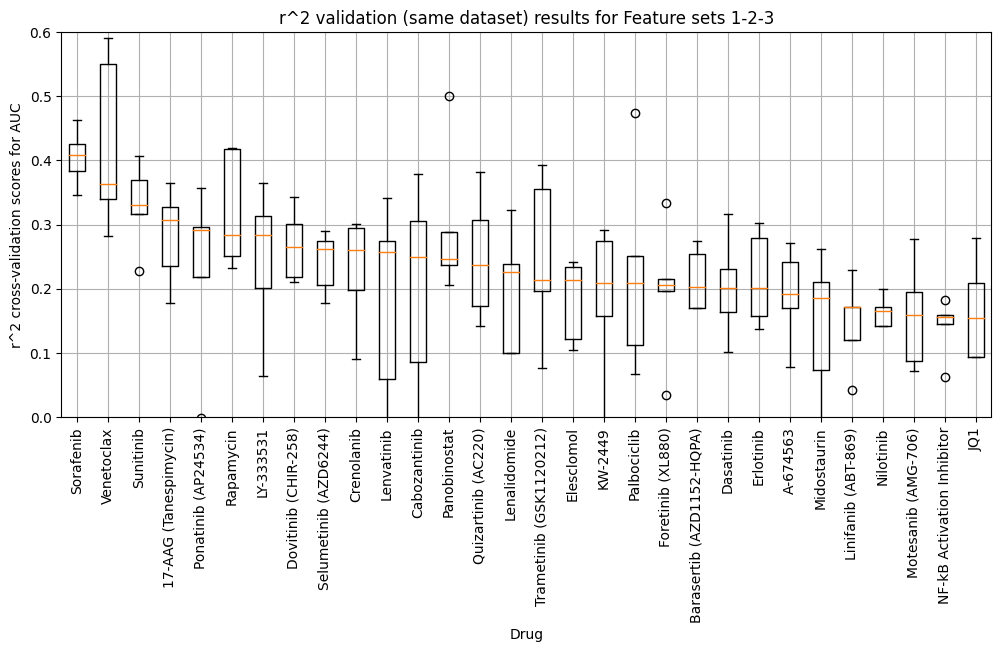

In [74]:
# TODO: add Feature sets 1 and 2 alone to this. Include train and val. See Figure 5 in the paper.
plt.figure(figsize=(12, 5))
plt.boxplot(f123_r2[indices_nonzero[:30]].tolist(), labels=drugs[indices_nonzero[:30]])
plt.xticks(rotation=90)
plt.ylim(0, 0.6)
plt.title('r^2 validation (same dataset) results for Feature sets 1-2-3')
plt.ylabel('r^2 cross-validation scores for AUC')
plt.xlabel('Drug')
plt.grid()
plt.show()

In [75]:
# create combined result table for rows 
combined_result_table = []
for drug in drugs:
    f4_drug_table = f4_coef[drug]
    f4_drug_table['features'] = 'F4'
    combined_result_table.append(f4_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features']])
    #f3a_drug_table = f3a_coef[drug]
    #f3a_drug_table['features'] = 'F3a'
    #combined_result_table.append(f3a_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features']])
    f3b_drug_table = f3b_coef[drug]
    f3b_drug_table['features'] = 'F3b'
    combined_result_table.append(f3b_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features']])
    f123_drug_table = f123_coef[f123_coef.target == drug].copy()
    f123_drug_table['features'] = 'F1-2-3'
    combined_result_table.append(f123_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features']])


In [76]:
combined_result_table = pd.concat(combined_result_table, axis=0)

In [77]:
drug_means = combined_result_table.groupby(['target']).aggregate('mean')

/tmp/ipykernel_601078/2102565793.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  drug_means = combined_result_table.groupby(['target']).aggregate('mean')


In [78]:
top_drugs = drug_means.sort_values('r2_score_test', ascending=False).index[:30]

In [79]:
import seaborn as sns

In [80]:
results_top_drugs = combined_result_table[combined_result_table.target.isin(top_drugs)]

In [81]:
results_top_drugs

target  r2_score_train  r2_score_test features
0    17-AAG (Tanespimycin)        0.635687       0.448200       F4
1    17-AAG (Tanespimycin)        0.769333       0.492687       F4
2    17-AAG (Tanespimycin)        0.841324       0.293033       F4
3    17-AAG (Tanespimycin)        0.712040       0.359379       F4
4    17-AAG (Tanespimycin)        0.781669       0.354959       F4
..                     ...             ...            ...      ...
585             Venetoclax        0.717556       0.282838   F1-2-3
586             Venetoclax        0.747590       0.590239   F1-2-3
587             Venetoclax        0.707121       0.550114   F1-2-3
588             Venetoclax        0.720000       0.363738   F1-2-3
589             Venetoclax        0.874371       0.340268   F1-2-3

[450 rows x 4 columns]

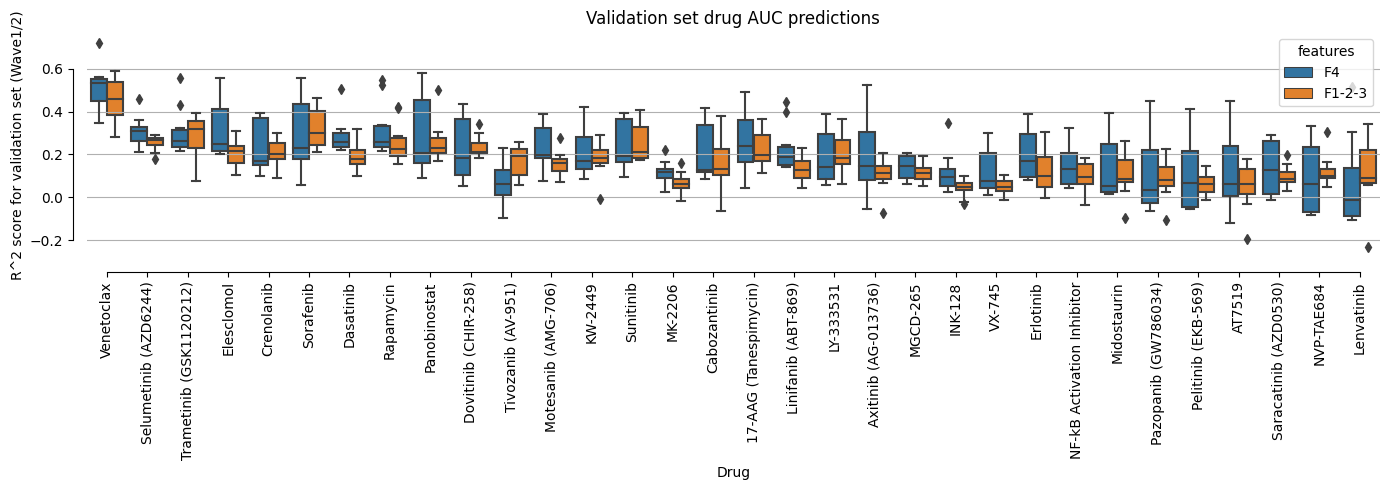

In [229]:
plt.figure(figsize=(14, 5))
results_top_drugs_f1234 = results_top_drugs[results_top_drugs.features.isin(['F4', 'F1-2-3'])]
sns.boxplot(x='target', y='r2_score_test', hue='features', data=results_top_drugs_f1234, order=top_drugs)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.title('Validation set drug AUC predictions')
plt.ylabel('R^2 score for validation set (Wave1/2)')
plt.xlabel('Drug')
plt.tight_layout()
plt.savefig('validation_drug_auc_pred_features1234.png')

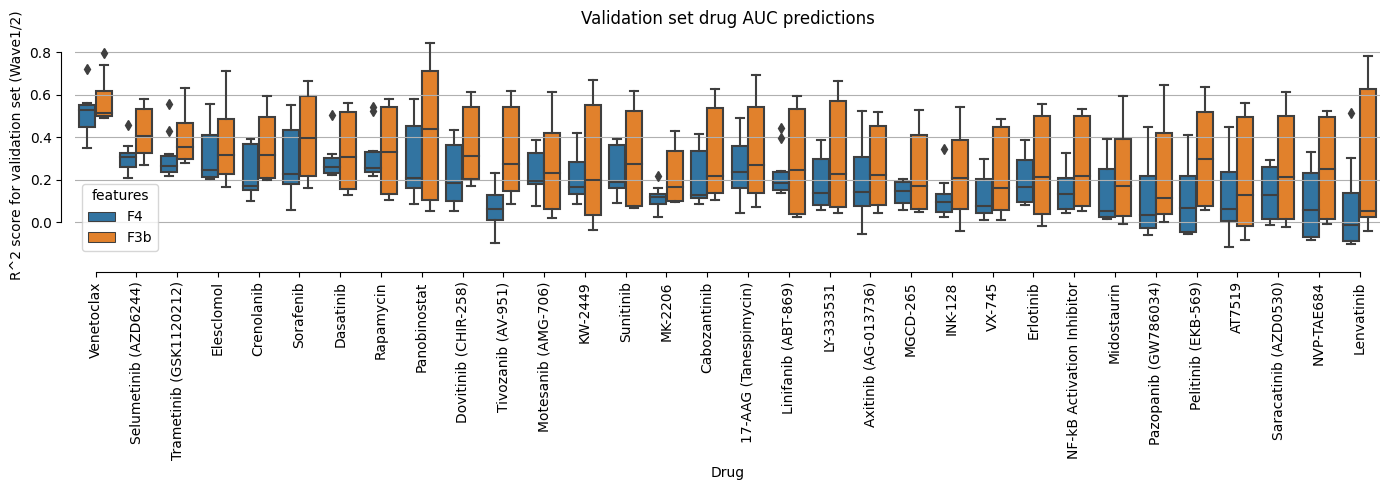

In [230]:
plt.figure(figsize=(14, 5))
results_top_drugs_f3b4 = results_top_drugs[results_top_drugs.features.isin(['F4', 'F3b'])]
sns.boxplot(x='target', y='r2_score_test', hue='features', data=results_top_drugs_f3b4, order=top_drugs)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.title('Validation set drug AUC predictions')
plt.ylabel('R^2 score for validation set (Wave1/2)')
plt.xlabel('Drug')
plt.tight_layout()
plt.savefig('validation_drug_auc_pred_features3b4.png')

## 5. Load test data

### Load RPKM and drug response data for wave3/4 (also includes wave1/2 data, have to filter these out)

In [84]:
all_drug_response = pd.read_csv('data/beataml_probit_curve_fits_v4_distr_nonproprietary.txt', sep='\t')

In [85]:
all_drug_response

lab_id  patient_id              inhibitor  min_conc  max_conc  \
0      11-00261         127       AKT Inhibitor IV   0.03430        25   
1      11-00261         127        AKT Inhibitor X   0.06860        50   
2      11-00261         127         AMPK Inhibitor   0.01370        10   
3      11-00261         127                AST-487   0.01370        10   
4      11-00261         127    Alisertib (MLN8237)   0.01370        10   
...         ...         ...                    ...       ...       ...   
78713  19-00465        5275  Vismodegib (GDC-0449)   0.01370        10   
78714  19-00465        5275   Volasertib (BI-6727)   0.01370        10   
78715  19-00465        5275                XAV-939   0.01370        10   
78716  19-00465        5275               XMD 8-87   0.01370        10   
78717  19-00465        5275                 YM-155   0.00137         1   

       intercept       beta    beta_z    beta_p        aic  ...       ic25  \
0      -0.346985  -0.534891 -0.970573  0.331761   9.755566  ...   0.034300   
1       0.397591  -0.113167 -0.221591  0.824632  10.877425  ...   0.068600   
2       0.127463  -0.668620 -1.142479  0.253255  10.180482  ...   0.152012   
3       0.892331  -0.631916 -0.858336  0.390707   6.645376  ...   2.211724   
4       0.580598  -0.821939 -1.137503  0.255328   8.073871  ...   0.768719   
...          ...        ...       ...       ...        ...  ...        ...   
78713  11.338225  -9.798777 -0.000763  0.999391   4.127685  ...  10.000000   
78714  -0.704943  -0.646073 -1.111532  0.266339   8.902190  ...   0.013700   
78715   1.237588  -0.288334 -0.394796  0.692994   5.408943  ...  10.000000   
78716  -0.263175   0.083194  0.164553  0.869296  11.602969  ...   0.013700   
78717 -32.204271 -26.983899 -0.000757  0.999396   4.000000  ...   0.060470   

            ic50       ic75       ic90         auc  all_gt_50  all_lt_50  \
0       0.224542   4.095265  25.000000  109.414835      False      False   
1      50.000000  50.000000  50.000000  183.984149       True      False   
2       1.551084  10.000000  10.000000  183.478483      False      False   
3      10.000000  10.000000  10.000000  242.784602       True      False   
4       5.085989  10.000000  10.000000  222.464333      False      False   
...          ...        ...        ...         ...        ...        ...   
78713  10.000000  10.000000  10.000000  286.054744       True      False   
78714   0.081074   0.897093   7.806963  101.568804      False      False   
78715  10.000000  10.000000  10.000000  259.803731       True      False   
78716   0.013700  10.000000  10.000000  109.579679      False       True   
78717   0.064051   0.067851   0.071455  166.981698      False      False   

       curve_type          type      proprietary  
0      decreasing  no_replicate  Non-Proprietary  
1      decreasing  no_replicate  Non-Proprietary  
2      decreasing  no_replicate  Non-Proprietary  
3      decreasing  no_replicate  Non-Proprietary  
4      decreasing  no_replicate  Non-Proprietary  
...           ...           ...              ...  
78713  decreasing  no_replicate  Non-Proprietary  
78714  decreasing  no_replicate  Non-Proprietary  
78715  decreasing  no_replicate  Non-Proprietary  
78716  increasing  no_replicate  Non-Proprietary  
78717  decreasing  no_replicate  Non-Proprietary  

[78718 rows x 24 columns]

In [86]:
all_drugs = all_drug_response.inhibitor.unique()

In [87]:
all_samples = all_drug_response.lab_id.unique()

In [88]:
data_train_test = pd.read_csv('data/beataml_waves1to4_allnorm.txt', sep = '\t')

In [89]:
data_train_test

stable_id  display_label  \
0      ENSG00000000003         TSPAN6   
1      ENSG00000000419           DPM1   
2      ENSG00000000457          SCYL3   
3      ENSG00000000460       C1orf112   
4      ENSG00000000938            FGR   
...                ...            ...   
23145  ENSG00000273477  RP11-196O16.1   
23146  ENSG00000273483   RP4-671G15.2   
23147  ENSG00000273486  RP11-731C17.2   
23148  ENSG00000273487   RP4-621B10.8   
23149  ENSG00000273488   RP11-114I8.4   

                                             description         biotype  \
0           tetraspanin 6 [Source:HGNC Symbol;Acc:11858]  protein_coding   
1      dolichyl-phosphate mannosyltransferase polypep...  protein_coding   
2      SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbo...  protein_coding   
3      chromosome 1 open reading frame 112 [Source:HG...  protein_coding   
4      feline Gardner-Rasheed sarcoma viral oncogene ...  protein_coding   
...                                                  ...             ...   
23145                                                NaN         lincRNA   
23146                                                NaN       antisense   
23147                                                NaN       antisense   
23148                                                NaN         lincRNA   
23149                                                NaN         lincRNA   

       13-00098  13-00342   13-00353  13-00466   13-00468  13-00500  ...  \
0     -2.962154 -0.523606  -0.586891  1.757141  -1.916265 -0.210697  ...   
1      8.289174  7.995268   8.371270  8.634921   7.977138  8.254783  ...   
2      4.474460  4.390956   4.905668  5.205251   4.735073  4.357139  ...   
3      5.181530  4.036060   4.105971  2.499966   3.743923  4.133550  ...   
4      5.057466  7.143521  10.197801  9.425625  10.700992  7.336921  ...   
...         ...       ...        ...       ...        ...       ...  ...   
23145  1.912212  3.480229  -0.052933 -0.862427   0.652092  2.082047  ...   
23146 -1.651524  1.046215   1.003326  1.582908   1.064976 -0.183531  ...   
23147  4.318339  4.715502   3.477559  3.513844   3.470215  4.877941  ...   
23148 -1.017907 -2.163464  -0.027850  0.767219  -0.594899  0.780320  ...   
23149  2.077224  1.163525   2.566879  3.656466   2.999040  2.345347  ...   

        19-00165   19-00179  19-00315   19-00332   19-00334  19-00400  \
0      -1.558306  -2.606667 -0.520126  -2.779703  -1.052378 -2.082540   
1       7.856388   8.451163  7.310249   7.948950   8.133486  7.783736   
2       5.047697   4.950124  5.631029   4.874319   5.084156  4.620622   
3       4.540818   4.026929  2.710747   3.822684   4.431313  3.495374   
4      11.134967  11.515788  8.003741  10.178326  11.405671  9.320682   
...          ...        ...       ...        ...        ...       ...   
23145  -1.641834   0.969974  3.682247   1.420943   2.513853  2.035861   
23146  -1.320587   1.246771  0.188252   1.364116   1.118926  0.419354   
23147   4.761862   4.086616  4.764841   5.176542   4.360157  5.180014   
23148  -2.122510   0.366889  1.070602   0.852974   1.864730  0.691136   
23149   2.841674   2.110370  4.161344   3.988264   3.141031  2.393040   

       18-00179  19-00092  19-00200  19-00261  
0      0.347735 -1.548321 -0.059579 -2.413833  
1      8.031471  8.162220  8.059582  7.984738  
2      5.204472  4.660469  4.932784  4.505005  
3      4.386567  5.137836  4.017847  4.211124  
4      5.089631  7.908591  8.078920  9.949064  
...         ...       ...       ...       ...  
23145  3.563247  1.811217  2.163361  3.264825  
23146  1.949921  0.722911  1.897334  0.115704  
23147  3.884189  5.621294  4.454744  4.348569  
23148  1.197564 -0.457598  1.824112  0.439891  
23149  3.843611  4.489392  3.982710  3.352392  

[23150 rows x 711 columns]

In [90]:
data_train_test.index = data_train_test.stable_id

In [91]:
included_genes

Gene
ENSG00000000419             DPM1
ENSG00000000457            SCYL3
ENSG00000000460         C1orf112
ENSG00000000938              FGR
ENSG00000000971              CFH
                       ...      
ENSG00000273464    RP11-313P22.1
ENSG00000273466     RP11-548H3.1
ENSG00000273477    RP11-196O16.1
ENSG00000273486    RP11-731C17.2
ENSG00000273488     RP11-114I8.4
Name: Symbol, Length: 17691, dtype: object

In [92]:
for gene_index in included_genes.index:
    if gene_index not in data_train_test.index:
        data_train_test.loc[gene_index] = 0

#### Getting sample IDs for wave3-4 (all sample IDs that are not in wave1-2)

In [93]:
wave12_samples = rpkm_t.index[2:]

In [94]:
wave34_samples = data_train_test.columns[4:].difference(wave12_samples)

In [95]:
len(wave34_samples)

256

In [96]:
wave34_rpkm = data_train_test.loc[:, list(wave34_samples)]

In [97]:
wave34_drug_response = all_drug_response[all_drug_response.lab_id.isin(wave34_samples)]

In [98]:
print(len(wave34_drug_response))

26719


In [99]:
wave34_drug_response = wave34_drug_response[wave34_drug_response.inhibitor.isin(drugs)]

In [100]:
print(len(wave34_drug_response))

18123


In [101]:
wave34_drug_response[wave34_drug_response.inhibitor == 'Venetoclax']

lab_id  patient_id   inhibitor  min_conc  max_conc  intercept  \
44394  16-00834        4037  Venetoclax    0.0137        10   0.603517   
45616  16-00980        4082  Venetoclax    0.0137        10  -0.173868   
50392  17-00021        4324  Venetoclax    0.0137        10   0.612925   
50550  17-00025        4325  Venetoclax    0.0137        10   0.553981   
50710  17-00033        4359  Venetoclax    0.0137        10  -0.416605   
...         ...         ...         ...       ...       ...        ...   
76937  19-00315        5213  Venetoclax    0.0137        10  -1.467811   
77103  19-00327        5218  Venetoclax    0.0137        10  -0.342786   
77277  19-00332        5013  Venetoclax    0.0137        10  -0.056360   
77443  19-00334        4989  Venetoclax    0.0137        10   0.886075   
77607  19-00369        5235  Venetoclax    0.0137        10  -6.552767   

               beta        beta_z    beta_p        aic  ...      ic25  \
44394 -2.998159e-01 -5.312788e-01  0.595226   7.948328  ...  0.579803   
45616 -5.377198e-01 -9.956142e-01  0.319438   9.973360  ...  0.026443   
50392 -3.001834e-01 -5.304470e-01  0.595802   8.897077  ...  0.623603   
50550 -4.003512e-01 -6.947995e-01  0.487181   8.675643  ...  0.500025   
50710 -2.020824e-01 -3.943128e-01  0.693350  10.634845  ...  0.013700   
...             ...           ...       ...        ...  ...       ...   
76937 -4.299869e-01 -5.913373e-01  0.554294   5.814528  ...  0.013700   
77103 -1.612092e+00 -1.596679e+00  0.110337   6.375205  ...  0.233868   
77277 -6.921396e-01 -1.199506e+00  0.230331   8.928203  ...  0.087917   
77443 -9.570518e-01 -1.057500e+00  0.290283   7.128204  ...  1.663720   
77607 -2.323734e-15 -3.386042e-19  1.000000   4.000000  ...  0.013700   

            ic50       ic75       ic90           auc  all_gt_50  all_lt_50  \
44394  10.000000  10.000000  10.000000  2.180355e+02       True      False   
45616   0.474961   8.530902  10.000000  1.492106e+02      False      False   
50392  10.000000  10.000000  10.000000  2.188516e+02       True      False   
50550  10.000000  10.000000  10.000000  2.160664e+02       True      False   
50710   0.013700  10.000000  10.000000  1.067003e+02      False       True   
...          ...        ...        ...           ...        ...        ...   
76937   0.013700   0.014288   0.368829  3.256200e+01      False       True   
77103   0.612830   1.606155   3.822325  1.645453e+02      False      False   
77277   0.829088   7.817563  10.000000  1.667526e+02      False      False   
77443   8.430262  10.000000  10.000000  2.409528e+02      False      False   
77607   0.013700   0.013700   0.013700  8.085970e-09      False       True   

       curve_type          type      proprietary  
44394  decreasing  no_replicate  Non-Proprietary  
45616  decreasing  no_replicate  Non-Proprietary  
50392  decreasing  no_replicate  Non-Proprietary  
50550  decreasing  no_replicate  Non-Proprietary  
50710  decreasing  no_replicate  Non-Proprietary  
...           ...           ...              ...  
76937  decreasing  no_replicate  Non-Proprietary  
77103  decreasing  no_replicate  Non-Proprietary  
77277  decreasing  no_replicate  Non-Proprietary  
77443  decreasing  no_replicate  Non-Proprietary  
77607  decreasing  no_replicate  Non-Proprietary  

[181 rows x 24 columns]

### Get mutation features for test data

In [102]:
wave34_mutation = pd.read_csv('data/BeatAML_mut_matrix_sele_w3_4.csv', index_col=0)

In [103]:
wave34_mutation.head()

NPM1  CEBPA  STAG2  SF3B1  PTPN11  TP53  BCOR  RUNX1  FLT3  SRSF2  \
16-00358     1      0      0      0       0     0     0      0     0      1   
18-00039     1      0      0      0       0     0     0      0     0      0   
19-00035     0      0      0      0       0     0     0      1     1      0   
19-00418     0      1      1      0       0     0     0      1     0      1   
17-00937     0      0      0      1       0     0     0      0     0      0   

          ...  DNMT3A  WT1  GATA2  EZH2  ASXL1  NRAS  IDH1  U2AF1  TET2  IDH2  
16-00358  ...       0    1      0     0      0     0     0      0     0     1  
18-00039  ...       1    0      0     0      0     0     1      0     0     1  
19-00035  ...       0    0      0     0      1     1     0      0     0     0  
19-00418  ...       0    0      0     0      0     0     0      0     0     0  
17-00937  ...       0    0      0     0      0     0     0      0     0     0  

[5 rows x 22 columns]

In [104]:
# re-order the genes to be the same order as wave1-2
wave34_mutation = wave34_mutation.loc[:, highly_mutated_genes]

In [105]:
wave34_mutation.shape

(268, 22)

In [106]:
wave34_mutation_freq = pd.read_csv('data/BeatAML_w3_4_vaf_matrix_sele.csv', index_col=0)

In [107]:
wave34_mutation_freq.head()

IDH1p.R132C  FLT3p.A680V  JAK2p.V617F  KRASp.G12D  NPM1p.W288Cfs*12  \
16-00358          0.0          0.0     0.412935         0.0          0.210526   
18-00039          0.0          0.0     0.000000         0.0          0.172414   
19-00035          0.0          0.0     0.000000         0.0          0.000000   
19-00418          0.0          0.0     0.000000         0.0          0.000000   
17-00937          0.0          0.0     0.000000         0.0          0.000000   

          ASXL1p.G645Vfs*58  NRASp.G13D  SF3B1p.K666N  ASXL1p.G646Wfs*12  \
16-00358                0.0         0.0           0.0           0.000000   
18-00039                0.0         0.0           0.0           0.000000   
19-00035                0.0         0.0           0.0           0.371795   
19-00418                0.0         0.0           0.0           0.000000   
17-00937                0.0         0.0           0.0           0.000000   

          NRASp.G12D  ...  DNMT3Ap.R882C  SRSF2p.P95R  SF3B1p.K700E  \
16-00358    0.000000  ...            0.0          0.0      0.000000   
18-00039    0.000000  ...            0.0          0.0      0.000000   
19-00035    0.355049  ...            0.0          0.0      0.000000   
19-00418    0.000000  ...            0.0          0.0      0.000000   
17-00937    0.000000  ...            0.0          0.0      0.122363   

          U2AF1p.Q157P  DNMT3Ap.R882H  FLT3p.D835Y  NRASp.Q61K  FLT3p.D835H  \
16-00358           0.0       0.000000          0.0         0.0          0.0   
18-00039           0.0       0.532934          0.0         0.0          0.0   
19-00035           0.0       0.000000          0.0         0.0          0.0   
19-00418           0.0       0.000000          0.0         0.0          0.0   
17-00937           0.0       0.000000          0.0         0.0          0.0   

          U2AF1p.S34F  NRASp.Q61H  
16-00358          0.0         0.0  
18-00039          0.0         0.0  
19-00035          0.0         0.0  
19-00418          0.0         0.0  
17-00937          0.0         0.0  

[5 rows x 27 columns]

In [108]:
for allele in variant_alleles:
    if allele not in wave34_mutation_freq.columns:
        wave34_mutation_freq.loc[:, allele] = 0
wave34_mutation_freq = wave34_mutation_freq.loc[:, variant_alleles]

In [109]:
wave34_mutation_freq.shape

(239, 28)

### Creating feature set tables with a defined set of patient samples

In [110]:
# convert this to a numpy array indexed by patient
data_rows = []
for sample in wave34_samples:
    if sample not in wave34_mutation.index:
        row = np.zeros(len(highly_mutated_genes))
    else:
        row = wave34_mutation.loc[sample, ]
    data_rows.append(row)
data_rows = np.array(data_rows)
wave34_feature_set_1_table = pd.DataFrame(data_rows)
wave34_feature_set_1_table.index = wave34_samples
wave34_feature_set_1_table.columns = wave34_mutation.columns

In [111]:
wave34_feature_set_1_table

TET2  STAG2  RUNX1  EZH2  JAK2  FLT3  SF3B1  GATA2  WT1  CEBPA  ...  \
00-00002   0.0    0.0    0.0   0.0   0.0   0.0    0.0    0.0  0.0    0.0  ...   
00-00003   0.0    0.0    0.0   0.0   0.0   0.0    0.0    0.0  0.0    0.0  ...   
00-00004   0.0    0.0    0.0   0.0   0.0   0.0    0.0    0.0  0.0    0.0  ...   
00-00005   0.0    0.0    0.0   0.0   0.0   0.0    0.0    0.0  0.0    0.0  ...   
00-00006   0.0    0.0    0.0   0.0   0.0   0.0    0.0    0.0  0.0    0.0  ...   
...        ...    ...    ...   ...   ...   ...    ...    ...  ...    ...  ...   
19-00327   0.0    0.0    0.0   0.0   0.0   0.0    0.0    0.0  1.0    0.0  ...   
19-00332   0.0    0.0    1.0   0.0   0.0   0.0    1.0    0.0  0.0    0.0  ...   
19-00334   0.0    0.0    0.0   0.0   0.0   0.0    0.0    0.0  0.0    0.0  ...   
19-00369   0.0    0.0    0.0   0.0   0.0   0.0    0.0    1.0  0.0    0.0  ...   
19-00400   1.0    0.0    0.0   0.0   0.0   0.0    0.0    0.0  0.0    0.0  ...   

          IDH1  BCOR  TP53  ASXL1  DNMT3A  U2AF1  PTPN11  SRSF2  NRAS  IDH2  
00-00002   0.0   0.0   0.0    0.0     0.0    0.0     0.0    0.0   0.0   0.0  
00-00003   0.0   0.0   0.0    0.0     0.0    0.0     0.0    0.0   0.0   0.0  
00-00004   0.0   0.0   0.0    0.0     0.0    0.0     0.0    0.0   0.0   0.0  
00-00005   0.0   0.0   0.0    0.0     0.0    0.0     0.0    0.0   0.0   0.0  
00-00006   0.0   0.0   0.0    0.0     0.0    0.0     0.0    0.0   0.0   0.0  
...        ...   ...   ...    ...     ...    ...     ...    ...   ...   ...  
19-00327   0.0   0.0   0.0    0.0     1.0    0.0     0.0    0.0   0.0   0.0  
19-00332   0.0   0.0   0.0    0.0     0.0    0.0     0.0    0.0   0.0   0.0  
19-00334   0.0   0.0   0.0    0.0     1.0    0.0     0.0    0.0   1.0   1.0  
19-00369   0.0   0.0   0.0    0.0     0.0    0.0     0.0    0.0   0.0   0.0  
19-00400   0.0   0.0   0.0    1.0     0.0    0.0     0.0    1.0   0.0   0.0  

[256 rows x 22 columns]

In [112]:
# convert this to a numpy array indexed by patient
data_rows = []
for sample in wave34_samples:
    if sample not in wave34_mutation_freq.index:
        row = np.zeros(len(variant_alleles))
    else:
        row = wave34_mutation_freq.loc[sample, ]
    data_rows.append(row)
data_rows = np.array(data_rows)
wave34_feature_set_2_table = pd.DataFrame(data_rows)
wave34_feature_set_2_table.index = wave34_samples
wave34_feature_set_2_table.columns = wave34_mutation_freq.columns

In [113]:
wave34_feature_set_2_table

FLT3p.A680V  FLT3p.I836del  FLT3p.D835Y  FLT3p.D835H  NRASp.G13D  \
00-00002          0.0            0.0          0.0          0.0         0.0   
00-00003          0.0            0.0          0.0          0.0         0.0   
00-00004          0.0            0.0          0.0          0.0         0.0   
00-00005          0.0            0.0          0.0          0.0         0.0   
00-00006          0.0            0.0          0.0          0.0         0.0   
...               ...            ...          ...          ...         ...   
19-00327          0.0            0.0          0.0          0.0         0.0   
19-00332          0.0            0.0          0.0          0.0         0.0   
19-00334          0.0            0.0          0.0          0.0         0.0   
19-00369          0.0            0.0          0.0          0.0         0.0   
19-00400          0.0            0.0          0.0          0.0         0.0   

          NRASp.Q61H  NRASp.Q61K  NRASp.G13R  NRASp.G12D  KRASp.G12D  ...  \
00-00002         0.0         0.0         0.0         0.0         0.0  ...   
00-00003         0.0         0.0         0.0         0.0         0.0  ...   
00-00004         0.0         0.0         0.0         0.0         0.0  ...   
00-00005         0.0         0.0         0.0         0.0         0.0  ...   
00-00006         0.0         0.0         0.0         0.0         0.0  ...   
...              ...         ...         ...         ...         ...  ...   
19-00327         0.0         0.0         0.0         0.0         0.0  ...   
19-00332         0.0         0.0         0.0         0.0         0.0  ...   
19-00334         0.0         0.0         0.0         0.0         0.0  ...   
19-00369         0.0         0.0         0.0         0.0         0.0  ...   
19-00400         0.0         0.0         0.0         0.0         0.0  ...   

          ASXL1p.G646Wfs*12  ASXL1p.G645Vfs*58  SF3B1p.K666N  SF3B1p.K700E  \
00-00002                0.0                0.0      0.000000           0.0   
00-00003                0.0                0.0      0.000000           0.0   
00-00004                0.0                0.0      0.000000           0.0   
00-00005                0.0                0.0      0.000000           0.0   
00-00006                0.0                0.0      0.000000           0.0   
...                     ...                ...           ...           ...   
19-00327                0.0                0.0      0.000000           0.0   
19-00332                0.0                0.0      0.522293           0.0   
19-00334                0.0                0.0      0.000000           0.0   
19-00369                0.0                0.0      0.000000           0.0   
19-00400                0.0                0.0      0.000000           0.0   

          NPM1p.W288Cfs*12  JAK2p.V617F  SRSF2p.P95H  SRSF2p.P95L  \
00-00002          0.000000          0.0     0.000000          0.0   
00-00003          0.000000          0.0     0.000000          0.0   
00-00004          0.000000          0.0     0.000000          0.0   
00-00005          0.000000          0.0     0.000000          0.0   
00-00006          0.000000          0.0     0.000000          0.0   
...                    ...          ...          ...          ...   
19-00327          0.378378          0.0     0.000000          0.0   
19-00332          0.000000          0.0     0.000000          0.0   
19-00334          0.295455          0.0     0.000000          0.0   
19-00369          0.000000          0.0     0.000000          0.0   
19-00400          0.000000          0.0     0.415385          0.0   

          SRSF2p.P95R  SRSF2p.P95_R102del  
00-00002          0.0                 0.0  
00-00003          0.0                 0.0  
00-00004          0.0                 0.0  
00-00005          0.0                 0.0  
00-00006          0.0                 0.0  
...               ...                 ...  
19-00327          0.0                 0.0  
19-00332          0.0         

### Filtering and normal-scaling the test RPKM matrix using the same scaler as the training data

(Warning: this is not actually the same scaler as the training data - the training data was already normalized by z-score, so this is a separate normalization.)

In [116]:
import pickle as pkl

In [117]:
wave34_rpkm_filtered = wave34_rpkm.loc[included_genes.index].T

In [120]:
with open('models/rpkm_scaler.pkl', 'rb') as f:
    scaler = pkl.load(f)
data_scaled_filtered = scaler.fit_transform(wave34_rpkm_filtered.values)

In [121]:
wave34_rpkm_scaled_filtered = wave34_rpkm_filtered.copy()
wave34_rpkm_scaled_filtered[:] = data_scaled_filtered

In [128]:
wave34_rpkm_scaled_filtered.mean(0)

Gene
ENSG00000000419    6.552051e-15
ENSG00000000457   -1.540434e-15
ENSG00000000460    1.614160e-15
ENSG00000000938    3.851086e-16
ENSG00000000971   -1.804112e-16
                       ...     
ENSG00000273464   -2.636780e-16
ENSG00000273466   -2.123302e-15
ENSG00000273477   -2.775558e-16
ENSG00000273486    2.123302e-15
ENSG00000273488   -4.857226e-17
Length: 17691, dtype: float64

In [129]:
wave34_rpkm_scaled_filtered.std(0)

Gene
ENSG00000000419    1.001959
ENSG00000000457    1.001959
ENSG00000000460    1.001959
ENSG00000000938    1.001959
ENSG00000000971    1.001959
                     ...   
ENSG00000273464    1.001959
ENSG00000273466    1.001959
ENSG00000273477    1.001959
ENSG00000273486    1.001959
ENSG00000273488    1.001959
Length: 17691, dtype: float64

### Get KG-based features for test data

In [130]:
from kgfe import gene_names
def generate_drug_graph_features_wave34(drugs, expression, KG_reg, drug_coefficients, housekeeping_genes):
    """
    Args:
        drugs - a list of drug names
        expression - a gene expression table, with genes on axis 0 and samples on axis 1
        KG_reg: regulatory knowledge graph
        drug_coefficients:
        housekeeping_genes: a list of housekeeping gene names
    
    Returns:
        drug_data_outputs: a dict of drug name to pandas dataframe
    """
    drug_data_outputs = {}
    housekeeping_genes_ensembl = gene_names.convert('symbol', 'ensembl', housekeeping_genes)
    temp_expression = expression.copy()
    housekeeping_gene_expression = temp_expression.loc[housekeeping_genes_ensembl]
    for drug in drugs:
        coefficients = drug_coefficients[drug_coefficients['Drug'] == drug]
        output_features = []
        print(drug, len(coefficients), 'gene coefficients')
        feature_names = []
        for _, row in coefficients.iterrows():
            gene = row['Gene']
            symbol = row['Symbol']
            if gene in temp_expression.index:
                expression_data = temp_expression.loc[gene]
                # generate features for regulatory genes
                if gene in KG_reg.index:
                    regulators = KG_reg.loc[gene]
                    # only include negative regulators?
                    regulators = regulators[regulators.Coef < 0]
                    for reg_gene in regulators.Regulator:
                        try:
                            reg_gene_ensembl = gene_names.convert('symbol', 'ensembl', [reg_gene])[0]
                            reg_expr = temp_expression.loc[reg_gene_ensembl]
                            ratios = expression_data/reg_expr
                            ratios[ratios >= 1] = 1
                            ratios[ratios < 1] = 0
                            feature_names.append(symbol + '_' + reg_gene)
                            output_features.append(ratios)
                        except:
                            pass
                # generate features for housekeeping genes
                for h_gene_symbol, h_gene in zip(housekeeping_genes, housekeeping_genes_ensembl):
                    h_gene_expr = housekeeping_gene_expression.loc[h_gene]
                    ratios = expression_data/h_gene_expr
                    ratios[ratios >= 1] = 1
                    ratios[ratios < 1] = 0
                    feature_names.append(symbol + '_' + h_gene_symbol)
                    output_features.append(ratios)
        print('features:', len(feature_names))
        drug_data_outputs[drug] = pd.concat(output_features, axis=1)
        drug_data_outputs[drug].columns = feature_names
    return drug_data_outputs

In [131]:
%time wave34_drugs_feature4 = generate_drug_graph_features_wave34(drugs, wave34_rpkm, KG_reg, drug_coefficients, housekeeping_genes)

17-AAG (Tanespimycin) 62 gene coefficients
features: 1186
A-674563 60 gene coefficients
features: 1093
ABT-737 55 gene coefficients
features: 996
AT7519 57 gene coefficients
features: 1008
AZD1480 57 gene coefficients
features: 1009
Afatinib (BIBW-2992) 51 gene coefficients
features: 925
Alisertib (MLN8237) 44 gene coefficients
features: 781
Axitinib (AG-013736) 60 gene coefficients
features: 1111
BEZ235 50 gene coefficients
features: 869
BI-2536 58 gene coefficients
features: 1029
BMS-345541 52 gene coefficients
features: 907
Barasertib (AZD1152-HQPA) 49 gene coefficients
features: 907
Bay 11-7085 58 gene coefficients
features: 1039
Bortezomib (Velcade) 64 gene coefficients
features: 1143
Bosutinib (SKI-606) 55 gene coefficients
features: 978
CHIR-99021 52 gene coefficients
features: 941
CI-1040 (PD184352) 59 gene coefficients
features: 1063
CYT387 64 gene coefficients
features: 1130
Cabozantinib 57 gene coefficients
features: 1082
Canertinib (CI-1033) 59 gene coefficients
features: 1

In [132]:
wave34_drugs_feature4['Venetoclax']

CLASP1_AHR  CLASP1_CEBPD  CLASP1_CLOCK  CLASP1_POU2F2  CLASP1_ZFHX3  \
00-00002         0.0           0.0           1.0            1.0           1.0   
00-00003         0.0           0.0           1.0            1.0           1.0   
00-00004         0.0           0.0           1.0            1.0           1.0   
00-00005         0.0           0.0           1.0            1.0           1.0   
00-00006         0.0           0.0           1.0            1.0           1.0   
...              ...           ...           ...            ...           ...   
19-00327         0.0           0.0           1.0            0.0           1.0   
19-00332         0.0           0.0           1.0            1.0           1.0   
19-00334         0.0           0.0           1.0            0.0           1.0   
19-00369         1.0           1.0           1.0            1.0           1.0   
19-00400         0.0           0.0           1.0            0.0           1.0   

          CLASP1_RPS10  CLASP1_FNTA  CLASP1_COX6A1  CLASP1_BECN1  \
00-00002           1.0          1.0            1.0           0.0   
00-00003           1.0          1.0            1.0           0.0   
00-00004           1.0          1.0            1.0           0.0   
00-00005           1.0          1.0            0.0           0.0   
00-00006           1.0          1.0            1.0           0.0   
...                ...          ...            ...           ...   
19-00327           1.0          1.0            1.0           0.0   
19-00332           1.0          1.0            1.0           0.0   
19-00334           1.0          1.0            0.0           0.0   
19-00369           1.0          1.0            1.0           0.0   
19-00400           1.0          1.0            1.0           0.0   

          CLASP1_SF3B2  ...  CASC15_PSMB2  CASC15_AUP1  CASC15_SRP14  \
00-00002           0.0  ...           0.0          0.0           0.0   
00-00003           0.0  ...           0.0          0.0           0.0   
00-00004           0.0  ...           0.0          0.0           0.0   
00-00005           0.0  ...           0.0          0.0           0.0   
00-00006           0.0  ...           0.0          0.0           0.0   
...                ...  ...           ...          ...           ...   
19-00327           0.0  ...           0.0          0.0           0.0   
19-00332           0.0  ...           0.0          0.0           0.0   
19-00334           0.0  ...           0.0          0.0           0.0   
19-00369           0.0  ...           0.0          0.0           0.0   
19-00400           0.0  ...           0.0          0.0           0.0   

          CASC15_HNRNPK  CASC15_CCNI  CASC15_RHOA  CASC15_PABPC1  \
00-00002            0.0          0.0          0.0            0.0   
00-00003            0.0          0.0          0.0            0.0   
00-00004            0.0          0.0          0.0            0.0   
00-00005            0.0          0.0          0.0            0.0   
00-00006            0.0          0.0          0.0            0.0   
...                 ...          ...          ...            ...   
19-00327            0.0          0.0          0.0            0.0   
19-00332            0.0          0.0          0.0            0.0   
19-00334            0.0          0.0          0.0            0.0   
19-00369            0.0          0.0          0.0            0.0   
19-00400            0.0          0.0          0.0            0.0   

          CASC15_RPS11  CASC15_TPT1  CASC15_FTL  
00-00002           0.0          0.0         0.0  
00-00003           0.0          0.0         0.0  
00-00004           0.0          0.0         0.0  
00-00005           0.0          0.0         0.0  
00-00006           0.0          0.0         0.0  
...                ...          ...         ...  
19-00327           0.0          0.0         0.0  
19-00332           0.0          0.0         0.0  
19-00334           0.0          0.0         0.0  
19-00369           0.0          0.0   

## 6. Run test analyses

### Test analysis function

In [133]:
# Note: for each model, this runs it on the entire wave3/4 data, not just a subset.
def run_test_analyses(X, analyses, dependent_vars, 
                 return_params=False, labels=None,
                 save_model_prefix=''):
    """
    X - input data
    analyses - list of string (names of the analyses)
    dependent_var - list of arrays (things to test)
    model - a scikit-learn model
    
    return_params - whether or not to return the model parameters for each CV run. only for linear models.
    labels - list or array of labels for each of the covariates (required when saving the model parameters)

    save_model_prefix - filename prefix for the models (could include a path).
    """
    all_cv_scores = []
    all_train_cv_scores = []
    cv = KFold(5, shuffle=True, random_state=0)
    weights_results = []
    predicted_values = []
    predicted_r2_values = []
    for analysis, var in zip(analyses, dependent_vars):
        cv_score = []
        included_subset = (~np.isnan(var))
        X_new = X[included_subset]
        var = var[included_subset]
        if len(var) < 5:
            print('FAIL!')
            continue
        if return_params:
            cv_score = []
            cv_round = 0
            for train_index, test_index in cv.split(X_new, var):
                filename = save_model_prefix + '_' + analysis + '_fold' + str(cv_round) + '.pkl'
                with open(filename, 'rb') as f:
                    model = pickle.load(f)
                if hasattr(model, 'coef_'):
                    weights = list(model.coef_)
                elif hasattr(model, 'feature_importances_'):
                    weights = list(model.feature_importances_)
                if hasattr(model, 'intercept_'):
                    weights.append(model.intercept_)
                if hasattr(model, 'alpha'):
                    weights.append(model.alpha)
                elif hasattr(model, 'alpha_'):
                    weights.append(model.alpha_)
                weights.append(analysis)
                predictions = model.predict(X_new)
                score = r2_score(var, predictions)
                weights.append(score)
                cv_score.append(score)
                weights_results.append(weights)
                cv_round += 1
            all_cv_scores.append(cv_score)
            print(analysis)
            print('test r^2 scores:', cv_score, np.mean(cv_score))
        else:
            cv_score = cross_val_score(model, X_new, var, cv=cv, scoring='r2')
            all_cv_scores.append(cv_score)
            print(analysis, cv_score, np.mean(cv_score))
    if return_params:
        columns = list(labels)
        if hasattr(model, 'intercept_'):
            columns.append('intercept')
        if hasattr(model, 'alpha') or hasattr(model, 'alpha_'):
            columns.append('alpha')
        df = pd.DataFrame(weights_results, columns=columns + ['target', 'r2_score_test'])
        return all_cv_scores, df
    else:
        return all_cv_scores

In [134]:
def run_test_analyses_feature4(X_analyses, analyses, dependent_vars, 
                 return_params=False, labels=None,
                 save_model_prefix=''):
    """
    X_analyses - input data
    analyses - list of string (names of the analyses)
    dependent_var - list of arrays (things to test)
    model - a scikit-learn model
    
    return_params - whether or not to return the model parameters for each CV run. only for linear models.
    labels - list or array of labels for each of the covariates (required when saving the model parameters)

    save_model_prefix - filename prefix for the models (could include a path).
    """
    all_cv_scores = []
    all_train_cv_scores = []
    cv = KFold(5, shuffle=True, random_state=0)
    predicted_values = []
    predicted_r2_values = []
    dfs = {}
    for analysis, var in zip(analyses, dependent_vars):
        weights_results = []
        cv_score = []
        included_subset = (~np.isnan(var))
        if callable(X_analyses):
            X_new = X_analyses(analysis)
        else:
            X_new = X_analyses[analysis]
        if isinstance(X_new, pd.DataFrame):
            column_names = X_new.columns
            X_new = X_new.to_numpy()
        else:
            column_names = labels
        X_new = X_new[included_subset]
        var = var[included_subset]
        if len(var) < 5:
            print('FAIL!')
            continue
        if return_params:
            cv_score = []
            cv_round = 0
            for train_index, test_index in cv.split(X_new, var):
                filename = save_model_prefix + '_' + analysis + '_fold' + str(cv_round) + '.pkl'
                with open(filename, 'rb') as f:
                    model = pickle.load(f)
                if hasattr(model, 'coef_'):
                    weights = list(model.coef_)
                elif hasattr(model, 'feature_importances_'):
                    weights = list(model.feature_importances_)
                if hasattr(model, 'intercept_'):
                    weights.append(model.intercept_)
                if hasattr(model, 'alpha'):
                    weights.append(model.alpha)
                elif hasattr(model, 'alpha_'):
                    weights.append(model.alpha_)
                weights.append(analysis)
                predictions = model.predict(X_new)
                score = r2_score(var, predictions)
                weights.append(score)
                cv_score.append(score)
                weights_results.append(weights)
                cv_round += 1
            columns = list(column_names)
            if hasattr(model, 'intercept_'):
                columns.append('intercept')
            if hasattr(model, 'alpha') or hasattr(model, 'alpha_'):
                columns.append('alpha')
            all_cv_scores.append(cv_score)
            print(analysis)
            print('test r^2 scores:', cv_score, np.mean(cv_score))
            df = pd.DataFrame(weights_results, columns=columns + ['target', 'r2_score_test'])
            dfs[analysis] = df
        else:
            cv_score = cross_val_score(model, X_new, var, cv=cv, scoring='r2')
            all_cv_scores.append(cv_score)
            print(analysis, cv_score, np.mean(cv_score))
    if return_params:
        return all_cv_scores, dfs
    else:
        return all_cv_scores

### Building the test set

In [135]:
dependent_vars = []
for drug in drugs:
    drug_subset = wave34_drug_response[wave34_drug_response.inhibitor==drug]
    drug_subset.index = drug_subset.lab_id
    drug_auc_vals = []
    for s in wave34_samples:
        try:
            d = drug_subset.loc[s]
            drug_auc_vals.append(d.auc)
        except:
            drug_auc_vals.append(np.nan)
    dependent_vars.append(np.array(drug_auc_vals))

### Feature set 1

In [136]:
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor

import xgboost


In [137]:
X = wave34_feature_set_1_table.to_numpy()

In [138]:
wave34_f1_r2, wave34_f1_coef = run_test_analyses(X, drugs, dependent_vars,
                              return_params=True,
                              labels=feature_set_1_table.columns,
                              save_model_prefix='models/feature1/f1_lassocv')

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

17-AAG (Tanespimycin)
test r^2 scores: [-0.12926736129362593, -0.1673478441061238, -0.1262775603978037, -0.1472265381041944, -0.15908382920685482] -0.14584062662172054
A-674563
test r^2 scores: [-0.8642557397158874, -0.675543571707659, -0.8079930933816275, -0.6994477459620607, -0.853713349572329] -0.7801907000679128
FAIL!
AT7519
test r^2 scores: [-0.042932308717097856, -0.027042978920671645, -0.04587676765768367, -0.022889291474927465, 0.011749680717158095] -0.025398333210644507
AZD1480
test r^2 scores: [-0.06326443368416257, -0.07545848891881746, -0.020152527459022407, -0.02543760873957468, -0.1170070183175218] -0.06026401542381978
Afatinib (BIBW-2992)
test r^2 scores: [-0.1866297564933943, -0.12900713987631618, -0.09100095075648085, -0.12034843702939768, -0.0988869996420001] -0.12517465675951783
Alisertib (MLN8237)
test r^2 scores: [-0.03300429646169456, -0.07964912783190048, -0.06691031989439766, -0.031597744408642825, -0.10666955845963821] -0.06356620941125475
Axitinib (AG-013736)


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

In [140]:
wave34_f1_coef['model'] = 'lassocv'
wave34_f1_coef.to_csv('wave34_results/feature1_lassocv_coefs.csv', index=None)

### Feature set 2

In [141]:
X = wave34_feature_set_2_table.to_numpy()
wave34_f2_r2, wave34_f2_coef = run_test_analyses(X, drugs, dependent_vars,
                              return_params=True,
                              labels=feature_set_2_table.columns,
                              save_model_prefix='models/feature2/f2_lassocv')

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

17-AAG (Tanespimycin)
test r^2 scores: [-0.054058725194812585, -0.0582202722071008, -0.036347458844733005, -0.02226050421647674, -0.04662076022856776] -0.04350154413833818
A-674563
test r^2 scores: [-0.5917170687663804, -0.5151851248411208, -0.554695261730968, -0.5449869164576453, -0.5693200252858275] -0.5551808794163884
FAIL!
AT7519
test r^2 scores: [-0.046744453654113505, -0.035800186507648935, -0.047385800674199396, -0.037115755436486486, -0.008056482302131407] -0.035020535714915944
AZD1480
test r^2 scores: [-0.0766882433678342, -0.0012289433896843782, -0.04754934680660816, -0.004370669146271489, -0.006544285968155483] -0.02727629773571074
Afatinib (BIBW-2992)
test r^2 scores: [-0.09450054095264204, -0.11617910753930283, -0.07820730155565037, -0.05729589660814449, -0.0985962503359199] -0.08895581939833193
Alisertib (MLN8237)
test r^2 scores: [-0.03300429646169456, -0.05515304668517107, -0.03210904297941353, -0.031597744408642825, -0.044791713812030176] -0.039331168869390434
Axitinib

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

In [142]:
wave34_f2_coef['model'] = 'lassocv'
wave34_f2_coef.to_csv('wave34_results/feature2_lassocv_coefs.csv', index=None)

### Feature set 1/2

In [143]:
X1 = wave34_feature_set_1_table.to_numpy()
X2 = wave34_feature_set_2_table.to_numpy()
X = np.hstack([X1, X2])
wave34_f12_r2, wave34_f12_coef = run_test_analyses(X, drugs, dependent_vars,
                              return_params=True,
                              labels=np.hstack([feature_set_1_table.columns, feature_set_2_table.columns]),
                              save_model_prefix='models/feature1_2/f1_2_lassocv')

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

17-AAG (Tanespimycin)
test r^2 scores: [-0.13833531652618758, -0.1573020026395071, -0.12557113655845886, -0.14571258879831905, -0.1559304661146741] -0.14457030212742933
A-674563
test r^2 scores: [-0.8204070492433468, -0.7340981419865431, -0.7913154997290988, -0.7101429737053224, -0.872177919954741] -0.7856283169238104
FAIL!
AT7519
test r^2 scores: [-0.046744453654113505, -0.028121148157121745, -0.04171159431680249, -0.022809270160287554, 0.011555721193721391] -0.02556614901892078
AZD1480
test r^2 scores: [-0.16471684699967204, -0.07229510374880821, -0.0188809022975307, -0.03770875001722529, -0.10837765635247076] -0.0803958518831414
Afatinib (BIBW-2992)
test r^2 scores: [-0.18486658633494124, -0.12900713987631618, -0.09100095075648085, -0.10633432189312142, -0.0988869996420001] -0.12201919970057196
Alisertib (MLN8237)
test r^2 scores: [-0.03300429646169456, -0.08229287846451339, -0.07024356871612514, -0.031597744408642825, -0.08689888797805856] -0.06080747520580689
Axitinib (AG-013736)


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

In [144]:
wave34_f12_coef['model'] = 'lassocv'
wave34_f12_coef.to_csv('wave34_results/feature1_2_lassocv_coefs.csv', index=None)

### Feature set 3

In [145]:
X = wave34_rpkm_scaled_filtered.values
model1 = LassoCV(tol=0.1, selection='random', precompute=True)
wave34_f3_r2, wave34_f3_coef = run_test_analyses(X, drugs, dependent_vars,
                              return_params=True,
                              labels=rpkm_scaled_filtered.columns,
                              save_model_prefix='models/feature3/f3_lassocv')

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

17-AAG (Tanespimycin)
test r^2 scores: [0.17506596752504888, 0.12208680122317495, 0.21536288938573844, 0.11595647217801375, 0.18311434831172801] 0.1623172957247408
A-674563
test r^2 scores: [-0.5938565344949958, -0.43586074868489555, -0.5051937413649155, -0.683763014604633, -0.527237043424976] -0.5491822165148832
FAIL!
AT7519
test r^2 scores: [0.02531327734455513, 0.10788434309344408, 0.06407898095404163, 0.047918769918072535, 0.007649349164434827] 0.05056894409490964
AZD1480
test r^2 scores: [-0.043402303654736185, -0.045030430317723136, -0.02713290272695046, -0.0002980422947338468, -0.013301214298669484] -0.02583297865856262
Afatinib (BIBW-2992)
test r^2 scores: [-0.09450054095264204, -0.13425768244554837, -0.09100095075648085, -0.014812070478456896, -0.0988869996420001] -0.08669164885502564


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Alisertib (MLN8237)
test r^2 scores: [-0.042884822671945155, -0.042261437656780476, -0.029376977849849606, -0.06068194103454716, -0.0416484910536945] -0.04337073405336338
Axitinib (AG-013736)
test r^2 scores: [0.20131000258632292, 0.10280323061575325, 0.1565904426366045, 0.16126407244702423, 0.12097439529549203] 0.1485884287162394
BEZ235
test r^2 scores: [-0.35556911166467975, -0.385470535896985, -0.2518050197917172, -0.3394914579414827, -0.44503868208900177] -0.35547496147677327
FAIL!
BMS-345541
test r^2 scores: [-0.05254602895931759, -0.04567460579682492, -0.02326455561810792, -0.06379914404167475, -0.04461594137870217] -0.04598005515892547
FAIL!
Bay 11-7085
test r^2 scores: [-0.0496900935231217, -0.05572136663607208, -0.03960798865931614, -0.01357059432396257, -0.028116862545468857] -0.03734138113758827


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Bortezomib (Velcade)
test r^2 scores: [0.026850750892361663, 0.05187310034948944, 0.030706583093093376, 0.044833229690825926, -0.02497158837834812] 0.025858415129484457
Bosutinib (SKI-606)
test r^2 scores: [-0.0012841573684783114, 0.015937315003220265, 0.06687154351041213, 0.0012530423048024986, 0.008728617441860598] 0.018301272178363436
CHIR-99021
test r^2 scores: [-0.04028780499112172, -0.011822512054652679, -0.00806184552191258, -8.609171748674704e-05, -0.0025089687770853963] -0.012553444612451826
CI-1040 (PD184352)
test r^2 scores: [0.07194487070573263, 0.022255371733280294, 0.07468818989917958, -0.012329316314371841, 0.024319629372023033] 0.03617574907916874


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

CYT387
test r^2 scores: [-0.06193959727633547, -0.03677971279294834, -0.18811491203971875, -0.037934932894062134, -0.1050806284404302] -0.08596995668869897
Cabozantinib
test r^2 scores: [0.145112794992737, 0.12629413381628862, 0.1623791558442338, 0.13602361880119584, 0.11763584770934432] 0.13748911023275992
Canertinib (CI-1033)
test r^2 scores: [-0.04732252254308267, 0.009171200246883449, -0.003709675774518084, -0.024852087189786154, 0.011990653814986874] -0.010944486289103317
Cediranib (AZD2171)
test r^2 scores: [0.13211633339601614, 0.1363016715272568, 0.13404017405303936, 0.10227058415499979, 0.13150017184927787] 0.127245786996118
Crenolanib
test r^2 scores: [0.18415139216456733, 0.21026264033497177, 0.19609523364573556, 0.2266707921192085, 0.177597889541665] 0.19895558956122963


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Crizotinib (PF-2341066)
test r^2 scores: [-0.05274292003784331, -0.02272230120613994, -0.05394563584259404, -0.05871538791910513, -0.07846697393436108] -0.0533186437880087
DBZ
test r^2 scores: [0.025996008074710808, 0.016069942775225332, 0.009177495950315251, 0.08737128057932331, 0.03397688339080074] 0.03451832215407509
Dasatinib
test r^2 scores: [0.14558695289723078, 0.1832181903075112, 0.1710190303329696, 0.1465337611501364, 0.2266818551185934] 0.17460795796128828
Doramapimod (BIRB 796)
test r^2 scores: [0.02295534306800162, 0.05046703799154839, 0.01328326872621688, 0.0809660965928557, -0.23152525984094385] -0.012770702692464253
Dovitinib (CHIR-258)
test r^2 scores: [0.19789427086693, 0.19597363340352814, 0.21926245469145744, 0.1819863979631383, 0.2062592079723211] 0.200275192979475


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Elesclomol
test r^2 scores: [0.269106216556804, 0.25452833895234395, 0.246367002433882, 0.14538254128171813, 0.18254268862982814] 0.21958535757091524
Entospletinib (GS-9973)
test r^2 scores: [-0.3064793866782587, -0.2940763908846997, -0.132894462050003, -0.06742879637121524, -0.6601586089281575] -0.2922075289824668
Entrectinib
test r^2 scores: [-0.009897159957924284, 0.01776689744147375, -0.000727087489464262, -0.003673289648859379, -0.0037377751143030657] -5.3682953815448185e-05
Erlotinib
test r^2 scores: [0.0378218138582227, -0.004875350370101783, 0.05429521680387306, 0.04657154386129281, 0.008800963873234702] 0.028522837605304295


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Flavopiridol
test r^2 scores: [-0.2244135135429668, -0.2123941005337735, -0.1872621171689517, -0.3433580180662963, -0.20530056562629273] -0.2345456629876562
Foretinib (XL880)
test r^2 scores: [-0.04904138149102155, -0.08295012161227877, -0.14873417534464495, -0.07241110765875636, -0.04387417533710969] -0.07940219228876226
GDC-0879
test r^2 scores: [-0.012099163004695379, -0.029474996148630028, -0.002198192219578843, -0.009571898320234862, -0.008047557045576248] -0.012278361347743072
GDC-0941
test r^2 scores: [-0.3691652749607972, -0.3721476085293045, -0.27648981925209526, -0.3203899315258134, -0.3925618626849492] -0.3461508993905919
GSK-1838705A
test r^2 scores: [-0.09165574443578173, 0.019905652633683824, -0.003109977899008909, -0.016327066794685097, 0.0013409459044013694] -0.017969238118278108


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GSK-1904529A
test r^2 scores: [-0.2533770054261848, -0.25947592620744286, -0.20992636294012357, -0.2729714922527895, -0.20477359577963594] -0.24010487652123533
GSK690693
test r^2 scores: [0.007692063769366486, 0.02327204175073283, 0.030932396553034147, 0.04500869588948142, 0.020988712554878775] 0.02557878210349873
GW-2580
test r^2 scores: [-0.11631581805275037, -0.12859354719168659, -0.051482269450737306, -0.12210224568071903, -0.10767643754919654] -0.10523406358501797
Gefitinib
test r^2 scores: [-0.17344113122046467, -0.14501044339285274, -0.14547068160626697, -0.1069575530083613, -0.06042900857661948] -0.12626176356091304
FAIL!
FAIL!
INK-128
test r^2 scores: [0.048920843054844676, 0.10726201309991246, 0.03167100300563752, 0.08079352451537036, 0.04425592406374679] 0.06258066154790236


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Ibrutinib (PCI-32765)
test r^2 scores: [-0.12779891517837028, -0.10854524283539724, -0.13042912716251887, -0.1272541767308808, -0.12208873190719949] -0.12322323876287333
Idelalisib
test r^2 scores: [0.056179559456074224, 0.12718345812299325, 0.09409050099461957, 0.03476678524716048, 0.1219407469762881] 0.08683221015942713
Imatinib
test r^2 scores: [-0.004281572278145962, 0.009102274839003721, -0.0003647428542323805, -0.0006481779349867267, 0.011654618020277119] 0.003092479958383154
JAK Inhibitor I
test r^2 scores: [-0.0031762124930900804, -0.0011092252602264985, -0.012910832660329552, -0.060830075278131, -0.003126257422693568] -0.01623052062289414
JNJ-28312141
test r^2 scores: [0.1346441080663071, -0.030718413516040766, 0.06550281564551452, -0.07534212694802989, 0.1733155471326675] 0.0534803860760837
JNJ-38877605
test r^2 scores: [-0.14518397912434144, -0.15174899998681068, -0.09919276219360795, -0.13884358175950196, -0.10610948904803563] -0.12821576242245952


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JNJ-7706621
test r^2 scores: [-0.025576729868553638, -0.15110548951256897, -0.07053623656223484, -0.0012114624681942576, -0.010114750180881593] -0.05170893371848666
JQ1
test r^2 scores: [-0.0075228726454596995, -0.03626779602835173, -0.13982495265212314, -0.0724159944003091, -0.24560091503545567] -0.10032650615233987
KI20227
test r^2 scores: [-0.03333085991726281, -0.07925278796844903, -0.0804934860070079, -3.508528872564476e-05, -0.16109980858860773] -0.07084240555401063
KU-55933
test r^2 scores: [-0.019029910400785166, 0.01734480690153206, 0.02513041861332399, 0.0019874082913150515, 0.020340084057398622] 0.009154561492556912
KW-2449
test r^2 scores: [0.16695080165820386, 0.15459402490455365, 0.22897426315257463, 0.16818624116219816, 0.1984491015135611] 0.18343088647821829
LY-333531
test r^2 scores: [0.17706104118062005, 0.11348048161189261, 0.1656644977666376, 0.18710224371271256, 0.155496484755283] 0.15976094980542915


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Lapatinib
test r^2 scores: [-0.1095382108433558, -0.2688588330196233, -0.2070420628292151, -0.30750437218559745, -0.11459455052126688] -0.2015076058798117
Lenalidomide
test r^2 scores: [0.022220193129771526, 0.11179902385390372, 0.10385619959347459, 0.13122787438291483, 0.07361449725096159] 0.08854355764220526
Lenvatinib
test r^2 scores: [0.06673508272098383, 0.09282122846657903, 0.11900432661266136, 0.059654348375722366, 0.09102512273402241] 0.0858480217819938
FAIL!
Linifanib (ABT-869)
test r^2 scores: [0.1097579451232027, 0.15912384229638188, 0.09389568220784461, 0.07692704895503188, 0.09503310143504728] 0.10694752400350167
Lovastatin
test r^2 scores: [-0.013718215825252456, -0.0005101780417913204, -0.006737339498805062, -0.026215119768041806, 0.021680614750005933] -0.005100047676776942
MGCD-265
test r^2 scores: [0.09805484822381438, 0.08039134387177782, 0.11566898474277298, 0.08405501694380846, 0.052852996843999134] 0.08620463812523456


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

MK-2206
test r^2 scores: [0.1068830498205453, 0.09625403069761462, 0.17463827932961073, 0.050475228816715956, 0.07573632742845171] 0.10079738321858767
MLN120B
test r^2 scores: [-0.09199561071995288, -0.12095154312056877, -0.07779818318572684, -0.07910349898303148, -0.08950926012680216] -0.09187161922721643
MLN8054
test r^2 scores: [0.002413323943753154, 0.029188512122633736, 0.012157996286463968, 0.012570710833467835, -0.021641233604843713] 0.0069378619162949965
Masitinib (AB-1010)
test r^2 scores: [-0.026643808692921267, -0.06111681299858618, -0.032914575279135105, -0.03230124618737262, -0.09802725157897552] -0.05020073894739814


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Midostaurin
test r^2 scores: [0.07509205322267953, 0.047675098898949386, 0.08368468197497236, 0.08092701873221497, 0.13980823440612022] 0.0854374174469873
Motesanib (AMG-706)
test r^2 scores: [0.13604171478080762, 0.17125867004418882, 0.16712721884439619, 0.1751734402597016, 0.0963559771182132] 0.14919140420946148
NF-kB Activation Inhibitor
test r^2 scores: [0.06822969438512949, 0.0010322203009828224, 0.022077966282751937, 0.0732597971760569, 0.08121607675286513] 0.04916315097955726
NVP-ADW742
test r^2 scores: [-0.0788323418079504, 0.01677835842166686, -0.01081342169568611, -0.013856013829623981, 0.0027896348606378796] -0.01678675681019115
NVP-TAE684
test r^2 scores: [0.0895293981463231, 0.08472009968317096, 0.090105897812508, 0.09294479023785884, 0.05142155701402018] 0.08174434857877622
Neratinib (HKI-272)
test r^2 scores: [0.03870683599037261, 0.008662213484935788, -0.009817370038491813, 0.00912452796758434, 0.01766073060261497] 0.01286738760140318


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Nilotinib
test r^2 scores: [-0.03356733826120939, -0.05779222229220404, -0.05812389378872984, -0.02987129168174807, -0.025294200034588155] -0.0409297892116959
Nutlin 3a
test r^2 scores: [-0.4089398947298868, -0.3756902232106474, -0.37397141818643376, -0.3288904213874573, -0.35699995710492405] -0.36889838292386984
PD173955
test r^2 scores: [-0.1672116264716239, -0.11125681128611098, -0.10113791569394737, -0.12355710077599347, -0.14895359002920205] -0.13042340885137554
PHA-665752
test r^2 scores: [0.06460324289487585, 0.07671554036592221, 0.051386562394090896, 0.06529007823574606, 0.025551753583159753] 0.05670943549475895
PHT-427
test r^2 scores: [-0.01812484084655841, -0.009207559837741242, 0.013887541918890522, 0.01600077939280209, -0.05776008592478776] -0.01104083305947896


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PI-103
test r^2 scores: [0.03959409559606564, 0.02577559901604487, 0.0014781699804524706, -0.019897686846603868, 0.025887286599016623] 0.014567492868995146
FAIL!
PP242
test r^2 scores: [-0.11798476624024046, -0.13307372158845387, -0.20064010095438856, -0.06964557176232988, -0.1407846003039379] -0.13242575216987013
PRT062607
test r^2 scores: [0.028444158546166776, 0.06262992519433386, 0.08917954311922849, 0.021383814165540915, -0.05763399738476904] 0.0288006887281002
Palbociclib
test r^2 scores: [-0.06191060426245065, -0.19214957436230584, -0.13560525964183245, -0.06757526791585677, -0.18062059251989537] -0.1275722597404682
Panobinostat
test r^2 scores: [0.22913882569820032, 0.3088025095609934, 0.20078831815150533, 0.20274457673722235, 0.2112684935628174] 0.23054854474214775


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Pazopanib (GW786034)
test r^2 scores: [0.03226508602284606, 0.14404329949622585, 0.10270939546732893, 0.054310192025100124, 0.06848865200465792] 0.08036332500323178
Pelitinib (EKB-569)
test r^2 scores: [0.049883362128070874, -0.013002023029023757, 0.03091992421343248, 0.02904301400133913, 0.014894748316788275] 0.0223478051261214
Ponatinib (AP24534)
test r^2 scores: [-0.2149662586664418, -0.19450449326858577, -0.20781476341837535, -0.258280787933006, -0.19032709165605244] -0.21317867898849227
Quizartinib (AC220)
test r^2 scores: [0.10354956435357432, 0.12898887755478283, 0.046907611340944455, 0.09377577330132103, 0.11785648898644696] 0.09821566310741392
RAF265 (CHIR-265)
test r^2 scores: [-0.19881257840928468, -0.22185753682860443, -0.22124228938919988, -0.24559900597132245, -0.3051535907755796] -0.2385330002747982


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Rapamycin
test r^2 scores: [0.19324044574338217, 0.19695419037471873, 0.17260196871755107, 0.19923105101167737, 0.147172903523199] 0.18184011187410568
Regorafenib (BAY 73-4506)
test r^2 scores: [-0.12114822237626433, -0.10844023233686628, -0.09277124337386544, -0.07242214150284276, -0.10159703239488027] -0.09927577439694382
Roscovitine (CYC-202)
test r^2 scores: [-0.007021904296574455, -0.022196034045163238, 0.010251707418988065, 0.00549967381554084, -0.0011098889742813256] -0.0029152892162980226
Ruxolitinib (INCB018424)
test r^2 scores: [-0.13126417544662572, -0.14834347090318545, -0.11218639005495668, -0.1483307843016206, -0.15495662427681567] -0.1390162889966408
S31-201
test r^2 scores: [-0.05531424118493522, -0.0014187823449123282, -0.00022824964837719897, -0.005536415709971543, -0.03678856604349168] -0.019857250986337595
SB-431542
test r^2 scores: [-0.08397400886688566, -0.08727485035491367, -0.12917256294265145, -0.0706592065349203, -0.08279940620713111] -0.09077600698130044


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

SGX-523
test r^2 scores: [-0.04901410681701335, -0.04286141954763201, -0.09469628854327672, -0.0461770988698893, -0.06815902821197861] -0.060181588397957994
SNS-032 (BMS-387032)
test r^2 scores: [-0.32618144917347847, -0.3466338503255739, -0.28411943419923014, -0.3694083184962873, -0.36054119620610847] -0.33737684968013565
SR9011
test r^2 scores: [-0.014174997778620302, 0.03622978541677524, 0.08229862798213416, 0.05802966578026436, 0.04522579688262329] 0.041521775656635354
STO609
test r^2 scores: [-0.042037795592170024, -0.08322732039400504, -0.016483477496857857, -0.014715271038931999, -0.018279207816075838] -0.03494861446760815
SU11274
test r^2 scores: [-0.10595167150195062, -0.13878217756814504, -0.1479003972983246, -0.19516245539325072, -0.16865323324055015] -0.15128998700044421


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Saracatinib (AZD0530)
test r^2 scores: [0.11698263275546572, 0.01715592336125893, 0.08246145078675937, 0.10910613461624619, 0.0626991465450969] 0.07768105761296543
Selinexor
test r^2 scores: [-0.5352176837955875, -0.3046911245719157, -0.40707549817374455, -0.37138318010705107, -0.5058045015423482] -0.4248343976381294
Selumetinib (AZD6244)
test r^2 scores: [0.2732808888775222, 0.26144777582614476, 0.28258478986646074, 0.25004838803301266, 0.27636174804868285] 0.26874471813036466
Sorafenib
test r^2 scores: [0.22190865033595875, 0.2484235661737979, 0.24925424068852975, 0.24864745477216765, 0.2335458897412972] 0.24035596034235027
FAIL!
Sunitinib
test r^2 scores: [0.1819222884220456, 0.17955522467726936, 0.2014918580776086, 0.15494598256976855, 0.17518312728747454] 0.17861969620683332


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

TG100-115
test r^2 scores: [-0.0003672060356672002, 0.008562331153234237, -0.0009927989230107404, 0.01126976275659497, 0.008426472145248942] 0.005379712219280042
FAIL!
FAIL!
Tivozanib (AV-951)
test r^2 scores: [0.152907858178299, 0.2081736125083099, 0.23411046517080802, 0.18397307990982392, 0.20315236854456586] 0.19646347686236135
Tofacitinib (CP-690550)
test r^2 scores: [-0.27987552747849676, 0.002931368713698479, -0.03667992598423453, -0.05905373287011262, -0.07543340064003057] -0.0896222436518352
Tozasertib (VX-680)
test r^2 scores: [0.041187211007283286, 0.05862927058424583, 0.07683414568270963, 0.003865366459849473, 0.04826734621838269] 0.04575666799049418


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Trametinib (GSK1120212)
test r^2 scores: [0.2919814264771794, 0.38437667431305844, 0.3243547468833683, 0.31960565242331973, 0.35398202211926955] 0.33486010444323905
VX-745
test r^2 scores: [0.10094569377463736, 0.06654055790134117, 0.027088940675868423, 0.05969230128268044, -0.003044153832981955] 0.05024466796030909
Vandetanib (ZD6474)
test r^2 scores: [-0.0047112203781187745, 0.051593965751297044, 0.02753888852657338, 0.031318657243899595, 0.07791798890539925] 0.0367316560098101
Vargetef
test r^2 scores: [0.03720583559592461, -0.04745989790459282, 0.0005183044328386233, 0.04604375278329964, 0.030250222947795113] 0.013311643571053033
Vatalanib (PTK787)
test r^2 scores: [-0.02923088632512849, -0.02590357500059781, 0.0028361600024354727, -0.021203436267876574, -0.02934710882677738] -0.020569769283588956


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vemurafenib (PLX-4032)
test r^2 scores: [-0.06839089823001587, -0.06256548569494469, -0.0444909943873506, -0.07431697619753197, -0.07956139974491916] -0.06586515085095246
Venetoclax
test r^2 scores: [0.5411027987324055, 0.4543808375492986, 0.4399618436192809, 0.46543032588343125, 0.53634888729744] 0.4874449386163713
Vismodegib (GDC-0449)
test r^2 scores: [-0.04197589158684112, -0.025047620580341157, -0.03703524657949964, -0.04642199440192396, -0.05912617764088979] -0.04192138615789913
Volasertib (BI-6727)
test r^2 scores: [-3.7344004470307723e-05, -0.0002533299390701238, -6.035481808996934e-05, -0.0007952335887388973, -0.00022759126007754205] -0.00027477072208936804


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

XAV-939
test r^2 scores: [-0.9227906010791704, -0.8648267285744271, -0.8138478121427974, -0.9001983958705835, -0.8800231351647037] -0.8763373345663364
YM-155
test r^2 scores: [-0.02551715659428644, 0.023270407552745453, -0.06581402349175636, -0.03892339196413808, -0.06966798392384788] -0.03533042968425666


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

In [146]:
wave34_f3_coef['model'] = 'lassocv'
wave34_f3_coef.to_csv('wave34_results/feature3_lassocv_coefs.csv', index=None)

### Feature set 3a (important genes only, genes with at least one nonzero coefficient from LASSO for the given drug)

In [147]:
def wave34_get_f3_subset(drug):
    """
    Returns the set of "important" genes for the given drug.
    """
    subset = f3_coef[f3_coef.target == drug]
    # get nonzero genes
    subset_genes = subset.iloc[:, :-6]
    included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
    data_subset = wave34_rpkm_scaled_filtered.loc[:, included_genes]
    if len(included_genes) == 0:
        return wave34_rpkm_scaled_filtered
    return data_subset

In [148]:
model1 = LassoCV(tol=0.1, selection='random', precompute=True)
wave34_f3a_r2, wave34_f3a_coef = run_test_analyses_feature4(wave34_get_f3_subset, drugs, dependent_vars,
                              return_params=True,
                              save_model_prefix='models/feature3a/f3a_lassocv')

/tmp/ipykernel_601078/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-m

17-AAG (Tanespimycin)
test r^2 scores: [-0.021133530087285912, -0.027174449816204094, -0.005991370179148969, -0.14672069542795474, -0.0064696630484391005] -0.04149794171180656
A-674563
test r^2 scores: [-0.9642957216689669, -0.7066542660800867, -0.7339073794697337, -1.1563173372798796, -0.8801765087513114] -0.8882702426499958
FAIL!
AT7519
test r^2 scores: [0.02071314512639766, -0.020868820647087283, -0.008940073369376522, 0.016806264225402767, 0.03336552866530873] 0.00821520880012907
AZD1480
test r^2 scores: [-0.2366374512538545, -0.25248324262211885, -0.1814261453486885, -0.22701297933886377, -0.14654323284574566] -0.20882061028185425
Afatinib (BIBW-2992)
test r^2 scores: [-0.1313925417103463, -0.2513519790387928, -0.1461774995087115, -0.17621125464203335, -0.19005065860788894] -0.1790367867015546
Alisertib (MLN8237)
test r^2 scores: [-0.3632181660060081, -0.26207112962268675, -0.17442924603349552, -0.31748808332836953, -0.2007475829821208] -0.26359084159453616
Axitinib (AG-013736)
te

/tmp/ipykernel_601078/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-m

Doramapimod (BIRB 796)
test r^2 scores: [0.03921598382739466, -0.08439181207933233, 0.04000653825707623, 0.00925423579267104, -0.2219451577137863] -0.04357204238319534
Dovitinib (CHIR-258)
test r^2 scores: [0.10517116980736152, 0.06296492204659532, 0.09537851335590408, 0.08790324499231439, 0.002159128475024752] 0.07071539573544001
Elesclomol
test r^2 scores: [0.1560479583733977, 0.17762261444944005, 0.24150048140441494, 0.14146896797448805, 0.15050581364343818] 0.17342916716903578
Entospletinib (GS-9973)
test r^2 scores: [-0.2968972630816362, -0.5042645129832299, -0.16934005744843383, -0.07206520436210573, -0.7224743923945856] -0.35300828605399825


/tmp/ipykernel_601078/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-m

Entrectinib
test r^2 scores: [-0.0500757165684258, -0.13174712935410904, -0.24234097103099694, -0.13188147667153882, -0.07642952666086722] -0.12649496405718758
Erlotinib
test r^2 scores: [0.021809982067408695, 0.02412196840126435, 0.015731082631529225, 0.048172418277964923, -0.07742674406094374] 0.00648174146344469
Flavopiridol
test r^2 scores: [-0.4286423384663076, -0.46499299215803425, -0.5162288975678311, -0.6376892234330591, -0.4546326232427307] -0.5004372149735925
Foretinib (XL880)
test r^2 scores: [-0.2505291516179948, -0.2882694694433807, -0.2396378270385522, -0.3385549036963973, -0.1551658505907072] -0.25443144047740646
GDC-0879
test r^2 scores: [-0.1279634216345913, -0.2085659133003499, -0.08303110884623477, -0.13442860516910127, -0.13336937957671036] -0.13747168570539753
GDC-0941
test r^2 scores: [-0.41818130657259456, -0.40950149342910236, -0.3460036067632659, -0.40893071211884324, -0.38605558899732406] -0.393734541576226
GSK-1838705A
test r^2 scores: [-0.3213879400200599, -

/tmp/ipykernel_601078/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-m

KU-55933
test r^2 scores: [-0.017200892259984224, 0.013301392935658796, -0.0013768269016360968, 0.011383873539743905, 0.026767642113360246] 0.006575037885428525
KW-2449
test r^2 scores: [0.07216731311886593, 0.06356143936230607, 0.1170658238419392, 0.10312274460726711, 0.12841110620475693] 0.09686568542702705
LY-333531
test r^2 scores: [0.0918347966030626, -0.010628948516912429, 0.0517735409697313, 0.08988858612450135, -0.018165887131132985] 0.04094041760984997
Lapatinib
test r^2 scores: [-0.37033705871012845, -0.5835852204776804, -0.3993261726047461, -0.48752182731571114, -0.4360941243823091] -0.455372880698115
Lenalidomide
test r^2 scores: [-0.2242092450329347, -0.15792327044644927, -0.019257178638724115, -0.02368358392649017, 0.03914660986483465] -0.07718533363595273
Lenvatinib
test r^2 scores: [-0.04279033314065095, -0.005055221842896529, 0.022831923604591187, -0.029444406354905306, 0.005541389585839274] -0.009783329629604464
FAIL!
Linifanib (ABT-869)
test r^2 scores: [0.0797094645

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Nilotinib
test r^2 scores: [-0.0710436507176182, -0.03806995459915097, -0.10334940559267958, -0.0884553851396408, -0.06689290295521655] -0.07356225980086122
Nutlin 3a
test r^2 scores: [-0.46529506203702176, -0.42729877783988224, -0.3857280513650625, -0.47567048346590024, -0.41208072353845093] -0.43321461964926355
PD173955
test r^2 scores: [-0.1290336267188017, -0.23441408442064304, -0.1886037980878994, -0.16006327464858772, -0.3008552649501792] -0.2025940097652222
PHA-665752
test r^2 scores: [0.011119566836932604, 0.01631429793709449, 0.022772160864399482, 0.011249131872184792, -0.06981918582804703] -0.0016728056634871314
PHT-427
test r^2 scores: [-0.1357424459096055, -0.18838496032471208, -0.23856190131665644, -0.1951771992997584, -0.0446549271872716] -0.16050428680760082
PI-103
test r^2 scores: [-0.04499931751955066, -0.09897189928301797, -0.09529471545608703, -0.08516155149816651, -0.0608669193825655] -0.07705888062787754
FAIL!
PP242
test r^2 scores: [-0.2539967078574734, -0.3256350

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

RAF265 (CHIR-265)
test r^2 scores: [-0.2674762109485844, -0.2558019012624213, -0.23164705863472634, -0.30733054231459844, -0.2590617528164483] -0.26426349319535575
Rapamycin
test r^2 scores: [-0.10678453605974925, -0.08575980641778758, -0.01793784200280646, 0.03994908568478517, -0.0474881468914532] -0.04360424913740226
Regorafenib (BAY 73-4506)
test r^2 scores: [-0.19257678089888253, -0.26322442433582416, -0.25131105952790156, -0.09674444461374376, -0.2305579976920178] -0.20688294141367397
Roscovitine (CYC-202)
test r^2 scores: [-0.00365153146363717, -0.3241460644125844, -0.2103747988015927, -0.19664752706096023, -0.20380065196088637] -0.18772411473993217
Ruxolitinib (INCB018424)
test r^2 scores: [-0.2753619596024912, -0.2883067029292059, -0.27261043616750946, -0.3016894873490601, -0.31942332572518706] -0.29147838235469076
S31-201
test r^2 scores: [-0.08128025935934935, -0.062193618807945494, -0.036618598071952446, -0.09011184552018214, -0.18996869021761453] -0.0920346023954088
SB-4315

/tmp/ipykernel_601078/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-m

Tozasertib (VX-680)
test r^2 scores: [-0.050986035643630245, 0.0275653894964476, 0.025421842150759155, -0.0913440621402779, -0.04087044253569405] -0.02604266173447909
Trametinib (GSK1120212)
test r^2 scores: [0.09878068518137684, 0.1481963212216254, 0.19527392079877914, 0.10869344838944384, 0.03243689005473338] 0.11667625312919172
VX-745
test r^2 scores: [0.1012905375664922, 0.0614786696004711, 0.049441035209193185, 0.0748358887611521, 0.07147529832287014] 0.07170428589203574
Vandetanib (ZD6474)
test r^2 scores: [-0.14081292598174544, -0.04205807651129967, -0.0528371750179506, 0.01622125842537525, -0.03521889737926576] -0.050941163292977244
Vargetef
test r^2 scores: [-0.0011613713773808154, -0.07631139046847002, -0.05917440318060874, -0.08120992567304652, -0.018532163981191285] -0.047277850936139475
Vatalanib (PTK787)
test r^2 scores: [-0.0803800831365622, 0.0033921934927971797, -0.031702095917391926, -0.016864347216484443, 0.0007240040699650896] -0.02496606574153526
Vemurafenib (PLX-4

/tmp/ipykernel_601078/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-m

In [149]:
for key, df in wave34_f3a_coef.items():
    df['model'] = 'lassocv'
    df.to_csv('wave34_results/feature3a/{0}_lassocv_coefs.csv'.format(key), index=None)

### Feature set 3b (genes from the file Supplemental_2_KG_Expr_drug_lasso_Coef_features_over0_gt50p.csv)

In [150]:
def wave34_get_f3b_subset(drug):
    """
    Returns the set of "important" genes for the given drug.
    """
    coefficients = drug_coefficients[drug_coefficients['Drug'] == drug]
    included_genes = [x for x in coefficients.Gene if 'intercept' not in x and 'RSS' not in x]
    data_subset = wave34_rpkm_scaled_filtered.loc[:, included_genes]
    if len(included_genes) == 0:
        return wave34_rpkm_scaled_filtered
    return data_subset

In [151]:
wave34_f3b_r2, wave34_f3b_coef = run_test_analyses_feature4(wave34_get_f3b_subset, drugs, dependent_vars,
                             return_params=True,
                              save_model_prefix='models/feature3b/f3b_lassocv')

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

17-AAG (Tanespimycin)
test r^2 scores: [0.13924666072231362, 0.07406984508501424, 0.14411328890792052, 0.10175260406646303, 0.15014625383942637] 0.12186573052422756
A-674563
test r^2 scores: [-0.6548939993088096, -0.6025943542270851, -0.6049869602971947, -0.5575214310623986, -0.5921210162071944] -0.6024235522205365
FAIL!
AT7519
test r^2 scores: [-0.025930157249079544, 0.005327724767419384, -0.06168257287878531, -0.08118671253337073, 0.03909409146317866] -0.02487552528612751
AZD1480
test r^2 scores: [-0.2522268029194603, -0.30360018801175204, -0.23301438255922924, -0.23801570537652594, -0.18292207447669173] -0.24195583066873186
Afatinib (BIBW-2992)
test r^2 scores: [-0.40631162025839074, -0.35938664014534627, -0.39570868382542934, -0.27080819864503614, -0.42728052745707523] -0.3718991340662555
Alisertib (MLN8237)
test r^2 scores: [-0.3117403661034135, -0.2426268143959669, -0.2570249757961778, -0.22463845911217795, -0.26530084608056503] -0.26026629229766024
Axitinib (AG-013736)
test r^2 

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GDC-0879
test r^2 scores: [-0.2841666538371068, -0.1976819898658546, -0.21010665494480674, -0.12094818840545862, -0.19613544733744837] -0.20180778687813503
GDC-0941
test r^2 scores: [-0.47925846638027725, -0.5576105193594323, -0.46682840652404134, -0.580647756203158, -0.5562721452554469] -0.5281234587444711
GSK-1838705A
test r^2 scores: [-0.2323682574673267, -0.17633962569808892, -0.16865740279797525, -0.17117354632916326, -0.20077083610517565] -0.18986193367954596
GSK-1904529A
test r^2 scores: [-0.47350087083119563, -0.5431231842953002, -0.4882315943968829, -0.5315819117945699, -0.5763094287809594] -0.5225493980197816
GSK690693
test r^2 scores: [-0.15690862762892177, -0.13847861231874137, -0.1766259742278442, -0.12814972805323754, -0.1430775233613295] -0.14864809311801488
GW-2580
test r^2 scores: [-0.1242002645726048, -0.13442571073116372, -0.10889844298003615, -0.09534958194657883, -0.11454505118238956] -0.11548381028255461
Gefitinib
test r^2 scores: [-0.2198355401993637, -0.21450568

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

MGCD-265
test r^2 scores: [0.0480646441863003, 0.06299735638636816, 0.048088260198591914, 0.0657809544061062, 0.0686462490079629] 0.0587154928370659
MK-2206
test r^2 scores: [0.09852798817215636, 0.13967932730828436, 0.09979207111843524, 0.10528660594230099, 0.09995161559238452] 0.10864752162671229
MLN120B
test r^2 scores: [-0.3601753695243728, -0.38762982014920766, -0.3308176944175176, -0.3163877508384745, -0.4655937242735384] -0.3721208718406222
MLN8054
test r^2 scores: [-0.13525573695518323, -0.12976109405145175, -0.1548748139003191, -0.13724879880473018, -0.051293834497872615] -0.12168685564191137
Masitinib (AB-1010)
test r^2 scores: [-0.36489640418313307, -0.3047211373193843, -0.29176336336293796, -0.304483722489179, -0.3309107544229082] -0.3193550763555085
Midostaurin
test r^2 scores: [0.029477449363479513, -0.005856709476296906, 0.03632554691324075, 0.005195062141790774, 0.08128823347730751] 0.02928591648390433
Motesanib (AMG-706)
test r^2 scores: [0.055517807964098886, 0.081106

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

In [152]:
for key, df in wave34_f3b_coef.items():
    df['model'] = 'lassocv'
    df.to_csv('wave34_results/feature3b/{0}_lassocv_coefs.csv'.format(key), index=None)

### Feature set 1/2/3

In [153]:
X1 = wave34_feature_set_1_table.to_numpy()
X2 = wave34_feature_set_2_table.to_numpy()
X3 = wave34_rpkm_scaled_filtered.to_numpy()
X = np.hstack([X1, X2, X3])
wave34_f123_r2, wave34_f123_coef = run_test_analyses(X, drugs, dependent_vars,
                              return_params=True,
                              labels=np.hstack([feature_set_1_table.columns, feature_set_2_table.columns, rpkm_scaled_filtered.columns]),
                              save_model_prefix='models/feature1_2_3/f123_lassocv')

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

17-AAG (Tanespimycin)
test r^2 scores: [0.16505025060140965, 0.12183267207590998, 0.21775288245981106, 0.11391175546250798, 0.17956871054440138] 0.15962325422880802
A-674563
test r^2 scores: [-0.6051046953663761, -0.4491066890802875, -0.5019371445951566, -0.6541042805029353, -0.5256746943854858] -0.5471855007860482
FAIL!
AT7519
test r^2 scores: [0.032136314632817076, 0.13105156369846316, 0.07026010306409891, 0.056628979175391114, 0.008482455466407246] 0.0597118832074355
AZD1480
test r^2 scores: [-0.03586956026075527, -0.04905020863009035, -0.03557710972551886, -0.0024003525568871975, -0.011524600460117496] -0.026884366326673837
Afatinib (BIBW-2992)
test r^2 scores: [-0.09450054095264204, -0.1332659960914595, -0.09100095075648085, -0.054576014094322334, -0.0988869996420001] -0.09444610030738096
Alisertib (MLN8237)
test r^2 scores: [-0.03734456058655122, -0.041442181494696806, -0.02150572608125012, -0.07067078346259792, -0.03879792496374157] -0.041952235317767525
Axitinib (AG-013736)
tes

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Bay 11-7085
test r^2 scores: [-0.02245381035491989, -0.05765037696576791, -0.0433079026212011, 0.005576115423416961, -0.014628527616323606] -0.02649290042695911
Bortezomib (Velcade)
test r^2 scores: [0.010841496492459024, 0.05277633344185528, 0.03342491755076327, 0.04744589064418725, 0.022800183651600525] 0.03345776435617307
Bosutinib (SKI-606)
test r^2 scores: [0.0022377502587441755, 0.019189805368039714, 0.07285132807645667, -0.002455957108631557, 0.012234413252192766] 0.020811467969360353
CHIR-99021
test r^2 scores: [-0.05094117856087288, -0.015830297890962353, -0.00806184552191258, -8.609171748674704e-05, -0.0016022212209063635] -0.015304326982428184
CI-1040 (PD184352)
test r^2 scores: [0.075539178614913, 0.017105385254366334, 0.075914065257491, 0.005066013957743198, 0.022127582876248053] 0.039150445192152314
CYT387
test r^2 scores: [-0.0728525084421987, -0.037986672523748544, -0.17213905016943132, -0.06661930400545901, -0.09954624663521083] -0.08982875635520968
Cabozantinib
test r

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Crenolanib
test r^2 scores: [0.17356587493886932, 0.2024015113781693, 0.19191869927809813, 0.2279676892126783, 0.15904147296369553] 0.19097904955430212
Crizotinib (PF-2341066)
test r^2 scores: [-0.05501986529677172, -0.030579823578988474, -0.05285963428121376, -0.06760509917904534, -0.076983611523185] -0.05660960677184086
DBZ
test r^2 scores: [0.02580558460978999, 0.016706597149607427, 0.008950038208313749, 0.07691507541442133, 0.03446917063566646] 0.03256929320355979
Dasatinib
test r^2 scores: [0.14787724557878024, 0.17204011531369234, 0.1820677283638895, 0.1505940340068429, 0.22532603350923475] 0.17558103135448794
Doramapimod (BIRB 796)
test r^2 scores: [0.021323634349966536, 0.06247868469258, 0.015285083552016632, 0.07399617887219467, -0.1573603076389185] 0.003144654765567867
Dovitinib (CHIR-258)
test r^2 scores: [0.2007831620565954, 0.2091497128124271, 0.20973191018352122, 0.18659990426460138, 0.18163647684992046] 0.19758023323341312
Elesclomol
test r^2 scores: [0.2620901503495532,

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Flavopiridol
test r^2 scores: [-0.2245151934130014, -0.20670417374645433, -0.18687591739507492, -0.37381715450916375, -0.2235588303941225] -0.2430942538915634
Foretinib (XL880)
test r^2 scores: [-0.023669280378603608, -0.07900349675742802, -0.16573062875839972, -0.05433881347743208, -0.05791191775916826] -0.07613082742620633
GDC-0879
test r^2 scores: [-0.012099163004695379, -0.03041201881592115, -0.002198192219578843, -0.009571898320234862, -0.008047557045576248] -0.012465765881201296
GDC-0941
test r^2 scores: [-0.38116016163959787, -0.3790664191794906, -0.278881141091355, -0.31404496609180077, -0.362908849401004] -0.3432123074806496
GSK-1838705A
test r^2 scores: [-0.0932523806440071, 0.024981411488585126, -0.0071474789945109585, -0.019692152438890442, 0.007343280417131948] -0.017553464034338283
GSK-1904529A
test r^2 scores: [-0.24582346741619254, -0.25947592620744286, -0.20992636294012357, -0.2729714922527895, -0.20214702539581397] -0.23806885484247248
GSK690693
test r^2 scores: [0.00

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

INK-128
test r^2 scores: [0.04673551808752496, 0.10207124977394799, 0.02824058585417244, 0.08494069333112564, 0.04637664650849571] 0.06167293871105335
Ibrutinib (PCI-32765)
test r^2 scores: [-0.1246327846627544, -0.10734711289117471, -0.12961401144109286, -0.12202202059245315, -0.12382087768144112] -0.12148736145378325
Idelalisib
test r^2 scores: [0.04411249454485411, 0.12909251164412672, 0.0939396888339945, 0.03551609661243116, 0.11814743276003736] 0.08416164487908877
Imatinib
test r^2 scores: [-0.004281572278145962, 0.008776071317698753, -0.0003647428542323805, -0.0006481779349867267, 0.011994530476424958] 0.0030952217453517283
JAK Inhibitor I
test r^2 scores: [-0.0031762124930900804, -0.0011092252602264985, -0.012910832660329552, -0.05266339461128, -0.0023588128269889097] -0.014443695570383008
JNJ-28312141
test r^2 scores: [0.13662716114294726, 0.005293335709280478, 0.012867068419211924, -0.007868094489362099, 0.18134368071998208] 0.06565263030041193
JNJ-38877605
test r^2 scores: [-

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

KW-2449
test r^2 scores: [0.17807983348869239, 0.14860687923165516, 0.22312206589260453, 0.17110288107370275, 0.18979885349618353] 0.18214210263656766
LY-333531
test r^2 scores: [0.16590535002076212, 0.1128621636692626, 0.15320229181045564, 0.21318959956932926, 0.1592526344780174] 0.1608824079095654
Lapatinib
test r^2 scores: [-0.1095602769233468, -0.2454015095176989, -0.21067567799614761, -0.3423295475955015, -0.11988794846741513] -0.205570992100022
Lenalidomide
test r^2 scores: [0.10109073412112646, 0.11175367357171495, 0.10818442607, 0.1402773617409786, 0.07203699636062189] 0.10666863837288838
Lenvatinib
test r^2 scores: [0.06637058640509463, 0.08788048412294591, 0.11476792822202997, 0.06921187600510392, 0.09041073629902263] 0.08572832221083941
FAIL!
Linifanib (ABT-869)
test r^2 scores: [0.13272953930624032, 0.1610991716118112, 0.10263318250865616, 0.07136006209801826, 0.08559661868938273] 0.11068371484282173
Lovastatin
test r^2 scores: [-0.013123063241327726, -0.0005101780417913204

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

MLN8054
test r^2 scores: [0.005719649675649419, 0.00891567961729789, 0.018038725418125012, 0.016446041676656198, -0.025336926380826297] 0.004756634001380444
Masitinib (AB-1010)
test r^2 scores: [-0.02232732032737106, -0.060658837834598245, -0.03274654789717313, -0.03230124618737262, -0.12792321952898056] -0.05519143435509912
Midostaurin
test r^2 scores: [0.07786098072921199, 0.031808619395121696, 0.09441248000166969, 0.07476932136889347, 0.14245345420002675] 0.08426097113898472
Motesanib (AMG-706)
test r^2 scores: [0.13783478399487237, 0.15806236498150372, 0.17129850104293365, 0.1793862246011676, 0.11869489637937991] 0.15305535419997146
NF-kB Activation Inhibitor
test r^2 scores: [0.10179836905119144, -0.03548068946259031, 0.006061945192867513, 0.06777479056127833, 0.08552490101799715] 0.04513586327214882
NVP-ADW742
test r^2 scores: [-0.07954485919276721, 0.01669447112027922, -0.012235542213304917, -0.010771608193940851, 0.005844960561245505] -0.01600251558369765
NVP-TAE684
test r^2 sc

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PD173955
test r^2 scores: [-0.17829774933289788, -0.1084368743756774, -0.10826500608625356, -0.10782024909191623, -0.16239837971841453] -0.1330436517210319
PHA-665752
test r^2 scores: [0.06310877035102957, 0.0767576877526509, 0.04705825264702601, 0.0690268553710004, 0.02586018849566596] 0.056362350923474566
PHT-427
test r^2 scores: [0.0015256156194595194, -0.008654923367074963, 0.01367546808187714, 0.014172500007192168, -0.05776008592478776] -0.007408285116666779
PI-103
test r^2 scores: [0.03589311346665891, 0.033125840454035105, 0.0008084810985562463, -0.031078909476051964, 0.02942721610781729] 0.013635148330203118
FAIL!
PP242
test r^2 scores: [-0.11703964378212817, -0.13634684575797462, -0.20064010095438856, -0.0640621503963752, -0.17267169172603247] -0.1381520865233798
PRT062607
test r^2 scores: [0.029868949255843713, 0.06476111531357964, 0.08831790940245376, 0.0231575366833654, 0.02216045045542403] 0.04565319222213331
Palbociclib
test r^2 scores: [-0.056269185686169454, -0.17528954

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Ponatinib (AP24534)
test r^2 scores: [-0.20737356298530019, -0.21313819937767664, -0.18134535334625257, -0.28429604209329695, -0.18181665100601907] -0.21359396176170908
Quizartinib (AC220)
test r^2 scores: [0.10653731181106918, 0.13172741556461298, 0.036285768171579136, 0.10266005592364169, 0.12177393726932895] 0.09979689774804638
RAF265 (CHIR-265)
test r^2 scores: [-0.19613915927731096, -0.22107263807117472, -0.2083016572773746, -0.25182366293534963, -0.32299946593718687] -0.24006731669967935
Rapamycin
test r^2 scores: [0.18877292237373422, 0.2109313544993996, 0.17492709932243888, 0.2141226315224557, 0.15645622773628898] 0.18904204709086347
Regorafenib (BAY 73-4506)
test r^2 scores: [-0.12499504218714552, -0.09555743601184585, -0.08985154148467411, -0.06795236279235528, -0.09509863416777131] -0.09469100332875842
Roscovitine (CYC-202)
test r^2 scores: [-0.007021904296574455, -0.005496494371769911, 0.013288942405694781, 0.00549967381554084, -0.0011098889742813256] 0.001032065715721986
R

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

SB-431542
test r^2 scores: [-0.08397400886688566, -0.08727485035491367, -0.12917256294265145, -0.07925718889755062, -0.08223594867285322] -0.09238291194697093
SGX-523
test r^2 scores: [-0.048623111766578075, -0.042463455201586786, -0.09962420841435926, -0.0461770988698893, -0.06460088733039693] -0.06029775231656207
SNS-032 (BMS-387032)
test r^2 scores: [-0.32433342694917244, -0.3691783890630025, -0.2771127033360963, -0.3715554027853314, -0.3570411235050457] -0.33984420912772967
SR9011
test r^2 scores: [-0.014174997778620302, 0.036985506961007664, 0.08408425312241974, 0.060886014070204886, 0.04819795684831196] 0.04319574664466479
STO609
test r^2 scores: [-0.04331570524461115, -0.07712579546109133, -0.020896197229466118, -0.012646645120371947, -0.015890048616189034] -0.03397487833434591
SU11274
test r^2 scores: [-0.11800893192500994, -0.1398950855879284, -0.14806944571983616, -0.19516245539325072, -0.15923850123171435] -0.15207488397154792
Saracatinib (AZD0530)
test r^2 scores: [0.119291

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Sunitinib
test r^2 scores: [0.17665148488507743, 0.1829506038790123, 0.19353051551490608, 0.17578769030927044, 0.19462439908061258] 0.18470893873377575
TG100-115
test r^2 scores: [-0.0005495006917508594, 0.007365656760342176, -0.0009927989230107404, 0.013138720494073719, 0.014748298114104608] 0.006742075150751781
FAIL!
FAIL!
Tivozanib (AV-951)
test r^2 scores: [0.15456058018498797, 0.19293440474408896, 0.23343460830129437, 0.19512880407259325, 0.20411789126881452] 0.19603525771435582
Tofacitinib (CP-690550)
test r^2 scores: [-0.17579706014833762, 0.007894072567095511, -0.03681372893711932, -0.05834815411062744, -0.08203727756335821] -0.06902042963846941
Tozasertib (VX-680)
test r^2 scores: [0.049836026229880925, 0.05718259712623741, 0.05474168082875064, 0.0044361227893449096, 0.04686568569269045] 0.042612422533380864
Trametinib (GSK1120212)
test r^2 scores: [0.2753909270985889, 0.38727828503382133, 0.32914831806336786, 0.3109608494994226, 0.3525442060249768] 0.3310645171440355
VX-745
t

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vandetanib (ZD6474)
test r^2 scores: [0.0037017559756425955, 0.0576389559369368, 0.02638232877769464, 0.033465749747899065, 0.09470585019671562] 0.043178928126977746
Vargetef
test r^2 scores: [0.07242393004308068, -0.04748305808654263, -0.004868886916489901, 0.04884787675319613, 0.03793664353334103] 0.02137130106531706
Vatalanib (PTK787)
test r^2 scores: [-0.029055377953215222, -0.017207544723178314, 0.0035471254019657783, -0.021203436267876574, -0.03209994970263108] -0.01920383664898708
Vemurafenib (PLX-4032)
test r^2 scores: [-0.06839089823001587, -0.06576536837544067, -0.04791928041799243, -0.07070182199661112, -0.07956139974491916] -0.06646775375299585
Venetoclax
test r^2 scores: [0.539849655288306, 0.43927990443111564, 0.4492006192160083, 0.4654051240536936, 0.5238178483994511] 0.4835106302777149
Vismodegib (GDC-0449)
test r^2 scores: [-0.04197589158684112, -0.020814506078799422, -0.03703524657949964, -0.04642199440192396, -0.05912617764088979] -0.04107476325759078
Volasertib (BI-

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

XAV-939
test r^2 scores: [-0.9277119607076929, -0.8673233805673191, -0.8249223779248731, -0.9001983958705835, -0.8768596211395572] -0.8794031472420052
YM-155
test r^2 scores: [0.00557355182961794, 0.018470939249183638, -0.06684333212239824, -0.04630150071881367, -0.06025291441366787] -0.02987065123521564


In [154]:
wave34_f123_coef['model'] = 'lassocv'
wave34_f123_coef.to_csv('wave34_results/feature123_lassocv_coefs.csv', index=None)

### Feature set 4

In [155]:
wave34_f4_r2, wave34_f4_coef = run_test_analyses_feature4(wave34_drugs_feature4, drugs, dependent_vars,
                              return_params=True,
                              save_model_prefix='models/feature4/f4_lassocv')

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

17-AAG (Tanespimycin)
test r^2 scores: [0.18177235944180237, 0.1364760221163741, 0.0442075215120713, 0.16127076771692883, 0.17405786818621072] 0.13955690779467747
A-674563
test r^2 scores: [-0.4759497426274002, -0.3648264958830083, -0.5172758802123929, -0.5292135187622533, -0.5308526747445275] -0.4836236624459165
FAIL!
AT7519
test r^2 scores: [0.028180148702941832, 0.06086873949443361, -0.03914397164671701, -0.11748883985613623, 0.06581525160868962] -0.0003537343393576364
AZD1480
test r^2 scores: [-0.09664310726684655, -0.11806585295419247, -0.04182222032022276, -0.09904600702119537, -0.30302765510373364] -0.13172096853323817
Afatinib (BIBW-2992)
test r^2 scores: [-0.12630363584611204, -0.14978882601188892, -0.145518403125378, -0.11489616889188414, -0.14538252632501547] -0.13637791204005573
Alisertib (MLN8237)
test r^2 scores: [-0.0714327791503917, -0.01449850376052142, 0.021999006809378052, -0.10916281331234301, -0.056414756302621605] -0.045901969143299935
Axitinib (AG-013736)
test r^

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Bosutinib (SKI-606)
test r^2 scores: [-0.05626704577204178, -0.07887545169842514, -0.044740092969121736, -0.05503583519235744, -0.07396799091901252] -0.06177728331019172
CHIR-99021
test r^2 scores: [-0.08512989442250185, -0.040975719623300044, -0.1783042389234306, -0.3096550271379892, -0.0015973192605096553] -0.12313243987354627
CI-1040 (PD184352)
test r^2 scores: [-0.0758520736689734, 0.029386661089208954, -0.028503425471005484, -0.041573104294376995, -0.12961324969943733] -0.04923103840891685
CYT387
test r^2 scores: [-0.18030796994387055, -0.1668090084939977, -0.12230472818985327, -0.2580324258536977, -0.36598822606065173] -0.21868847170841418
Cabozantinib
test r^2 scores: [0.11617318697738477, 0.09729117754784278, 0.1337082446045248, 0.11672006512712518, 0.08661466233407678] 0.11010146731819086
Canertinib (CI-1033)
test r^2 scores: [-0.40168209836936053, -0.05002869383277342, -0.3941760453850467, -0.13405999042303507, -0.3827277702727627] -0.2725349196565957
Cediranib (AZD2171)
test

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Crizotinib (PF-2341066)
test r^2 scores: [-0.1983398699275607, -0.2089390979823511, -0.10313167701124049, -0.11228983542362592, -0.17092437313450404] -0.15872497069585645
DBZ
test r^2 scores: [-0.04015938856933099, -0.231073858691347, -0.21020991733895156, -0.01795115325829122, -0.3520488938687001] -0.17028864234532418
Dasatinib
test r^2 scores: [0.2459951227250463, 0.22893874569516626, 0.22131944935361825, 0.251446406660392, 0.26755395025321826] 0.24305073493748824
Doramapimod (BIRB 796)
test r^2 scores: [0.14256413311065075, 0.09745818526823313, 0.034973288978247696, 0.0578046430793514, 0.10405168954277388] 0.08737038799585137
Dovitinib (CHIR-258)
test r^2 scores: [0.0783820761996632, 0.09940901349598252, 0.11081101795105885, 0.166021065711774, 0.05316658257730422] 0.10155795118715656
Elesclomol
test r^2 scores: [0.21596410123490872, 0.25555934654518353, 0.24114009147906945, 0.2117972470232209, 0.21693872972078687] 0.22827990320063388
Entospletinib (GS-9973)
test r^2 scores: [-0.3583

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Flavopiridol
test r^2 scores: [-0.4540400251641781, -0.5121380793677279, -0.2595167704615955, -0.5306565209735146, -0.6701047155432147] -0.48529122230204613
Foretinib (XL880)
test r^2 scores: [-0.021944389977503143, -0.13536631779242425, -0.022880041869018708, 0.024963715021561472, 0.002439542997720423] -0.03055749832393284
GDC-0879
test r^2 scores: [-0.012099163004695379, -0.011381794645098031, -0.0485160453875475, -0.009571898320234862, -0.0938935324475847] -0.03509248676103209
GDC-0941
test r^2 scores: [-0.3014782729749661, -0.12640162402940192, -0.2714586711854732, -0.2586383060058166, -0.1499191772071029] -0.22157921028055214
GSK-1838705A
test r^2 scores: [-0.22268213638257106, -0.20076733144186232, -0.1956091863999383, -0.16263611029488345, -0.1394785452803673] -0.1842346619599245
GSK-1904529A
test r^2 scores: [-0.3294866307655804, -0.45595277922257726, -0.2069008153540317, -0.4682538656811248, -0.33993708275203605] -0.36010623475507003
GSK690693
test r^2 scores: [-0.043930247617

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GW-2580
test r^2 scores: [-0.0650445988920072, -0.0002015895327212025, -0.07800597004977194, -0.008206830156840983, -0.031246531564761648] -0.0365411040392206
Gefitinib
test r^2 scores: [-0.13314426562928716, -0.17566534172261772, -0.11107446404968702, -0.12131468581870797, -0.09657730203885051] -0.12755521185183008
FAIL!
FAIL!
INK-128
test r^2 scores: [0.1067631043925178, 0.12128784961428962, 0.034667453475111465, 0.08595244823827541, 0.023701336931264416] 0.07447443853029174
Ibrutinib (PCI-32765)
test r^2 scores: [-0.3165214109492678, -0.2587416219237866, -0.2569169880132851, -0.22888493903182638, -0.2416597268770193] -0.26054493735903705
Idelalisib
test r^2 scores: [-0.06713925079787986, -0.006948877767368744, 0.025581565381514015, -0.0678267843604532, -0.10347245195250387] -0.04396115989933833
Imatinib
test r^2 scores: [-0.08194640282372867, -0.17288862913932235, -0.21097831543558332, -0.06966403545607647, -0.13822023521724058] -0.1347395236143903
JAK Inhibitor I
test r^2 scores: [

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JQ1
test r^2 scores: [-0.1089218892716517, -0.10700801714735242, -0.12541756019875305, -0.10296389264389538, -0.06510075316051478] -0.10188242248443347
KI20227
test r^2 scores: [0.09455584488490953, -0.02242064996568649, -0.03482917932797691, 0.07807166204072125, 0.026899768373168542] 0.028455489201027185
KU-55933
test r^2 scores: [-0.06506427529913483, -0.06639661804881292, -0.09976768240934564, -0.05603624018138853, -0.03742934217634519] -0.06493883162300543
KW-2449
test r^2 scores: [0.16770024548443963, 0.08778641248889063, 0.17092420287621568, 0.10328876720090241, 0.14387163027666205] 0.13471425166542209
LY-333531
test r^2 scores: [0.1464073479057929, 0.13333336412272323, 0.057001174190431825, 0.07730657802319507, 0.10461641620026552] 0.10373297608848171
Lapatinib
test r^2 scores: [-0.26922132454721615, -0.40669485356447455, -0.4329005713109335, -0.44994630833337856, -0.4315747323072976] -0.3980675580126601
Lenalidomide
test r^2 scores: [-0.6250177659030258, -0.1555343957367885, -0

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

MGCD-265
test r^2 scores: [0.12055538037173263, 0.08749292000174469, 0.09754766317449537, 0.08187837432596234, 0.060288330185672145] 0.08955253361192143
MK-2206
test r^2 scores: [0.13407338035142147, 0.08952031272969918, 0.11332396560969926, 0.08471711445021757, 0.12911218031119132] 0.11014939069044576
MLN120B
test r^2 scores: [-0.4475715080068279, -0.31139168957694374, -0.3093672262348479, -0.15623024513882333, -0.41308615320001496] -0.32752936443149155
MLN8054
test r^2 scores: [0.05180499070561395, -0.08171398058564949, 0.0075065269151465275, 0.0010276693209788634, 0.030487638199459766] 0.001822568911109923
Masitinib (AB-1010)
test r^2 scores: [-0.18571353293013693, -0.2762842673154935, -0.19048773642215844, -0.23906876047163683, -0.3634648539683094] -0.25100383022154704
Midostaurin
test r^2 scores: [0.023949324619293444, 0.037716492325534756, 0.017332352293891407, 0.07023686924212469, 0.03023353063543488] 0.03589371382325583
Motesanib (AMG-706)
test r^2 scores: [0.16506947037181197,

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

NVP-ADW742
test r^2 scores: [-0.03343431677212516, -0.04566469766363945, -0.06059568851676311, -0.07683492019945071, -0.007824432675964443] -0.044870811165588574
NVP-TAE684
test r^2 scores: [-0.07484391794319789, -0.0094038316667433, -0.08306669101033104, -0.050490541151217094, -0.07438376419977799] -0.058437749194253465
Neratinib (HKI-272)
test r^2 scores: [0.029010752217707325, -0.03815243483316766, -0.03831533269489329, -0.15019889485977034, -0.027586625688035937] -0.04504850717163198
Nilotinib
test r^2 scores: [-0.04943993762963217, -0.0018185589003287816, -0.009371040754726279, 0.005786048263246912, -0.029363529585269887] -0.01684140372134204
Nutlin 3a
test r^2 scores: [-0.3617881277057611, -0.38287768120866206, -0.29672006572710186, -0.264979472484945, -0.3392441734940015] -0.3291219041240943
PD173955
test r^2 scores: [-0.19506672063755914, -0.18055756199486583, -0.14166375253376584, -0.08140254357941368, -0.12331359349308735] -0.14440083444773838
PHA-665752
test r^2 scores: [-0.

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PRT062607
test r^2 scores: [0.008804642917834449, 0.018389365734587826, 0.05112244130774113, -0.07480130763567328, -0.08916969547955444] -0.017130910631012863
Palbociclib
test r^2 scores: [-0.32992431628610874, -0.16972640238622505, -0.12084882619469317, -0.26905392722030785, -0.2685634367316896] -0.23162338176380487
Panobinostat
test r^2 scores: [0.14494036396373855, 0.21396301661992645, 0.1839741514506077, 0.20238919055711846, 0.08855055314699356] 0.16676345514767693
Pazopanib (GW786034)
test r^2 scores: [-0.061119643291110304, 0.05151776271308606, 0.018529329139415518, -0.014034997518240777, -0.028733105330420283] -0.0067681308574539575
Pelitinib (EKB-569)
test r^2 scores: [-0.0492717009415633, -0.05183515845154574, 0.015059721380845548, -0.02286366389319694, -0.049335321597002046] -0.031649224700492494
Ponatinib (AP24534)
test r^2 scores: [-0.5278349246395251, -0.5178997591803185, -0.5146268533479526, -0.44795290845698443, -0.4325129341605245] -0.488165475957061
Quizartinib (AC220)

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Regorafenib (BAY 73-4506)
test r^2 scores: [-0.08960527541299146, -0.0762569590153106, -0.08873468881740476, -0.054182542626763475, -0.09057697530012065] -0.0798712882345182
Roscovitine (CYC-202)
test r^2 scores: [0.004871412807007314, -0.26527148443045, -0.13767935404598042, -0.018663752003235556, -0.2321336366125477] -0.12977536285704128
Ruxolitinib (INCB018424)
test r^2 scores: [-0.2115819052037342, -0.19905407415577603, -0.2186873797819744, -0.22628212494496647, -0.2808246624856878] -0.2272860293144278
S31-201
test r^2 scores: [-0.16780000075135426, -0.027953649175605166, -0.03179325941873157, -0.12629420835324878, -0.1835820534414092] -0.1074846342280698
SB-431542
test r^2 scores: [-0.0665848645563365, -0.2401435201803772, -0.15885387992728006, -0.13987967219334418, -0.4245614912682081] -0.2060046856251092
SGX-523
test r^2 scores: [-0.18678056446619418, -0.11997583228910624, -0.15095786416631984, -0.10847589237306288, -0.30517304771820086] -0.1742726402025768
SNS-032 (BMS-387032)


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

SU11274
test r^2 scores: [-0.06081731969689108, 0.0023655027404354545, -0.11168195312975238, -0.09393900824506995, -0.0683273523888881] -0.06648002614403321
Saracatinib (AZD0530)
test r^2 scores: [0.09387792377377291, -0.01265203648740676, 0.030490334014522946, 0.005886684418049404, 0.01409152078263054] 0.026338885300313808
Selinexor
test r^2 scores: [-0.7039979917516972, -0.3887428405027382, -0.6203888326623872, -0.40550295956370785, -0.7070112983918979] -0.5651287845744857
Selumetinib (AZD6244)
test r^2 scores: [0.2542970730045856, 0.24697035895851804, 0.32680422486123983, 0.21169360631282563, 0.29444684406013055] 0.2668424214394599
Sorafenib
test r^2 scores: [0.05793187978670056, 0.1794973907755284, 0.19958900499484045, 0.18528926961046321, 0.1676896696043766] 0.15799944295438184
FAIL!
Sunitinib
test r^2 scores: [0.1612264096339614, 0.11136553752327172, 0.17009951684253244, 0.0931799151520255, 0.1672560235037377] 0.14062548053110574
TG100-115
test r^2 scores: [0.012696027086125494, 

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Tofacitinib (CP-690550)
test r^2 scores: [-0.3887802464191754, -0.25821747065304135, -0.1873160616214784, -0.1139519752553737, -0.2705217726800908] -0.24375750532583193
Tozasertib (VX-680)
test r^2 scores: [-0.06330707453128248, -0.029578538900200346, 0.040454400885811315, -0.15067091029690927, -0.06048792856315677] -0.05271801028114751
Trametinib (GSK1120212)
test r^2 scores: [0.2572325476961207, 0.28278170307609585, 0.24247309959040053, 0.23342417403633708, 0.22969453750717406] 0.24912121238122564
VX-745
test r^2 scores: [0.06332733887756903, 0.013708633036922824, 0.010932063453029328, 0.0423824677963901, 0.04696283508987342] 0.03546266765075694
Vandetanib (ZD6474)
test r^2 scores: [-0.17053216363515178, -0.015415952831426605, 0.0062537939280316035, 0.049292429886100386, -0.07260778712710958] -0.040601935955911196
Vargetef
test r^2 scores: [-0.0018478209861805261, -0.04535605050670388, -0.052986699882782595, -0.006749973276753085, -0.010141134705310417] -0.023416335871546103
Vatalani

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

In [156]:
for key, df in wave34_f4_coef.items():
    df['model'] = 'lassocv'
    df.to_csv('wave34_results/feature4/{0}_lassocv_coefs.csv'.format(key), index=None)

### Feature set 3b/4 (important genes + KG)

In [157]:
def wave34_get_f3b4_subset(drug):
    """
    Returns the set of "important" genes for the given drug.
    """
    coefficients = drug_coefficients[drug_coefficients['Drug'] == drug]
    included_genes = [x for x in coefficients.Gene if 'intercept' not in x and 'RSS' not in x]
    data_subset = wave34_rpkm_scaled_filtered.loc[:, included_genes]
    feature4_data = wave34_drugs_feature4[drug]
    data = pd.concat([data_subset, feature4_data], axis=1, join='outer')
    return data

In [158]:
wave34_f3b4_r2, wave34_f3b4_coef = run_test_analyses_feature4(wave34_get_f3b4_subset, drugs, dependent_vars,
                              return_params=True,
                              save_model_prefix='models/feature3b_4/f3b_4_lassocv')

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

17-AAG (Tanespimycin)
test r^2 scores: [0.15112171712890177, 0.08647535993789768, 0.15543542186369863, 0.13872467627906693, 0.15814914973804273] 0.13798126498952154
A-674563
test r^2 scores: [-0.6181756737310176, -0.4788050427205599, -0.5464558162806994, -0.5566370476836024, -0.5993028955966917] -0.5598752952025142
FAIL!
AT7519
test r^2 scores: [0.05123788953050634, 0.03408249888655923, 0.00032041215546940727, -0.0038454882800440515, 0.06936620918769454] 0.030232304296037092
AZD1480
test r^2 scores: [-0.2505951120204686, -0.2814339457949546, -0.23146640181718992, -0.21316462205819686, -0.16893049123749626] -0.22911811458566125
Afatinib (BIBW-2992)
test r^2 scores: [-0.3429960237340628, -0.3243398958065602, -0.318877521638844, -0.18564661273875616, -0.331550162542517] -0.30068204329214804
Alisertib (MLN8237)
test r^2 scores: [-0.24825573268261092, -0.16653346972392757, -0.20462726743839066, -0.19940661479012012, -0.2096592304815328] -0.2056964630233164
Axitinib (AG-013736)
test r^2 scor

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

BEZ235
test r^2 scores: [-0.3475958643625865, -0.31830078727504674, -0.2283391020511507, -0.33907576692536656, -0.3495114570511699] -0.3165645955330641
FAIL!
BMS-345541
test r^2 scores: [-0.3182214660866032, -0.1878518773312412, -0.2433598181291894, -0.30780994111947746, -0.290561385637508] -0.2695608976608038
FAIL!
Bay 11-7085
test r^2 scores: [-0.22317274869942172, -0.29697240833439165, -0.26374994739635915, -0.2584150402612517, -0.32514841403200356] -0.27349171174468556
Bortezomib (Velcade)
test r^2 scores: [-0.24036997844251573, -0.18039668879057147, -0.16649194626800679, -0.12694696313129938, -0.21692820763085896] -0.18622675685265047
Bosutinib (SKI-606)
test r^2 scores: [-0.02134915736236609, 0.04124327695292307, 0.0010730612200485767, -0.054212110244276523, -0.028668802875335686] -0.01238274646180133
CHIR-99021
test r^2 scores: [-0.4090396296425687, -0.347745385894485, -0.2659184439973592, -0.5518274842532538, -0.23845503928954326] -0.362597196615442
CI-1040 (PD184352)
test r^2 

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Cabozantinib
test r^2 scores: [0.17439112777994537, 0.12587425055066515, 0.1562834523988077, 0.13603848384910122, 0.16159534596295844] 0.15083653210829556
Canertinib (CI-1033)
test r^2 scores: [-0.24270070356938955, -0.21473378870904747, -0.2942841530735232, -0.34955937751178534, -0.28160990894600313] -0.27657758636194973
Cediranib (AZD2171)
test r^2 scores: [-0.03457982783943314, -0.2745104969278871, -0.18961953668537723, -0.1962806252613003, -0.2483255063272154] -0.18866319860824263
Crenolanib
test r^2 scores: [0.22381043053577754, 0.1934875038595404, 0.2202454653327106, 0.18189990245943533, 0.1989536735091837] 0.2036793951393295
Crizotinib (PF-2341066)
test r^2 scores: [-0.13565602879460736, -0.107524945290286, -0.13612092220442729, -0.1486992055549119, -0.1715129729023357] -0.13990281494931364
DBZ
test r^2 scores: [-0.18133001547337946, -0.09401226068933677, -0.16251836639089823, -0.10205531288337921, -0.18336864477359827] -0.1446569200421184
Dasatinib
test r^2 scores: [0.207393827

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Dovitinib (CHIR-258)
test r^2 scores: [0.19471954351507437, 0.16746135818801144, 0.17144747031463858, 0.19513450533203325, 0.2178332534167854] 0.1893192261533086
Elesclomol
test r^2 scores: [0.20702732310340155, 0.30649448494711196, 0.24312396441618445, 0.21089379942571407, 0.2315130677237951] 0.23981052792324142
Entospletinib (GS-9973)
test r^2 scores: [-0.379052987420488, -0.3895165595650181, -0.3424110107828111, -0.3542944540364985, -0.30112760498040636] -0.3532805233570444
Entrectinib
test r^2 scores: [-0.3869419594059862, -0.19588354580816558, -0.30923904939451163, -0.21709986444984564, -0.2396984342934143] -0.2697725706703847
Erlotinib
test r^2 scores: [0.05571029383591708, 0.03736892494863642, 0.06786799781708597, 0.04095979171889441, -0.005047027864046427] 0.03937199609129749
Flavopiridol
test r^2 scores: [-0.3846956761478024, -0.4257251762998817, -0.4224644694417128, -0.49282140812673747, -0.42040231038809805] -0.4292218080808465
Foretinib (XL880)
test r^2 scores: [-0.16206462

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GSK-1838705A
test r^2 scores: [-0.17820872757091966, -0.16167666069262343, -0.14567290630533014, -0.17227230863374166, -0.16925177835527494] -0.16541647631157796
GSK-1904529A
test r^2 scores: [-0.41304349247327976, -0.422147571976212, -0.45049806519721614, -0.47195996415156904, -0.5062349661040235] -0.4527768119804601
GSK690693
test r^2 scores: [-0.1042328167541442, -0.08548931783788505, -0.11728680823740856, -0.07441528418768284, -0.08897945931924323] -0.09408073726727277
GW-2580
test r^2 scores: [-0.12984334502015682, -0.12055063827839896, -0.10442253884365038, -0.09913731477822751, -0.08136241328426208] -0.10706325004093915
Gefitinib
test r^2 scores: [-0.20451602137783742, -0.23575143551603772, -0.20935577197557986, -0.20069125137933863, -0.17716773347859482] -0.20549644274547768
FAIL!
FAIL!
INK-128
test r^2 scores: [0.07901461781434405, 0.10431340249903975, 0.10339263705941915, 0.06571205122874046, -0.07585653015772453] 0.05531523568876377
Ibrutinib (PCI-32765)
test r^2 scores: [-0

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Imatinib
test r^2 scores: [-0.12611284497767672, -0.12033065654154096, -0.256851041504107, -0.1385268881974675, -0.11365404205606766] -0.15109509465537196
JAK Inhibitor I
test r^2 scores: [-0.039206476668190104, -0.24395334193701723, -0.1410366229298019, -0.16436944401902287, -0.10913751593813026] -0.13954068029843247
JNJ-28312141
test r^2 scores: [-0.3673861592780534, -0.29947118881823154, -0.10840221821259255, -0.28637917076247854, -0.23443603369451105] -0.2592149541531734
JNJ-38877605
test r^2 scores: [-0.0067954405241592575, -0.06197740003759922, -0.04544772095462424, -0.03735783610772425, -0.016326353910953717] -0.033580950307012136
JNJ-7706621
test r^2 scores: [-0.40866438017255446, -0.3117584710354153, -0.3853608620466429, -0.3392484436383183, -0.2921666316168887] -0.34743975770196395
JQ1
test r^2 scores: [-0.14897030431651892, -0.15059223756144324, -0.1856145530405433, -0.15756067073730806, -0.13411146340437496] -0.1553698458120377
KI20227
test r^2 scores: [-0.19155407897112098

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

KW-2449
test r^2 scores: [0.04036837492277556, 0.029613049981340844, 0.11638551664118035, 0.0693744370910031, 0.07943445216243328] 0.06703516615974663
LY-333531
test r^2 scores: [0.10558647542815902, 0.03754748065961089, 0.05984587664097929, 0.1326774084534984, 0.09626705805161517] 0.08638485984677255
Lapatinib
test r^2 scores: [-0.26291619782474007, -0.4846587648588008, -0.39351945218723006, -0.399482206405785, -0.3807147290040125] -0.3842582700561137
Lenalidomide
test r^2 scores: [-0.06760335658053607, -0.11090712236798761, -0.08050627421071588, -0.24902542205619338, -0.17554801011257193] -0.13671803706560098
Lenvatinib
test r^2 scores: [-0.03275916896900366, -0.02765994808221084, 0.08740683602036825, 0.028228111883350615, 0.04359669629182972] 0.019762505428866817
FAIL!
Linifanib (ABT-869)
test r^2 scores: [0.13676609156662, 0.0913542224851629, 0.06142808699172431, 0.11402569699586163, 0.1150982713530857] 0.10373447387849091
Lovastatin
test r^2 scores: [-1.9172821208074282, -2.747547

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

MLN120B
test r^2 scores: [-0.3000879252252817, -0.3033030969071133, -0.23941449347005772, -0.21392551668618154, -0.32475877005929155] -0.27629796046958516
MLN8054
test r^2 scores: [-0.04466534007109324, -0.10539895683568568, -0.12226360349318366, -0.0894421011883928, -0.020318034273471453] -0.07641760717236537
Masitinib (AB-1010)
test r^2 scores: [-0.24793659740183838, -0.2723350317420692, -0.22444810785144198, -0.3060568410608244, -0.29844425360860116] -0.26984416633295505
Midostaurin
test r^2 scores: [0.043051200285054825, 0.02756315930535702, 0.039692265246286884, 0.05786717206204528, 0.10346097302073576] 0.054326953983895955
Motesanib (AMG-706)
test r^2 scores: [0.06830769599797082, 0.11110536635519819, 0.11129191756419465, 0.09738970539832759, 0.07412004163811525] 0.0924429453907613
NF-kB Activation Inhibitor
test r^2 scores: [0.09071800257146911, 0.04359491472879928, 0.07024652078583837, 0.09616714631404744, 0.06504996075969016] 0.07315530903196887
NVP-ADW742
test r^2 scores: [-0

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Neratinib (HKI-272)
test r^2 scores: [-0.07160295146182816, -0.205718706593506, -0.1942769381233056, -0.21140949735427994, -0.157739881600244] -0.16814959502663274
Nilotinib
test r^2 scores: [-0.20485091282532175, -0.1339084517784943, -0.1564943910075114, -0.18052069965648343, -0.1350441136952072] -0.1621637137926036
Nutlin 3a
test r^2 scores: [-0.4135100233481157, -0.4220045283117584, -0.4060923817653672, -0.3436906391244898, -0.37541549858323586] -0.3921426142265934
PD173955
test r^2 scores: [-0.14157530788905537, -0.2720670553099436, -0.22997369164179404, -0.25157715763713995, -0.20134133755896166] -0.21930691000737892
PHA-665752
test r^2 scores: [-0.047178655588597795, -0.02818427573801041, -0.030421433792246155, -0.011801909468673433, -0.040055837081979684] -0.0315284223339015
PHT-427
test r^2 scores: [-0.22871386244158898, -0.30279308031097285, -0.32900327396628826, -0.24508913109306985, -0.09188494876663111] -0.23949685931571021
PI-103
test r^2 scores: [0.03211669470119616, -0.0

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PRT062607
test r^2 scores: [-0.1850694985977166, -0.13883990078477448, -0.0811668757164361, -0.21216300931962273, -0.1658724415986219] -0.15662234520343438
Palbociclib
test r^2 scores: [-0.31078229718284445, -0.26033044461186217, -0.23958457667991562, -0.25935692762169005, -0.2993107619148232] -0.2738730016022271
Panobinostat
test r^2 scores: [0.056420325372169566, 0.24730231167450567, 0.13718896931227498, 0.1087823810425338, 0.08271166745307201] 0.1264811309709112
Pazopanib (GW786034)
test r^2 scores: [0.02791518424359396, 0.09934924199577777, 0.01542749887462691, 0.04441170264232408, 0.0731581782854438] 0.052052361208353305
Pelitinib (EKB-569)
test r^2 scores: [0.061963008960631116, 0.07754579983422727, 0.05265326813913429, 0.10729463933413719, 0.037460448705165406] 0.06738343299465906
Ponatinib (AP24534)
test r^2 scores: [-0.28355061370080126, -0.3073857023282405, -0.2731817628063935, -0.3112610781772682, -0.32296816074545087] -0.2996694635516309
Quizartinib (AC220)
test r^2 scores:

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

RAF265 (CHIR-265)
test r^2 scores: [-0.21917224144660907, -0.2429489424767146, -0.2609257985101132, -0.3013259616885844, -0.30399903958771723] -0.2656743967419477
Rapamycin
test r^2 scores: [0.13646570797523516, 0.20518492348382145, 0.17734703801953355, 0.18993939709093488, 0.16404117200660862] 0.17459564771522673
Regorafenib (BAY 73-4506)
test r^2 scores: [-0.17672616909879868, -0.15848079248071967, -0.11391774317789771, -0.14310423155612817, -0.11710840576799497] -0.14186746841630785
Roscovitine (CYC-202)
test r^2 scores: [-0.3201808532411454, -0.31867065376111503, -0.5054549588567876, -0.557467329911493, -0.5493744263911653] -0.4502296444323413
Ruxolitinib (INCB018424)
test r^2 scores: [-0.3141138404604853, -0.3974195111449068, -0.27374645906048634, -0.28770601104709304, -0.2513546916398408] -0.30486810267056247
S31-201
test r^2 scores: [-0.16200659860554856, -0.05249657903754423, -0.05872868234738515, -0.10291671898407984, -0.16814524108229767] -0.1088587640113711
SB-431542
test r^

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

SGX-523
test r^2 scores: [-0.1856970416763981, -0.1832009782632431, -0.25980976306704573, -0.26798032446305364, -0.33948588703361726] -0.24723479890067157
SNS-032 (BMS-387032)
test r^2 scores: [-0.4363610214332798, -0.6720073102083499, -0.441212153560935, -0.5538362592008224, -0.5131346368680634] -0.52331027625429
SR9011
test r^2 scores: [-0.13190907743404257, -0.14688092896874094, -0.09363360137328991, -0.315083154150702, -0.8196304756318074] -0.3014274475117166
STO609
test r^2 scores: [-0.211140743589604, -0.23412597798143042, -0.22136405992873276, -0.3077897267982346, -0.2306534771641544] -0.24101479709243123
SU11274
test r^2 scores: [0.0050700978123168206, 0.027862338910349727, 0.015498666854927956, -0.06383675566884217, 0.026006083221088105] 0.0021200862259680873
Saracatinib (AZD0530)
test r^2 scores: [0.022773353789481532, -0.09053619970900773, -0.09737050820463322, -0.034602828858350865, -0.04123279266531199] -0.048193795129564454


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Selinexor
test r^2 scores: [-1.2314263553611005, -1.064411210083152, -1.3485897116017682, -1.9620789860139198, -1.5920861827988877] -1.4397184891717658
Selumetinib (AZD6244)
test r^2 scores: [0.3130261709478709, 0.26673422372775213, 0.35889803649392604, 0.313609880958424, 0.34259942930219167] 0.31897354828603297
Sorafenib
test r^2 scores: [0.11076930791101935, 0.24753513913647174, 0.21982420935454872, 0.25278974517288433, 0.21853127887761803] 0.20988993609050843
FAIL!
Sunitinib
test r^2 scores: [0.1408264964017082, 0.10400681797156452, -0.022620769277260422, 0.09840534660597067, 0.0730254783464932] 0.07872867400969523
TG100-115
test r^2 scores: [-0.3099862856003719, -0.15771943142890432, -0.18883741280989996, -0.2105200742927691, -0.18276257430775322] -0.2099651556879397
FAIL!
FAIL!
Tivozanib (AV-951)
test r^2 scores: [0.046458933810900715, 0.10121733628546337, 0.20999129146173023, 0.17141244800309474, 0.18038781586507724] 0.14189356508525325


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Tofacitinib (CP-690550)
test r^2 scores: [-0.235860690520169, -0.36635569298271853, -0.08452151030094446, -0.13354061993149213, -0.292228435474567] -0.22250138984197823
Tozasertib (VX-680)
test r^2 scores: [-0.09780457734465031, -0.010668975021799865, -0.013970365101652948, -0.14061186413261328, -0.06588498159514011] -0.0657881526391713
Trametinib (GSK1120212)
test r^2 scores: [0.26022209465130186, 0.3056291593944458, 0.27646151365307714, 0.31778579971398235, 0.3362915422655084] 0.2992780219356631
VX-745
test r^2 scores: [0.07417503306748419, 0.03200365484673995, 0.06762495984583938, 0.10072117895035915, 0.06135675967011245] 0.06717631727610703
Vandetanib (ZD6474)
test r^2 scores: [-0.13397643484617006, -0.06795020119471151, -0.12247857608146506, -0.007112781220147912, -0.08015084034002107] -0.08233376673650313
Vargetef
test r^2 scores: [-0.041292133704186496, -0.044431374542764024, -0.08284693556349487, 0.009953426435269752, -0.05168853691916975] -0.04206111085886908
Vatalanib (PTK787

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vemurafenib (PLX-4032)
test r^2 scores: [-0.14968241703551666, -0.1660985166898814, -0.40300205819786683, -0.18688722704615657, -0.1375493485471284] -0.20864391350330996
Venetoclax
test r^2 scores: [0.5020534526771891, 0.4383037235273878, 0.4671032094212789, 0.46662656955530657, 0.5089691327936119] 0.4766112175949548
Vismodegib (GDC-0449)
test r^2 scores: [-0.11319206000129411, -0.2049137304474995, -0.08937960660746413, -0.06611124181577788, -0.13616603659577353] -0.12195253509356183
Volasertib (BI-6727)
test r^2 scores: [-0.1404958706653494, -0.11472771750438504, -0.11683202633806178, -0.0929685175365047, -0.08098500687420285] -0.10920182778370076
XAV-939
test r^2 scores: [-1.066027387782984, -1.0197052450338564, -0.9732921908967755, -1.0274569113018255, -1.0488195336106734] -1.0270602537252231
YM-155
test r^2 scores: [-0.01820317811948735, 0.028679403552856364, -0.12713618345617306, -0.1136943664194634, -0.060014818785032675] -0.05807382864546003


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

In [159]:
for key, df in wave34_f3b4_coef.items():
    df['model'] = 'lassocv'
    df.to_csv('wave34_results/feature3b_4/{0}_lassocv_coefs.csv'.format(key), index=None)

### Feature set 1/2/4 (mutations + KG)

In [160]:
def wave34_get_f124_subset(drug):
    drugs_table = wave34_drugs_feature4[drug]
    return pd.concat([drugs_table, wave34_feature_set_1_table, wave34_feature_set_2_table], axis=1, join='outer')

In [161]:
model1 = LassoCV(tol=0.1, selection='random', precompute=True)
wave34_f124_r2, wave34_f124_coef = run_test_analyses_feature4(wave34_get_f124_subset, drugs, dependent_vars,
                              return_params=True,
                              save_model_prefix='models/feature1_2_4/f1_2_4_lassocv')

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

17-AAG (Tanespimycin)
test r^2 scores: [0.11847009339569514, 0.07464265496593236, 0.03462100977942617, 0.13761300475159, 0.16303201229963826] 0.10567575503845639
A-674563
test r^2 scores: [-0.4890073790541807, -0.35075666805620953, -0.6071502292265265, -0.5484164345924525, -0.5711330304527567] -0.5132927482764252
FAIL!
AT7519
test r^2 scores: [0.05525805907086068, 0.07590753588450727, -0.049649591170836116, -0.08340001240649708, 0.10011471226849433] 0.019646140729305817
AZD1480
test r^2 scores: [-0.08371932242174096, -0.07604141288151611, -0.039527776826078886, -0.07871660427206084, -0.1244816342605255] -0.08049735013238446
Afatinib (BIBW-2992)
test r^2 scores: [-0.1337158436517749, -0.12425511620590224, -0.1455409534146066, -0.08210921462459009, -0.11308799276245907] -0.11974182413186658
Alisertib (MLN8237)
test r^2 scores: [-0.060620771058760736, -0.03791822551052637, 0.012314606849048282, -0.12157648233097662, -0.060508860108781315] -0.053661946431999355
Axitinib (AG-013736)
test r^

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Bay 11-7085
test r^2 scores: [-0.256758160110681, -0.26008717276739857, -0.4430168476525258, -0.18330252486350895, -0.2910153513526579] -0.28683601134935444
Bortezomib (Velcade)
test r^2 scores: [-0.11946424761992169, -0.09825649029111183, -0.09698753022451645, -0.21522304567210115, -0.20199328298678232] -0.1463849193588867
Bosutinib (SKI-606)
test r^2 scores: [-0.053326176808095704, -0.0634609563494335, -0.0018840982947514462, -0.033634520718707206, 0.020701533850353337] -0.026320843664126903
CHIR-99021
test r^2 scores: [-0.03835502228683829, -0.04767184573522654, -0.15700902248778914, -0.24584794533707344, 0.010269088958629435] -0.0957229493776596
CI-1040 (PD184352)
test r^2 scores: [-0.023585416485729427, 0.024159060655430498, 0.03230335693414643, -0.018773734817901566, -0.1148636030029635] -0.020152067343403513
CYT387
test r^2 scores: [-0.1342315363188027, -0.11611525401239753, -0.16002883689620284, -0.03198057903047746, -0.30378973448688473] -0.14922918814895306
Cabozantinib
test 

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Canertinib (CI-1033)
test r^2 scores: [-0.4112537848362272, -0.04102085167801506, -0.35912959157440394, -0.02843505509459865, -0.3130195613943827] -0.2305717689155255
Cediranib (AZD2171)
test r^2 scores: [0.08811892957747047, -0.03998988042347906, 0.03134946338246358, -0.008291098157631183, -0.09926413941055423] -0.005615345006346084
Crenolanib
test r^2 scores: [0.14054808342765457, 0.1504884670249973, 0.14543868070514276, 0.1360391637426549, 0.17422470001750945] 0.14934781898359178
Crizotinib (PF-2341066)
test r^2 scores: [-0.13534077233172237, -0.1899928906697661, -0.0706850731058919, -0.12198862971398605, -0.14601156910828705] -0.1328037869859307
DBZ
test r^2 scores: [-0.06271332824035802, -0.20536912960611842, -0.18085818443894097, -0.03129959414866268, -0.40700259047737264] -0.17744856538229054
Dasatinib
test r^2 scores: [0.3007438332204856, 0.255658417750663, 0.3119244011255413, 0.29908926156071014, 0.25962520666394884] 0.2854082240642698
Doramapimod (BIRB 796)
test r^2 scores: [

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Elesclomol
test r^2 scores: [0.2201292298990405, 0.2730304773291039, 0.22524690336771158, 0.2106270691980815, 0.21595719630177312] 0.22899817521914212
Entospletinib (GS-9973)
test r^2 scores: [-0.5888842496756963, -0.45985547376166, -0.4013027890174232, -0.27077499332907684, -0.4650277450885547] -0.43716905017448227
Entrectinib
test r^2 scores: [-0.31432517973049023, -0.03874592905893315, -0.33037729955813866, -0.2138226671289294, -0.11459056180335514] -0.2023723274559693
Erlotinib
test r^2 scores: [0.11638124624409574, 0.06713186665317594, 0.10828312011768826, 0.09336749003003941, 0.09694684093971107] 0.09642211279694209
Flavopiridol
test r^2 scores: [-0.46132197949346376, -0.47931825038023335, -0.24896271590586028, -0.43557493859304763, -0.5894850131620395] -0.4429325795069289
Foretinib (XL880)
test r^2 scores: [-0.13336437456172368, -0.1380750908870254, -0.09108733737622865, 0.01788984498884072, -0.03917194047953787] -0.07676177966313498
GDC-0879
test r^2 scores: [-0.012099163004695

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

GSK-1838705A
test r^2 scores: [-0.18411407577111483, -0.19537866372819823, -0.1641200216411245, -0.15425318883890804, -0.12319203408581147] -0.1642115968130314
GSK-1904529A
test r^2 scores: [-0.3269630045646359, -0.42798640990571535, -0.24056081587128864, -0.4453712896533628, -0.29572632221563144] -0.3473215684421268
GSK690693
test r^2 scores: [-0.05915549236588702, -0.034062484270618754, -0.06282215412241832, -0.05119246890545148, -0.12280773823058477] -0.06600806757899207
GW-2580
test r^2 scores: [-0.0743982482420833, -0.012429514564526123, -0.11010586511694287, -0.04322533275320328, 0.006951769990955925] -0.04664143813715993
Gefitinib
test r^2 scores: [-0.1458668513867325, -0.1653384024130904, -0.10893988313002922, -0.10710973196977824, -0.12162310085687933] -0.12977559395130195
FAIL!
FAIL!
INK-128
test r^2 scores: [0.11478232137711208, 0.12150409757041569, 0.04511065878771825, 0.08795611896801236, 0.03677293700432349] 0.08122522674151637


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Ibrutinib (PCI-32765)
test r^2 scores: [-0.29421232740053216, -0.2882388247251124, -0.2605059920538959, -0.22776171325272454, -0.21017898670096757] -0.2561795688266465
Idelalisib
test r^2 scores: [-0.057148887755172684, 0.004390989759797459, 0.048856434831016315, -0.000782332124243057, -0.03420749250729149] -0.007778257559178691
Imatinib
test r^2 scores: [-0.08685248014130842, -0.1550959683817117, -0.1926397716837709, -0.05324219348931769, -0.14334991945500652] -0.12623606663022305
JAK Inhibitor I
test r^2 scores: [-0.0823971117144342, -0.2831441893204505, -0.2856182555139237, -0.23256540039634643, -0.21731811231053744] -0.22020861385113846
JNJ-28312141
test r^2 scores: [0.09423643635309986, -0.017395417933788515, -0.05448388685635974, -0.10280226120617297, 0.11209621526636748] 0.006330217124629223
JNJ-38877605
test r^2 scores: [-0.12401407108399187, -0.1527132264131914, -0.12238315255843135, -0.12998074961850903, -0.12553681804281847] -0.13092560354338842
JNJ-7706621
test r^2 scores: 

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JQ1
test r^2 scores: [-0.14136146923783377, -0.11032843291202266, -0.13599259077732695, -0.11293417748477497, -0.08116942642345748] -0.11635721936708317
KI20227
test r^2 scores: [0.06490867842189552, -0.12334139838718805, -0.10391447102989781, 0.09824587496148685, 0.029450846933090857] -0.006930093820122529
KU-55933
test r^2 scores: [-0.06833596962043531, -0.1007174040529839, -0.11539163922344686, -0.04821906035718104, -0.029288326006441157] -0.07239047985209765
KW-2449
test r^2 scores: [0.17654311620668572, 0.11714062219251942, 0.18099294415691658, 0.1255876126863883, 0.1565244982102848] 0.15135775869055895
LY-333531
test r^2 scores: [0.1494629354085717, 0.16729370778031094, 0.007687853385628607, 0.0966202593017016, 0.10738573865721279] 0.10569009890668513
Lapatinib
test r^2 scores: [-0.29529323869899193, -0.3629821297936111, -0.41924429761725635, -0.4815852999164496, -0.46401247203694096] -0.40462348761264993
Lenalidomide
test r^2 scores: [0.036732928803889564, -0.09823169832702083, 

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Linifanib (ABT-869)
test r^2 scores: [0.10917691993276446, 0.14515285179755255, 0.12222677269763571, 0.13573692001293247, 0.11922054315992159] 0.12630280152016135
Lovastatin
test r^2 scores: [-0.6442668126550972, -0.9169452302481054, -1.5286914659332607, -0.044003890170113635, -2.044808787854359] -1.035743237372187
MGCD-265
test r^2 scores: [0.11597991998204538, 0.08360632426965009, 0.08485206999281347, 0.07888529241604358, 0.060050620818771105] 0.08467484549586472
MK-2206
test r^2 scores: [0.13545293959828197, 0.1058568501540661, 0.11154916054970465, 0.07736793110625306, 0.13205406259331753] 0.11245618880032467
MLN120B
test r^2 scores: [-0.3770361137449547, -0.2916913914527217, -0.2718317910268102, -0.17352841011006093, -0.4484824507684102] -0.31251403142059153
MLN8054
test r^2 scores: [0.06345830599350999, -0.04933595472959529, -0.009387736950827286, -0.0049755678131977454, 0.014302435479255804] 0.002812296395829095
Masitinib (AB-1010)
test r^2 scores: [-0.14308032296072049, -0.19525

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Motesanib (AMG-706)
test r^2 scores: [0.17191303008578318, 0.18016408921962834, 0.2196457403292048, 0.20539947173214446, 0.21153156936421091] 0.19773078014619433
NF-kB Activation Inhibitor
test r^2 scores: [0.07245383168882213, 0.05758512298106622, 0.05508026151745227, 0.09268784798485219, 0.09537177980091971] 0.0746357687946225
NVP-ADW742
test r^2 scores: [-0.048688520974005334, -0.028305675794882523, -0.06493964398469565, -0.0667847132571533, 0.0007424757893611522] -0.04159521564427513
NVP-TAE684
test r^2 scores: [-0.1081078049373374, -0.03622830905296337, -0.09618321480426273, -0.024548558487489158, -0.015015233023997432] -0.05601662406121002
Neratinib (HKI-272)
test r^2 scores: [0.038266809444047034, -0.027685522332265622, -0.07609500006898506, -0.17908831530210456, -0.032946439492371526] -0.05550969355033595
Nilotinib
test r^2 scores: [-0.047122883720133846, -0.02858345079116975, -0.01222638586066438, 0.006095823751675056, -0.032512335261530856] -0.022869846376364755
Nutlin 3a
tes

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PHA-665752
test r^2 scores: [-0.1028256127707452, -0.018983852772348486, -0.03445935012487111, -0.006165543593647849, -0.06131318403349417] -0.044749508659021366
PHT-427
test r^2 scores: [0.03428160057679441, -0.07100141305564756, -0.1843536815096909, -0.06545450953727716, -0.05776008592478776] -0.06885761789012179
PI-103
test r^2 scores: [-0.016644879006562086, -0.10474331267939085, -0.10462594475215647, -0.04231770744990171, -0.09486737468059436] -0.07263984371372109
FAIL!
PP242
test r^2 scores: [-0.06159408026989177, -0.11775202475342761, -0.15902418746228686, -0.0360148181892308, -0.06619223917502048] -0.08811546996997151
PRT062607
test r^2 scores: [0.013379567527711855, 0.04775368742619679, 0.06179429470189213, -0.06093373360592347, -0.05738670514239286] 0.0009214221814968892
Palbociclib
test r^2 scores: [-0.23116083903809148, -0.20070257717912288, -0.16417004299451632, -0.28247636852171376, -0.3428638985747694] -0.24427474526164278
Panobinostat
test r^2 scores: [0.170779720837223

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Pazopanib (GW786034)
test r^2 scores: [0.010653637299947172, 0.10832618976570096, 0.11123709411331151, 0.053730714106438815, 0.04319696843885423] 0.06542892074485054
Pelitinib (EKB-569)
test r^2 scores: [-0.08816986140718797, -0.07271217286535259, -0.025878048958131172, -0.1495871985539008, -0.1565449880250236] -0.09857845396191922
Ponatinib (AP24534)
test r^2 scores: [-0.44516403227647694, -0.4730099960351051, -0.4511979940884061, -0.4525802472425917, -0.49188932316277323] -0.46276831856107065
Quizartinib (AC220)
test r^2 scores: [0.040341275782576624, 0.06780849036946279, 0.019200224055912374, -0.043253153437486036, 0.04091408569580768] 0.025002184493254687
RAF265 (CHIR-265)
test r^2 scores: [-0.27430428946877705, -0.32997107350053123, -0.15539713126318677, -0.29131343144672384, -0.26083615240627944] -0.26236441561709967
Rapamycin
test r^2 scores: [0.2187774895633262, 0.23634626745024845, 0.22644219426022227, 0.23708160628642216, 0.25493869875648656] 0.23471725126334114


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Regorafenib (BAY 73-4506)
test r^2 scores: [-0.1603975141280125, -0.14711196937650928, -0.13129064672278234, -0.09565436342061973, -0.10863595030703133] -0.12861808879099104
Roscovitine (CYC-202)
test r^2 scores: [0.002503801593009003, -0.2313233678029052, -0.14717565521120268, -0.016575003420074896, -0.2698466433666413] -0.132483373641563
Ruxolitinib (INCB018424)
test r^2 scores: [-0.19754745377376204, -0.20832057021232653, -0.2282099497583021, -0.28528332506265786, -0.2923980214394488] -0.24235186404929948
S31-201
test r^2 scores: [-0.14395021982988565, -0.029438195787543586, -0.0014346021120279495, -0.11624779815650976, -0.17714017673096571] -0.09364219852338654
SB-431542
test r^2 scores: [-0.08538651107151085, -0.2361610598880446, -0.1764612567229542, -0.13089701598334247, -0.4342470440384416] -0.21263057754085873
SGX-523
test r^2 scores: [-0.15574615776465928, -0.08946888389225238, -0.16161916182185032, -0.10804220701206546, -0.24322578435814668] -0.15162043896979482
SNS-032 (BMS-

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

STO609
test r^2 scores: [-0.29746398593401113, -0.28675365744957904, -0.196915357996295, -0.22320642718020434, -0.17517235716285873] -0.23590235714458965
SU11274
test r^2 scores: [-0.06398500059029955, -0.001657954736171252, -0.11441679755979872, -0.08253050417267782, -0.08168962697533289] -0.06885597680685604
Saracatinib (AZD0530)
test r^2 scores: [0.11223659272544695, 0.03327582893100878, 0.05516291242255811, 0.05150647935686037, 0.06702247638499537] 0.06384085796417391
Selinexor
test r^2 scores: [-0.7928617604457173, -0.35989616944268055, -0.700827000965812, -0.3959081244579379, -0.5058045015423482] -0.5510595113708993
Selumetinib (AZD6244)
test r^2 scores: [0.2992203545268902, 0.28010111929036796, 0.36075175248940483, 0.27221468857331477, 0.33872126936058444] 0.3102018368481125
Sorafenib
test r^2 scores: [0.056601804676265965, 0.1446802453725743, 0.18301723188985874, 0.1854918196255093, 0.1657052692457346] 0.1470992741619886
FAIL!
Sunitinib
test r^2 scores: [0.1555664137396462, 0.1

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

FAIL!
FAIL!
Tivozanib (AV-951)
test r^2 scores: [-0.017335776113558188, 0.09602548371982189, 0.14403140590708385, 0.10791222835037528, 0.08993117427646069] 0.0841129032280367
Tofacitinib (CP-690550)
test r^2 scores: [-0.3557333128620108, -0.28607285320776654, -0.15421715921534362, -0.09104767981923234, -0.24508119004674356] -0.22643043903021937
Tozasertib (VX-680)
test r^2 scores: [-0.03657818885012332, -0.02954742266910859, 0.024358821262319807, -0.12211950623379009, -0.0700785383612561] -0.04679296697039166
Trametinib (GSK1120212)
test r^2 scores: [0.319912766859599, 0.2805736956610527, 0.2649913477307395, 0.2635367788191313, 0.30800117147437356] 0.2874031521089792
VX-745
test r^2 scores: [0.0679702053829101, 0.022783625273175012, 0.014215935426810877, 0.05286113031487416, 0.04654646181111732] 0.040875471641777496


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vandetanib (ZD6474)
test r^2 scores: [-0.17813584552253592, -0.012422001823036544, 0.021778973952678804, 0.03910647973492676, -0.06399236586208334] -0.03873295190401005
Vargetef
test r^2 scores: [0.01049460881947728, -0.042513219103962996, -0.04782516224979605, 0.0074008141148144135, 0.024451503651739426] -0.009598290953545585
Vatalanib (PTK787)
test r^2 scores: [-0.07991903439692494, -0.004029858817823362, -0.04513787553869575, 0.0001491308237929756, -0.03383334924806203] -0.03255419743554262
Vemurafenib (PLX-4032)
test r^2 scores: [-0.217245575901168, -0.16018233395236936, -0.13357937937841058, -0.20766896563359705, -0.05863498609593121] -0.15546224819229523
Venetoclax
test r^2 scores: [0.5588894348982605, 0.5114737245722445, 0.43442131956808683, 0.5157512951261948, 0.5467847211375485] 0.5134640990604671
Vismodegib (GDC-0449)
test r^2 scores: [-0.02443721970631718, -0.0168047075954052, -0.03703524657949964, -0.04642199440192396, -0.04876872157788603] -0.0346935779722064
Volasertib (B

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

In [162]:
for key, df in wave34_f124_coef.items():
    df['model'] = 'lassocv'
    df.to_csv('wave34_results/feature1_2_4/{0}_lassocv_coefs.csv'.format(key), index=None)

### Feature set 1/2/3/4 (important genes only)

In [163]:
def wave34_get_f123b4_subset(drug):
    """
    Returns the set of "important" genes for the given drug.
    """
    coefficients = drug_coefficients[drug_coefficients['Drug'] == drug]
    included_genes = [x for x in coefficients.Gene if 'intercept' not in x and 'RSS' not in x]
    data_subset = wave34_rpkm_scaled_filtered.loc[:, included_genes]
    feature4_data = wave34_drugs_feature4[drug]
    data = pd.concat([wave34_feature_set_1_table, wave34_feature_set_2_table, data_subset, feature4_data], axis=1, join='outer')
    return data

In [164]:
model1 = LassoCV(tol=0.1, selection='random', precompute=True)
wave34_f123b4_r2, wave34_f123b4_coef = run_test_analyses_feature4(wave34_get_f123b4_subset, drugs, dependent_vars,
                              return_params=True,
                              save_model_prefix='models/feature1_2_3b_4/f1_2_3b_4_lassocv')

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

17-AAG (Tanespimycin)
test r^2 scores: [0.14496816801746626, 0.07886109232456928, 0.15848158798956125, 0.11136727184835138, 0.14771967348778448] 0.12827955873354652
A-674563
test r^2 scores: [-0.6117384563538695, -0.4986023676724971, -0.5874237951686245, -0.5386509320339441, -0.5620548668345711] -0.5596940836127013
FAIL!
AT7519
test r^2 scores: [0.020401748896434757, 0.03671109923188909, -0.0073534577272245105, 0.01754176971423016, 0.08518782876837294] 0.030497797776740488
AZD1480
test r^2 scores: [-0.24648625740855912, -0.271547908203996, -0.21898863375366862, -0.21383318576486432, -0.20778951041582516] -0.23172909910938264
Afatinib (BIBW-2992)
test r^2 scores: [-0.37559368314093744, -0.3676058706262866, -0.32388048039700457, -0.20394537281556735, -0.35925119515897364] -0.3260553204277539
Alisertib (MLN8237)
test r^2 scores: [-0.2641862635759238, -0.15660106230830717, -0.21106557051371966, -0.21118052759660744, -0.18948562581787431] -0.20650380996248646
Axitinib (AG-013736)
test r^2 s

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

FAIL!
Bay 11-7085
test r^2 scores: [-0.23865006413169132, -0.2784162674868562, -0.23831791515819933, -0.25490295793644546, -0.33733883930687125] -0.2695252088040127
Bortezomib (Velcade)
test r^2 scores: [-0.24657093578768197, -0.18474905688467635, -0.16553837051733877, -0.15656628041910037, -0.2085026129996479] -0.19238545132168908
Bosutinib (SKI-606)
test r^2 scores: [-0.019299657021406347, 0.038611557564919186, 0.0038671940783197023, -0.03212783181541057, -0.014175595670062435] -0.004624866572728092
CHIR-99021
test r^2 scores: [-0.40580245991035024, -0.3479584604753585, -0.26350746749318743, -0.5812463818151408, -0.22648442292823523] -0.36499983852445445
CI-1040 (PD184352)
test r^2 scores: [-0.02141482375609005, -0.06376592313641205, -0.05738810807402284, -0.032825999751947554, -0.11687849228944303] -0.0584546694015831
CYT387
test r^2 scores: [-0.25409511232504167, -0.25821418087563686, -0.31915873597197253, -0.24660963148277548, -0.4485400992573991] -0.3053235519825651
Cabozantinib


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Canertinib (CI-1033)
test r^2 scores: [-0.2432837571402493, -0.2094537904080176, -0.24801773143798456, -0.2973189145587882, -0.29809907442127126] -0.2592346535932622
Cediranib (AZD2171)
test r^2 scores: [-0.023176687792975548, -0.2579774291756285, -0.20689669030207747, -0.13965554255383594, -0.23965693334536797] -0.1734726566339771
Crenolanib
test r^2 scores: [0.2214156917559823, 0.21075453405714806, 0.21803509455304648, 0.2107140978492147, 0.19861183773640634] 0.21190625119035955
Crizotinib (PF-2341066)
test r^2 scores: [-0.13103502318667704, -0.1281779571169157, -0.1447655546577098, -0.14611982735747064, -0.16894937490321005] -0.14380954744439664
DBZ
test r^2 scores: [-0.2312931728937777, -0.11828184768377836, -0.20828950555934744, -0.16153094806963786, -0.18786557657861147] -0.18145221015703056
Dasatinib
test r^2 scores: [0.20369239656635796, 0.19191247138703416, 0.1790073648619812, 0.22369573654616504, 0.2248149179516834] 0.20462457746264437


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Doramapimod (BIRB 796)
test r^2 scores: [-0.19921239188577644, -0.1393505899496923, -0.21250973548631658, -0.1618192356296193, -0.09841813771605024] -0.16226201813349098
Dovitinib (CHIR-258)
test r^2 scores: [0.19137946762742886, 0.16590997310499023, 0.19667791664506018, 0.20496100159063402, 0.23400474044115271] 0.1985866198818532
Elesclomol
test r^2 scores: [0.22657117201726662, 0.3006376474207121, 0.23782431089473122, 0.21541202005419058, 0.2371336675975343] 0.24351576359688698
Entospletinib (GS-9973)
test r^2 scores: [-0.3831578441420882, -0.3909773093826727, -0.3583792208995933, -0.3669157426792802, -0.31395839978573536] -0.362677703377874
Entrectinib
test r^2 scores: [-0.2964119144819315, -0.24756307646209752, -0.24507806522743958, -0.17062384181731272, -0.17461740840804874] -0.226858861279366
Erlotinib
test r^2 scores: [0.051902882073218914, 0.025199658047034057, 0.06580038712281833, 0.04604184578061121, -0.004330308702586327] 0.03692289286421924
Flavopiridol
test r^2 scores: [-0

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Foretinib (XL880)
test r^2 scores: [-0.16068431153132057, -0.16617996897596776, -0.19375409400496446, -0.11140621806715023, -0.1712640119846649] -0.16065772091281358
GDC-0879
test r^2 scores: [-0.24301281582248513, -0.15549689169845138, -0.152090351138934, -0.11632354652957377, -0.17011107420253935] -0.16740693587839672
GDC-0941
test r^2 scores: [-0.4232969575252439, -0.47803492239101586, -0.43763177809476717, -0.5897107051589467, -0.5015260276721143] -0.48604007816841754
GSK-1838705A
test r^2 scores: [-0.1942464324372315, -0.14285575148928586, -0.17939477817739125, -0.17548049888273165, -0.16874374210000553] -0.17214424061732916
GSK-1904529A
test r^2 scores: [-0.39696643045381785, -0.41524788416628566, -0.42300578096456, -0.48584925293350234, -0.4813057826467162] -0.4404750262329764
GSK690693
test r^2 scores: [-0.10343136255422647, -0.11033098661378493, -0.10803699611977913, -0.07152705083806854, -0.09502025406361447] -0.09766933003789471
GW-2580
test r^2 scores: [-0.13531171523343488

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Gefitinib
test r^2 scores: [-0.17713280342311366, -0.21862736336903743, -0.21128032434545507, -0.19402362087978609, -0.18573262474780217] -0.1973593473530389
FAIL!
FAIL!
INK-128
test r^2 scores: [0.06672625940699095, 0.11068765047896845, 0.0850726002542298, 0.07526981667552013, -0.05791175921332892] 0.05596891352047608
Ibrutinib (PCI-32765)
test r^2 scores: [-0.28233574869136, -0.19115616865511753, -0.2216311816677563, -0.21220315136815682, -0.19948105489832524] -0.22136146105614318
Idelalisib
test r^2 scores: [-0.08641354050884753, -0.11500419701356601, -0.1168759944520974, -0.08968222891093625, -0.08984774485373803] -0.09956474114783705
Imatinib
test r^2 scores: [-0.13125352054479, -0.11516758021656992, -0.23147626286304024, -0.12853359157923383, -0.10744971179756502] -0.1427761334002398


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

JAK Inhibitor I
test r^2 scores: [-0.047441514089367365, -0.2229711222022266, -0.1439209016029317, -0.1753554136764106, -0.10015698513396076] -0.1379691873409794
JNJ-28312141
test r^2 scores: [-0.42552903425628186, -0.24158477625818642, -0.11438425412733744, -0.2951887661927093, -0.17337389537203385] -0.25001214524130977
JNJ-38877605
test r^2 scores: [-0.005879171802920524, -0.04899470977349463, -0.0428385011803849, -0.038155331633141554, -0.028219841214022434] -0.03281751112079281
JNJ-7706621
test r^2 scores: [-0.4176666594032372, -0.30729417638367984, -0.40086744528859874, -0.30857567474894565, -0.3003675287009686] -0.346954296905086
JQ1
test r^2 scores: [-0.16717410529631826, -0.1649960057074098, -0.15722397533924926, -0.1309526645285819, -0.1285530633477825] -0.14977996284386835
KI20227
test r^2 scores: [-0.1883715606065417, -0.2943234537747501, -0.21020672855002154, -0.114087418422266, -0.19265644856762587] -0.19992912198424104


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

KU-55933
test r^2 scores: [-0.07419104251114561, -0.07841300045952648, -0.0421307039253489, -0.027074050185431187, -0.034872795025677084] -0.05133631842142585
KW-2449
test r^2 scores: [0.04228699075970377, 0.03441390299062108, 0.1268130646020592, 0.06703413767196409, 0.08583925263160341] 0.07127746973119031
LY-333531
test r^2 scores: [0.11273805119895708, 0.041921105523792246, 0.07082043654882964, 0.13678382785590404, 0.11116025665620966] 0.09468473555673854
Lapatinib
test r^2 scores: [-0.26294018098910144, -0.5031743780519518, -0.41374163121148855, -0.39863055671019243, -0.4172200849155918] -0.3991413663756652
Lenalidomide
test r^2 scores: [-0.04757523136850983, -0.10634582405518134, -0.09934397897975922, -0.1775759306096445, -0.12034601471376982] -0.11023739594537293
Lenvatinib
test r^2 scores: [-0.027189408838961482, -0.040023109983168714, 0.08097093339712214, 0.011229822780953747, 0.04815659318193255] 0.014628966107575646
FAIL!
Linifanib (ABT-869)
test r^2 scores: [0.11066508114204

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

MGCD-265
test r^2 scores: [0.058972406206538874, 0.06429969340992436, 0.07661434017941915, 0.07856168848592093, 0.06789866518312215] 0.06926935869298509
MK-2206
test r^2 scores: [0.12152924495332518, 0.1574402506818401, 0.12882508790609637, 0.11928309705685047, 0.1334257197550044] 0.1321006800706233
MLN120B
test r^2 scores: [-0.32058975646717824, -0.27059850613368686, -0.2561761479974991, -0.20394184431536688, -0.34501344873458617] -0.27926394072966343
MLN8054
test r^2 scores: [-0.04683660887508756, -0.0881170274361629, -0.11865761704886357, -0.11327191070005438, -0.0033695136891382926] -0.07405053554986134
Masitinib (AB-1010)
test r^2 scores: [-0.21490915585889248, -0.25937044398477216, -0.23025770867275508, -0.2843957135616082, -0.29457244706139796] -0.2567010938278852
Midostaurin
test r^2 scores: [0.03570026628051293, 0.030956246091462303, 0.053330758821316326, 0.050716703253819384, 0.10197383330567478] 0.054535561550557145


/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Motesanib (AMG-706)
test r^2 scores: [0.07890876169845551, 0.10272225371716903, 0.12493999984676896, 0.0813315912882695, 0.10080829004927971] 0.09774217931998855
NF-kB Activation Inhibitor
test r^2 scores: [0.0939838735835763, 0.03401638743600055, 0.058583033440793075, 0.0849149101391452, 0.07978223631413839] 0.0702560881827307
NVP-ADW742
test r^2 scores: [-0.1945162485659535, -0.13028914617993892, -0.12097373422983515, -0.08457664705963586, -0.1248433412107901] -0.1310398234492307
NVP-TAE684
test r^2 scores: [0.03202658282348547, 0.03358228284246323, 0.04495531666097374, 0.007993227038331496, 0.028745799268355632] 0.029460641726721915
Neratinib (HKI-272)
test r^2 scores: [-0.06623687225424035, -0.20444366745485398, -0.1690763767574952, -0.1880776835415925, -0.18385463131739832] -0.16233784626511608
Nilotinib
test r^2 scores: [-0.2218202389642372, -0.13285623923028433, -0.15593551126499694, -0.20003788989262405, -0.15044590247097567] -0.17221915636462365
Nutlin 3a
test r^2 scores: [-0.

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

PD173955
test r^2 scores: [-0.10356858400936964, -0.2233841490381827, -0.24501777992579488, -0.18225972997847806, -0.20490031805157516] -0.19182611220068008
PHA-665752
test r^2 scores: [-0.035505948428797174, -0.020551219965477152, -0.02006399451865204, -0.011555081564928349, -0.05038174388676819] -0.027611597672924582
PHT-427
test r^2 scores: [-0.20892833793276155, -0.3127938798184442, -0.32191854232125205, -0.26750097645647, -0.08173512928576399] -0.23857537316293836
PI-103
test r^2 scores: [0.029662018298770132, -0.07111545480437842, -0.07568579156531352, -0.10250342193104389, -0.04776904066621146] -0.05348233813363543
FAIL!
PP242
test r^2 scores: [-0.3041219015395209, -0.42257207932889385, -0.4431448807069225, -0.2899021197046667, -0.3858621389093799] -0.36912062403787677
PRT062607
test r^2 scores: [-0.16048449766415085, -0.15901660494809766, -0.08049429930184715, -0.20261567764192057, -0.17826625283704955] -0.15617546647861316
Palbociclib
test r^2 scores: [-0.28913480856935414, -0

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Pazopanib (GW786034)
test r^2 scores: [0.07599446430396184, 0.1327692326736668, 0.07061481460888963, 0.08095734247569775, 0.08108772516196261] 0.08828471584483573
Pelitinib (EKB-569)
test r^2 scores: [0.04497321390851783, 0.08072151307739817, 0.0517193300779184, 0.12004424176638162, 0.03318575266435775] 0.06612881029891475
Ponatinib (AP24534)
test r^2 scores: [-0.2783816194115516, -0.291167445930147, -0.2957417481587994, -0.3018458826707118, -0.31353890267892237] -0.29613511977002643
Quizartinib (AC220)
test r^2 scores: [-0.03859091356433253, -0.03201560693058281, -0.0021186022733903354, -0.08204904822151438, -0.030048720855449407] -0.03696457836905389
RAF265 (CHIR-265)
test r^2 scores: [-0.20953944528510626, -0.21589236053512262, -0.23831294340457232, -0.2989165030577541, -0.2910961682372415] -0.25075148410395937
Rapamycin
test r^2 scores: [0.15922801868700232, 0.22756073366427987, 0.17602350869759098, 0.20181606326261636, 0.1551408121779172] 0.18395382729788134
Regorafenib (BAY 73-45

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Roscovitine (CYC-202)
test r^2 scores: [-0.340373710254392, -0.3116594839639224, -0.5099013334562761, -0.500803504290046, -0.5464194030993281] -0.44183148701279296
Ruxolitinib (INCB018424)
test r^2 scores: [-0.3084335317161795, -0.39554253394510575, -0.27685927839275704, -0.28985844760608015, -0.2512204888128138] -0.30438285609458726
S31-201
test r^2 scores: [-0.15218064462181258, -0.025738536858963768, -0.0648992734591074, -0.08355917864345841, -0.17376830967644885] -0.1000291886519582
SB-431542
test r^2 scores: [-0.3681055131581106, -0.4392170092037564, -0.5846069634781759, -0.5599700591008134, -0.5673806914886725] -0.5038560472859057
SGX-523
test r^2 scores: [-0.18547012273831776, -0.18147024206278628, -0.23894065752805038, -0.2629485135655043, -0.33910868450690157] -0.24158764408031205
SNS-032 (BMS-387032)
test r^2 scores: [-0.41976397724057324, -0.6708514184684582, -0.4211999689421244, -0.5785441516327141, -0.49520170837119637] -0.5171122449310133
SR9011
test r^2 scores: [-0.12323

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

SU11274
test r^2 scores: [0.02657941233201755, 0.03427159999722407, 0.018443258576206323, -0.06802459222719204, 0.008865739036116982] 0.004027083542874577
Saracatinib (AZD0530)
test r^2 scores: [-0.012870885728193837, -0.055271374447682486, -0.09789650077406087, 0.021621658894087514, -0.026575924257731254] -0.03419860526271619
Selinexor
test r^2 scores: [-0.8088578124801005, -0.8428962875246768, -1.9585393517928495, -1.3777372582282843, -1.8552619721309003] -1.3686585364313621
Selumetinib (AZD6244)
test r^2 scores: [0.317209943550232, 0.28205082543276183, 0.3637081104859601, 0.32831821333697, 0.3604868118753234] 0.3303547809362494
Sorafenib
test r^2 scores: [0.11190666479870615, 0.26248571978987956, 0.23907749265298128, 0.24215304371761304, 0.22976824526016737] 0.2170782332438695
FAIL!
Sunitinib
test r^2 scores: [0.1333981798710171, 0.09245154357135332, 0.03484629408786655, 0.1256044744671292, 0.09350999779903824] 0.09596209795928087
TG100-115
test r^2 scores: [-0.3181146007093876, -0.

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Tivozanib (AV-951)
test r^2 scores: [0.10244802197019587, 0.1297186167345985, 0.2279679918993225, 0.19726805488313093, 0.23676202213733666] 0.17883294152491688
Tofacitinib (CP-690550)
test r^2 scores: [-0.26189499784546544, -0.3951507140825745, -0.0815659530584616, -0.16100371045170703, -0.30886163156802526] -0.24169540140124676
Tozasertib (VX-680)
test r^2 scores: [-0.10100699366471111, -0.0013441409201000454, 0.0073262270902341164, -0.13953559941138005, -0.04929616974150752] -0.056771335329492925
Trametinib (GSK1120212)
test r^2 scores: [0.2940412583493087, 0.31208506733387464, 0.2649273033467582, 0.3220794465281057, 0.3443268200088875] 0.307491979113387
VX-745
test r^2 scores: [0.06756518625557306, 0.04683200015989608, 0.07449031818280316, 0.07766165132880487, 0.05408448568261448] 0.06412672832193833
Vandetanib (ZD6474)
test r^2 scores: [-0.12471448526936402, -0.06911533197514297, -0.1237810625225082, -0.003886189706871601, -0.08156456835622139] -0.08061232756602163
Vargetef
test r^

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

Vatalanib (PTK787)
test r^2 scores: [-0.11824647202772498, 0.04005586642476444, 0.06821210960419333, 0.06937723261067352, 0.00019609026826161724] 0.011918965376033586
Vemurafenib (PLX-4032)
test r^2 scores: [-0.13129392497199177, -0.1666938965131448, -0.193100906721565, -0.15861370091954186, -0.10378453942045907] -0.1506973937093405
Venetoclax
test r^2 scores: [0.5065497589521459, 0.4261188143162413, 0.46294421227072513, 0.45851379888096133, 0.5042636204030687] 0.4716780409646285
Vismodegib (GDC-0449)
test r^2 scores: [-0.09834647209536551, -0.21369872340052742, -0.09714207501350836, -0.064261557916653, -0.153714060240276] -0.12543257773326605
Volasertib (BI-6727)
test r^2 scores: [-0.12556323234219136, -0.12118080989423352, -0.10475361570128117, -0.09863428025218757, -0.0782222855910526] -0.10567084475618924
XAV-939
test r^2 scores: [-1.034136332346479, -1.019149751723905, -0.9744996718528847, -1.0426670444271324, -1.0709897825432804] -1.0282885165787363
YM-155
test r^2 scores: [-0.00

/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/yjzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LassoCV from version 1.2.1 when 

In [165]:
for key, df in wave34_f123b4_coef.items():
    df['model'] = 'lassocv'
    df.to_csv('wave34_results/feature1_2_3b_4/{0}_lassocv_coefs.csv'.format(key), index=None)

## 7. Visualizations for Wave1/2/3/4

In [166]:
wave34_f123_r2 = np.array(wave34_f123_r2)
r2_means = np.median(wave34_f123_r2, 1)
indices = np.argsort(r2_means)[::-1]
# identify the top drugs
indices_nonzero = np.array([x for x in indices if r2_means[x] > 0])

In [167]:
indices_nonzero

array([107, 101,  94,  95,  24,  75,  23,  98,  18,  81,  96,  48,  21,
         0,  49,  61,   6,  17,  15,  51,  79,  53,  39,  56,  64,  52,
        92,  55,  60,  76,  62,  69,   2, 102, 100,  89,  37,  27, 104,
       103,  10,  73,  71,  20,  34,  77,  13,  22,  42,  11,  65,  58,
        47,  97,  70])

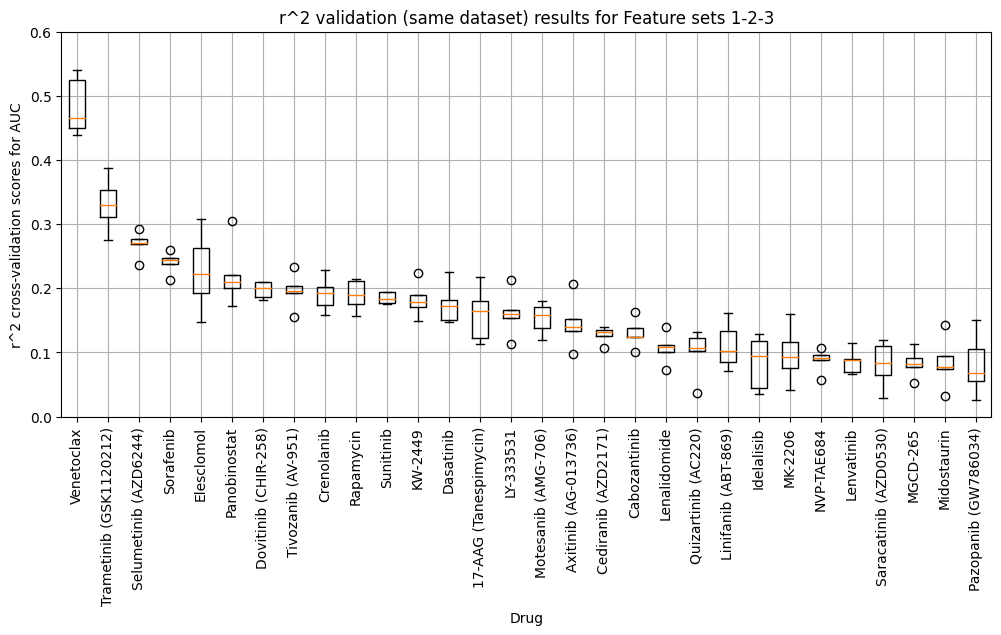

In [168]:
# TODO: add Feature sets 1 and 2 alone to this. Include train and val. See Figure 5 in the paper.
plt.figure(figsize=(12, 5))
plt.boxplot(wave34_f123_r2[indices_nonzero[:30]].tolist(), labels=wave34_f123_coef.target.unique()[indices_nonzero[:30]])
plt.xticks(rotation=90)
plt.ylim(0, 0.6)
plt.title('r^2 validation (same dataset) results for Feature sets 1-2-3')
plt.ylabel('r^2 cross-validation scores for AUC')
plt.xlabel('Drug')
plt.grid()
plt.show()

### Creating a combined table of AUC predictions

In [169]:
# create combined result table for rows 
combined_result_table = []
for drug in drugs:
    if drug not in wave34_f4_coef:
        continue
    # adding wave1/2 results
    f4_drug_table = f4_coef[drug]
    f4_drug_table['features'] = 'F4'
    f4_drug_table['dataset'] = 'wave12'
    combined_result_table.append(f4_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f124_drug_table = f124_coef[drug]
    f124_drug_table['features'] = 'F1-2-4'
    f124_drug_table['dataset'] = 'wave12'
    combined_result_table.append(f124_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f3a_drug_table = f3a_coef[drug]
    f3a_drug_table['features'] = 'F3a'
    f3a_drug_table['dataset'] = 'wave12'
    combined_result_table.append(f3a_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f3b_drug_table = f3b_coef[drug]
    f3b_drug_table['features'] = 'F3b'
    f3b_drug_table['dataset'] = 'wave12'
    combined_result_table.append(f3b_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f3_drug_table = f3_coef[f3_coef.target == drug].copy()
    f3_drug_table['features'] = 'F3'
    f3_drug_table['dataset'] = 'wave12'
    combined_result_table.append(f3_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f123_drug_table = f123_coef[f123_coef.target == drug].copy()
    f123_drug_table['features'] = 'F1-2-3'
    f123_drug_table['dataset'] = 'wave12'
    combined_result_table.append(f123_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f1234_drug_table = f123b4_coef[drug].copy()
    f1234_drug_table['features'] = 'F1-2-3b-4'
    f1234_drug_table['dataset'] = 'wave12'
    combined_result_table.append(f1234_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f3_drug_table = f3_coef[f3_coef.target == drug].copy()
    f3_drug_table['features'] = 'F3'
    f3_drug_table['dataset'] = 'wave12'
    combined_result_table.append(f3_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']]) 

    f4_drug_table = wave34_f4_coef[drug]
    f4_drug_table['features'] = 'F4'
    f4_drug_table['r2_score_train'] = 0
    f4_drug_table['dataset'] = 'wave34'
    combined_result_table.append(f4_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f124_drug_table = wave34_f124_coef[drug]
    f124_drug_table['features'] = 'F1-2-4'
    f124_drug_table['r2_score_train'] = 0
    f124_drug_table['dataset'] = 'wave34'
    combined_result_table.append(f124_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f3a_drug_table = wave34_f3a_coef[drug]
    f3a_drug_table['features'] = 'F3a'
    f3a_drug_table['r2_score_train'] = 0
    f3a_drug_table['dataset'] = 'wave34'
    combined_result_table.append(f3a_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f3b_drug_table = wave34_f3b_coef[drug]
    f3b_drug_table['features'] = 'F3b'
    f3b_drug_table['r2_score_train'] = 0
    f3b_drug_table['dataset'] = 'wave34'
    combined_result_table.append(f3b_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f123_drug_table = wave34_f123_coef[wave34_f123_coef.target == drug].copy()
    f123_drug_table['features'] = 'F1-2-3'
    f123_drug_table['r2_score_train'] = 0
    f123_drug_table['dataset'] = 'wave34'
    combined_result_table.append(f123_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f1234_drug_table = wave34_f123b4_coef[drug].copy()
    f1234_drug_table['features'] = 'F1-2-3b-4'
    f1234_drug_table['r2_score_train'] = 0
    f1234_drug_table['dataset'] = 'wave34'
    combined_result_table.append(f1234_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f3_drug_table = wave34_f3_coef[wave34_f3_coef.target == drug].copy()
    f3_drug_table['features'] = 'F3'
    f3_drug_table['r2_score_train'] = 0
    f3_drug_table['dataset'] = 'wave34'
    combined_result_table.append(f3_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])



In [170]:
combined_result_table = pd.concat(combined_result_table, axis=0)

In [171]:
combined_result_table

target  r2_score_train  r2_score_test features dataset
0    17-AAG (Tanespimycin)        0.635687       0.448200       F4  wave12
1    17-AAG (Tanespimycin)        0.769333       0.492687       F4  wave12
2    17-AAG (Tanespimycin)        0.841324       0.293033       F4  wave12
3    17-AAG (Tanespimycin)        0.712040       0.359379       F4  wave12
4    17-AAG (Tanespimycin)        0.781669       0.354959       F4  wave12
..                     ...             ...            ...      ...     ...
555                 YM-155        0.000000      -0.025517       F3  wave34
556                 YM-155        0.000000       0.023270       F3  wave34
557                 YM-155        0.000000      -0.065814       F3  wave34
558                 YM-155        0.000000      -0.038923       F3  wave34
559                 YM-155        0.000000      -0.069668       F3  wave34

[8400 rows x 5 columns]

In [172]:
drug_means = combined_result_table[combined_result_table.dataset=='wave34'].groupby(['target']).aggregate('mean')

/tmp/ipykernel_601078/2464852398.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  drug_means = combined_result_table[combined_result_table.dataset=='wave34'].groupby(['target']).aggregate('mean')


In [173]:
drug_means = drug_means.sort_values('r2_score_test', ascending=False)

In [174]:
top_drugs = drug_means[drug_means.r2_score_test > 0].index

In [175]:
import seaborn as sns

In [176]:
results_top_drugs = combined_result_table[combined_result_table.target.isin(top_drugs)]

In [177]:
results_top_drugs

target  r2_score_train  r2_score_test features dataset
0    17-AAG (Tanespimycin)        0.635687       0.448200       F4  wave12
1    17-AAG (Tanespimycin)        0.769333       0.492687       F4  wave12
2    17-AAG (Tanespimycin)        0.841324       0.293033       F4  wave12
3    17-AAG (Tanespimycin)        0.712040       0.359379       F4  wave12
4    17-AAG (Tanespimycin)        0.781669       0.354959       F4  wave12
..                     ...             ...            ...      ...     ...
535             Venetoclax        0.000000       0.541103       F3  wave34
536             Venetoclax        0.000000       0.454381       F3  wave34
537             Venetoclax        0.000000       0.439962       F3  wave34
538             Venetoclax        0.000000       0.465430       F3  wave34
539             Venetoclax        0.000000       0.536349       F3  wave34

[2400 rows x 5 columns]

In [193]:
combined_result_table.to_csv('combined_result_table.csv')

### Visualizations for wave3/4 only

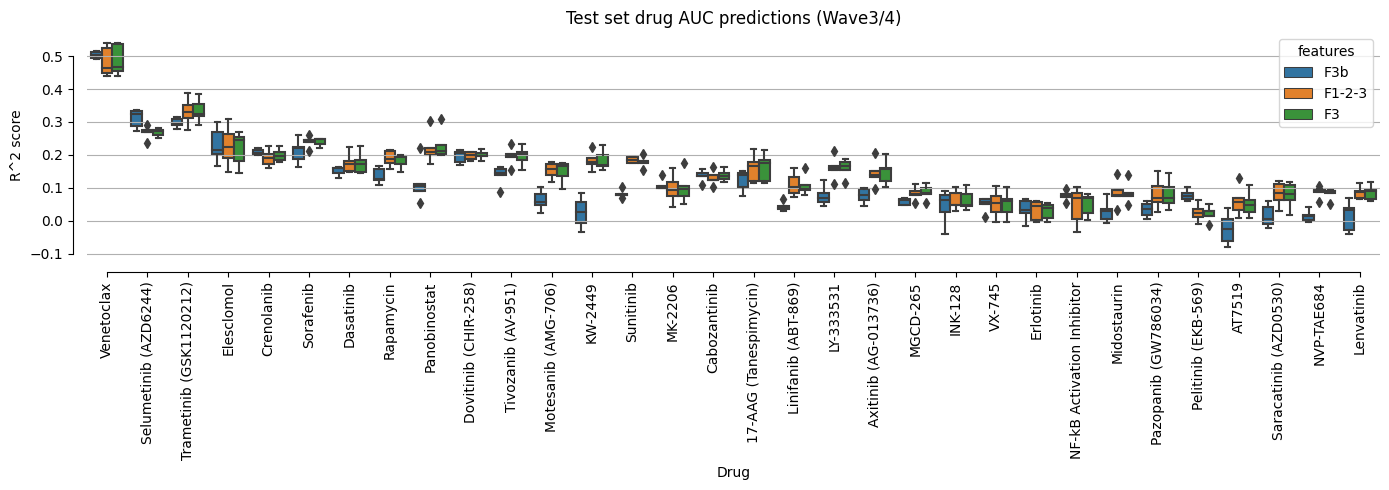

In [194]:
plt.figure(figsize=(14, 5))
results_top_drugs_f1234 = results_top_drugs[results_top_drugs.features.isin(['F3', 'F3b', 'F1-2-3']) & (results_top_drugs.dataset=='wave34')]
sns.boxplot(x='target', y='r2_score_test', hue='features', data=results_top_drugs_f1234, order=top_drugs)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.title('Test set drug AUC predictions (Wave3/4)')
plt.ylabel('R^2 score')
plt.xlabel('Drug')
plt.tight_layout()
plt.savefig('test_drug_auc_pred_features33b.png')

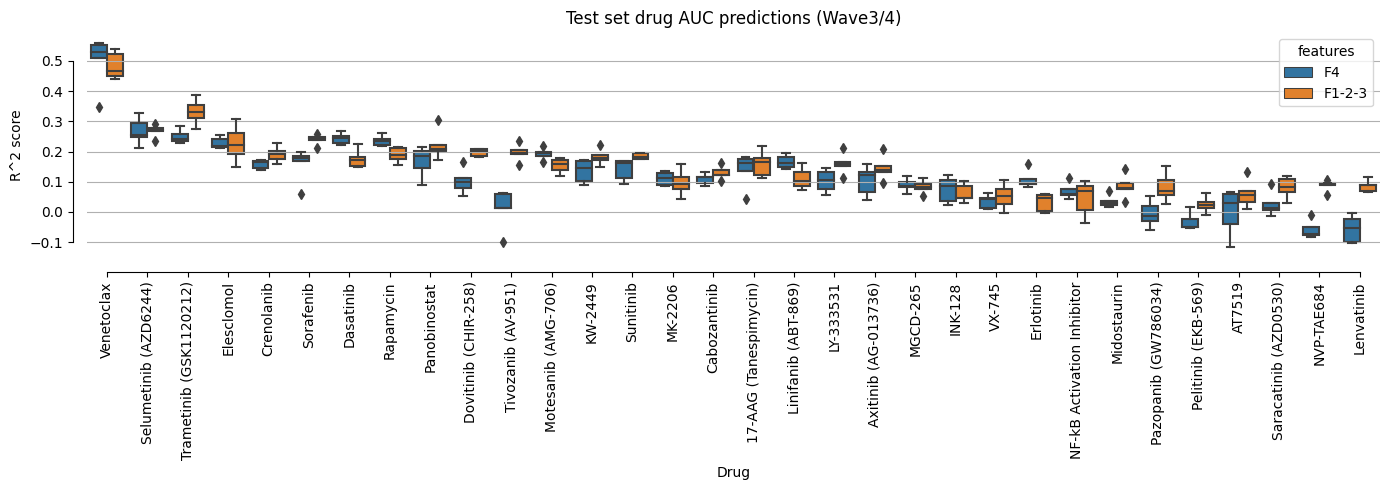

In [195]:
plt.figure(figsize=(14, 5))
results_top_drugs_f1234 = results_top_drugs[results_top_drugs.features.isin(['F4', 'F1-2-3']) & (results_top_drugs.dataset=='wave34')]
sns.boxplot(x='target', y='r2_score_test', hue='features', data=results_top_drugs_f1234, order=top_drugs)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.title('Test set drug AUC predictions (Wave3/4)')
plt.ylabel('R^2 score')
plt.xlabel('Drug')
plt.tight_layout()
plt.savefig('test_drug_auc_pred_features1234.png')

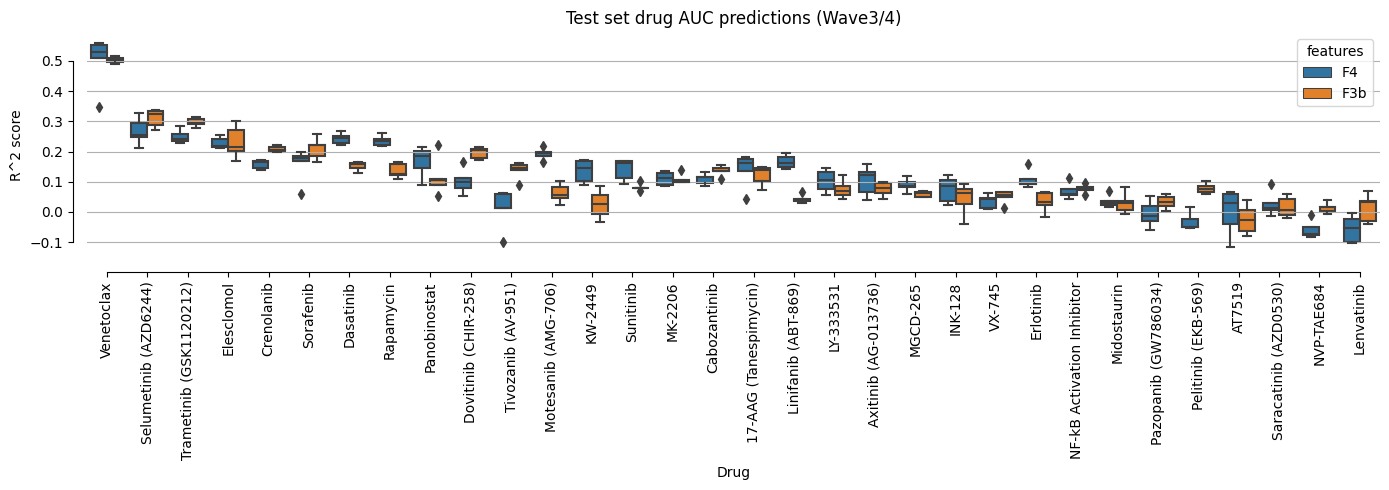

In [196]:
plt.figure(figsize=(14, 5))
results_top_drugs_f3b4 = results_top_drugs[results_top_drugs.features.isin(['F4', 'F3b']) & (results_top_drugs.dataset=='wave34')]
sns.boxplot(x='target', y='r2_score_test', hue='features', data=results_top_drugs_f3b4, order=top_drugs)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.title('Test set drug AUC predictions (Wave3/4)')
plt.ylabel('R^2 score')
plt.xlabel('Drug')
plt.tight_layout()
plt.savefig('test_drug_auc_pred_features3b4.png')

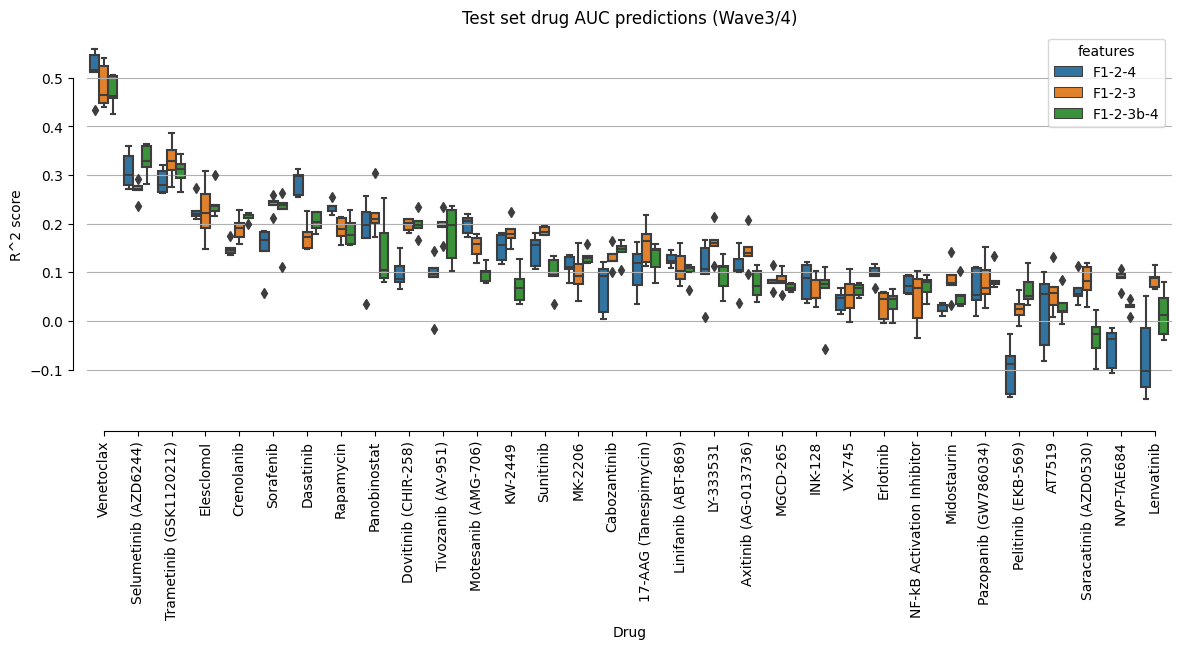

In [197]:
plt.figure(figsize=(14, 5))
results_top_drugs_f3b4 = results_top_drugs[results_top_drugs.features.isin(['F1-2-4', 'F1-2-3', 'F1-2-3b-4']) & (results_top_drugs.dataset=='wave34')]
sns.boxplot(x='target', y='r2_score_test', hue='features', data=results_top_drugs_f3b4, order=top_drugs)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.title('Test set drug AUC predictions (Wave3/4)')
plt.ylabel('R^2 score')
plt.xlabel('Drug')
plt.savefig('test_drug_auc_pred_features1_124_3_123.png')

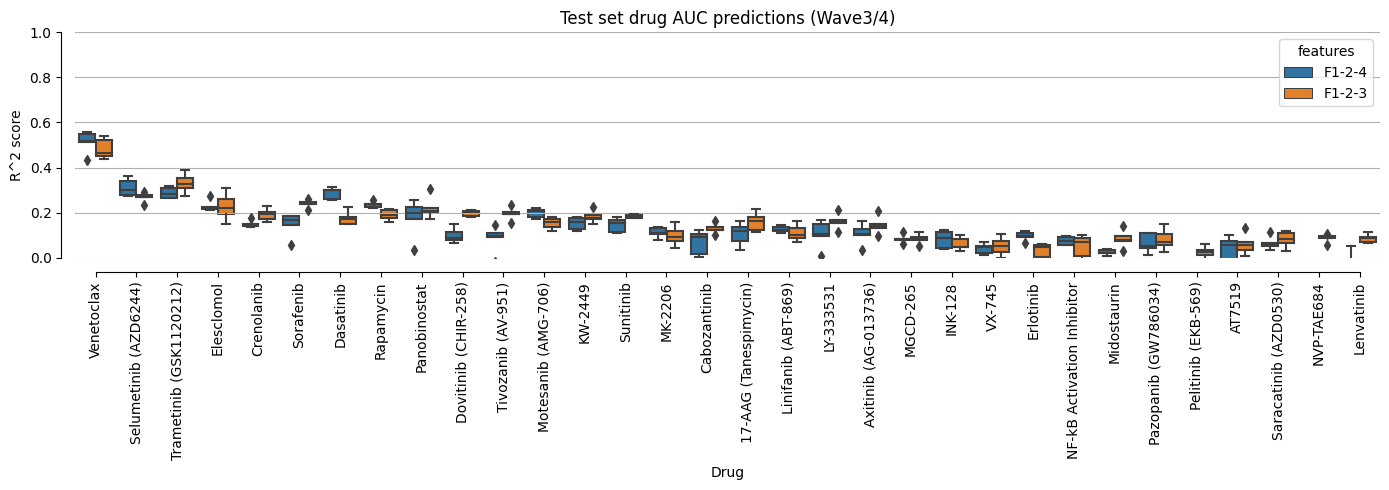

In [226]:
plt.figure(figsize=(14, 5))

results_top_drugs_f3b4 = results_top_drugs[results_top_drugs.features.isin(['F1-2-4', 'F1-2-3']) & (results_top_drugs.dataset=='wave34')]
sns.boxplot(x='target', y='r2_score_test', hue='features', data=results_top_drugs_f3b4, order=top_drugs)
plt.ylim(0, 1)

sns.despine(offset=10, trim=True)

plt.xticks(rotation=90)
plt.grid(axis='y')
plt.title('Test set drug AUC predictions (Wave3/4)')
plt.ylabel('R^2 score')
plt.xlabel('Drug')
plt.tight_layout()
plt.savefig('test_drug_auc_pred_features_124_123.png', dpi=200)

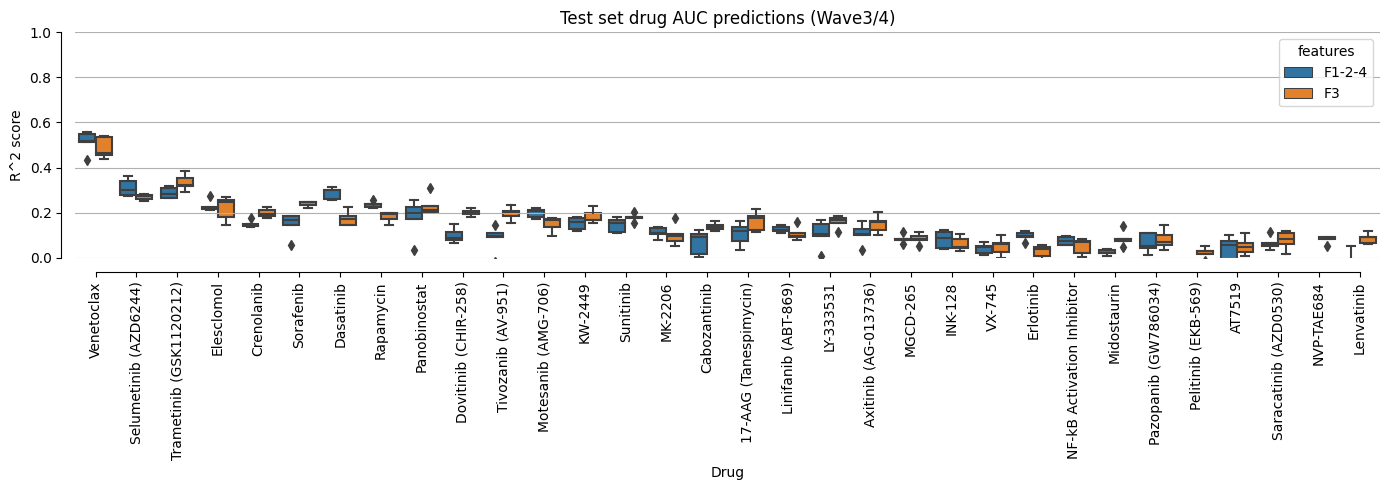

In [227]:
plt.figure(figsize=(14, 5))
results_top_drugs_f3b4 = results_top_drugs[results_top_drugs.features.isin(['F1-2-4', 'F3']) & (results_top_drugs.dataset=='wave34')]
sns.boxplot(x='target', y='r2_score_test', hue='features', data=results_top_drugs_f3b4, order=top_drugs)
plt.ylim(0, 1)

sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.title('Test set drug AUC predictions (Wave3/4)')
plt.ylabel('R^2 score')
plt.xlabel('Drug')
plt.tight_layout()
plt.savefig('test_drug_auc_pred_features_124_3.png', dpi=200)

### Combined visualizations for wave1/2/3/4

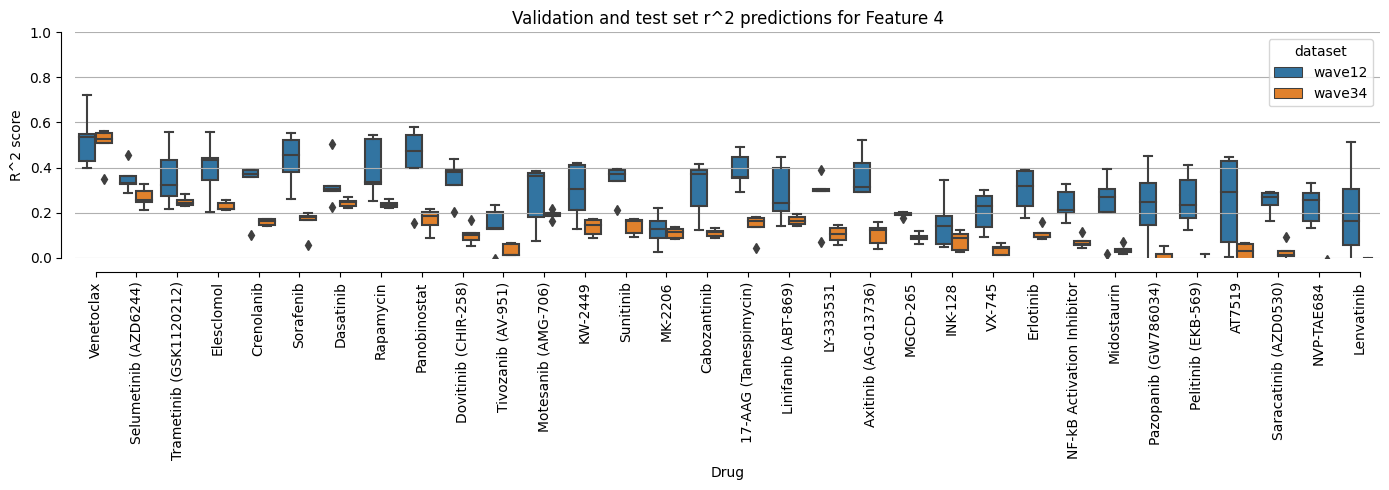

In [212]:
plt.figure(figsize=(14, 5))
results_top_drugs_f4 = results_top_drugs[results_top_drugs.features.isin(['F4'])]
sns.boxplot(x='target', y='r2_score_test', hue='dataset', data=results_top_drugs_f4, order=top_drugs)
plt.ylim(0, 1)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)

plt.grid(axis='y')
plt.title('Validation and test set r^2 predictions for Feature 4')
plt.ylabel('R^2 score')
plt.xlabel('Drug')
plt.tight_layout()
plt.savefig('test_drug_auc_pred_features4_wave1234.png', dpi=200)

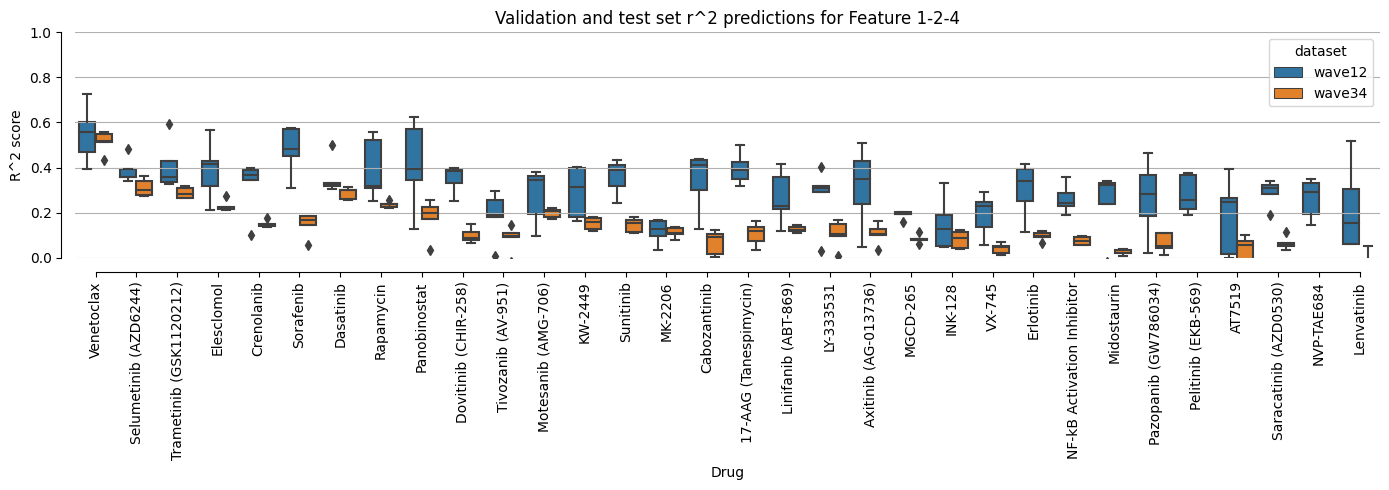

In [210]:
plt.figure(figsize=(14, 5))
results_top_drugs_f4 = results_top_drugs[results_top_drugs.features.isin(['F1-2-4'])]
sns.boxplot(x='target', y='r2_score_test', hue='dataset', data=results_top_drugs_f4, order=top_drugs)
plt.ylim(0, 1)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)

plt.grid(axis='y')
plt.title('Validation and test set r^2 predictions for Feature 1-2-4')
plt.ylabel('R^2 score')
plt.xlabel('Drug')
plt.tight_layout()
plt.savefig('test_drug_auc_pred_features124_wave1234.png', dpi=200)

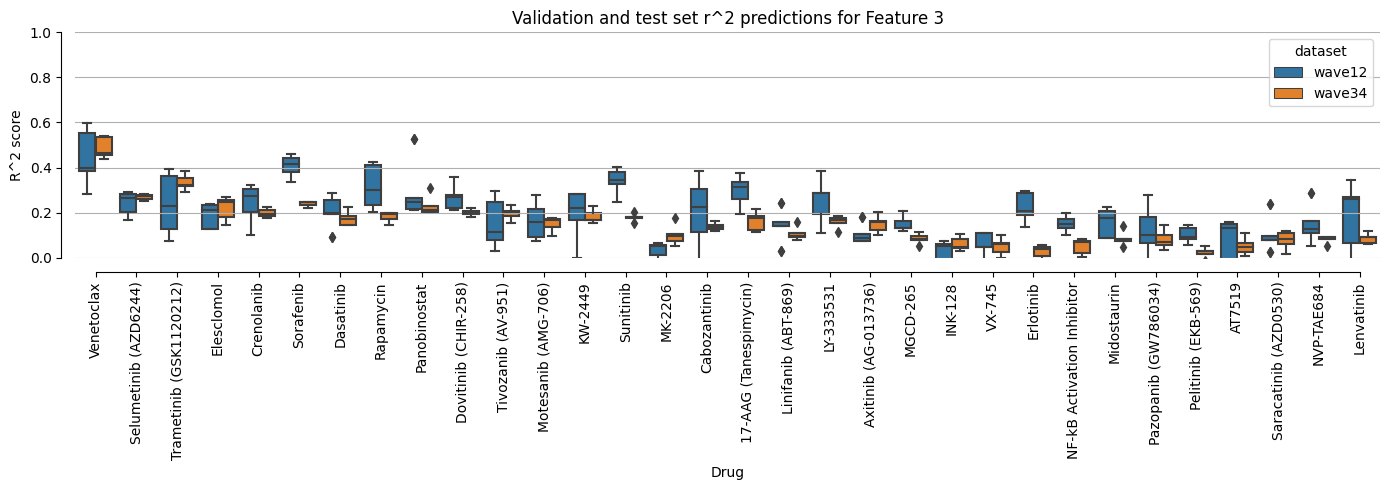

In [211]:
plt.figure(figsize=(14, 5))
results_top_drugs_f4 = results_top_drugs[results_top_drugs.features.isin(['F3'])]
sns.boxplot(x='target', y='r2_score_test', hue='dataset', data=results_top_drugs_f4, order=top_drugs)
plt.ylim(0, 1)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.title('Validation and test set r^2 predictions for Feature 3')
plt.ylabel('R^2 score')
plt.xlabel('Drug')
plt.tight_layout()
plt.savefig('test_drug_auc_pred_features3_wave1234.png', dpi=200)

### Visualizations for Venetoclax and Trametinib only

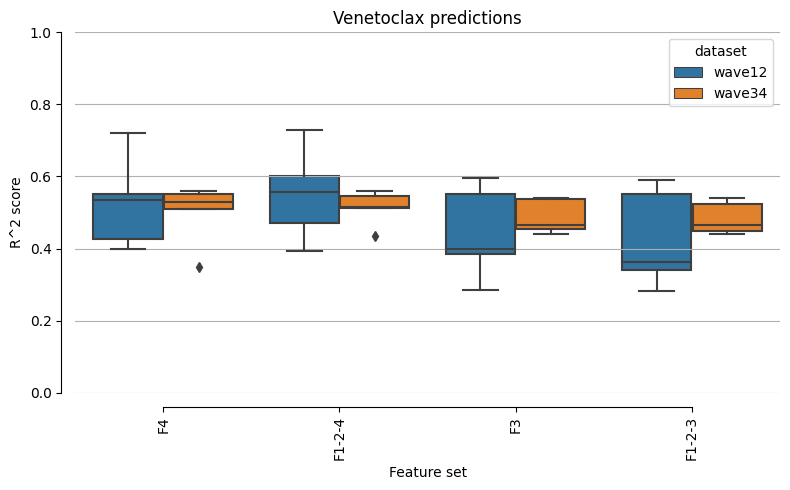

In [203]:
plt.figure(figsize=(8, 5))
results_venetoclax = results_top_drugs[(results_top_drugs.target=='Venetoclax') & (results_top_drugs.features.isin(['F3', 'F4', 'F1-2-4', 'F1-2-3'])) ]
sns.boxplot(x='features', y='r2_score_test', hue='dataset', data=results_venetoclax)
plt.ylim(0, 1)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.title('Venetoclax predictions')
plt.ylabel('R^2 score')
plt.xlabel('Feature set')
plt.tight_layout()
plt.savefig('test_venetoclax_auc_pred_wave1234.png', dpi=300)

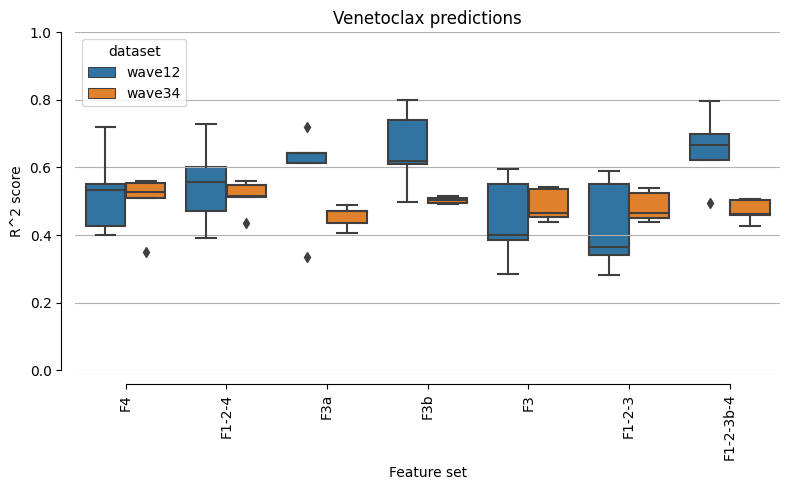

In [204]:
plt.figure(figsize=(8, 5))
results_venetoclax = results_top_drugs[(results_top_drugs.target=='Venetoclax')]
sns.boxplot(x='features', y='r2_score_test', hue='dataset', data=results_venetoclax)
plt.ylim(0, 1)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.title('Venetoclax predictions')
plt.ylabel('R^2 score')
plt.xlabel('Feature set')
plt.tight_layout()
plt.savefig('test_venetoclax_auc_pred_wave1234_full.png')

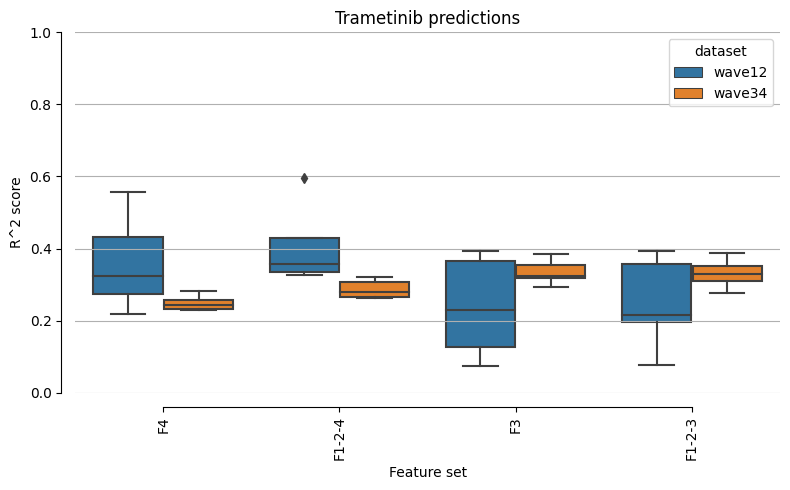

In [205]:
plt.figure(figsize=(8, 5))
results_trametinib = results_top_drugs[(results_top_drugs.target=='Trametinib (GSK1120212)')  & (results_top_drugs.features.isin(['F3', 'F4', 'F1-2-4', 'F1-2-3']))]
sns.boxplot(x='features', y='r2_score_test', hue='dataset', data=results_trametinib)
plt.ylim(0, 1)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.title('Trametinib predictions')
plt.ylabel('R^2 score')
plt.xlabel('Feature set')
plt.tight_layout()
plt.savefig('test_trametinib_auc_pred_wave1234.png', dpi=300)

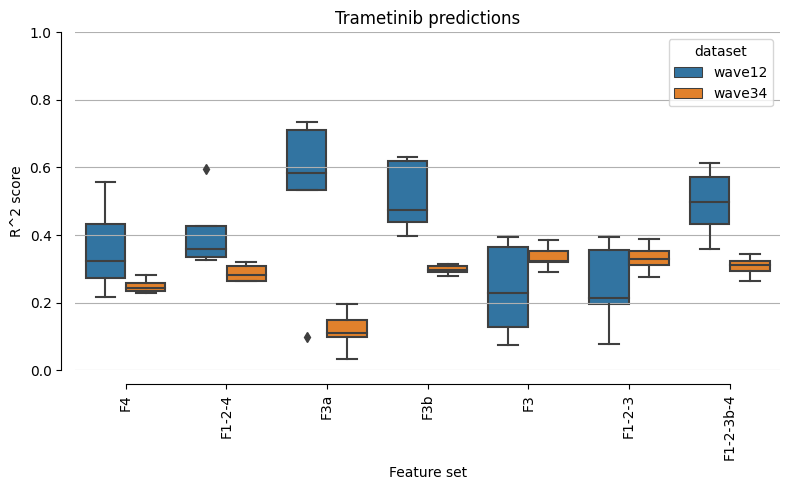

In [206]:
plt.figure(figsize=(8, 5))
results_trametinib = results_top_drugs[(results_top_drugs.target=='Trametinib (GSK1120212)')]
sns.boxplot(x='features', y='r2_score_test', hue='dataset', data=results_trametinib)
plt.ylim(0, 1)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.title('Trametinib predictions')
plt.ylabel('R^2 score')
plt.xlabel('Feature set')
plt.tight_layout()
plt.savefig('test_trametinib_auc_pred_wave1234_full.png')

In [207]:
results_top_drugs.target.unique()

array(['17-AAG (Tanespimycin)', 'AT7519', 'Axitinib (AG-013736)',
       'Cabozantinib', 'Crenolanib', 'Dasatinib', 'Dovitinib (CHIR-258)',
       'Elesclomol', 'Erlotinib', 'INK-128', 'KW-2449', 'LY-333531',
       'Lenvatinib', 'Linifanib (ABT-869)', 'MGCD-265', 'MK-2206',
       'Midostaurin', 'Motesanib (AMG-706)', 'NF-kB Activation Inhibitor',
       'NVP-TAE684', 'Panobinostat', 'Pazopanib (GW786034)',
       'Pelitinib (EKB-569)', 'Rapamycin', 'Saracatinib (AZD0530)',
       'Selumetinib (AZD6244)', 'Sorafenib', 'Sunitinib',
       'Tivozanib (AV-951)', 'Trametinib (GSK1120212)', 'VX-745',
       'Venetoclax'], dtype=object)